# Import Libraries

In [ ]:
import sys
sys.path.append("..")
import seaborn as sb
import dgl
import torch

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.nn.functional as F

import statistics
import argparse
import random

from dgl.data import CitationGraphDataset
# from dgl.nn import GINConv, GraphConv, SAGEConv
import seaborn as sb
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.optimize import linear_sum_assignment
import scipy
import scipy.optimize
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn as sk
import networkx as nx


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import random
import math
import time


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

from torch_geometric.nn import GCNConv,GINConv,SAGEConv,GATConv,PNAConv, GraphSAGE
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import normalize_features
from pygod.utils import load_data
from pygod.utils.utility import check_parameter
from pygod.metrics import eval_roc_auc
from pygod.generator import gen_contextual_outliers, gen_structural_outliers
from scipy.linalg import sqrtm

# Utils

In [2]:

def _normalize(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min)/x_max
    return x_norm

def gen_joint_structural_outliers(data, m, n, random_state=None):
    """
    We randomly select n nodes from the network which will be the anomalies 
    and for each node we select m nodes from the network. 
    We connect each of n nodes with the m other nodes.

    Parameters
    ----------
    data : PyTorch Geometric Data instance (torch_geometric.data.Data)
        The input data.
    m : int
        Number nodes in the outlier cliques.
    n : int
        Number of outlier cliques.
    p : int, optional
        Probability of edge drop in cliques. Default: ``0``.
    random_state : int, optional
        The seed to control the randomness, Default: ``None``.

    Returns
    -------
    data : PyTorch Geometric Data instance (torch_geometric.data.Data)
        The structural outlier graph with injected edges.
    y_outlier : torch.Tensor
        The outlier label tensor where 1 represents outliers and 0 represents
        regular nodes.
    """

    if not isinstance(data, Data):
        raise TypeError("data should be torch_geometric.data.Data")

    if isinstance(m, int):
        check_parameter(m, low=0, high=data.num_nodes, param_name='m')
    else:
        raise ValueError("m should be int, got %s" % m)

    if isinstance(n, int):
        check_parameter(n, low=0, high=data.num_nodes, param_name='n')
    else:
        raise ValueError("n should be int, got %s" % n)

    check_parameter(m * n, low=0, high=data.num_nodes, param_name='m*n')

    if random_state:
        np.random.seed(random_state)


    outlier_idx = np.random.choice(data.num_nodes, size=n, replace=False)
    all_nodes = [i for i in range(data.num_nodes)]
    rem_nodes = []
    
    for node in all_nodes:
        if node is not outlier_idx:
            rem_nodes.append(node)
    
    
    
    new_edges = []
    
    # connect all m nodes in each clique
    for i in range(0, n):
        other_idx = np.random.choice(data.num_nodes, size=m, replace=False)
        for j in other_idx:
            new_edges.append(torch.tensor([[i, j]], dtype=torch.long))
                    

    new_edges = torch.cat(new_edges)


    y_outlier = torch.zeros(data.x.shape[0], dtype=torch.long)
    y_outlier[outlier_idx] = 1

    data.edge_index = torch.cat([data.edge_index, new_edges.T], dim=1)

    return data, y_outlier


def KL_neighbor_loss(predictions, targets, mask_len):
    x1 = predictions.squeeze().cpu().detach()
    x2 = targets.squeeze().cpu().detach()
    
    mean_x1 = x1.mean(0)
    mean_x2 = x2.mean(0)
    
    nn = x1.shape[0]
    h_dim = x1.shape[1]
    
    cov_x1 = (x1-mean_x1).transpose(1,0).matmul(x1-mean_x1) / max((nn-1),1)
    cov_x2 = (x2-mean_x2).transpose(1,0).matmul(x2-mean_x2) / max((nn-1),1)
    
    eye = torch.eye(h_dim)
    cov_x1 = cov_x1 + eye
    cov_x2 = cov_x2 + eye
    
    KL_loss = 0.5 * (math.log(torch.det(cov_x1) / torch.det(cov_x2)) - h_dim  + torch.trace(torch.inverse(cov_x2).matmul(cov_x1)) 
            + (mean_x2 - mean_x1).reshape(1,-1).matmul(torch.inverse(cov_x2)).matmul(mean_x2 - mean_x1))
    KL_loss = KL_loss.to(device)
    return KL_loss

def W2_neighbor_loss(predictions, targets, mask_len):
    
    x1 = predictions.squeeze().cpu().detach()
    x2 = targets.squeeze().cpu().detach()
    
    mean_x1 = x1.mean(0)
    mean_x2 = x2.mean(0)

    nn = x1.shape[0]
    
    cov_x1 = (x1-mean_x1).transpose(1,0).matmul(x1-mean_x1) / (nn-1)
    cov_x2 = (x2-mean_x2).transpose(1,0).matmul(x2-mean_x2) / (nn-1)
    

    W2_loss = torch.square(mean_x1-mean_x2).sum() + torch.trace(cov_x1 + cov_x2 
                     + 2 * sqrtm(sqrtm(cov_x1) @ (cov_x2.numpy()) @ (sqrtm(cov_x1))))

    return W2_loss



# Layers

In [3]:
class MLP(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        

        super(MLP, self).__init__()

        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            for layer in range(num_layers - 1):
                self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for layer in range(self.num_layers - 1):
                h = self.linears[layer](h)
                
                if len(h.shape) > 2:
                    h = torch.transpose(h, 0, 1)
                    h = torch.transpose(h, 1, 2)
                    
                h = self.batch_norms[layer](h)
                
                if len(h.shape) > 2:
                    h = torch.transpose(h, 1, 2)
                    h = torch.transpose(h, 0, 1)

                h = F.relu(h)
                # h = F.relu(self.linears[layer](h))
                
            return self.linears[self.num_layers - 1](h)


class MLP_generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP_generator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.linear3 = nn.Linear(output_dim, output_dim)
        self.linear4 = nn.Linear(output_dim, output_dim)

    def forward(self, embedding):
        neighbor_embedding = F.relu(self.linear(embedding))
        neighbor_embedding = F.relu(self.linear2(neighbor_embedding))
        neighbor_embedding = F.relu(self.linear3(neighbor_embedding))
        neighbor_embedding = self.linear4(neighbor_embedding)
        return neighbor_embedding


class PairNorm(nn.Module):
    def __init__(self, mode='PN', scale=10):
        
        assert mode in ['None', 'PN', 'PN-SI', 'PN-SCS']
        super(PairNorm, self).__init__()
        self.mode = mode
        self.scale = scale

        # Scale can be set based on origina data, and also the current feature lengths.
        # We leave the experiments to future. A good pool we used for choosing scale:
        # [0.1, 1, 10, 50, 100]
    def forward(self, x):
        if self.mode == 'None':
            return x
        col_mean = x.mean(dim=0)
        if self.mode == 'PN':
            x = x - col_mean
            rownorm_mean = (1e-6 + x.pow(2).sum(dim=1).mean()).sqrt()
            x = self.scale * x / rownorm_mean
        if self.mode == 'PN-SI':
            x = x - col_mean
            rownorm_individual = (1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual
        if self.mode == 'PN-SCS':
            rownorm_individual = (1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual - col_mean
        return x


# FNN
class FNN(nn.Module):
    def __init__(self, in_features, hidden, out_features, layer_num):
        super(FNN, self).__init__()
        self.linear1 = MLP(layer_num, in_features, hidden, out_features)
        self.linear2 = nn.Linear(out_features, out_features)
    def forward(self, embedding):
        x = self.linear1(embedding)
        x = self.linear2(F.relu(x))
        x = F.relu(x)
        return x


# GAD-NR

In [4]:

# Training
def train(data, y, yc, ys, yj, ysj, lr, epoch, device, encoder, lambda_loss1, lambda_loss2, lambda_loss3, hidden_dim, sample_size=10,loss_step=20,
          real_loss=False,calculate_contextual=False,calculate_structural=False):
    '''
     Main training function
     INPUT:
     -----------------------
     data : torch geometric dataset object
     lr    :    learning rate
     epoch     :    number of training epoch
     device     :   CPU or GPU
     encoder    :    GCN or GIN or GraphSAGE
     lambda_loss    :   Trade-off between degree loss and neighborhood reconstruction loss
     hidden_dim     :   latent variable dimension
    '''
    
    in_nodes = data.edge_index[0,:]
    out_nodes = data.edge_index[1,:]
    
    
    neighbor_dict = {}
    for in_node, out_node in zip(in_nodes, out_nodes):
        if in_node.item() not in neighbor_dict:
            neighbor_dict[in_node.item()] = []
        neighbor_dict[in_node.item()].append(out_node.item())

    neighbor_num_list = []
    for i in neighbor_dict:
        neighbor_num_list.append(len(neighbor_dict[i]))
    
    neighbor_num_list = torch.tensor(neighbor_num_list).to(device)
    
    in_dim = data.x.shape[1]
    GNNModel = GNNStructEncoder(in_dim, hidden_dim, hidden_dim, 2, sample_size, device=device, 
                    neighbor_num_list=neighbor_num_list, GNN_name=encoder, 
                    lambda_loss1=lambda_loss1, lambda_loss2=lambda_loss2,lambda_loss3=lambda_loss3)
    GNNModel.to(device)
    degree_params = list(map(id, GNNModel.degree_decoder.parameters()))
    base_params = filter(lambda p: id(p) not in degree_params,
                         GNNModel.parameters())

    opt = torch.optim.Adam([{'params': base_params}, {'params': GNNModel.degree_decoder.parameters(), 'lr': 1e-2}],lr=lr, weight_decay=0.0003)
    min_loss = float('inf')
    arg_min_loss_per_node = None
    
    best_auc = 0
    best_auc_contextual = 0
    best_auc_dense_structural = 0
    best_auc_joint_structural = 0
    best_auc_structure_type = 0
    
        
    loss_values = []
    for i in tqdm(range(1,epoch+1,1)):
        
        # st = time.time()
        
        if i%loss_step==0:
            GNNModel.lambda_loss2 = GNNModel.lambda_loss2 + 0.5
            GNNModel.lambda_loss3 = GNNModel.lambda_loss3 / 2
        
        loss,loss_per_node,h_loss,degree_loss,feature_loss = GNNModel(data.edge_index, data.x, neighbor_num_list, neighbor_dict, device=device)
        
        
        
        loss_per_node = loss_per_node.cpu().detach()
        
        h_loss = h_loss.cpu().detach()
        degree_loss = degree_loss.cpu().detach()
        feature_loss = feature_loss.cpu().detach()
        
        h_loss_norm = h_loss / (torch.max(h_loss) - torch.min(h_loss))
        degree_loss_norm = degree_loss / (torch.max(degree_loss) - torch.min(degree_loss))
        feature_loss_norm = feature_loss / (torch.max(feature_loss) - torch.min(feature_loss))
        
        comb_loss = args.h_loss_weight * h_loss_norm + args.degree_loss_weight *  degree_loss_norm + args.feature_loss_weight * feature_loss_norm
        
        if real_loss:
            comp_loss = loss_per_node
        else:
            comp_loss = comb_loss
            
        
        auc_score = eval_roc_auc(y.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score(benchmark/combined): ", auc_score)
        
        contextual_auc_score = eval_roc_auc(yc.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (contextual): ", contextual_auc_score)

        dense_structural_auc_score = eval_roc_auc(ys.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (structural): ", dense_structural_auc_score)
        
        joint_type_auc_score = eval_roc_auc(yj.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (joint-type): ", joint_type_auc_score)
        
        structure_type_auc_score = eval_roc_auc(ysj.numpy(), comp_loss.numpy()) * 100
        print("Dataset Name: ",dataset_str, ", AUC Score (structure type): ", structure_type_auc_score) 
        
        best_auc = max(best_auc, auc_score)
        best_auc_contextual = max(best_auc_contextual, contextual_auc_score)
        best_auc_dense_structural = max(best_auc_dense_structural, dense_structural_auc_score)
        best_auc_joint_type = max(best_auc_joint_structural, joint_type_auc_score)
        best_auc_structure_type = max(best_auc_structure_type, structure_type_auc_score)
        
        
        
        print("===========================================================================================")
        print("Dataset Name: ",dataset_str, " Best AUC Score(benchmark/combined): ", best_auc)
        
        print("Dataset Name: ",dataset_str, " Best AUC Score (contextual): ", best_auc_contextual)

        
        print("Dataset Name: ",dataset_str, " Best AUC Score (structural): ", best_auc_dense_structural)
        
        
        print("Dataset Name: ",dataset_str, " Best AUC Score (joint-type): ", best_auc_joint_type)
        
        
        print("Dataset Name: ",dataset_str, " Best AUC Score (structure type): ", best_auc_structure_type) 
        print("===========================================================================================")
        
        
        if loss < min_loss:
            min_loss = loss
            arg_min_loss_per_node = loss_per_node
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss = loss.cpu().detach()
        loss_values.append(loss)
        
        en = time.time()
        # print("Required Time: ", (en-st)*1000)
        # import sys
        # sys.exit(0)
        
        if args.plot_loss:

            plt.plot(np.array(loss_values), 'r')
            plt.show()
    
    return min_loss.item(), arg_min_loss_per_node.cpu().detach()




def evaluate(model, embeddings, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(embeddings)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)


def train_real_datasets(dataset_str, epoch_num = 10, lr = 5e-6, encoder = "GCN", 
                        lambda_loss1=1e-2, lambda_loss2=1e-3, lambda_loss3=1e-3, sample_size=8, loss_step=20, hidden_dim=None,
                        real_loss=False,calculate_contextual=False,calculate_structural=False):
    
    data = load_data(dataset_str)
    node_features = data.x
    
    if args.normalize_feat:
    
        node_features_min = node_features.min()
        node_features_max = node_features.max()
        node_features = (node_features - node_features_min)/node_features_max
        data.x = node_features
    
    yc = []
    ys = []
    yj = []
    
    if calculate_contextual:
        
        if dataset_str == "inj_cora":
            yc = data.y >> 0 & 1 # contextual outliers
        else:
            data, yc = gen_contextual_outliers(data=data,n=args.contextual_n,k=args.contextual_k)
            
        yc = yc.cpu().detach()
    
    
    if calculate_structural:
        
        if dataset_str == "inj_cora":
            ys = data.y >> 1 & 1 # structural outliers
        else:
            data, ys = gen_structural_outliers(data=data,n=args.structural_n,m=args.structural_m,p=0.2)
            
        ys = ys.cpu().detach()
        data, yj = gen_joint_structural_outliers(data=data,n=args.structural_n,m=args.structural_m)
        
    
    if args.use_combine_outlier:
        data.y = torch.logical_or(ys, yc).int()
        
    ysj = torch.logical_or(ys, yj).int()
    y = data.y.bool()    # binary labels (inlier/outlier)
    y = y.cpu().detach()
    
    edge_index = data.edge_index.cpu()
    
    num_nodes = node_features.shape[0]
    self_edges = torch.tensor([[i for i in range(num_nodes)],[i for i in range(num_nodes)]])
    edge_index = torch.cat([edge_index,self_edges],dim=1)
    data.edge_index = edge_index
    data = data.to(device)
    

    loss, loss_per_node, = train(data, y, yc, ys, yj, ysj, lr=lr, epoch=epoch_num, device=device, encoder=encoder, lambda_loss1=lambda_loss1, 
          lambda_loss2=lambda_loss2, lambda_loss3=lambda_loss3, hidden_dim=hidden_dim, sample_size=sample_size,loss_step=loss_step,
                                 real_loss=real_loss,calculate_contextual=calculate_contextual,calculate_structural=calculate_structural)

In [5]:
# generate ground truth neighbors Hv
def generate_gt_neighbor(neighbor_dict, node_embeddings, neighbor_num_list, in_dim):
    max_neighbor_num = max(neighbor_num_list)
    all_gt_neighbor_embeddings = []
    for i, embedding in enumerate(node_embeddings):
        neighbor_indexes = neighbor_dict[i]
        neighbor_embeddings = []
        for index in neighbor_indexes:
            neighbor_embeddings.append(node_embeddings[index].tolist())
        if len(neighbor_embeddings) < max_neighbor_num:
            for _ in range(max_neighbor_num - len(neighbor_embeddings)):
                neighbor_embeddings.append(torch.zeros(in_dim).tolist())
        all_gt_neighbor_embeddings.append(neighbor_embeddings)
    return all_gt_neighbor_embeddings


# Main Autoencoder structure here
class GNNStructEncoder(nn.Module):
    def __init__(self, in_dim0, in_dim, hidden_dim, layer_num, sample_size, device, neighbor_num_list, 
                 GNN_name="GIN", norm_mode="PN-SCS", norm_scale=20, lambda_loss1=0.01, lambda_loss2=0.001, lambda_loss3=0.0001):
        
        super(GNNStructEncoder, self).__init__()
        
        self.mlp0 = nn.Linear(in_dim0, hidden_dim)
        self.norm = PairNorm(norm_mode, norm_scale)
        self.out_dim = hidden_dim
        self.lambda_loss1 = lambda_loss1
        self.lambda_loss2 = lambda_loss2
        self.lambda_loss3 = lambda_loss3
        # GNN Encoder
        if GNN_name == "GIN":
            self.linear1 = MLP(layer_num, hidden_dim, hidden_dim, hidden_dim)
            self.graphconv1 = GINConv(self.linear1)
            self.linear2 = MLP(layer_num, hidden_dim, hidden_dim, hidden_dim)
            self.graphconv2 = GINConv(self.linear2)
        elif GNN_name == "GCN":
            self.graphconv1 = GCNConv(hidden_dim, hidden_dim)
            self.graphconv2 = GCNConv(hidden_dim, hidden_dim)
        elif GNN_name == "GAT":
            self.graphconv1 = GATConv(hidden_dim, hidden_dim)
            self.graphconv2 = GATConv(hidden_dim, hidden_dim)
        else:
            self.graphconv1 = SAGEConv(hidden_dim, hidden_dim, aggr=args.aggregator)
            # self.graphconv2 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
            
            # self.graphconv1 = GraphSAGE(hidden_dim, hidden_dim, aggr='mean', num_layers=1)
            

        self.neighbor_num_list = neighbor_num_list
        self.tot_node = len(neighbor_num_list)

        self.gaussian_mean = nn.Parameter(
            torch.FloatTensor(sample_size, hidden_dim).uniform_(-0.5 / hidden_dim,
                                                                                     0.5 / hidden_dim)).to(device)
        self.gaussian_log_sigma = nn.Parameter(
            torch.FloatTensor(sample_size, hidden_dim).uniform_(-0.5 / hidden_dim,
                                                                                     0.5 / hidden_dim)).to(device)
        self.m = torch.distributions.Normal(torch.zeros(sample_size, hidden_dim),
                                            torch.ones(sample_size, hidden_dim))
        
        self.m_batched = torch.distributions.Normal(torch.zeros(sample_size, self.tot_node, hidden_dim),
                                            torch.ones(sample_size, self.tot_node, hidden_dim))

        self.m_h = torch.distributions.Normal(torch.zeros(sample_size, hidden_dim),
                                            50* torch.ones(sample_size, hidden_dim))

        # Before MLP Gaussian Means, and std

        self.mlp_gaussian_mean = nn.Parameter(
            torch.FloatTensor(hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.mlp_gaussian_log_sigma = nn.Parameter(
            torch.FloatTensor(hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.mlp_m = torch.distributions.Normal(torch.zeros(hidden_dim), torch.ones(hidden_dim))

        self.mlp_mean = FNN(hidden_dim, hidden_dim, hidden_dim, 3)
        self.mlp_sigma = FNN(hidden_dim, hidden_dim, hidden_dim, 3)
        self.softplus = nn.Softplus()

        self.mean_agg = SAGEConv(hidden_dim, hidden_dim, aggr=args.aggregator, normalize = False)
        # self.mean_agg = GraphSAGE(hidden_dim, hidden_dim, aggr='mean', num_layers=1)
        self.std_agg = PNAConv(hidden_dim, hidden_dim, aggregators=["std"],scalers=["identity"], deg=neighbor_num_list)        
        self.layer1_generator = MLP_generator(hidden_dim, hidden_dim)
        
        # Decoders
        self.degree_decoder = FNN(hidden_dim, hidden_dim, 1, 4)
        self.feature_decoder = FNN(hidden_dim, hidden_dim, in_dim, 3)
        self.degree_loss_func = nn.MSELoss()
        self.feature_loss_func = nn.MSELoss()
        self.pool = mp.Pool(4)
        self.in_dim = in_dim
        self.sample_size = sample_size 
        self.init_projection = FNN(in_dim, hidden_dim, hidden_dim, 1)
        

    def forward_encoder(self, x, edge_index):
        
        # Apply graph convolution and activation, pair-norm to avoid trivial solution
        h0 = self.mlp0(x)
        l1 = self.graphconv1(h0, edge_index)
        return l1, h0
        
        

    # Sample neighbors from neighbor set, if the length of neighbor set less than sample size, then do the padding.
    def sample_neighbors(self, indexes, neighbor_dict, gt_embeddings):
        sampled_embeddings_list = []
        mark_len_list = []
        for index in indexes:
            sampled_embeddings = []
            neighbor_indexes = neighbor_dict[index]
            if len(neighbor_indexes) < self.sample_size:
                mask_len = len(neighbor_indexes)
                sample_indexes = neighbor_indexes
            else:
                sample_indexes = random.sample(neighbor_indexes, self.sample_size)
                mask_len = self.sample_size
            for index in sample_indexes:
                sampled_embeddings.append(gt_embeddings[index].tolist())
            if len(sampled_embeddings) < self.sample_size:
                for _ in range(self.sample_size - len(sampled_embeddings)):
                    sampled_embeddings.append(torch.zeros(self.out_dim).tolist())
            sampled_embeddings_list.append(sampled_embeddings)
            mark_len_list.append(mask_len)
        
        return sampled_embeddings_list, mark_len_list
    
    def reconstruction_neighbors2(self, l1, h0, edge_index):
                
        recon_loss = 0
        recon_loss_per_node = []
    
        sample_sz_per_node = [self.sample_size]* self.tot_node

        mean_neigh = self.mean_agg.forward(h0, edge_index).detach()
        std_neigh = self.std_agg(h0, edge_index).detach()
        
        
        cov_neigh = torch.bmm(std_neigh.unsqueeze(dim=-1),std_neigh.unsqueeze(dim=1))
        
        target_mean = mean_neigh
        target_cov = cov_neigh
        
        self_embedding = l1
        # self_embedding = _normalize(self_embedding)
        
        self_embedding = self_embedding.unsqueeze(0)
        self_embedding = self_embedding.repeat(self.sample_size, 1, 1)
        generated_mean = self.mlp_mean(self_embedding)
        generated_sigma = self.mlp_sigma(self_embedding)

        
        std_z = self.m_batched.sample().to(device)
        var = generated_mean + generated_sigma.exp() * std_z
        nhij = self.layer1_generator(var)
        
        generated_mean = torch.mean(nhij,dim=0)
        generated_std = torch.std(nhij,dim=0)
        generated_cov = torch.bmm(generated_std.unsqueeze(dim=-1),generated_std.unsqueeze(dim=1))/self.sample_size
        
        
        tot_nodes = l1.shape[0]
        h_dim = l1.shape[1]
        
        single_eye = torch.eye(h_dim).to(device)
        single_eye = single_eye.unsqueeze(dim=0)
        batch_eye = single_eye.repeat(tot_nodes,1,1)
        
        target_cov = target_cov + batch_eye
        generated_cov = generated_cov + batch_eye

        
        det_target_cov = torch.linalg.det(target_cov) 
        det_generated_cov = torch.linalg.det(generated_cov) 
        trace_mat = torch.matmul(torch.inverse(generated_cov),target_cov)
             
        
        x = torch.bmm(torch.unsqueeze(generated_mean - target_mean,dim=1),torch.inverse(generated_cov))
        y = torch.unsqueeze(generated_mean - target_mean,dim=-1)
        z = torch.bmm(x,y).squeeze()
        
        KL_loss = 0.5 * (torch.log(det_target_cov / det_generated_cov) - h_dim  + trace_mat.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1) + z)
        
        recon_loss = torch.mean(KL_loss)
        recon_loss_per_node = KL_loss
        
        
        return recon_loss, recon_loss_per_node
    

    def reconstruction_neighbors(self, FNN_generator, neighbor_indexes, neighbor_dict, from_layer, to_layer, device):
        
        
        local_index_loss = 0
        local_index_loss_per_node = []
        sampled_embeddings_list, mark_len_list = self.sample_neighbors(neighbor_indexes, neighbor_dict, to_layer)
        for i, neighbor_embeddings1 in enumerate(sampled_embeddings_list):
            # Generating h^k_v, reparameterization trick
            
            # print(len(neighbor_embeddings1))
            
            
            index = neighbor_indexes[i]
            mask_len1 = mark_len_list[i]
            mean = from_layer[index].repeat(self.sample_size, 1)
            mean = self.mlp_mean(mean)
            sigma = from_layer[index].repeat(self.sample_size, 1)
            sigma = self.mlp_sigma(sigma)
            std_z = self.m.sample().to(device)
            var = mean + sigma.exp() * std_z
            nhij = FNN_generator(var)
            
            generated_neighbors = nhij
            sum_neighbor_norm = 0
            
            for indexi, generated_neighbor in enumerate(generated_neighbors):
                sum_neighbor_norm += torch.norm(generated_neighbor) / math.sqrt(self.out_dim)
            generated_neighbors = torch.unsqueeze(generated_neighbors, dim=0).to(device)
            target_neighbors = torch.unsqueeze(torch.FloatTensor(neighbor_embeddings1), dim=0).to(device)
            
            if args.neigh_loss == "KL":
                KL_loss = KL_neighbor_loss(generated_neighbors, target_neighbors, mask_len1)
                local_index_loss += KL_loss
                local_index_loss_per_node.append(KL_loss)
            
            else:
                W2_loss = W2_neighbor_loss(generated_neighbors, target_neighbors, mask_len1)
                local_index_loss += W2_loss
                local_index_loss_per_node.append(W2_loss)
            
            
        local_index_loss_per_node = torch.stack(local_index_loss_per_node)
        return local_index_loss, local_index_loss_per_node
    

    def neighbor_decoder(self, gij, ground_truth_degree_matrix, h0, neighbor_dict, device, h, edge_index):
        
        # Degree decoder below:
        tot_nodes = gij.shape[0]
        degree_logits = self.degree_decoding(gij)
        ground_truth_degree_matrix = torch.unsqueeze(ground_truth_degree_matrix, dim=1)
        degree_loss = self.degree_loss_func(degree_logits, ground_truth_degree_matrix.float())
        degree_loss_per_node = (degree_logits-ground_truth_degree_matrix).pow(2)
        _, degree_masks = torch.max(degree_logits.data, dim=1)
        h_loss = 0
        feature_loss = 0
        # layer 1
        loss_list = []
        loss_list_per_node = []
        feature_loss_list = []
        # Sample multiple times to remove noise
        for _ in range(3):
            local_index_loss_sum = 0
            local_index_loss_sum_per_node = []
            indexes = []
            h0_prime = self.feature_decoder(gij)
            feature_losses = self.feature_loss_func(h0, h0_prime)
            feature_losses_per_node = (h0-h0_prime).pow(2).mean(1)
            feature_loss_list.append(feature_losses_per_node)
            

            
            local_index_loss, local_index_loss_per_node = self.reconstruction_neighbors2(gij,h0,edge_index)
            
            loss_list.append(local_index_loss)
            loss_list_per_node.append(local_index_loss_per_node)
            
        loss_list = torch.stack(loss_list)
        h_loss += torch.mean(loss_list)
        
        loss_list_per_node = torch.stack(loss_list_per_node)
        h_loss_per_node = torch.mean(loss_list_per_node,dim=0)
        
        feature_loss_per_node = torch.mean(torch.stack(feature_loss_list),dim=0)
        feature_loss += torch.mean(torch.stack(feature_loss_list))
                
        h_loss_per_node = h_loss_per_node.reshape(tot_nodes,1)
        degree_loss_per_node = degree_loss_per_node.reshape(tot_nodes,1)
        feature_loss_per_node = feature_loss_per_node.reshape(tot_nodes,1)
        
        loss = self.lambda_loss1 * h_loss + degree_loss * self.lambda_loss3 + self.lambda_loss2 * feature_loss
        loss_per_node = self.lambda_loss1 * h_loss_per_node + degree_loss_per_node * self.lambda_loss3 + self.lambda_loss2 * feature_loss_per_node
        

        return loss,loss_per_node,h_loss_per_node,degree_loss_per_node,feature_loss_per_node

    def degree_decoding(self, node_embeddings):
        degree_logits = F.relu(self.degree_decoder(node_embeddings))
        return degree_logits

    def forward(self, edge_index, x, ground_truth_degree_matrix, neighbor_dict, device):
        
        # Generate GNN encodings
        l1, h0 = self.forward_encoder(x, edge_index)
        loss, loss_per_node,h_loss,degree_loss,feature_loss = self.neighbor_decoder(l1, ground_truth_degree_matrix, h0, neighbor_dict, device, x, edge_index)
        
        return loss, loss_per_node,h_loss,degree_loss,feature_loss


# Execution

GAD-NR: Graph Anomaly Detection via Neighborhood Reconstruction
Dataset:  books lr: 0.01 lambda_loss1 (neighbor): 0.01 lambda_loss2 (feature): 0.5 lambda_loss3 (degree): 0.8 sample_size: 10 dimension: 16 encoder: SAGE loss_step: 100 real_loss: True h_loss_weight: 1.0 feature_loss_weight 2.0 degree_loss_weight: 1.0 calculate_contextual True calculate_structural True


  0%|          | 0/500 [00:00<?, ?it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books , AUC Score (contextual):  38.53276353276353
Dataset Name:  books , AUC Score (structural):  45.791649003815174
Dataset Name:  books , AUC Score (joint-type):  54.387973137973134
Dataset Name:  books , AUC Score (structure type):  47.18875502008032
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  38.53276353276353
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.387973137973134
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


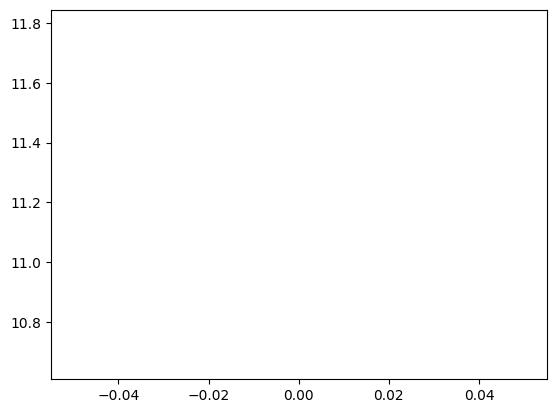

  0%|          | 1/500 [00:00<01:02,  8.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.58350462487152
Dataset Name:  books , AUC Score (contextual):  37.283781033781025
Dataset Name:  books , AUC Score (structural):  44.64444679949132
Dataset Name:  books , AUC Score (joint-type):  54.68559218559219
Dataset Name:  books , AUC Score (structure type):  46.257389106989756
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  38.53276353276353
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.68559218559219
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


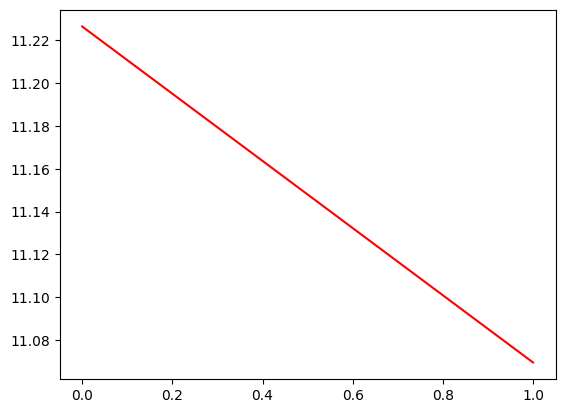

  0%|          | 2/500 [00:00<01:03,  7.82it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.2070914696814
Dataset Name:  books , AUC Score (contextual):  39.054232804232804
Dataset Name:  books , AUC Score (structural):  45.49968206867317
Dataset Name:  books , AUC Score (joint-type):  55.0010175010175
Dataset Name:  books , AUC Score (structure type):  47.040747258697714
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.054232804232804
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.0010175010175
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


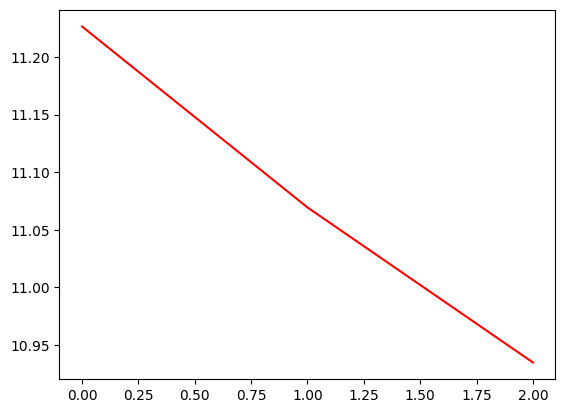

  1%|          | 3/500 [00:00<01:03,  7.84it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.451181911613574
Dataset Name:  books , AUC Score (contextual):  38.81512006512006
Dataset Name:  books , AUC Score (structural):  45.50710046629928
Dataset Name:  books , AUC Score (joint-type):  54.88146113146113
Dataset Name:  books , AUC Score (structure type):  47.02766120662425
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.054232804232804
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.88146113146113
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


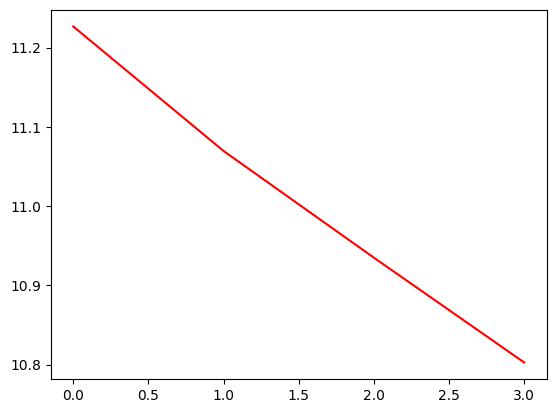

  1%|          | 4/500 [00:00<01:00,  8.26it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.52954779033916
Dataset Name:  books , AUC Score (contextual):  38.588726088726084
Dataset Name:  books , AUC Score (structural):  45.1398897838067
Dataset Name:  books , AUC Score (joint-type):  54.98575498575499
Dataset Name:  books , AUC Score (structure type):  46.730743197509135
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.054232804232804
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.98575498575499
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


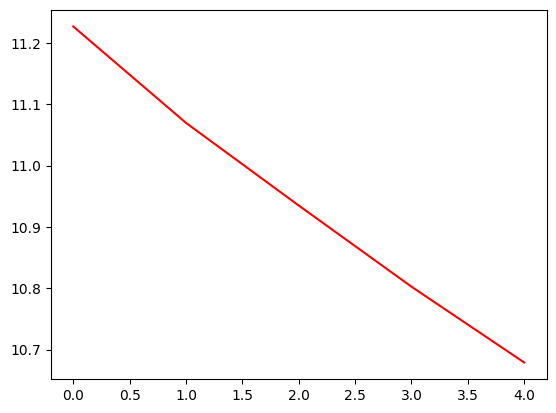

  1%|          | 5/500 [00:00<00:59,  8.37it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.47559095580679
Dataset Name:  books , AUC Score (contextual):  39.76902726902727
Dataset Name:  books , AUC Score (structural):  45.069415006358625
Dataset Name:  books , AUC Score (joint-type):  55.380036630036635
Dataset Name:  books , AUC Score (structure type):  46.74247552005776
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.76902726902727
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.380036630036635
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


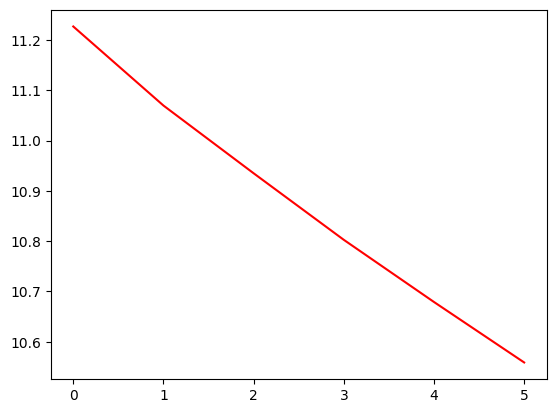

  1%|          | 6/500 [00:00<00:57,  8.55it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.49229188078109
Dataset Name:  books , AUC Score (contextual):  38.96774521774521
Dataset Name:  books , AUC Score (structural):  44.960258584145826
Dataset Name:  books , AUC Score (joint-type):  54.49989824989825
Dataset Name:  books , AUC Score (structure type):  46.496096746536715
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.76902726902727
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.49989824989825
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


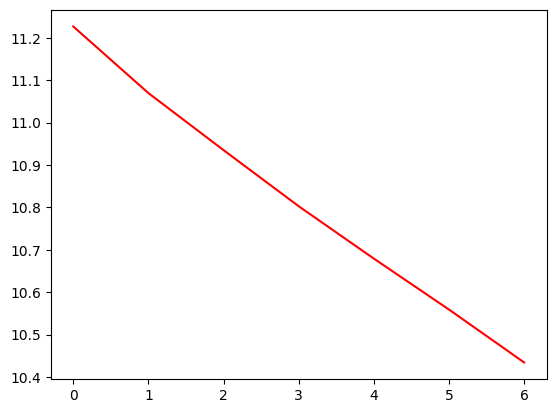

  1%|▏         | 7/500 [00:01<01:38,  5.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.91109969167523
Dataset Name:  books , AUC Score (contextual):  39.08221408221409
Dataset Name:  books , AUC Score (structural):  44.94436201780416
Dataset Name:  books , AUC Score (joint-type):  55.29863654863656
Dataset Name:  books , AUC Score (structure type):  46.62605478092144
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.76902726902727
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.29863654863656
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


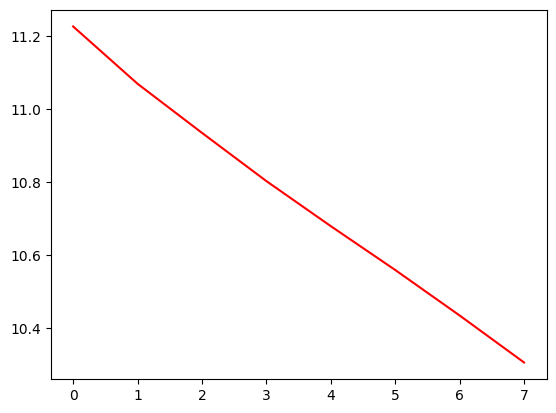

  2%|▏         | 8/500 [00:01<01:25,  5.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.36639260020555
Dataset Name:  books , AUC Score (contextual):  39.369658119658126
Dataset Name:  books , AUC Score (structural):  44.986752861381945
Dataset Name:  books , AUC Score (joint-type):  55.04426129426129
Dataset Name:  books , AUC Score (structure type):  46.61793240377239
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.76902726902727
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.04426129426129
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


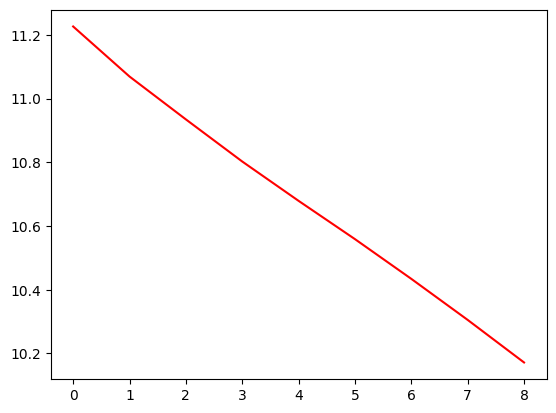

  2%|▏         | 9/500 [00:01<01:16,  6.41it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.50513874614594
Dataset Name:  books , AUC Score (contextual):  38.53276353276353
Dataset Name:  books , AUC Score (structural):  44.97562526494278
Dataset Name:  books , AUC Score (joint-type):  55.443630443630454
Dataset Name:  books , AUC Score (structure type):  46.68652136636434
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.76902726902727
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.443630443630454
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


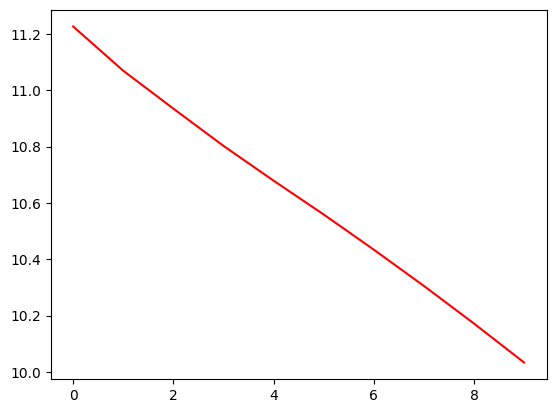

  2%|▏         | 10/500 [00:01<01:09,  7.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.58735868448099
Dataset Name:  books , AUC Score (contextual):  39.061864061864064
Dataset Name:  books , AUC Score (structural):  44.87335735481136
Dataset Name:  books , AUC Score (joint-type):  54.520248270248274
Dataset Name:  books , AUC Score (structure type):  46.437435133793606
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.76902726902727
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.520248270248274
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


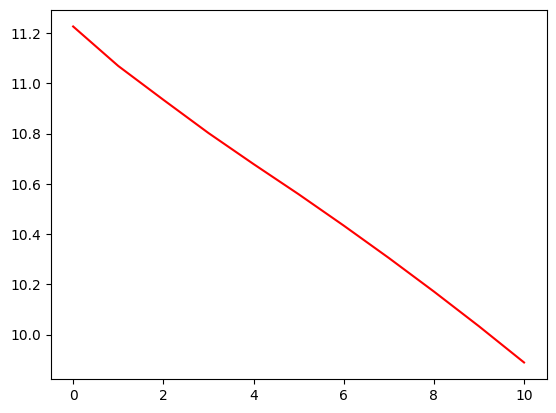

  2%|▏         | 11/500 [00:01<01:05,  7.46it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.33684480986639
Dataset Name:  books , AUC Score (contextual):  39.695258445258446
Dataset Name:  books , AUC Score (structural):  44.90303094531581
Dataset Name:  books , AUC Score (joint-type):  55.90404965404965
Dataset Name:  books , AUC Score (structure type):  46.70908352511168
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.76902726902727
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.90404965404965
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


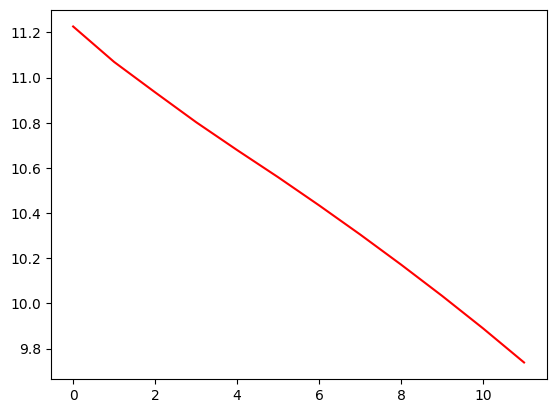

  2%|▏         | 12/500 [00:01<01:04,  7.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.281603288797534
Dataset Name:  books , AUC Score (contextual):  39.90384615384615
Dataset Name:  books , AUC Score (structural):  44.72710894446799
Dataset Name:  books , AUC Score (joint-type):  55.090048840048844
Dataset Name:  books , AUC Score (structure type):  46.415775461396144
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  39.90384615384615
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.090048840048844
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


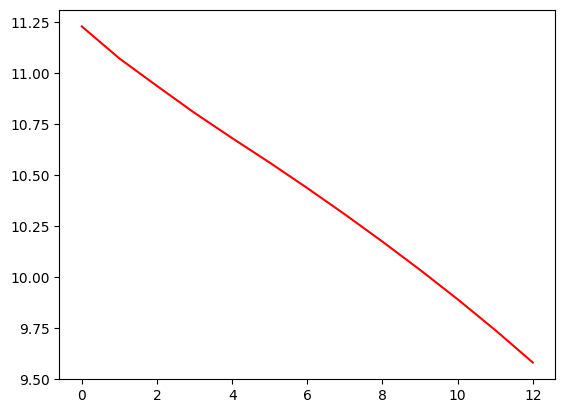

  3%|▎         | 13/500 [00:01<01:03,  7.64it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.3445529290853
Dataset Name:  books , AUC Score (contextual):  40.57030932030932
Dataset Name:  books , AUC Score (structural):  44.78539635438745
Dataset Name:  books , AUC Score (joint-type):  54.82295482295483
Dataset Name:  books , AUC Score (structure type):  46.41803167727088
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.57030932030932
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.82295482295483
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


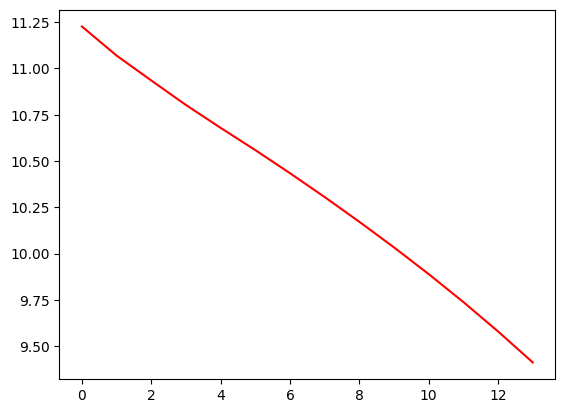

  3%|▎         | 14/500 [00:01<01:03,  7.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.17112024665982
Dataset Name:  books , AUC Score (contextual):  40.69240944240944
Dataset Name:  books , AUC Score (structural):  44.68259855871132
Dataset Name:  books , AUC Score (joint-type):  54.62708587708587
Dataset Name:  books , AUC Score (structure type):  46.29484229051035
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.62708587708587
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


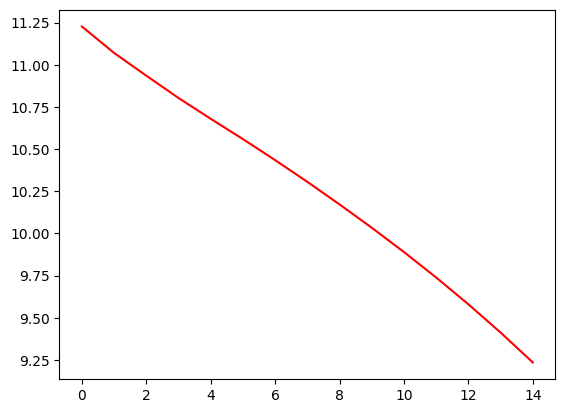

  3%|▎         | 15/500 [00:02<01:03,  7.59it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.13643371017472
Dataset Name:  books , AUC Score (contextual):  40.198921448921446
Dataset Name:  books , AUC Score (structural):  44.48654090716405
Dataset Name:  books , AUC Score (joint-type):  54.38797313797315
Dataset Name:  books , AUC Score (structure type):  46.08636794368485
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.38797313797315
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


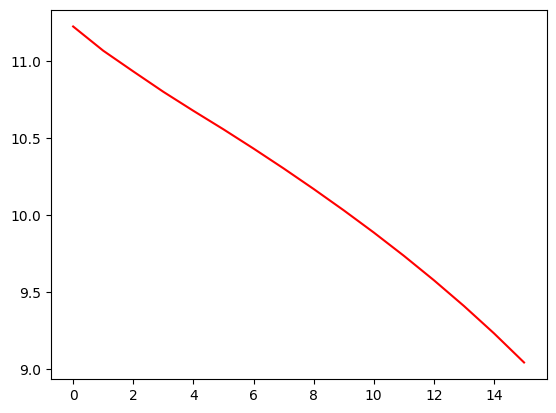

  3%|▎         | 16/500 [00:02<01:01,  7.90it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.13514902363823
Dataset Name:  books , AUC Score (contextual):  40.56267806267807
Dataset Name:  books , AUC Score (structural):  44.35459940652819
Dataset Name:  books , AUC Score (joint-type):  54.471916971916976
Dataset Name:  books , AUC Score (structure type):  45.9888994178963
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.471916971916976
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


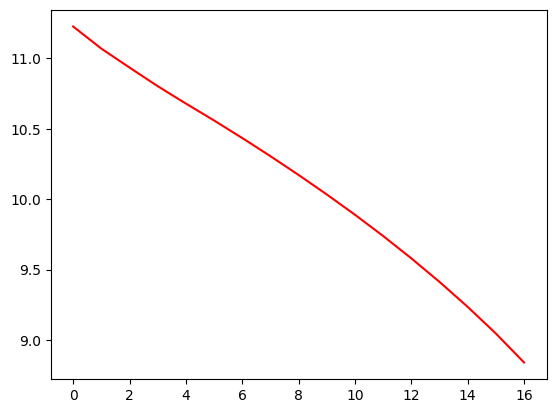

  3%|▎         | 17/500 [00:02<00:59,  8.07it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.23021582733813
Dataset Name:  books , AUC Score (contextual):  40.359177859177855
Dataset Name:  books , AUC Score (structural):  44.37897414158542
Dataset Name:  books , AUC Score (joint-type):  54.37016687016687
Dataset Name:  books , AUC Score (structure type):  45.99160687694599
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.37016687016687
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


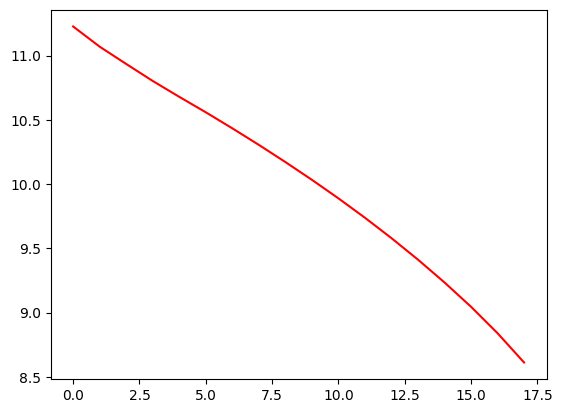

  4%|▎         | 18/500 [00:02<00:59,  8.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.26104830421377
Dataset Name:  books , AUC Score (contextual):  40.38461538461539
Dataset Name:  books , AUC Score (structural):  44.40228910555321
Dataset Name:  books , AUC Score (joint-type):  54.18192918192919
Dataset Name:  books , AUC Score (structure type):  45.97897206804747
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.18192918192919
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


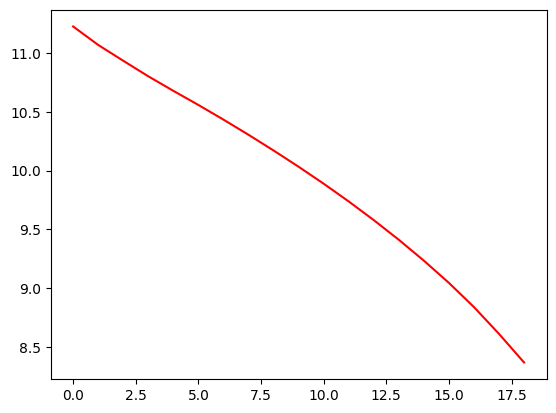

  4%|▍         | 19/500 [00:02<00:58,  8.28it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.32528263103802
Dataset Name:  books , AUC Score (contextual):  40.17094017094017
Dataset Name:  books , AUC Score (structural):  44.096015260703695
Dataset Name:  books , AUC Score (joint-type):  54.359991859991865
Dataset Name:  books , AUC Score (structure type):  45.75154550787419
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.359991859991865
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


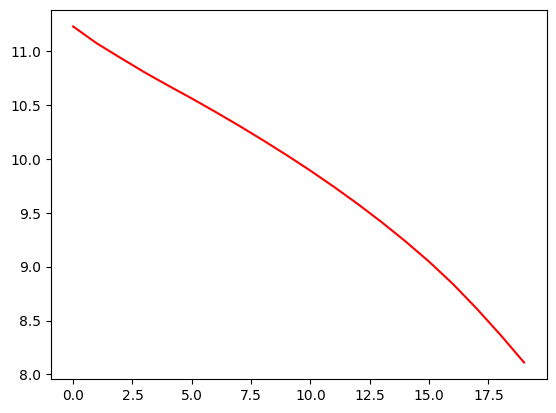

  4%|▍         | 20/500 [00:02<00:57,  8.30it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.7672147995889
Dataset Name:  books , AUC Score (contextual):  39.99287749287749
Dataset Name:  books , AUC Score (structural):  44.182916490038146
Dataset Name:  books , AUC Score (joint-type):  53.739316239316246
Dataset Name:  books , AUC Score (structure type):  45.71273859482876
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  53.739316239316246
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


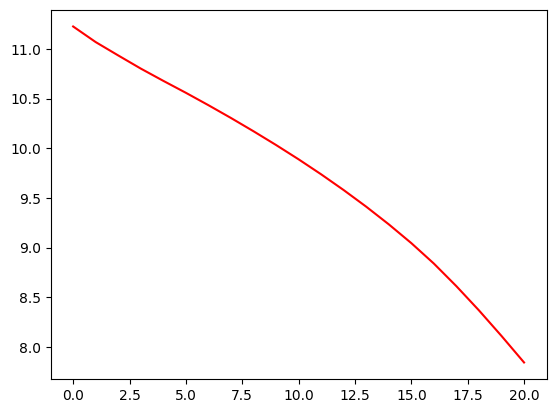

  4%|▍         | 21/500 [00:02<00:57,  8.30it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  42.96248715313464
Dataset Name:  books , AUC Score (contextual):  40.27777777777778
Dataset Name:  books , AUC Score (structural):  44.21788893598983
Dataset Name:  books , AUC Score (joint-type):  53.266178266178265
Dataset Name:  books , AUC Score (structure type):  45.65858941383512
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  53.266178266178265
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


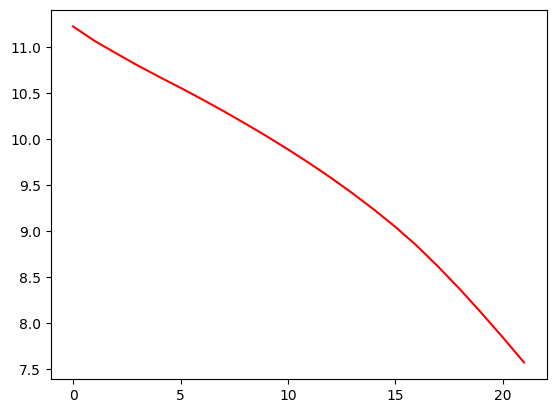

  4%|▍         | 22/500 [00:02<00:56,  8.41it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  43.1294964028777
Dataset Name:  books , AUC Score (contextual):  40.62372812372812
Dataset Name:  books , AUC Score (structural):  44.18503603221704
Dataset Name:  books , AUC Score (joint-type):  53.15425315425315
Dataset Name:  books , AUC Score (structure type):  45.60083028744191
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  53.15425315425315
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


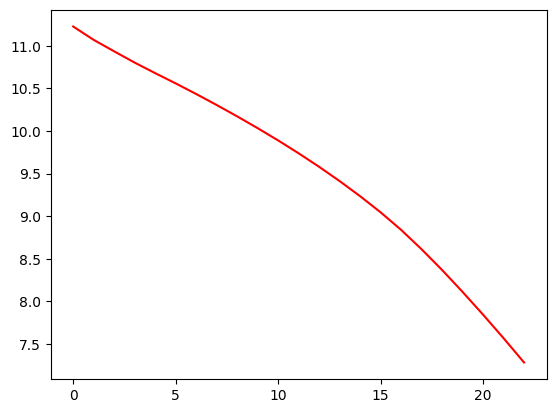

  5%|▍         | 23/500 [00:03<00:56,  8.46it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  43.25282631038026
Dataset Name:  books , AUC Score (contextual):  40.68477818477818
Dataset Name:  books , AUC Score (structural):  44.19457397202204
Dataset Name:  books , AUC Score (joint-type):  52.96601546601547
Dataset Name:  books , AUC Score (structure type):  45.568340778845716
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  52.96601546601547
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


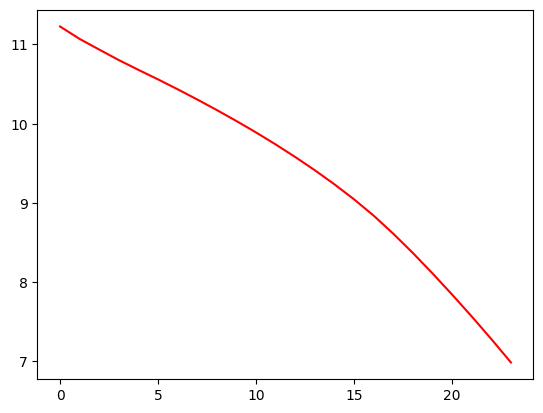

  5%|▍         | 24/500 [00:03<00:54,  8.73it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  43.58941418293936
Dataset Name:  books , AUC Score (contextual):  40.23707773707774
Dataset Name:  books , AUC Score (structural):  44.27935565917762
Dataset Name:  books , AUC Score (joint-type):  52.83374033374033
Dataset Name:  books , AUC Score (structure type):  45.62158747348947
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  52.83374033374033
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


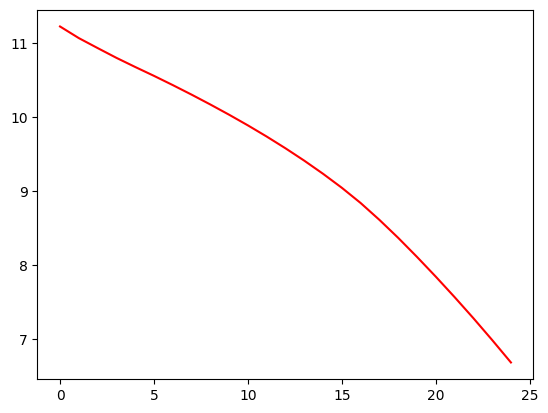

  5%|▌         | 25/500 [00:03<00:53,  8.88it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  44.1469681397739
Dataset Name:  books , AUC Score (contextual):  39.37728937728938
Dataset Name:  books , AUC Score (structural):  44.22318779143705
Dataset Name:  books , AUC Score (joint-type):  52.27920227920227
Dataset Name:  books , AUC Score (structure type):  45.50697170705293
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.802158273381295
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  52.27920227920227
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


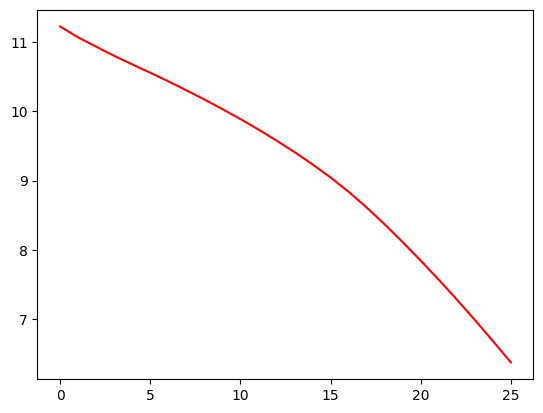

  5%|▌         | 26/500 [00:03<00:52,  9.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  44.930626927029806
Dataset Name:  books , AUC Score (contextual):  39.50956450956451
Dataset Name:  books , AUC Score (structural):  43.7547689699025
Dataset Name:  books , AUC Score (joint-type):  52.971102971102965
Dataset Name:  books , AUC Score (structure type):  45.235323315734846
Dataset Name:  books  Best AUC Score(benchmark/combined):  44.930626927029806
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  52.971102971102965
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


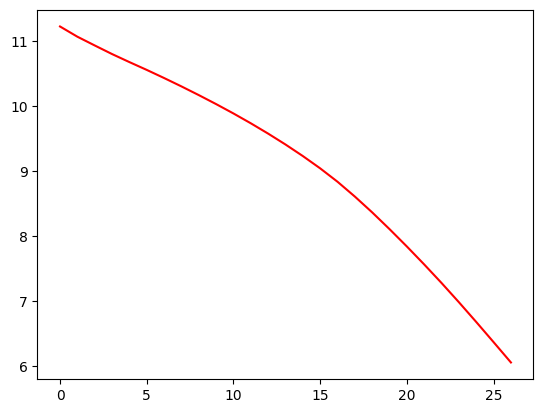

  5%|▌         | 27/500 [00:03<00:52,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  45.082219938335044
Dataset Name:  books , AUC Score (contextual):  39.4993894993895
Dataset Name:  books , AUC Score (structural):  43.7049597286986
Dataset Name:  books , AUC Score (joint-type):  53.2967032967033
Dataset Name:  books , AUC Score (structure type):  45.233518343035065
Dataset Name:  books  Best AUC Score(benchmark/combined):  45.082219938335044
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  53.2967032967033
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


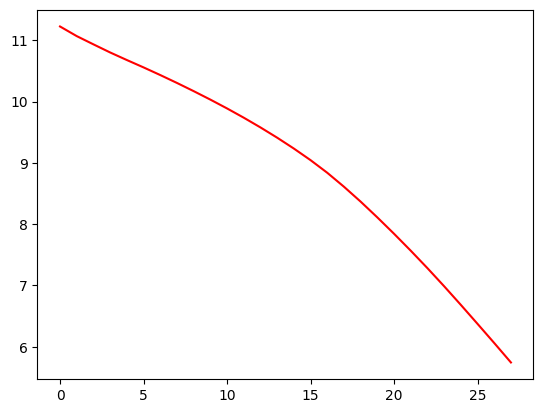

  6%|▌         | 28/500 [00:03<00:52,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  45.18242548818088
Dataset Name:  books , AUC Score (contextual):  40.09971509971509
Dataset Name:  books , AUC Score (structural):  43.64773208986858
Dataset Name:  books , AUC Score (joint-type):  53.59177859177859
Dataset Name:  books , AUC Score (structure type):  45.20554126618835
Dataset Name:  books  Best AUC Score(benchmark/combined):  45.18242548818088
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  53.59177859177859
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


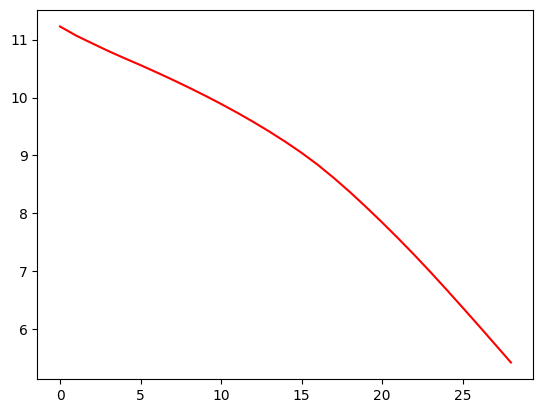

  6%|▌         | 29/500 [00:03<00:53,  8.85it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  47.01181911613566
Dataset Name:  books , AUC Score (contextual):  40.26760276760277
Dataset Name:  books , AUC Score (structural):  43.29376854599407
Dataset Name:  books , AUC Score (joint-type):  54.227716727716725
Dataset Name:  books , AUC Score (structure type):  44.99616443301294
Dataset Name:  books  Best AUC Score(benchmark/combined):  47.01181911613566
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  54.227716727716725
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


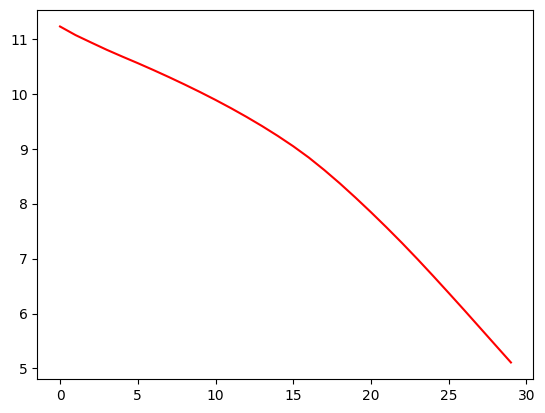

  6%|▌         | 30/500 [00:03<00:54,  8.68it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  48.427543679342236
Dataset Name:  books , AUC Score (contextual):  40.50671550671551
Dataset Name:  books , AUC Score (structural):  43.17825349724459
Dataset Name:  books , AUC Score (joint-type):  55.15873015873015
Dataset Name:  books , AUC Score (structure type):  45.05753350480574
Dataset Name:  books  Best AUC Score(benchmark/combined):  48.427543679342236
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.15873015873015
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


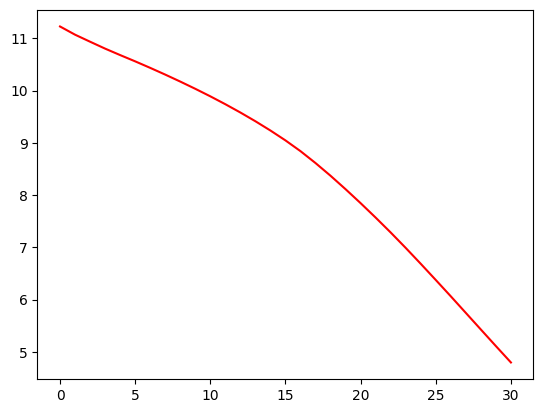

  6%|▌         | 31/500 [00:03<00:53,  8.71it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  48.91829393627955
Dataset Name:  books , AUC Score (contextual):  39.95726495726496
Dataset Name:  books , AUC Score (structural):  43.42094107672743
Dataset Name:  books , AUC Score (joint-type):  55.265567765567766
Dataset Name:  books , AUC Score (structure type):  45.32557195072425
Dataset Name:  books  Best AUC Score(benchmark/combined):  48.91829393627955
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.265567765567766
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


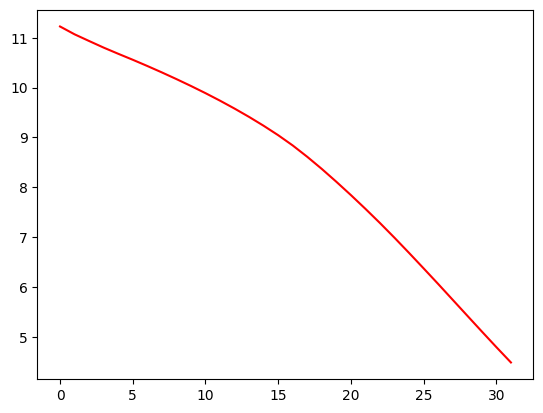

  6%|▋         | 32/500 [00:04<00:53,  8.82it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  50.431654676258994
Dataset Name:  books , AUC Score (contextual):  38.65995115995116
Dataset Name:  books , AUC Score (structural):  43.48770665536244
Dataset Name:  books , AUC Score (joint-type):  56.043956043956044
Dataset Name:  books , AUC Score (structure type):  45.53043635215018
Dataset Name:  books  Best AUC Score(benchmark/combined):  50.431654676258994
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  56.043956043956044
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


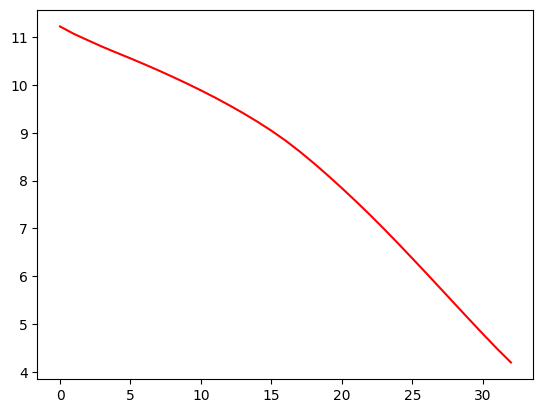

  7%|▋         | 33/500 [00:04<00:53,  8.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  52.81860226104831
Dataset Name:  books , AUC Score (contextual):  38.44627594627595
Dataset Name:  books , AUC Score (structural):  42.37282746926664
Dataset Name:  books , AUC Score (joint-type):  55.64713064713065
Dataset Name:  books , AUC Score (structure type):  44.488064618022655
Dataset Name:  books  Best AUC Score(benchmark/combined):  52.81860226104831
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.64713064713065
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


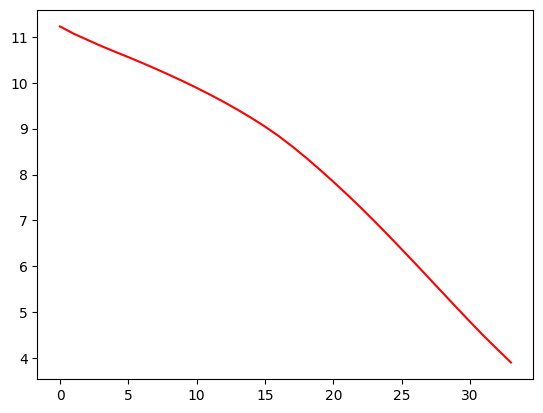

  7%|▋         | 34/500 [00:04<00:52,  8.84it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  54.68653648509765
Dataset Name:  books , AUC Score (contextual):  38.04436304436304
Dataset Name:  books , AUC Score (structural):  41.805849936413736
Dataset Name:  books , AUC Score (joint-type):  55.036630036630044
Dataset Name:  books , AUC Score (structure type):  43.88791119534318
Dataset Name:  books  Best AUC Score(benchmark/combined):  54.68653648509765
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  55.036630036630044
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


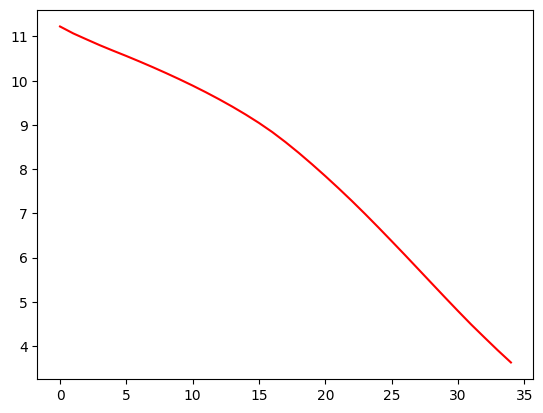

  7%|▋         | 35/500 [00:04<00:52,  8.84it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  55.54984583761562
Dataset Name:  books , AUC Score (contextual):  39.84025234025234
Dataset Name:  books , AUC Score (structural):  41.982831708351
Dataset Name:  books , AUC Score (joint-type):  53.495115995115995
Dataset Name:  books , AUC Score (structure type):  43.89061865439285
Dataset Name:  books  Best AUC Score(benchmark/combined):  55.54984583761562
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  53.495115995115995
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


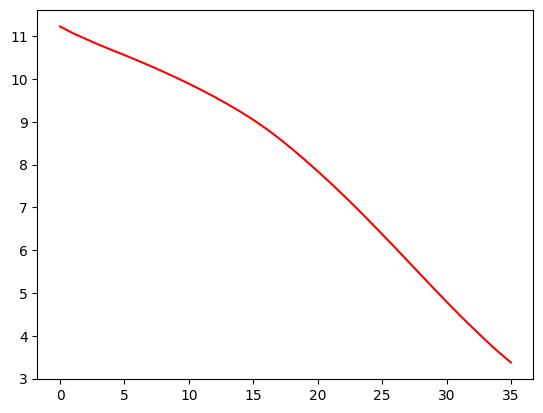

  7%|▋         | 36/500 [00:04<00:53,  8.73it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  56.45940390544707
Dataset Name:  books , AUC Score (contextual):  39.47395197395197
Dataset Name:  books , AUC Score (structural):  42.64518863925392
Dataset Name:  books , AUC Score (joint-type):  51.97395197395198
Dataset Name:  books , AUC Score (structure type):  44.22273363115383
Dataset Name:  books  Best AUC Score(benchmark/combined):  56.45940390544707
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  51.97395197395198
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


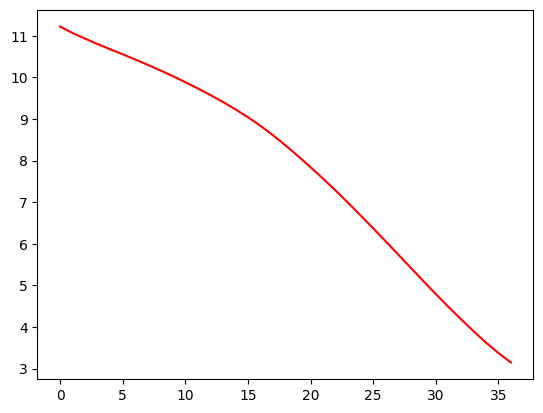

  7%|▋         | 37/500 [00:04<00:53,  8.63it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  58.543165467625904
Dataset Name:  books , AUC Score (contextual):  39.75376475376475
Dataset Name:  books , AUC Score (structural):  43.433658329800764
Dataset Name:  books , AUC Score (joint-type):  50.773300773300775
Dataset Name:  books , AUC Score (structure type):  44.68480664229953
Dataset Name:  books  Best AUC Score(benchmark/combined):  58.543165467625904
Dataset Name:  books  Best AUC Score (contextual):  40.69240944240944
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  50.773300773300775
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


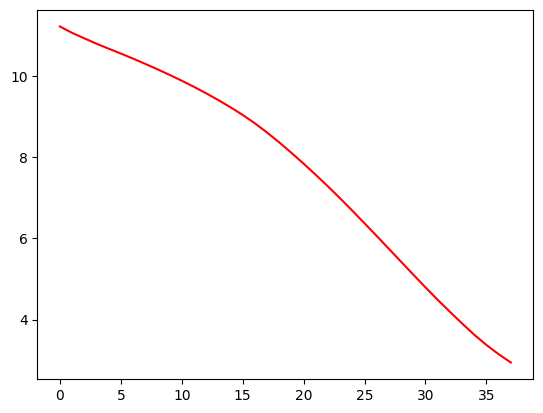

  8%|▊         | 38/500 [00:04<00:51,  8.92it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.98406988694758
Dataset Name:  books , AUC Score (contextual):  41.351241351241356
Dataset Name:  books , AUC Score (structural):  44.15854175498093
Dataset Name:  books , AUC Score (joint-type):  48.76373626373627
Dataset Name:  books , AUC Score (structure type):  45.0322638870087
Dataset Name:  books  Best AUC Score(benchmark/combined):  60.98406988694758
Dataset Name:  books  Best AUC Score (contextual):  41.351241351241356
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  48.76373626373627
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


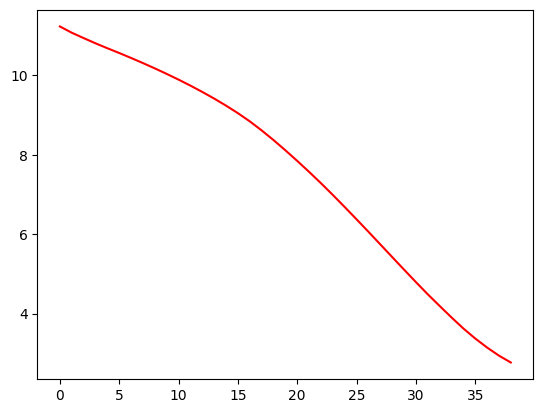

  8%|▊         | 39/500 [00:04<00:50,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.33042137718397
Dataset Name:  books , AUC Score (contextual):  42.699430199430196
Dataset Name:  books , AUC Score (structural):  44.635438745231035
Dataset Name:  books , AUC Score (joint-type):  47.863247863247864
Dataset Name:  books , AUC Score (structure type):  45.43387031271152
Dataset Name:  books  Best AUC Score(benchmark/combined):  62.33042137718397
Dataset Name:  books  Best AUC Score (contextual):  42.699430199430196
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  47.863247863247864
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


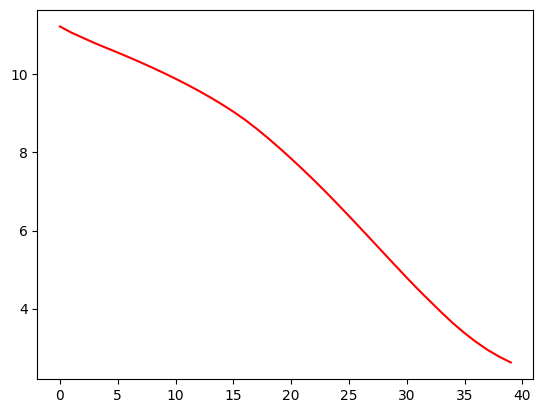

  8%|▊         | 40/500 [00:04<00:50,  9.20it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.98561151079137
Dataset Name:  books , AUC Score (contextual):  45.187220187220184
Dataset Name:  books , AUC Score (structural):  45.121873675286125
Dataset Name:  books , AUC Score (joint-type):  46.94749694749695
Dataset Name:  books , AUC Score (structure type):  45.71905599927801
Dataset Name:  books  Best AUC Score(benchmark/combined):  62.98561151079137
Dataset Name:  books  Best AUC Score (contextual):  45.187220187220184
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  46.94749694749695
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


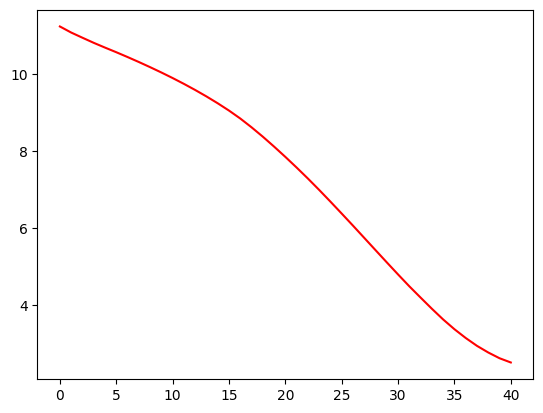

  8%|▊         | 41/500 [00:05<00:49,  9.30it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.50668036998972
Dataset Name:  books , AUC Score (contextual):  44.65811965811965
Dataset Name:  books , AUC Score (structural):  45.28295888088173
Dataset Name:  books , AUC Score (joint-type):  46.11314611314611
Dataset Name:  books , AUC Score (structure type):  45.68566400433194
Dataset Name:  books  Best AUC Score(benchmark/combined):  64.50668036998972
Dataset Name:  books  Best AUC Score (contextual):  45.187220187220184
Dataset Name:  books  Best AUC Score (structural):  45.791649003815174
Dataset Name:  books  Best AUC Score (joint-type):  46.11314611314611
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


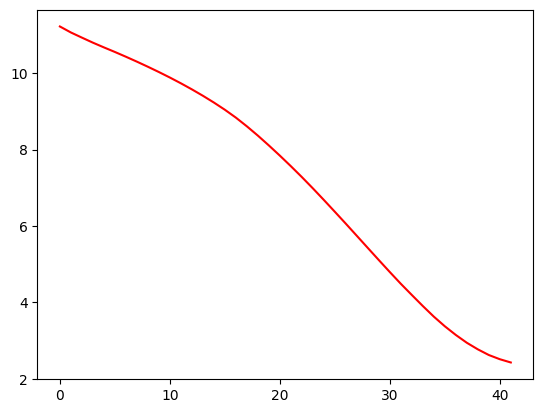

Dataset Name:  books , AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books , AUC Score (contextual):  46.73382173382173
Dataset Name:  books , AUC Score (structural):  45.809665112335736
Dataset Name:  books , AUC Score (joint-type):  46.97293447293447
Dataset Name:  books , AUC Score (structure type):  46.31289201750823
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  46.73382173382173
Dataset Name:  books  Best AUC Score (structural):  45.809665112335736
Dataset Name:  books  Best AUC Score (joint-type):  46.97293447293447
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


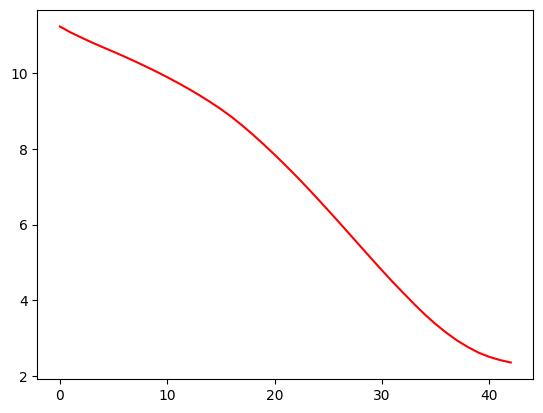

  9%|▊         | 43/500 [00:05<00:46,  9.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.04933196300102
Dataset Name:  books , AUC Score (contextual):  48.11253561253561
Dataset Name:  books , AUC Score (structural):  44.93429419245443
Dataset Name:  books , AUC Score (joint-type):  46.06735856735857
Dataset Name:  books , AUC Score (structure type):  45.43748025811109
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  48.11253561253561
Dataset Name:  books  Best AUC Score (structural):  45.809665112335736
Dataset Name:  books  Best AUC Score (joint-type):  46.06735856735857
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


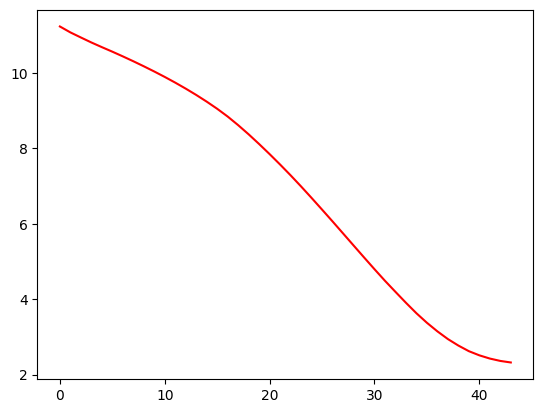

Dataset Name:  books , AUC Score(benchmark/combined):  63.81551901336074
Dataset Name:  books , AUC Score (contextual):  50.06105006105006
Dataset Name:  books , AUC Score (structural):  44.55383637134379
Dataset Name:  books , AUC Score (joint-type):  44.525844525844526
Dataset Name:  books , AUC Score (structure type):  44.83913180813139
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  50.06105006105006
Dataset Name:  books  Best AUC Score (structural):  45.809665112335736
Dataset Name:  books  Best AUC Score (joint-type):  44.525844525844526
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


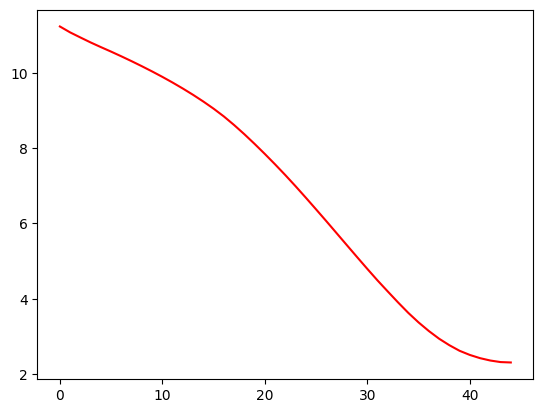

  9%|▉         | 45/500 [00:05<00:45,  9.97it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.86228160328881
Dataset Name:  books , AUC Score (contextual):  53.14916564916565
Dataset Name:  books , AUC Score (structural):  45.18863925392115
Dataset Name:  books , AUC Score (joint-type):  44.51566951566952
Dataset Name:  books , AUC Score (structure type):  45.340011732322544
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  53.14916564916565
Dataset Name:  books  Best AUC Score (structural):  45.809665112335736
Dataset Name:  books  Best AUC Score (joint-type):  44.51566951566952
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


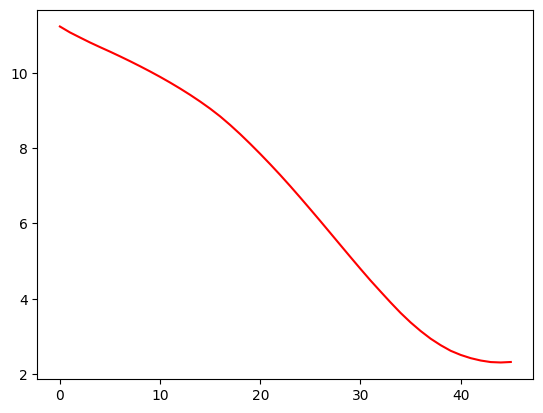

Dataset Name:  books , AUC Score(benchmark/combined):  62.23535457348407
Dataset Name:  books , AUC Score (contextual):  53.545991045991045
Dataset Name:  books , AUC Score (structural):  44.99046206019499
Dataset Name:  books , AUC Score (joint-type):  44.66829466829466
Dataset Name:  books , AUC Score (structure type):  45.24976309733315
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  53.545991045991045
Dataset Name:  books  Best AUC Score (structural):  45.809665112335736
Dataset Name:  books  Best AUC Score (joint-type):  44.66829466829466
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


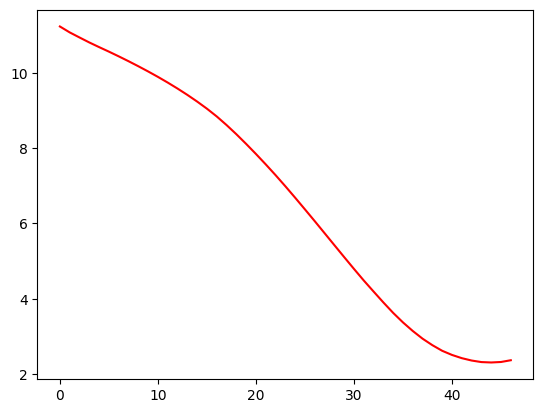

  9%|▉         | 47/500 [00:05<00:44, 10.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.127440904419316
Dataset Name:  books , AUC Score (contextual):  56.740944240944245
Dataset Name:  books , AUC Score (structural):  45.9272997032641
Dataset Name:  books , AUC Score (joint-type):  45.136345136345135
Dataset Name:  books , AUC Score (structure type):  46.14232209737828
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  56.740944240944245
Dataset Name:  books  Best AUC Score (structural):  45.9272997032641
Dataset Name:  books  Best AUC Score (joint-type):  45.136345136345135
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


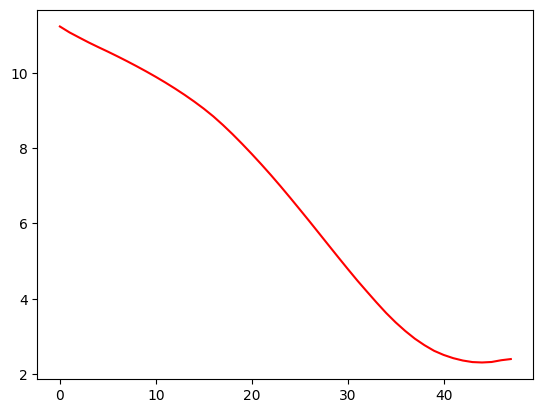

Dataset Name:  books , AUC Score(benchmark/combined):  62.06577595066805
Dataset Name:  books , AUC Score (contextual):  58.64367114367115
Dataset Name:  books , AUC Score (structural):  46.17952522255193
Dataset Name:  books , AUC Score (joint-type):  45.13125763125763
Dataset Name:  books , AUC Score (structure type):  46.40223816614773
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.17952522255193
Dataset Name:  books  Best AUC Score (joint-type):  45.13125763125763
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


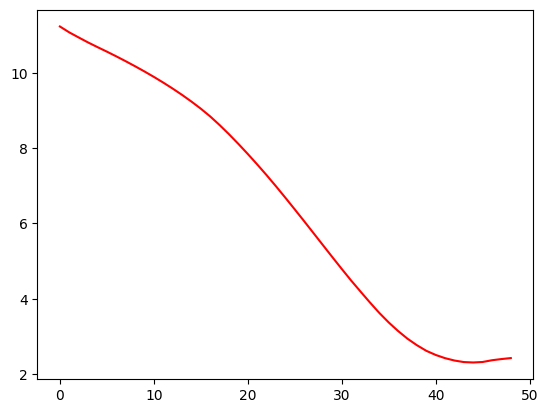

 10%|▉         | 49/500 [00:05<00:44, 10.17it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.72610483042138
Dataset Name:  books , AUC Score (contextual):  57.17846967846969
Dataset Name:  books , AUC Score (structural):  45.302034760491736
Dataset Name:  books , AUC Score (joint-type):  43.25396825396825
Dataset Name:  books , AUC Score (structure type):  45.42394296286268
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.17952522255193
Dataset Name:  books  Best AUC Score (joint-type):  43.25396825396825
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


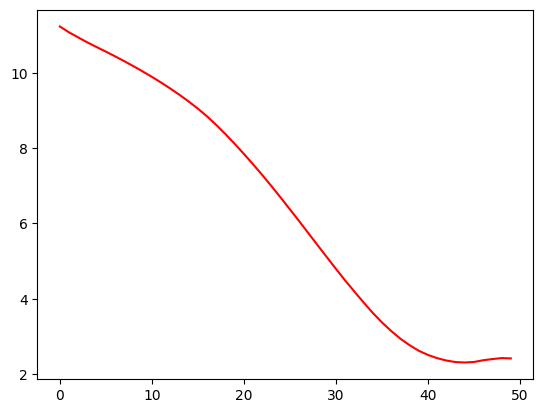

Dataset Name:  books , AUC Score(benchmark/combined):  63.5688591983556
Dataset Name:  books , AUC Score (contextual):  57.75335775335775
Dataset Name:  books , AUC Score (structural):  45.90398473929631
Dataset Name:  books , AUC Score (joint-type):  44.846357346357344
Dataset Name:  books , AUC Score (structure type):  46.189251387572774
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.17952522255193
Dataset Name:  books  Best AUC Score (joint-type):  44.846357346357344
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


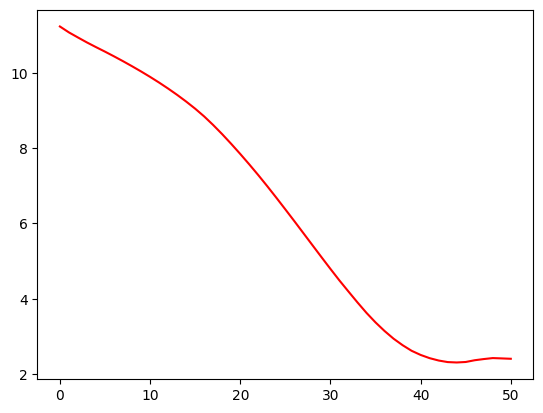

 10%|█         | 51/500 [00:05<00:44, 10.14it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.37050359712231
Dataset Name:  books , AUC Score (contextual):  56.623931623931625
Dataset Name:  books , AUC Score (structural):  46.54408647732089
Dataset Name:  books , AUC Score (joint-type):  43.3048433048433
Dataset Name:  books , AUC Score (structure type):  46.3787735210505
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.3048433048433
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


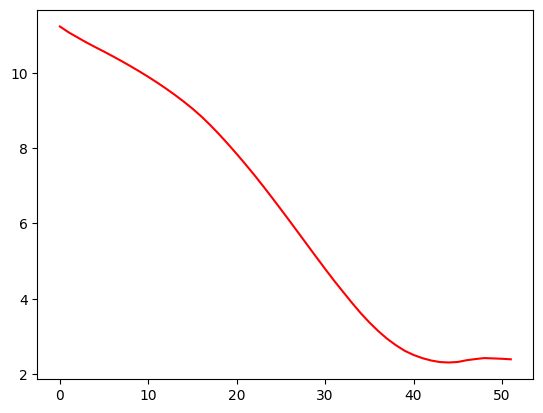

Dataset Name:  books , AUC Score(benchmark/combined):  64.96916752312436
Dataset Name:  books , AUC Score (contextual):  54.11070411070411
Dataset Name:  books , AUC Score (structural):  45.55108096651123
Dataset Name:  books , AUC Score (joint-type):  45.68070818070818
Dataset Name:  books , AUC Score (structure type):  45.952799963900546
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.68070818070818
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


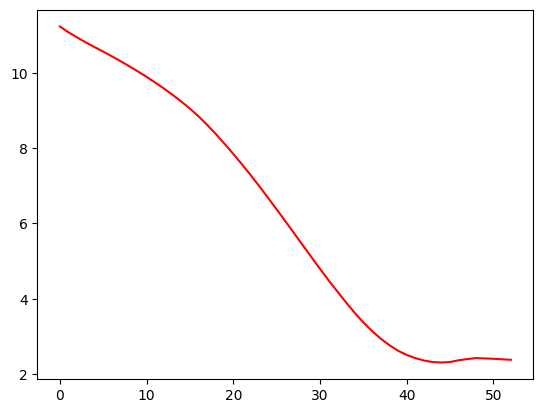

 11%|█         | 53/500 [00:06<00:44, 10.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.54008221993833
Dataset Name:  books , AUC Score (contextual):  52.17236467236468
Dataset Name:  books , AUC Score (structural):  44.744595167443826
Dataset Name:  books , AUC Score (joint-type):  44.17989417989418
Dataset Name:  books , AUC Score (structure type):  44.93299038852038
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.17989417989418
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


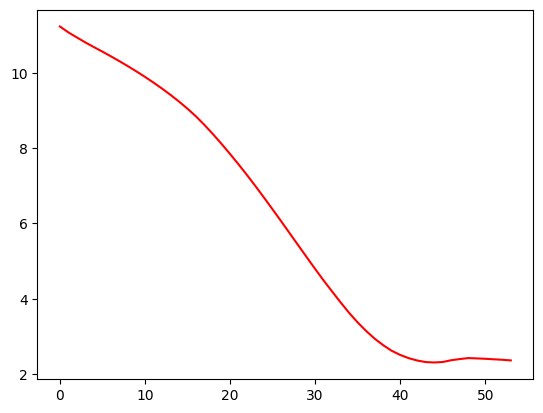

Dataset Name:  books , AUC Score(benchmark/combined):  64.4141829393628
Dataset Name:  books , AUC Score (contextual):  54.01912901912902
Dataset Name:  books , AUC Score (structural):  43.80563798219585
Dataset Name:  books , AUC Score (joint-type):  42.312779812779816
Dataset Name:  books , AUC Score (structure type):  43.79856504670367
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.312779812779816
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


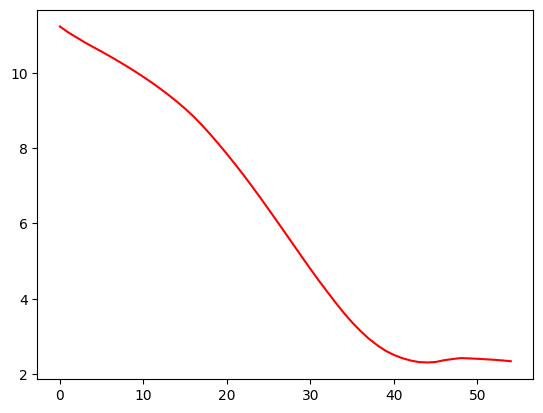

 11%|█         | 55/500 [00:06<01:01,  7.28it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.568345323741
Dataset Name:  books , AUC Score (contextual):  54.70594220594221
Dataset Name:  books , AUC Score (structural):  44.03772785078423
Dataset Name:  books , AUC Score (joint-type):  44.3986568986569
Dataset Name:  books , AUC Score (structure type):  44.393303551283786
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.3986568986569
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


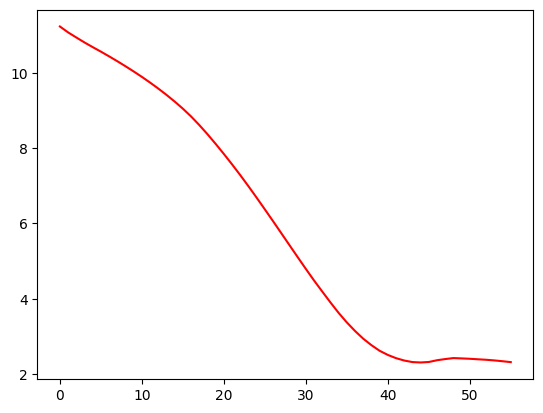

 11%|█         | 56/500 [00:06<00:58,  7.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.3448098663926
Dataset Name:  books , AUC Score (contextual):  54.9043549043549
Dataset Name:  books , AUC Score (structural):  44.18185671894871
Dataset Name:  books , AUC Score (joint-type):  44.92775742775743
Dataset Name:  books , AUC Score (structure type):  44.629754974956
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.92775742775743
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


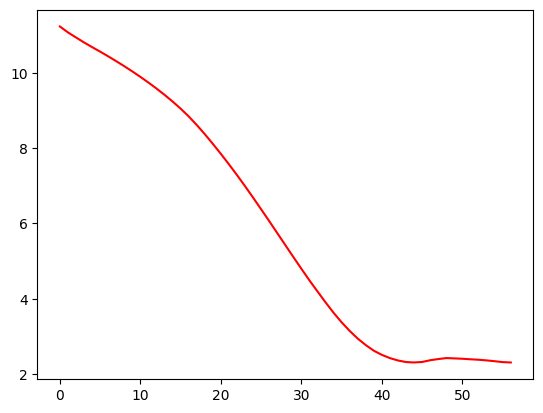

Dataset Name:  books , AUC Score(benchmark/combined):  64.15981500513874
Dataset Name:  books , AUC Score (contextual):  55.04171754171754
Dataset Name:  books , AUC Score (structural):  44.05256464603645
Dataset Name:  books , AUC Score (joint-type):  43.70675620675621
Dataset Name:  books , AUC Score (structure type):  44.3012499435946
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.70675620675621
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


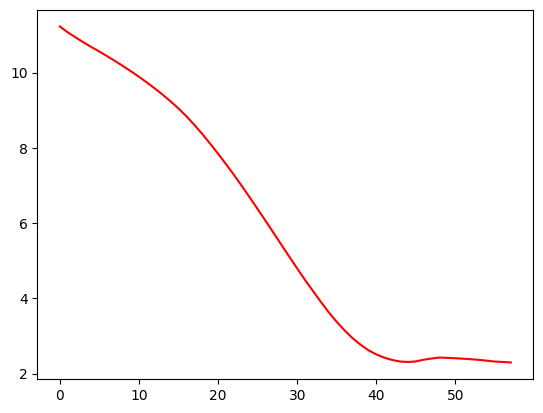

 12%|█▏        | 58/500 [00:06<00:53,  8.33it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.45015416238438
Dataset Name:  books , AUC Score (contextual):  54.03947903947903
Dataset Name:  books , AUC Score (structural):  43.862865621025854
Dataset Name:  books , AUC Score (joint-type):  41.08160358160359
Dataset Name:  books , AUC Score (structure type):  43.66950949866884
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.08160358160359
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


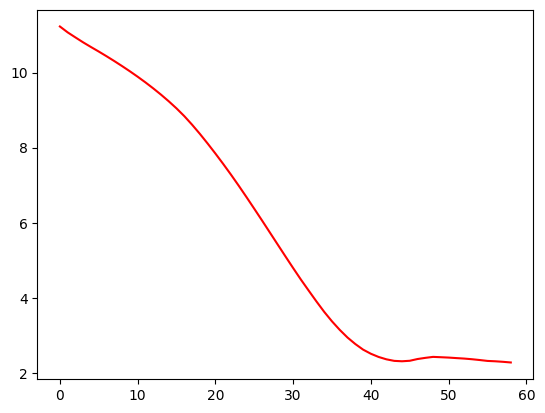

 12%|█▏        | 59/500 [00:07<00:51,  8.57it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.34480986639261
Dataset Name:  books , AUC Score (contextual):  52.207977207977216
Dataset Name:  books , AUC Score (structural):  43.85650699448919
Dataset Name:  books , AUC Score (joint-type):  39.57061457061457
Dataset Name:  books , AUC Score (structure type):  43.3915437029015
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  39.57061457061457
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


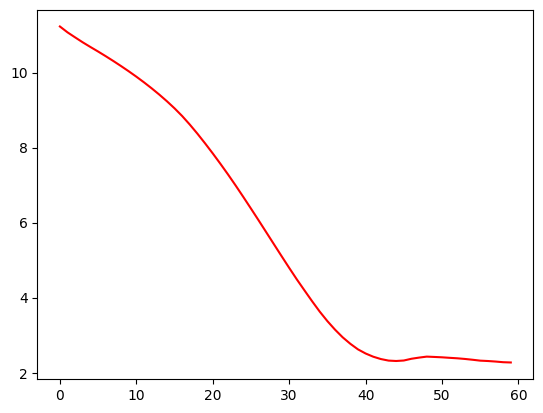

 12%|█▏        | 60/500 [00:07<00:49,  8.81it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.21891058581706
Dataset Name:  books , AUC Score (contextual):  51.521164021164026
Dataset Name:  books , AUC Score (structural):  43.66256888512081
Dataset Name:  books , AUC Score (joint-type):  39.931827431827436
Dataset Name:  books , AUC Score (structure type):  43.29227020441315
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  39.931827431827436
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


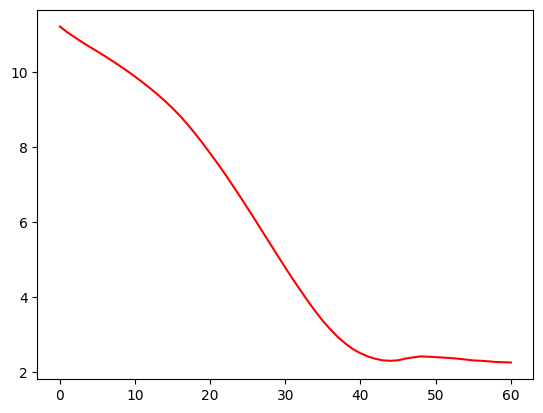

 12%|█▏        | 61/500 [00:07<00:48,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.14182939362796
Dataset Name:  books , AUC Score (contextual):  51.36853886853887
Dataset Name:  books , AUC Score (structural):  43.401865197117424
Dataset Name:  books , AUC Score (joint-type):  37.92226292226292
Dataset Name:  books , AUC Score (structure type):  42.72189883128018
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  37.92226292226292
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


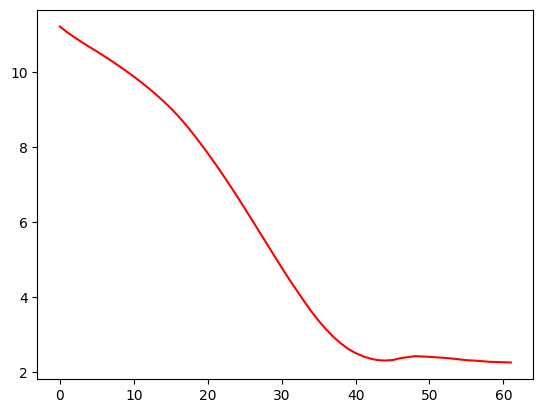

 12%|█▏        | 62/500 [00:07<00:47,  9.24it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.2497430626927
Dataset Name:  books , AUC Score (contextual):  51.05820105820106
Dataset Name:  books , AUC Score (structural):  43.531157270029674
Dataset Name:  books , AUC Score (joint-type):  40.52706552706552
Dataset Name:  books , AUC Score (structure type):  43.28775777266368
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.52706552706552
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


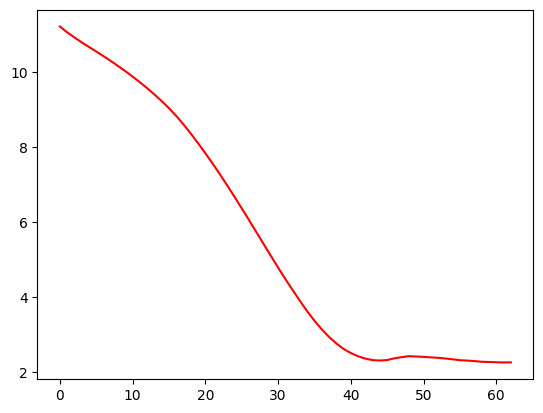

 13%|█▎        | 63/500 [00:07<00:46,  9.37it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.06731757451183
Dataset Name:  books , AUC Score (contextual):  49.37932437932438
Dataset Name:  books , AUC Score (structural):  43.384908859686306
Dataset Name:  books , AUC Score (joint-type):  41.335978835978835
Dataset Name:  books , AUC Score (structure type):  43.25978069581697
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.335978835978835
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


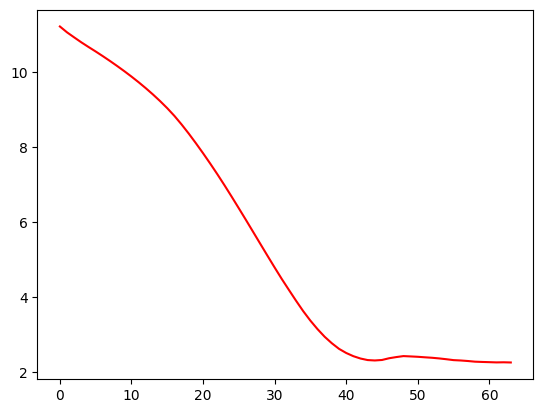

 13%|█▎        | 64/500 [00:07<00:45,  9.52it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.15210688591984
Dataset Name:  books , AUC Score (contextual):  50.38665038665038
Dataset Name:  books , AUC Score (structural):  43.40504451038576
Dataset Name:  books , AUC Score (joint-type):  41.38176638176638
Dataset Name:  books , AUC Score (structure type):  43.224583728171105
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.38176638176638
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


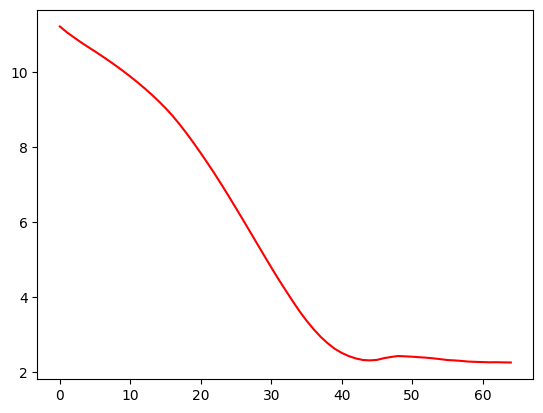

 13%|█▎        | 65/500 [00:07<00:45,  9.56it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.2754367934224
Dataset Name:  books , AUC Score (contextual):  49.98982498982499
Dataset Name:  books , AUC Score (structural):  43.38490885968631
Dataset Name:  books , AUC Score (joint-type):  42.139804639804645
Dataset Name:  books , AUC Score (structure type):  43.30851495871125
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.139804639804645
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


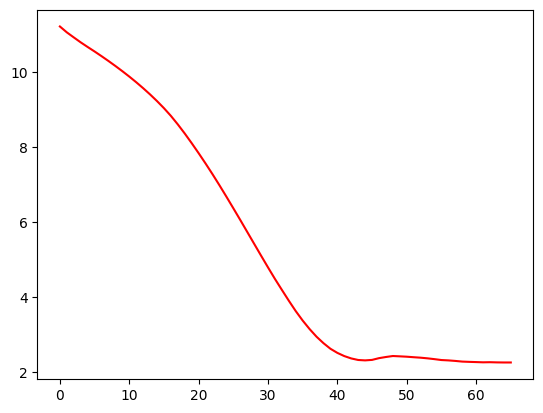

 13%|█▎        | 66/500 [00:07<00:44,  9.66it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.70195272353546
Dataset Name:  books , AUC Score (contextual):  50.712250712250714
Dataset Name:  books , AUC Score (structural):  43.068037303942354
Dataset Name:  books , AUC Score (joint-type):  41.53947903947904
Dataset Name:  books , AUC Score (structure type):  42.86629664726321
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.53947903947904
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


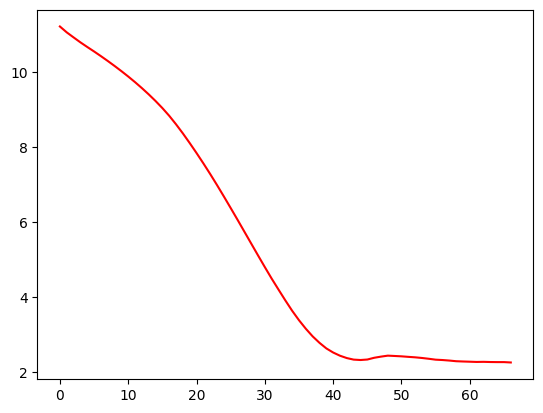

 13%|█▎        | 67/500 [00:07<00:44,  9.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.9486125385406
Dataset Name:  books , AUC Score (contextual):  51.3074888074888
Dataset Name:  books , AUC Score (structural):  43.13586265366681
Dataset Name:  books , AUC Score (joint-type):  40.71530321530321
Dataset Name:  books , AUC Score (structure type):  42.75168088082668
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.71530321530321
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


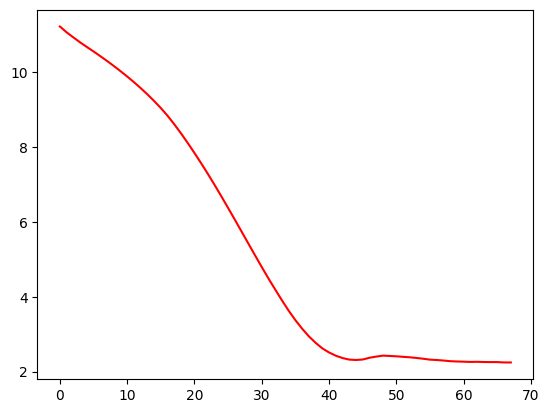

 14%|█▎        | 68/500 [00:07<00:44,  9.69it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.73021582733813
Dataset Name:  books , AUC Score (contextual):  49.5980870980871
Dataset Name:  books , AUC Score (structural):  43.19626960576516
Dataset Name:  books , AUC Score (joint-type):  40.99002849002849
Dataset Name:  books , AUC Score (structure type):  42.85185686566491
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.99002849002849
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


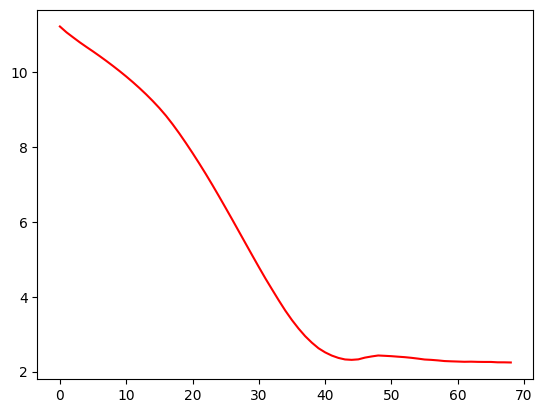

 14%|█▍        | 69/500 [00:08<00:44,  9.67it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.20811921891058
Dataset Name:  books , AUC Score (contextual):  48.58058608058609
Dataset Name:  books , AUC Score (structural):  43.2068673166596
Dataset Name:  books , AUC Score (joint-type):  41.91086691086691
Dataset Name:  books , AUC Score (structure type):  43.06755110328957
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.91086691086691
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


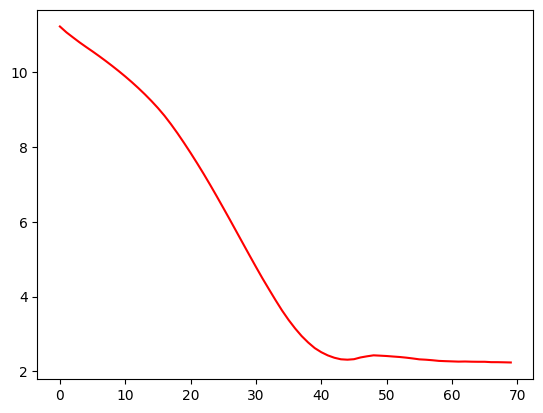

 14%|█▍        | 70/500 [00:08<00:44,  9.66it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.2929085303186
Dataset Name:  books , AUC Score (contextual):  48.52971102971103
Dataset Name:  books , AUC Score (structural):  43.23124205171682
Dataset Name:  books , AUC Score (joint-type):  43.386243386243386
Dataset Name:  books , AUC Score (structure type):  43.36807905780425
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.386243386243386
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


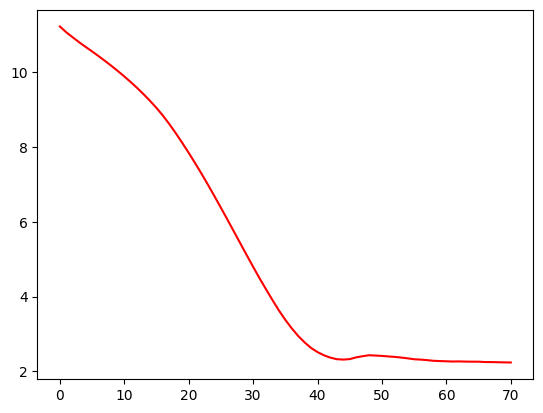

 14%|█▍        | 71/500 [00:08<00:44,  9.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.26207605344297
Dataset Name:  books , AUC Score (contextual):  49.31318681318681
Dataset Name:  books , AUC Score (structural):  43.21110640101738
Dataset Name:  books , AUC Score (joint-type):  43.493080993081
Dataset Name:  books , AUC Score (structure type):  43.35724922160552
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.493080993081
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


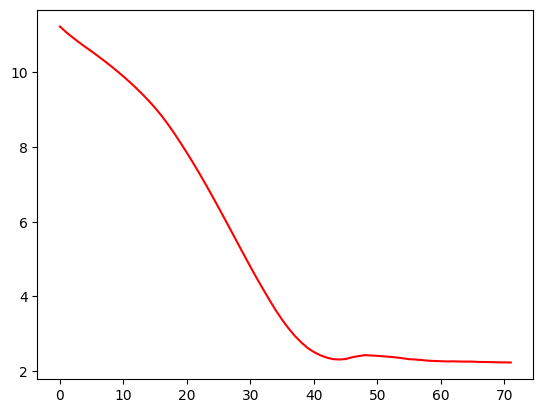

 14%|█▍        | 72/500 [00:08<00:44,  9.67it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.16187050359711
Dataset Name:  books , AUC Score (contextual):  49.78632478632478
Dataset Name:  books , AUC Score (structural):  42.93662568885121
Dataset Name:  books , AUC Score (joint-type):  43.29975579975579
Dataset Name:  books , AUC Score (structure type):  43.03506159469338
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.29975579975579
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


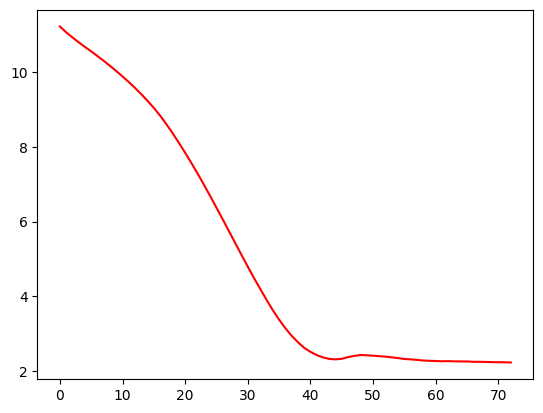

 15%|█▍        | 73/500 [00:08<00:44,  9.69it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.16443987667009
Dataset Name:  books , AUC Score (contextual):  50.172975172975164
Dataset Name:  books , AUC Score (structural):  42.63883001271725
Dataset Name:  books , AUC Score (joint-type):  42.27716727716728
Dataset Name:  books , AUC Score (structure type):  42.53237669780245
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.27716727716728
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


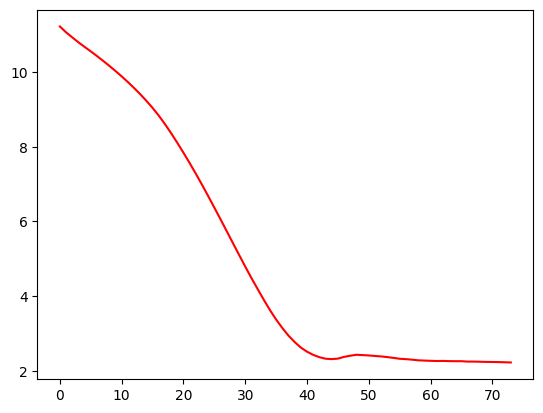

 15%|█▍        | 74/500 [00:08<00:44,  9.63it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.11562178828366
Dataset Name:  books , AUC Score (contextual):  50.14245014245014
Dataset Name:  books , AUC Score (structural):  42.63671047053837
Dataset Name:  books , AUC Score (joint-type):  41.783679283679284
Dataset Name:  books , AUC Score (structure type):  42.43039574026442
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.783679283679284
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


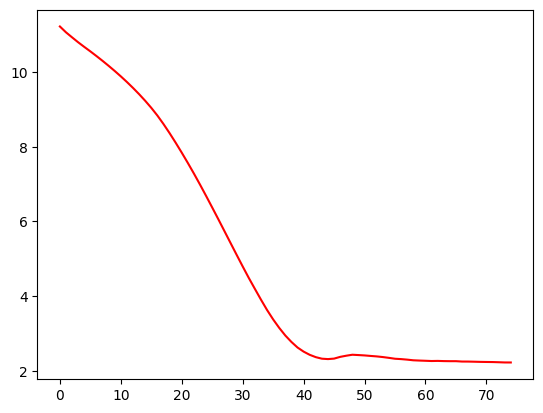

 15%|█▌        | 75/500 [00:08<00:44,  9.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.4136690647482
Dataset Name:  books , AUC Score (contextual):  49.984737484737494
Dataset Name:  books , AUC Score (structural):  42.7702416278084
Dataset Name:  books , AUC Score (joint-type):  41.58017908017908
Dataset Name:  books , AUC Score (structure type):  42.55674382924959
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.58017908017908
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


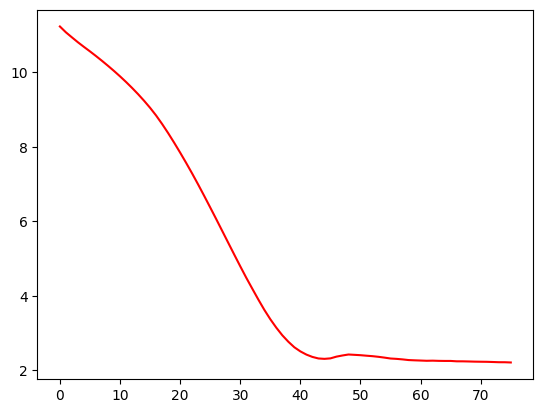

 15%|█▌        | 76/500 [00:08<00:43,  9.64it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.63977389516957
Dataset Name:  books , AUC Score (contextual):  49.87789987789987
Dataset Name:  books , AUC Score (structural):  42.89317507418397
Dataset Name:  books , AUC Score (joint-type):  41.854904354904356
Dataset Name:  books , AUC Score (structure type):  42.7634132033753
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.66289825282631
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.854904354904356
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


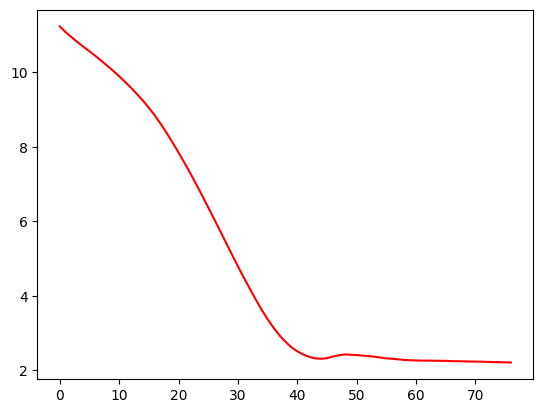

 15%|█▌        | 77/500 [00:08<00:43,  9.67it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books , AUC Score (contextual):  49.94403744403744
Dataset Name:  books , AUC Score (structural):  42.79779567613396
Dataset Name:  books , AUC Score (joint-type):  41.514041514041516
Dataset Name:  books , AUC Score (structure type):  42.64067505978972
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.514041514041516
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


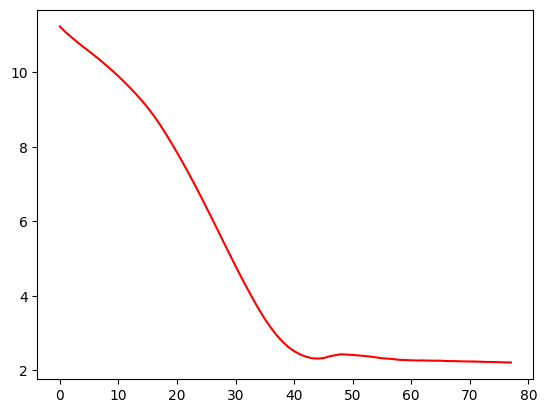

 16%|█▌        | 78/500 [00:08<00:44,  9.59it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.62178828365877
Dataset Name:  books , AUC Score (contextual):  50.58506308506308
Dataset Name:  books , AUC Score (structural):  42.784018651971174
Dataset Name:  books , AUC Score (joint-type):  40.96967846967847
Dataset Name:  books , AUC Score (structure type):  42.52154686160372
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.96967846967847
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


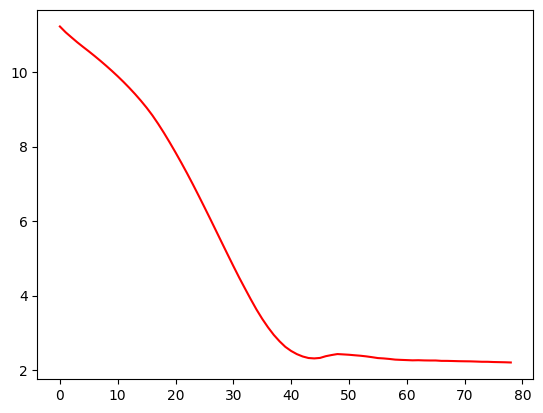

 16%|█▌        | 79/500 [00:09<00:44,  9.54it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.47533401849948
Dataset Name:  books , AUC Score (contextual):  51.063288563288566
Dataset Name:  books , AUC Score (structural):  42.630351844001694
Dataset Name:  books , AUC Score (joint-type):  40.22690272690272
Dataset Name:  books , AUC Score (structure type):  42.23275122963765
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.22690272690272
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


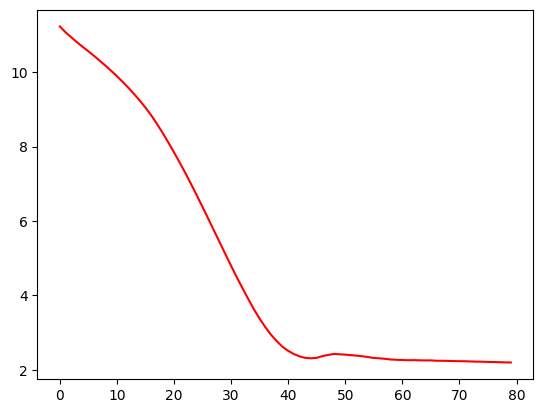

 16%|█▌        | 80/500 [00:09<00:44,  9.46it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.21325796505653
Dataset Name:  books , AUC Score (contextual):  50.95645095645095
Dataset Name:  books , AUC Score (structural):  42.61763459092836
Dataset Name:  books , AUC Score (joint-type):  39.97761497761498
Dataset Name:  books , AUC Score (structure type):  42.190334371192634
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  39.97761497761498
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


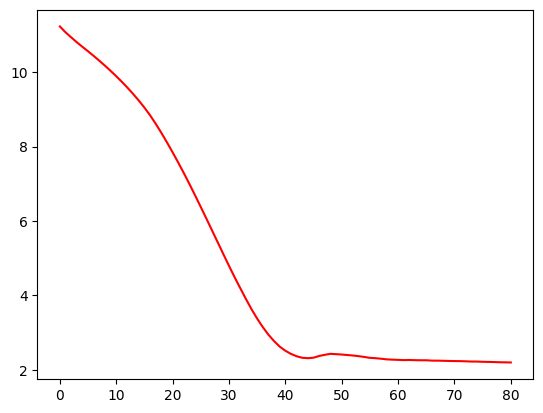

 16%|█▌        | 81/500 [00:09<00:44,  9.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.9049331963001
Dataset Name:  books , AUC Score (contextual):  50.529100529100525
Dataset Name:  books , AUC Score (structural):  42.508478168715556
Dataset Name:  books , AUC Score (joint-type):  40.67969067969068
Dataset Name:  books , AUC Score (structure type):  42.239068634086905
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.67969067969068
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


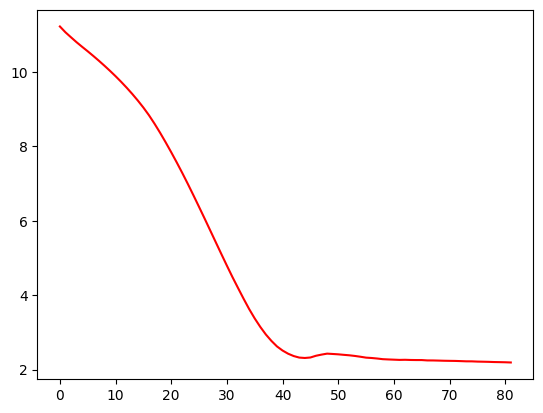

 16%|█▋        | 82/500 [00:09<00:44,  9.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.02312435765674
Dataset Name:  books , AUC Score (contextual):  50.3917378917379
Dataset Name:  books , AUC Score (structural):  42.413098770665535
Dataset Name:  books , AUC Score (joint-type):  42.083842083842086
Dataset Name:  books , AUC Score (structure type):  42.397906231668244
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.083842083842086
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


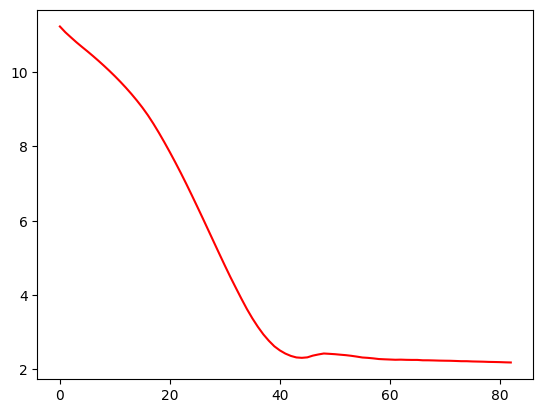

Dataset Name:  books , AUC Score(benchmark/combined):  64.7764645426516
Dataset Name:  books , AUC Score (contextual):  50.4019129019129
Dataset Name:  books , AUC Score (structural):  42.337855023314965
Dataset Name:  books , AUC Score (joint-type):  42.04314204314205
Dataset Name:  books , AUC Score (structure type):  42.308560083028745
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.04314204314205
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


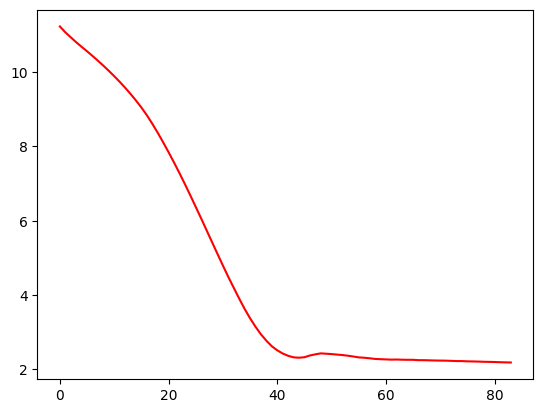

 17%|█▋        | 84/500 [00:09<00:42,  9.85it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.52980472764645
Dataset Name:  books , AUC Score (contextual):  50.26455026455026
Dataset Name:  books , AUC Score (structural):  42.17253073336159
Dataset Name:  books , AUC Score (joint-type):  41.6056166056166
Dataset Name:  books , AUC Score (structure type):  42.08384098190515
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.6056166056166
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


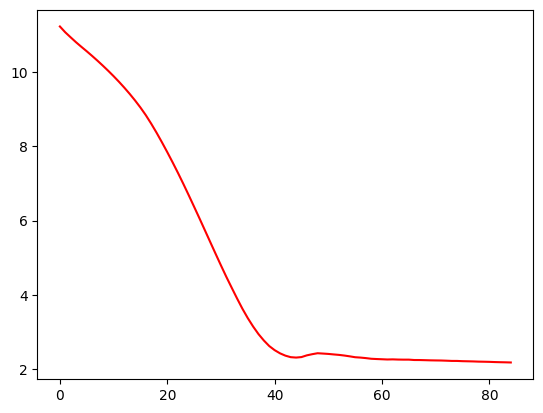

 17%|█▋        | 85/500 [00:09<00:42,  9.78it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.3191161356629
Dataset Name:  books , AUC Score (contextual):  50.534188034188034
Dataset Name:  books , AUC Score (structural):  42.17888935989827
Dataset Name:  books , AUC Score (joint-type):  41.61579161579162
Dataset Name:  books , AUC Score (structure type):  42.09467081810388
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.61579161579162
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


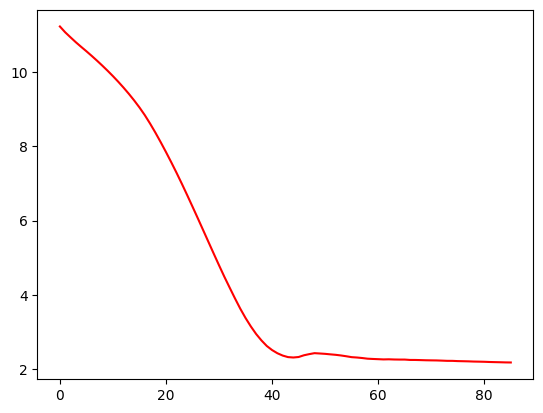

Dataset Name:  books , AUC Score(benchmark/combined):  64.22661870503596
Dataset Name:  books , AUC Score (contextual):  50.19332519332519
Dataset Name:  books , AUC Score (structural):  42.14921576939381
Dataset Name:  books , AUC Score (joint-type):  41.229141229141234
Dataset Name:  books , AUC Score (structure type):  41.97644510626776
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.229141229141234
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


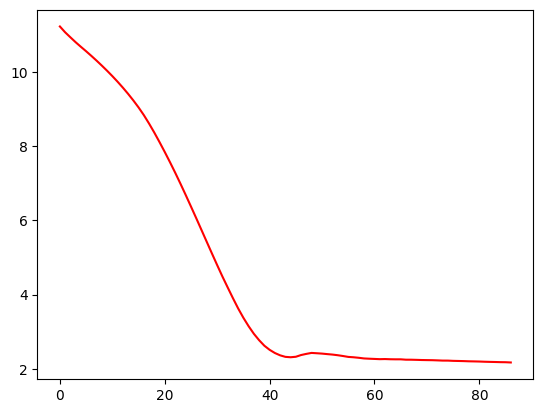

 17%|█▋        | 87/500 [00:09<00:41, 10.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.35765673175744
Dataset Name:  books , AUC Score (contextual):  50.12718762718763
Dataset Name:  books , AUC Score (structural):  42.345273420941076
Dataset Name:  books , AUC Score (joint-type):  42.032967032967036
Dataset Name:  books , AUC Score (structure type):  42.283290465231715
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.032967032967036
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


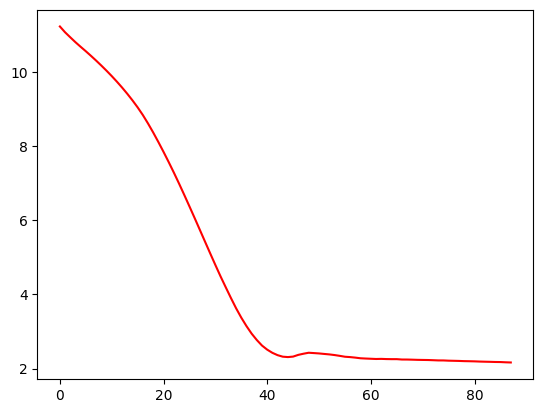

Dataset Name:  books , AUC Score(benchmark/combined):  64.17780061664955
Dataset Name:  books , AUC Score (contextual):  50.727513227513235
Dataset Name:  books , AUC Score (structural):  42.218100890207715
Dataset Name:  books , AUC Score (joint-type):  43.279405779405785
Dataset Name:  books , AUC Score (structure type):  42.391588827218996
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.279405779405785
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


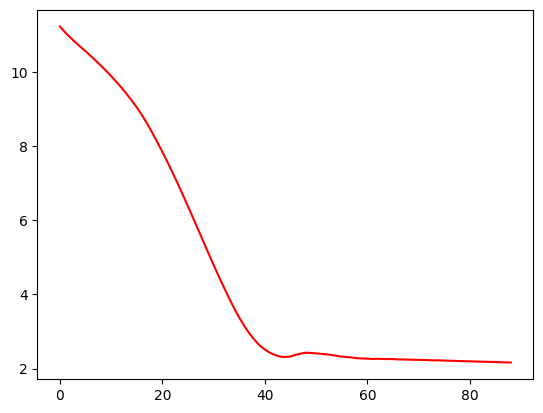

 18%|█▊        | 89/500 [00:10<00:40, 10.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.697327852004115
Dataset Name:  books , AUC Score (contextual):  50.88522588522588
Dataset Name:  books , AUC Score (structural):  41.90864773208987
Dataset Name:  books , AUC Score (joint-type):  42.60785510785511
Dataset Name:  books , AUC Score (structure type):  41.984567483416804
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.60785510785511
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


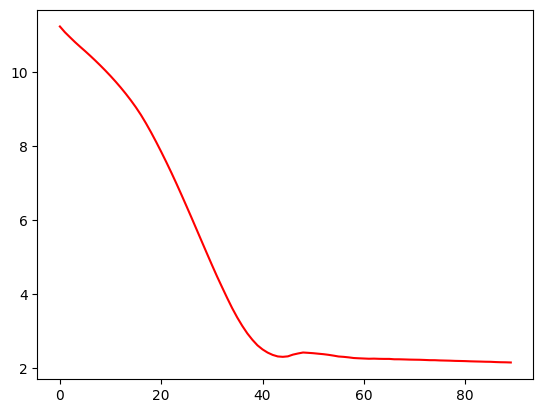

Dataset Name:  books , AUC Score(benchmark/combined):  63.152620760534425
Dataset Name:  books , AUC Score (contextual):  50.493487993487996
Dataset Name:  books , AUC Score (structural):  41.602373887240354
Dataset Name:  books , AUC Score (joint-type):  42.16015466015466
Dataset Name:  books , AUC Score (structure type):  41.61454807996029
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.16015466015466
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


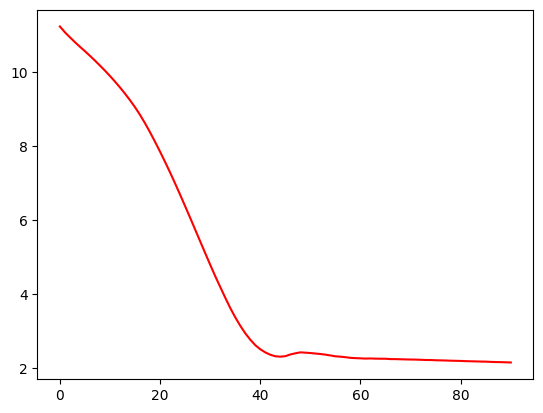

 18%|█▊        | 91/500 [00:10<00:39, 10.23it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.20914696813978
Dataset Name:  books , AUC Score (contextual):  50.534188034188034
Dataset Name:  books , AUC Score (structural):  41.78677405680373
Dataset Name:  books , AUC Score (joint-type):  42.16524216524217
Dataset Name:  books , AUC Score (structure type):  41.74631108704481
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.16524216524217
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


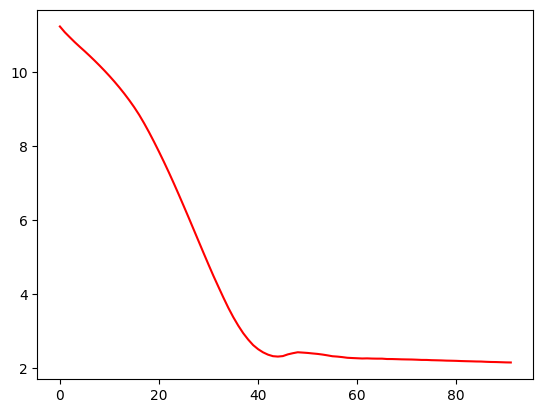

Dataset Name:  books , AUC Score(benchmark/combined):  63.87461459403906
Dataset Name:  books , AUC Score (contextual):  50.534188034188034
Dataset Name:  books , AUC Score (structural):  41.90122933446375
Dataset Name:  books , AUC Score (joint-type):  42.083842083842086
Dataset Name:  books , AUC Score (structure type):  41.826632372185365
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.083842083842086
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


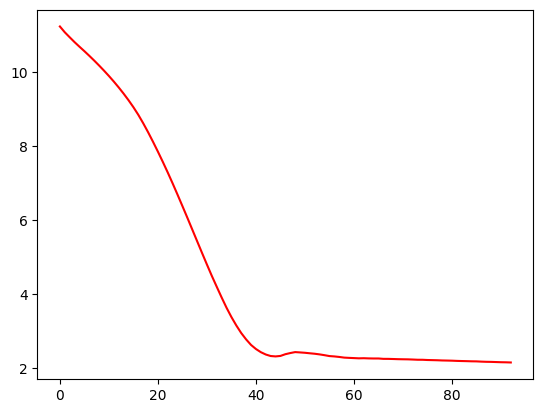

 19%|█▊        | 93/500 [00:10<00:39, 10.24it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.47584789311409
Dataset Name:  books , AUC Score (contextual):  50.88013838013838
Dataset Name:  books , AUC Score (structural):  41.87049597286986
Dataset Name:  books , AUC Score (joint-type):  42.64855514855515
Dataset Name:  books , AUC Score (structure type):  41.92410089797392
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.64855514855515
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


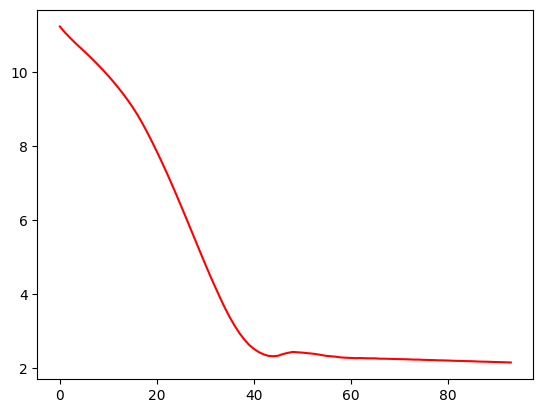

Dataset Name:  books , AUC Score(benchmark/combined):  64.25488180883865
Dataset Name:  books , AUC Score (contextual):  51.28205128205128
Dataset Name:  books , AUC Score (structural):  41.972233997456556
Dataset Name:  books , AUC Score (joint-type):  42.95380545380546
Dataset Name:  books , AUC Score (structure type):  42.04413158250981
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.95380545380546
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


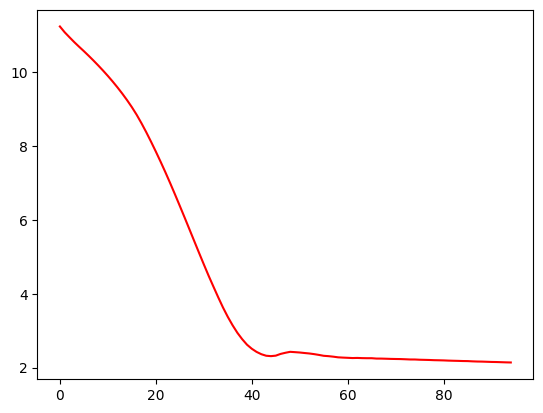

 19%|█▉        | 95/500 [00:10<00:39, 10.26it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.38848920863309
Dataset Name:  books , AUC Score (contextual):  51.77553927553927
Dataset Name:  books , AUC Score (structural):  41.8429419245443
Dataset Name:  books , AUC Score (joint-type):  43.65588115588116
Dataset Name:  books , AUC Score (structure type):  42.06940120030684
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.65588115588116
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


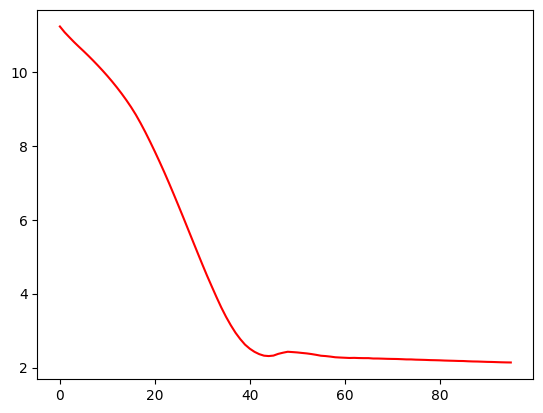

Dataset Name:  books , AUC Score(benchmark/combined):  64.31654676258994
Dataset Name:  books , AUC Score (contextual):  51.47537647537648
Dataset Name:  books , AUC Score (structural):  42.01886392539211
Dataset Name:  books , AUC Score (joint-type):  41.61070411070412
Dataset Name:  books , AUC Score (structure type):  41.8365597220342
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.61070411070412
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


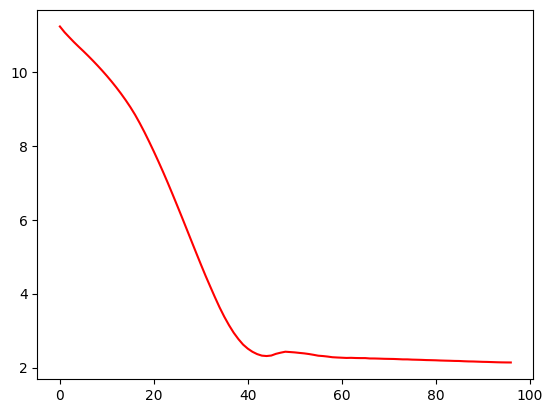

 19%|█▉        | 97/500 [00:10<00:39, 10.20it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.39619732785201
Dataset Name:  books , AUC Score (contextual):  51.66361416361417
Dataset Name:  books , AUC Score (structural):  42.26473081814328
Dataset Name:  books , AUC Score (joint-type):  42.740130240130235
Dataset Name:  books , AUC Score (structure type):  42.28329046523171
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.740130240130235
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


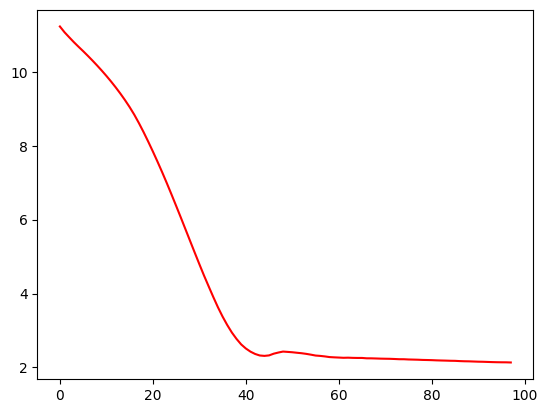

Dataset Name:  books , AUC Score(benchmark/combined):  64.07759506680371
Dataset Name:  books , AUC Score (contextual):  50.707163207163205
Dataset Name:  books , AUC Score (structural):  42.86880033912675
Dataset Name:  books , AUC Score (joint-type):  40.86284086284087
Dataset Name:  books , AUC Score (structure type):  42.43761563106358
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.86284086284087
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


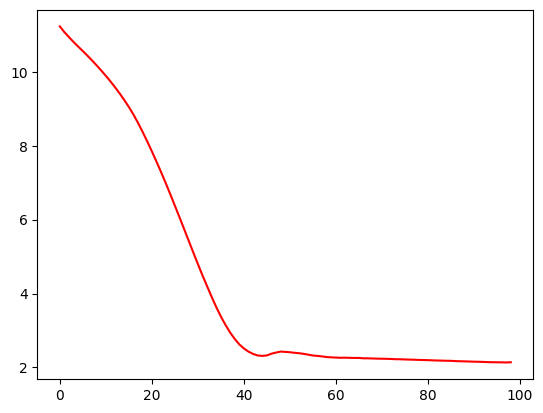

 20%|█▉        | 99/500 [00:11<00:39, 10.11it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.11356628982529
Dataset Name:  books , AUC Score (contextual):  50.38665038665039
Dataset Name:  books , AUC Score (structural):  42.059135226791014
Dataset Name:  books , AUC Score (joint-type):  41.17826617826618
Dataset Name:  books , AUC Score (structure type):  41.80226524073824
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.17826617826618
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


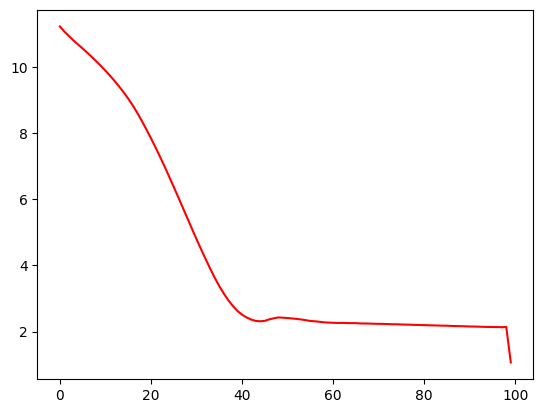

Dataset Name:  books , AUC Score(benchmark/combined):  63.95169578622817
Dataset Name:  books , AUC Score (contextual):  51.61273911273911
Dataset Name:  books , AUC Score (structural):  42.479864349300556
Dataset Name:  books , AUC Score (joint-type):  42.22120472120472
Dataset Name:  books , AUC Score (structure type):  42.357294345923016
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.22120472120472
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


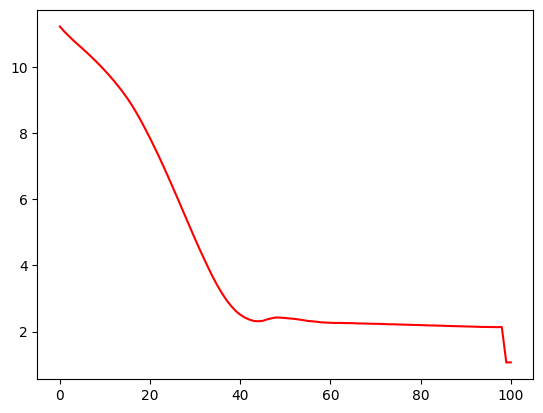

 20%|██        | 101/500 [00:11<00:39, 10.11it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.49691675231244
Dataset Name:  books , AUC Score (contextual):  50.137362637362635
Dataset Name:  books , AUC Score (structural):  41.72106824925816
Dataset Name:  books , AUC Score (joint-type):  41.6971916971917
Dataset Name:  books , AUC Score (structure type):  41.566716303415916
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.6971916971917
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


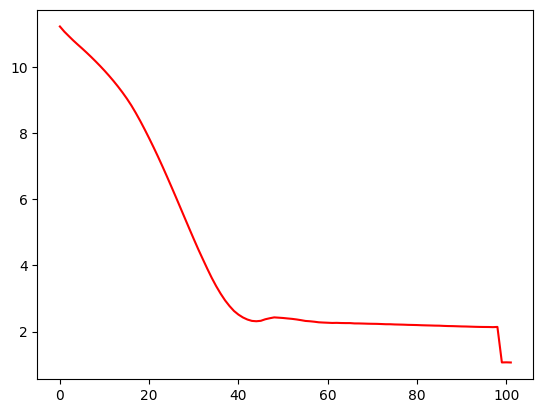

Dataset Name:  books , AUC Score(benchmark/combined):  63.165467625899275
Dataset Name:  books , AUC Score (contextual):  49.577737077737076
Dataset Name:  books , AUC Score (structural):  41.78041543026706
Dataset Name:  books , AUC Score (joint-type):  40.827228327228326
Dataset Name:  books , AUC Score (structure type):  41.47105275032715
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.827228327228326
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


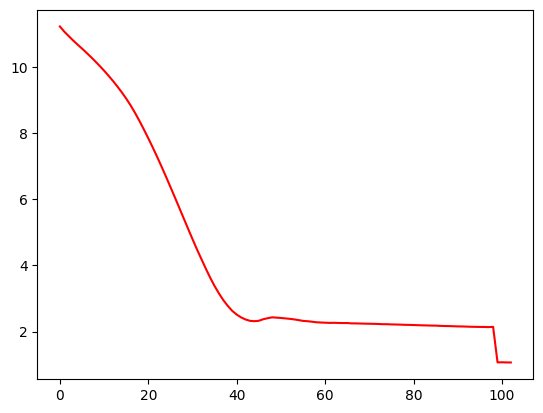

 21%|██        | 103/500 [00:11<00:39, 10.10it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.23741007194245
Dataset Name:  books , AUC Score (contextual):  49.98982498982498
Dataset Name:  books , AUC Score (structural):  41.834463755828736
Dataset Name:  books , AUC Score (joint-type):  42.017704517704516
Dataset Name:  books , AUC Score (structure type):  41.724651414647354
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.017704517704516
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


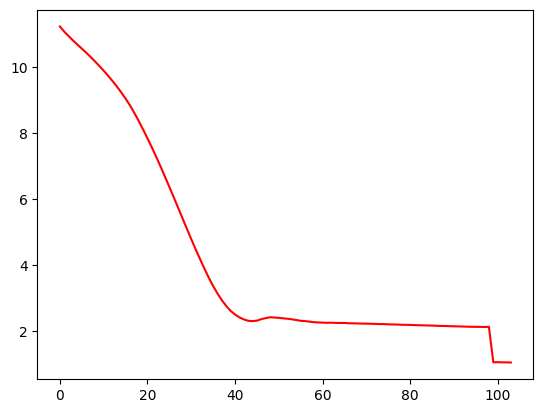

Dataset Name:  books , AUC Score(benchmark/combined):  63.44552929085303
Dataset Name:  books , AUC Score (contextual):  50.85470085470085
Dataset Name:  books , AUC Score (structural):  42.066553624417125
Dataset Name:  books , AUC Score (joint-type):  43.1980056980057
Dataset Name:  books , AUC Score (structure type):  42.14791751274762
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.1980056980057
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


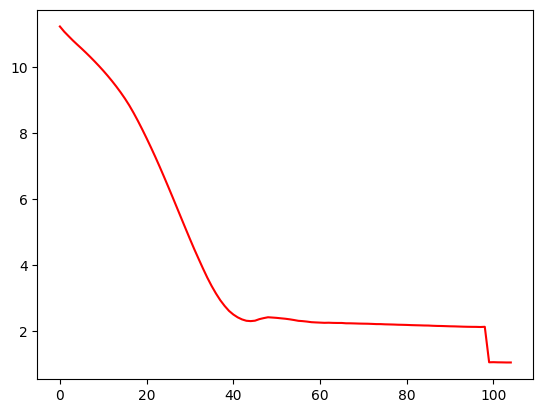

 21%|██        | 105/500 [00:11<00:39, 10.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.1115107913669
Dataset Name:  books , AUC Score (contextual):  50.95136345136344
Dataset Name:  books , AUC Score (structural):  42.244595167443826
Dataset Name:  books , AUC Score (joint-type):  41.81420431420431
Dataset Name:  books , AUC Score (structure type):  42.0459365552096
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.81420431420431
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


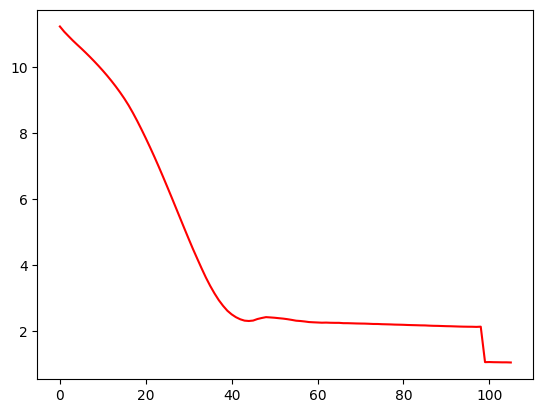

Dataset Name:  books , AUC Score(benchmark/combined):  62.99075025693731
Dataset Name:  books , AUC Score (contextual):  50.880138380138376
Dataset Name:  books , AUC Score (structural):  42.276388300127174
Dataset Name:  books , AUC Score (joint-type):  41.051078551078554
Dataset Name:  books , AUC Score (structure type):  41.91597852082487
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.051078551078554
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


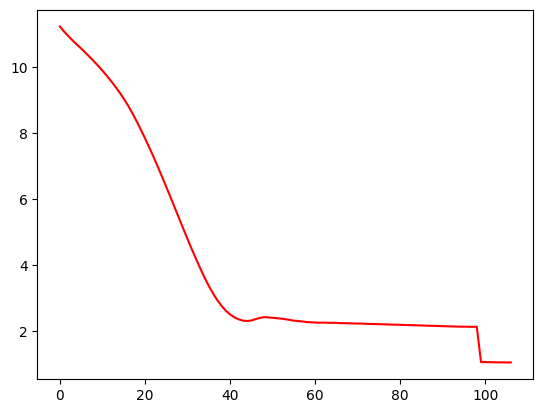

 21%|██▏       | 107/500 [00:12<00:57,  6.85it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.744090441932165
Dataset Name:  books , AUC Score (contextual):  51.95360195360195
Dataset Name:  books , AUC Score (structural):  42.09940652818991
Dataset Name:  books , AUC Score (joint-type):  42.38909238909238
Dataset Name:  books , AUC Score (structure type):  41.99990975136501
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.38909238909238
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


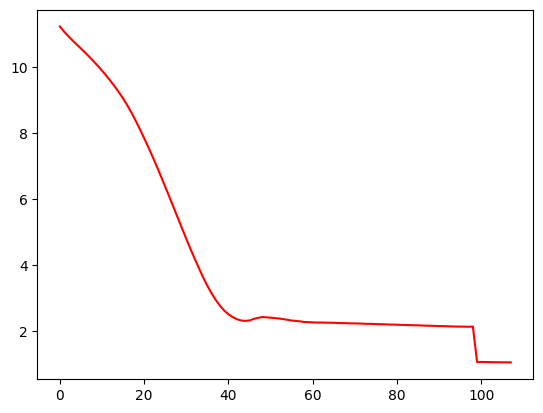

 22%|██▏       | 108/500 [00:12<00:54,  7.23it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.73381294964029
Dataset Name:  books , AUC Score (contextual):  52.66585266585266
Dataset Name:  books , AUC Score (structural):  42.04111911827045
Dataset Name:  books , AUC Score (joint-type):  42.9029304029304
Dataset Name:  books , AUC Score (structure type):  42.0621813095077
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.9029304029304
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


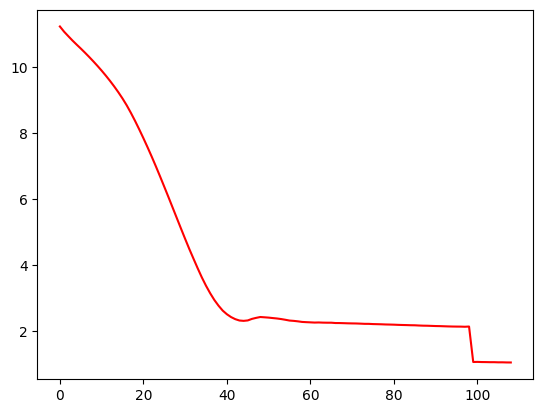

Dataset Name:  books , AUC Score(benchmark/combined):  62.410071942446045
Dataset Name:  books , AUC Score (contextual):  51.35327635327634
Dataset Name:  books , AUC Score (structural):  42.663204747774486
Dataset Name:  books , AUC Score (joint-type):  41.75315425315425
Dataset Name:  books , AUC Score (structure type):  42.40151617706782
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.75315425315425
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


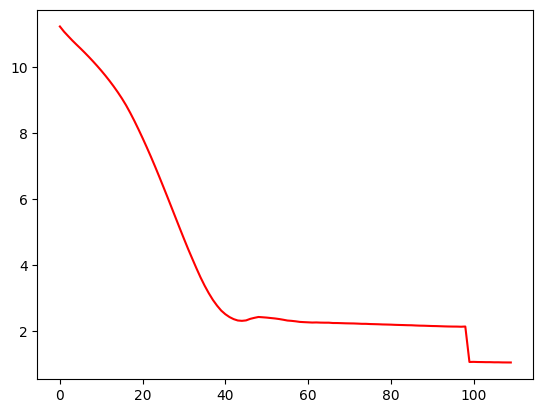

 22%|██▏       | 110/500 [00:12<00:48,  7.98it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.222507708119224
Dataset Name:  books , AUC Score (contextual):  50.12210012210012
Dataset Name:  books , AUC Score (structural):  41.751801610852056
Dataset Name:  books , AUC Score (joint-type):  44.810744810744815
Dataset Name:  books , AUC Score (structure type):  42.17047967149497
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.810744810744815
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


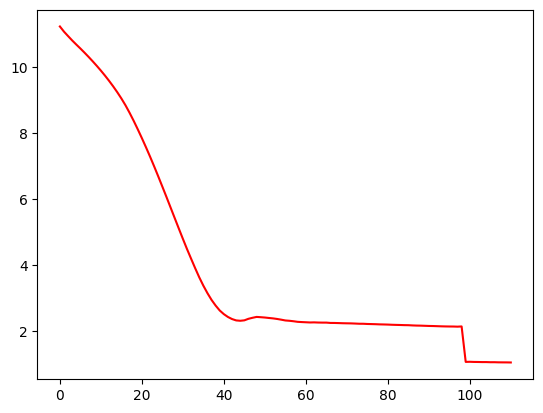

Dataset Name:  books , AUC Score(benchmark/combined):  62.430626927029806
Dataset Name:  books , AUC Score (contextual):  50.24928774928775
Dataset Name:  books , AUC Score (structural):  41.980712166172104
Dataset Name:  books , AUC Score (joint-type):  45.19230769230769
Dataset Name:  books , AUC Score (structure type):  42.426785794864855
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.19230769230769
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


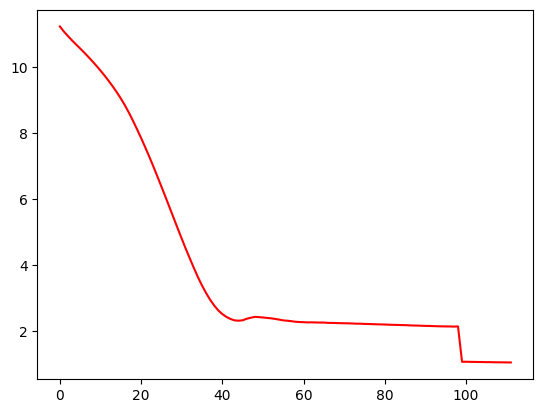

 22%|██▏       | 112/500 [00:12<00:45,  8.52it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.53854059609455
Dataset Name:  books , AUC Score (contextual):  50.38156288156288
Dataset Name:  books , AUC Score (structural):  43.60958033064858
Dataset Name:  books , AUC Score (joint-type):  41.52421652421653
Dataset Name:  books , AUC Score (structure type):  43.14155498398087
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.52421652421653
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


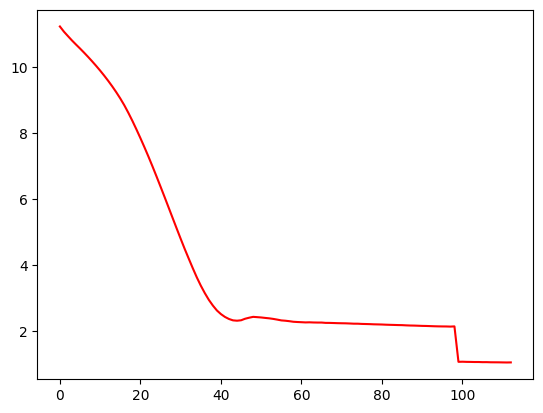

Dataset Name:  books , AUC Score(benchmark/combined):  62.86998972250771
Dataset Name:  books , AUC Score (contextual):  50.8954008954009
Dataset Name:  books , AUC Score (structural):  42.37812632471386
Dataset Name:  books , AUC Score (joint-type):  43.421855921855915
Dataset Name:  books , AUC Score (structure type):  42.518839402554036
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.421855921855915
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


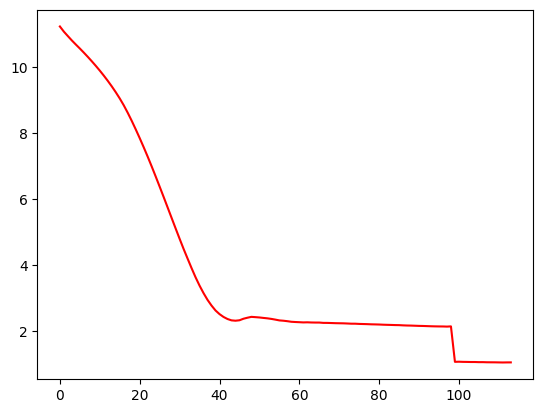

 23%|██▎       | 114/500 [00:12<00:42,  9.00it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.65159301130524
Dataset Name:  books , AUC Score (contextual):  50.16280016280016
Dataset Name:  books , AUC Score (structural):  43.25455701568461
Dataset Name:  books , AUC Score (joint-type):  41.83455433455433
Dataset Name:  books , AUC Score (structure type):  42.874419024412255
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.83455433455433
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


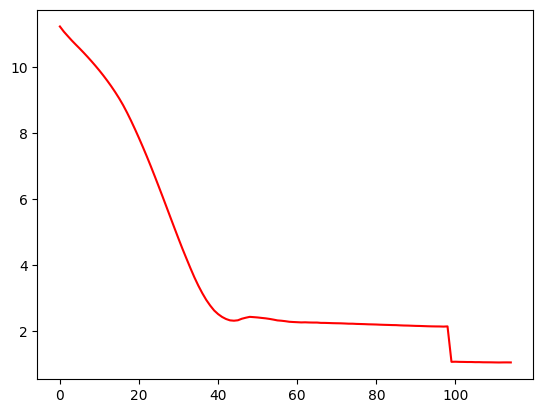

Dataset Name:  books , AUC Score(benchmark/combined):  62.97019527235355
Dataset Name:  books , AUC Score (contextual):  48.77899877899877
Dataset Name:  books , AUC Score (structural):  41.55044510385756
Dataset Name:  books , AUC Score (joint-type):  43.716931216931215
Dataset Name:  books , AUC Score (structure type):  41.76075086864311
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.716931216931215
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


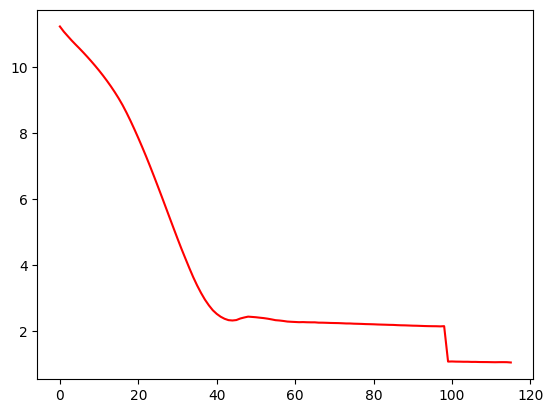

 23%|██▎       | 116/500 [00:13<00:41,  9.28it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.05755395683453
Dataset Name:  books , AUC Score (contextual):  49.02319902319903
Dataset Name:  books , AUC Score (structural):  41.767698177193736
Dataset Name:  books , AUC Score (joint-type):  44.01200651200651
Dataset Name:  books , AUC Score (structure type):  42.0161545056631
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.01200651200651
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


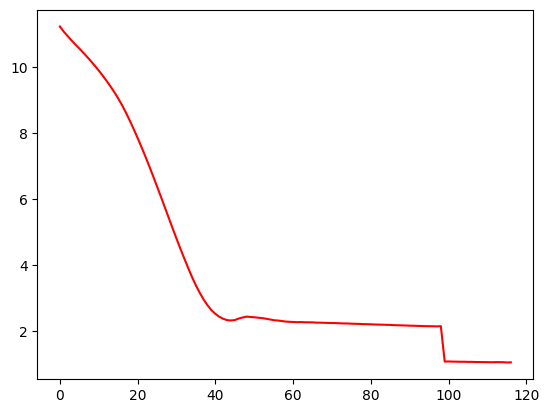

 23%|██▎       | 117/500 [00:13<00:40,  9.34it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.07862281603289
Dataset Name:  books , AUC Score (contextual):  49.32844932844933
Dataset Name:  books , AUC Score (structural):  42.59325985587113
Dataset Name:  books , AUC Score (joint-type):  41.25457875457876
Dataset Name:  books , AUC Score (structure type):  42.185821939443166
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.25457875457876
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


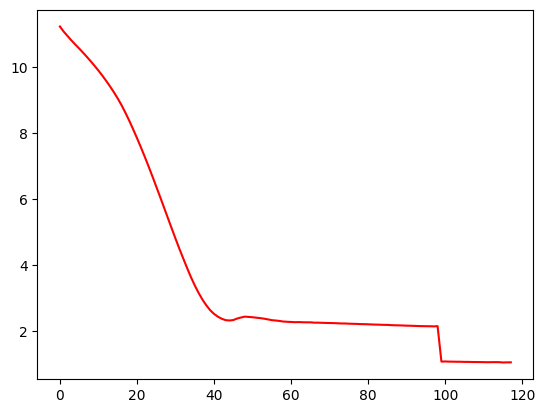

 24%|██▎       | 118/500 [00:13<00:40,  9.44it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.19938335046249
Dataset Name:  books , AUC Score (contextual):  49.14529914529915
Dataset Name:  books , AUC Score (structural):  41.60449342941925
Dataset Name:  books , AUC Score (joint-type):  43.777981277981276
Dataset Name:  books , AUC Score (structure type):  41.788727945489825
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.777981277981276
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


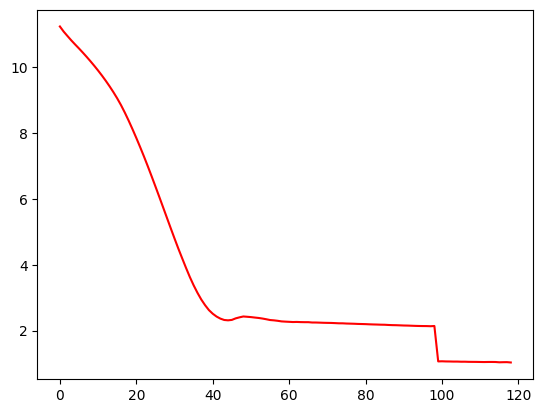

 24%|██▍       | 119/500 [00:13<00:39,  9.53it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.89362795477904
Dataset Name:  books , AUC Score (contextual):  50.462962962962955
Dataset Name:  books , AUC Score (structural):  42.530733361593896
Dataset Name:  books , AUC Score (joint-type):  45.83333333333333
Dataset Name:  books , AUC Score (structure type):  42.999864627047515
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.83333333333333
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


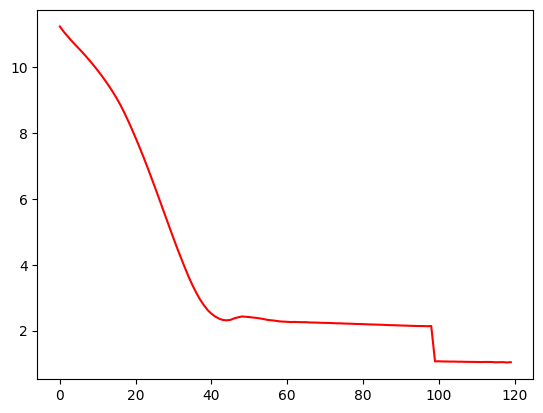

 24%|██▍       | 120/500 [00:13<00:39,  9.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.43884892086331
Dataset Name:  books , AUC Score (contextual):  50.11192511192512
Dataset Name:  books , AUC Score (structural):  43.75158965663417
Dataset Name:  books , AUC Score (joint-type):  41.67175417175417
Dataset Name:  books , AUC Score (structure type):  43.246243400568574
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.67175417175417
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


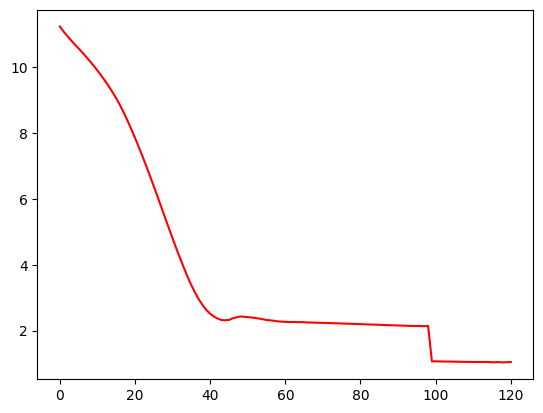

 24%|██▍       | 121/500 [00:13<00:39,  9.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.644398766700924
Dataset Name:  books , AUC Score (contextual):  48.17867317867318
Dataset Name:  books , AUC Score (structural):  41.993429419245444
Dataset Name:  books , AUC Score (joint-type):  43.16239316239317
Dataset Name:  books , AUC Score (structure type):  42.03781417806056
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.16239316239317
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


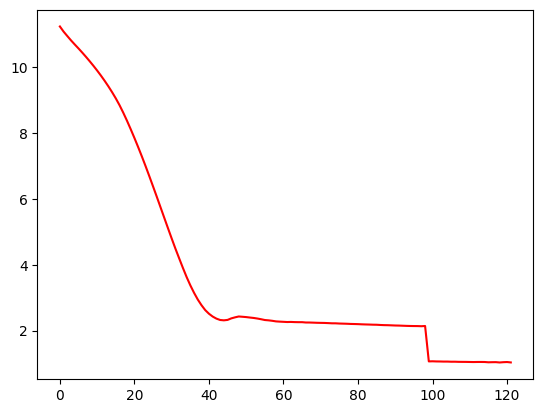

 24%|██▍       | 122/500 [00:13<00:38,  9.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.790853031860216
Dataset Name:  books , AUC Score (contextual):  48.0972730972731
Dataset Name:  books , AUC Score (structural):  43.48876642645189
Dataset Name:  books , AUC Score (joint-type):  47.09503459503459
Dataset Name:  books , AUC Score (structure type):  44.060286088172916
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.09503459503459
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


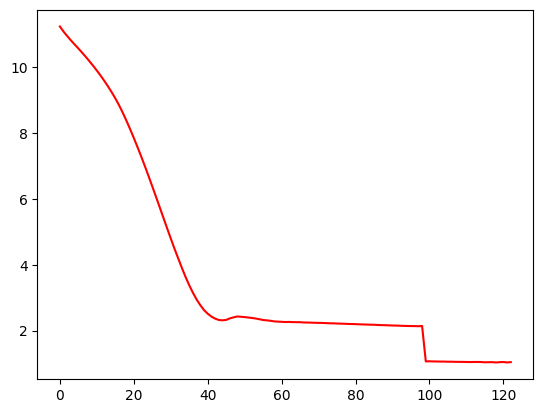

 25%|██▍       | 123/500 [00:13<00:38,  9.68it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.9218910585817
Dataset Name:  books , AUC Score (contextual):  46.46418396418397
Dataset Name:  books , AUC Score (structural):  42.804154302670625
Dataset Name:  books , AUC Score (joint-type):  45.187220187220184
Dataset Name:  books , AUC Score (structure type):  43.10365055728532
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.187220187220184
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


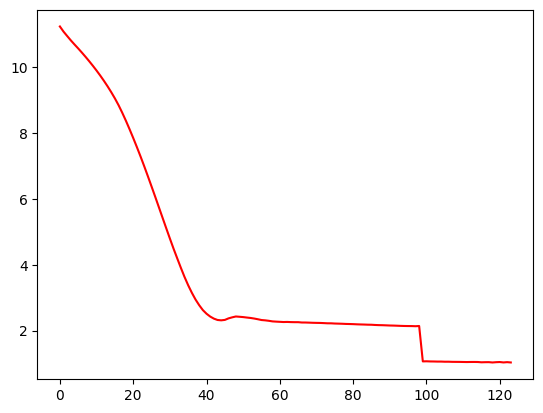

 25%|██▍       | 124/500 [00:13<00:38,  9.69it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.81140801644399
Dataset Name:  books , AUC Score (contextual):  48.7993487993488
Dataset Name:  books , AUC Score (structural):  41.71364985163205
Dataset Name:  books , AUC Score (joint-type):  42.14997964997965
Dataset Name:  books , AUC Score (structure type):  41.58566851676369
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.14997964997965
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


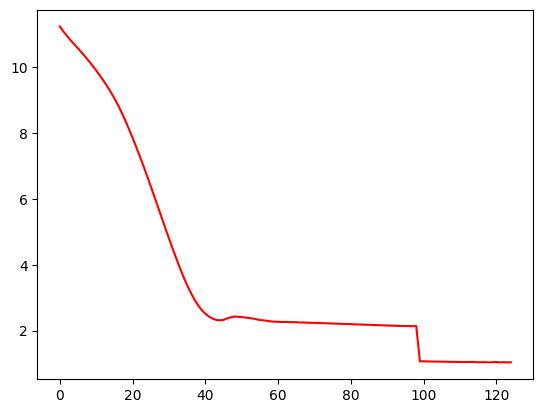

 25%|██▌       | 125/500 [00:14<00:38,  9.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.1120246659815
Dataset Name:  books , AUC Score (contextual):  49.638787138787144
Dataset Name:  books , AUC Score (structural):  40.779991521831285
Dataset Name:  books , AUC Score (joint-type):  43.956043956043956
Dataset Name:  books , AUC Score (structure type):  41.07576372907359
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.956043956043956
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


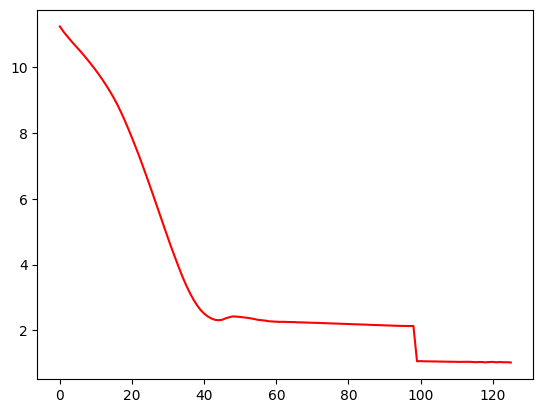

 25%|██▌       | 126/500 [00:14<00:38,  9.77it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.31243576567318
Dataset Name:  books , AUC Score (contextual):  51.3024013024013
Dataset Name:  books , AUC Score (structural):  41.99342941924544
Dataset Name:  books , AUC Score (joint-type):  47.21204721204722
Dataset Name:  books , AUC Score (structure type):  42.71377645413113
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.21204721204722
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


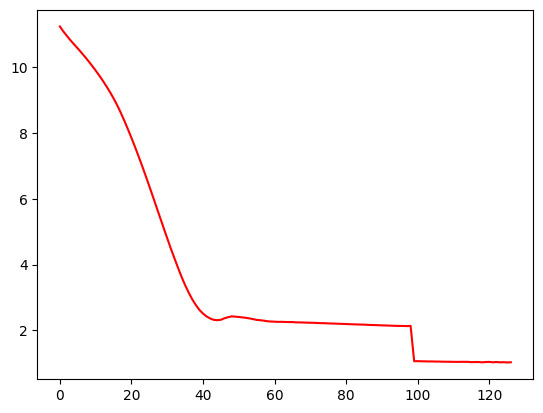

 25%|██▌       | 127/500 [00:14<00:38,  9.79it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.76464542651593
Dataset Name:  books , AUC Score (contextual):  49.04354904354904
Dataset Name:  books , AUC Score (structural):  42.28380669775328
Dataset Name:  books , AUC Score (joint-type):  45.17704517704518
Dataset Name:  books , AUC Score (structure type):  42.59284328324534
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.17704517704518
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


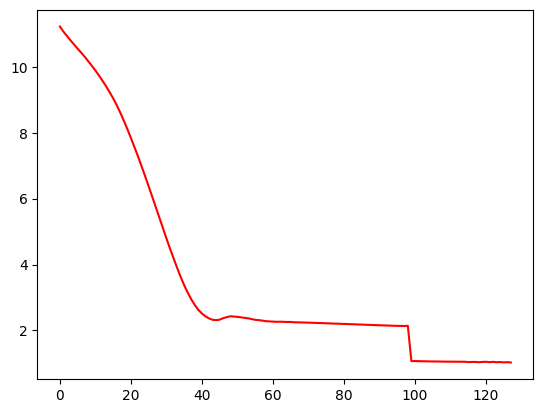

Dataset Name:  books , AUC Score(benchmark/combined):  62.857142857142854
Dataset Name:  books , AUC Score (contextual):  48.95197395197395
Dataset Name:  books , AUC Score (structural):  42.04111911827046
Dataset Name:  books , AUC Score (joint-type):  43.727106227106226
Dataset Name:  books , AUC Score (structure type):  42.12264789495059
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.727106227106226
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


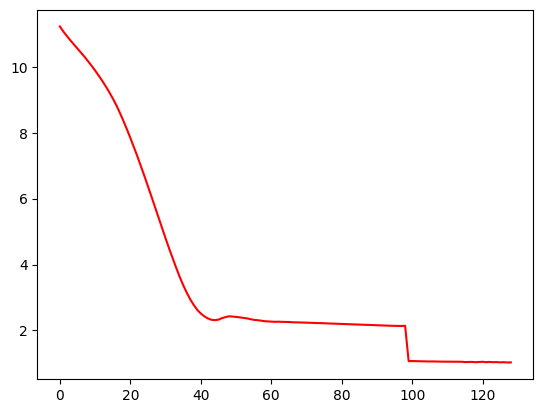

 26%|██▌       | 129/500 [00:14<00:37,  9.84it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.92394655704009
Dataset Name:  books , AUC Score (contextual):  48.07183557183558
Dataset Name:  books , AUC Score (structural):  41.643704959728694
Dataset Name:  books , AUC Score (joint-type):  44.276556776556774
Dataset Name:  books , AUC Score (structure type):  41.918685979874546
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.276556776556774
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


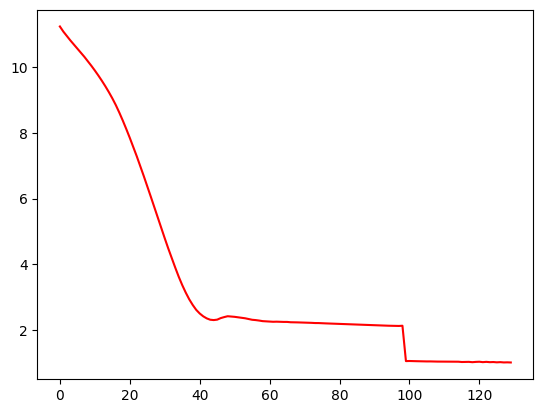

 26%|██▌       | 130/500 [00:14<00:37,  9.86it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.66700924974307
Dataset Name:  books , AUC Score (contextual):  47.61396011396011
Dataset Name:  books , AUC Score (structural):  41.805849936413736
Dataset Name:  books , AUC Score (joint-type):  42.699430199430196
Dataset Name:  books , AUC Score (structure type):  41.816705022336535
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.699430199430196
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


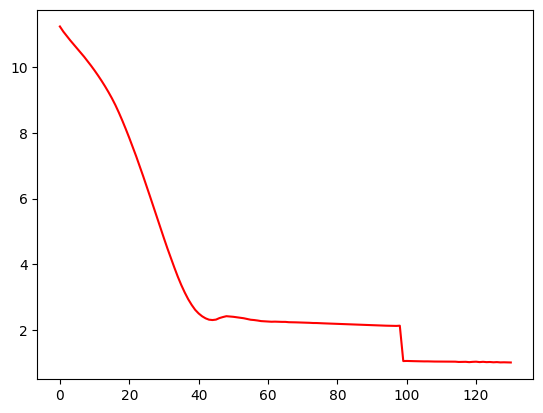

 26%|██▌       | 131/500 [00:14<00:37,  9.85it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.28417266187051
Dataset Name:  books , AUC Score (contextual):  48.87057387057387
Dataset Name:  books , AUC Score (structural):  42.088808817295465
Dataset Name:  books , AUC Score (joint-type):  43.666056166056165
Dataset Name:  books , AUC Score (structure type):  42.203871666441046
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.666056166056165
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


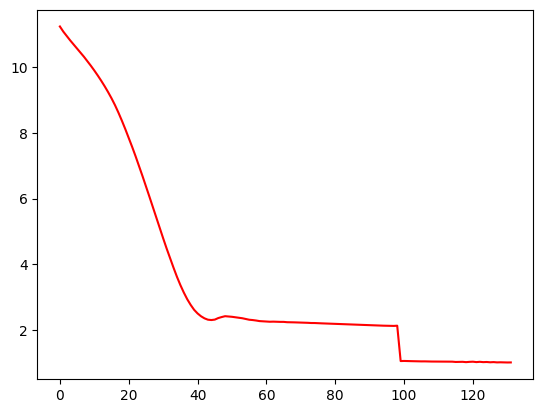

 26%|██▋       | 132/500 [00:14<00:37,  9.85it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.939362795477905
Dataset Name:  books , AUC Score (contextual):  46.99328449328449
Dataset Name:  books , AUC Score (structural):  41.36922424756253
Dataset Name:  books , AUC Score (joint-type):  46.10805860805861
Dataset Name:  books , AUC Score (structure type):  41.996299805965435
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.10805860805861
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


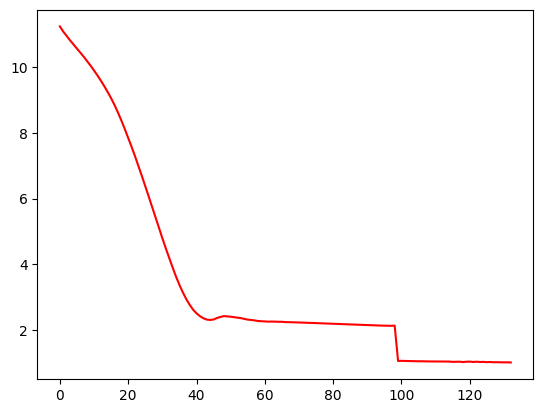

 27%|██▋       | 133/500 [00:14<00:37,  9.86it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.281089414182944
Dataset Name:  books , AUC Score (contextual):  48.67724867724868
Dataset Name:  books , AUC Score (structural):  41.54090716405256
Dataset Name:  books , AUC Score (joint-type):  45.39072039072039
Dataset Name:  books , AUC Score (structure type):  42.000812237714904
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.39072039072039
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


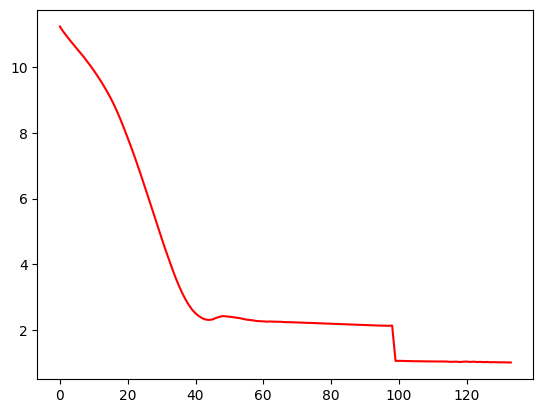

Dataset Name:  books , AUC Score(benchmark/combined):  62.25847893114079
Dataset Name:  books , AUC Score (contextual):  48.07692307692307
Dataset Name:  books , AUC Score (structural):  43.225943196269604
Dataset Name:  books , AUC Score (joint-type):  43.07590557590558
Dataset Name:  books , AUC Score (structure type):  43.017914354045395
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.07590557590558
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


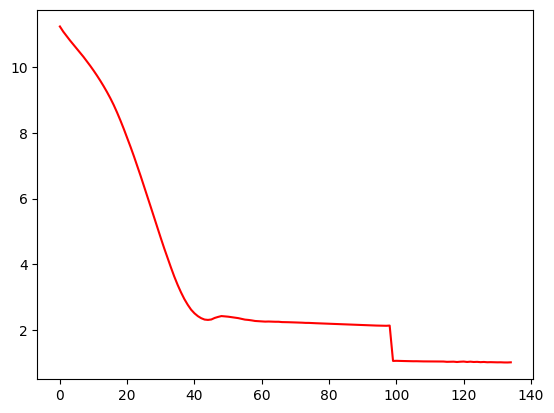

 27%|██▋       | 135/500 [00:15<00:37,  9.77it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.35097636176773
Dataset Name:  books , AUC Score (contextual):  47.48168498168498
Dataset Name:  books , AUC Score (structural):  41.2547689699025
Dataset Name:  books , AUC Score (joint-type):  46.680402930402934
Dataset Name:  books , AUC Score (structure type):  42.008483371689
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.680402930402934
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


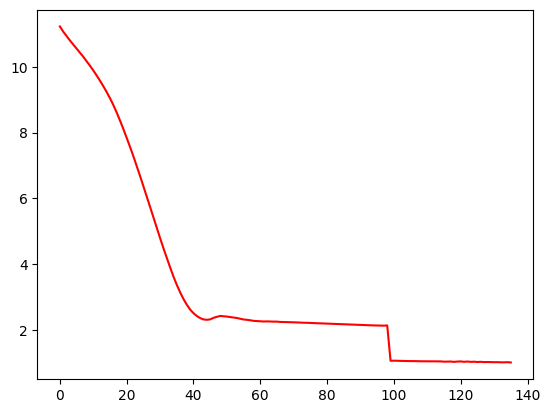

 27%|██▋       | 136/500 [00:15<00:37,  9.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.28417266187051
Dataset Name:  books , AUC Score (contextual):  45.62983312983313
Dataset Name:  books , AUC Score (structural):  41.4253921153031
Dataset Name:  books , AUC Score (joint-type):  47.09503459503459
Dataset Name:  books , AUC Score (structure type):  42.26253327918415
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.09503459503459
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


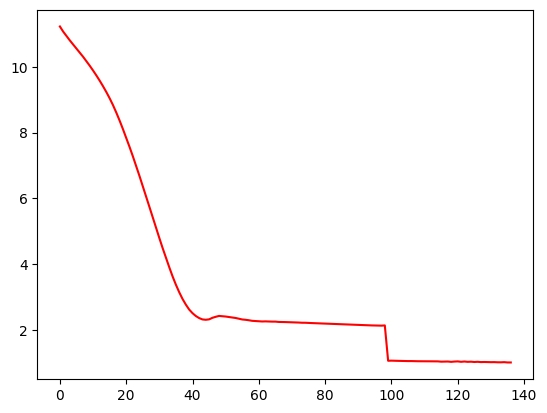

 27%|██▋       | 137/500 [00:15<00:37,  9.64it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.45118191161356
Dataset Name:  books , AUC Score (contextual):  47.008547008547005
Dataset Name:  books , AUC Score (structural):  42.67062314540059
Dataset Name:  books , AUC Score (joint-type):  43.92551892551892
Dataset Name:  books , AUC Score (structure type):  42.77514552592392
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.92551892551892
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


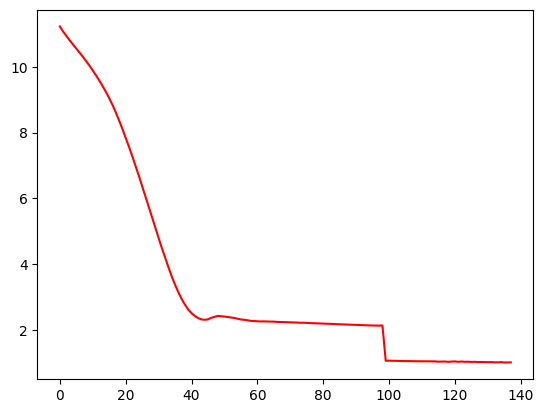

 28%|██▊       | 138/500 [00:15<00:37,  9.63it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.03699897225077
Dataset Name:  books , AUC Score (contextual):  47.72079772079772
Dataset Name:  books , AUC Score (structural):  41.71788893598982
Dataset Name:  books , AUC Score (joint-type):  45.7061457061457
Dataset Name:  books , AUC Score (structure type):  42.283290465231715
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.7061457061457
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


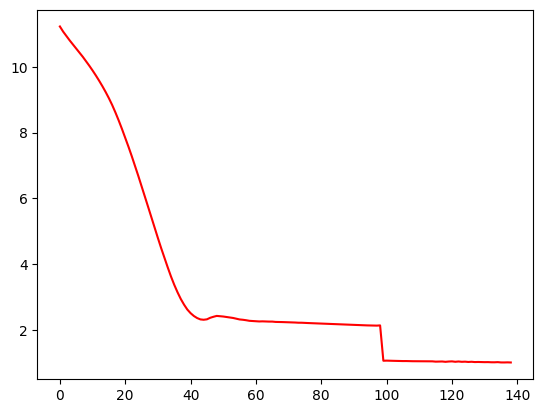

 28%|██▊       | 139/500 [00:15<00:37,  9.60it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.99075025693731
Dataset Name:  books , AUC Score (contextual):  47.72588522588522
Dataset Name:  books , AUC Score (structural):  42.028401865197104
Dataset Name:  books , AUC Score (joint-type):  45.58404558404558
Dataset Name:  books , AUC Score (structure type):  42.48093497585849
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.58404558404558
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


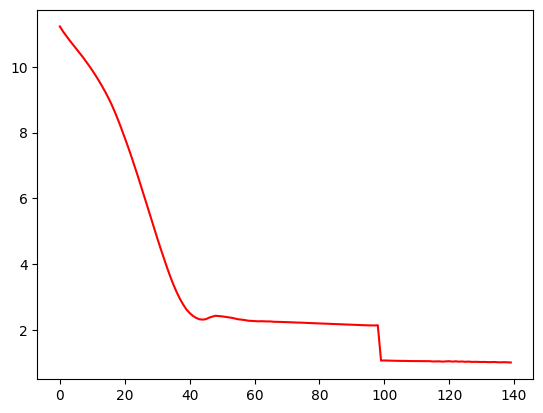

 28%|██▊       | 140/500 [00:15<00:37,  9.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.56423432682426
Dataset Name:  books , AUC Score (contextual):  48.6009361009361
Dataset Name:  books , AUC Score (structural):  42.31242051716829
Dataset Name:  books , AUC Score (joint-type):  44.922669922669925
Dataset Name:  books , AUC Score (structure type):  42.56035377464916
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.922669922669925
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


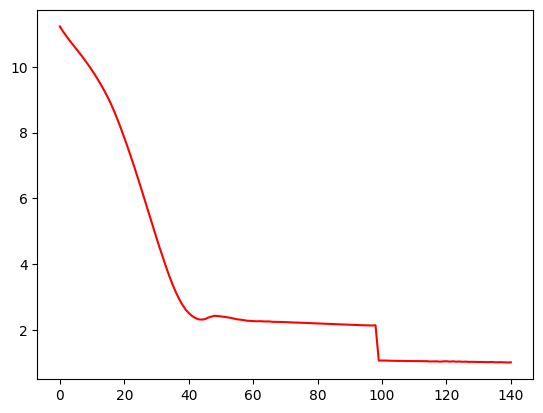

 28%|██▊       | 141/500 [00:15<00:37,  9.50it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.99075025693731
Dataset Name:  books , AUC Score (contextual):  50.147537647537646
Dataset Name:  books , AUC Score (structural):  41.45294616362865
Dataset Name:  books , AUC Score (joint-type):  46.443833943833944
Dataset Name:  books , AUC Score (structure type):  42.12535535400027
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.443833943833944
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


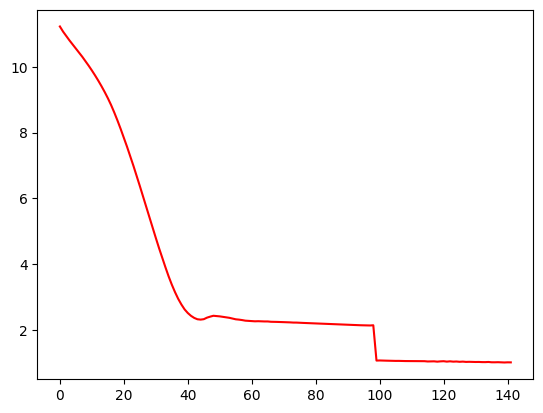

 28%|██▊       | 142/500 [00:15<00:37,  9.55it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.62589928057554
Dataset Name:  books , AUC Score (contextual):  49.23687423687424
Dataset Name:  books , AUC Score (structural):  42.43535396354387
Dataset Name:  books , AUC Score (joint-type):  44.44444444444445
Dataset Name:  books , AUC Score (structure type):  42.605478092143855
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.44444444444445
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


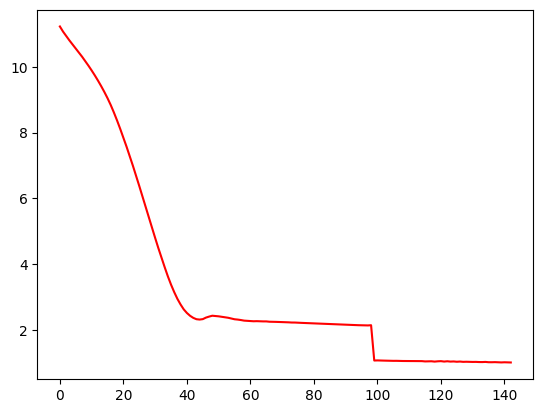

 29%|██▊       | 143/500 [00:15<00:37,  9.58it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.839671120246656
Dataset Name:  books , AUC Score (contextual):  47.02889702889703
Dataset Name:  books , AUC Score (structural):  41.23781263247138
Dataset Name:  books , AUC Score (joint-type):  47.13064713064713
Dataset Name:  books , AUC Score (structure type):  42.07662109110599
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.13064713064713
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


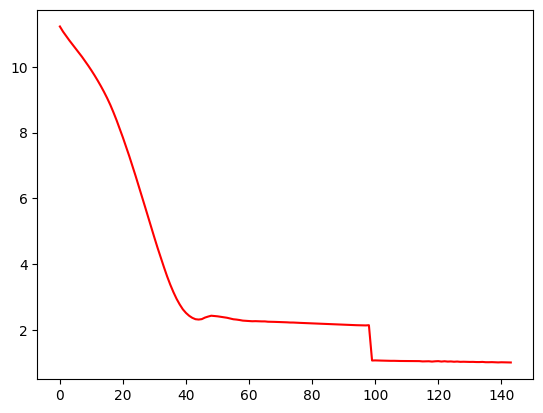

 29%|██▉       | 144/500 [00:15<00:37,  9.59it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.87821171634121
Dataset Name:  books , AUC Score (contextual):  46.169108669108674
Dataset Name:  books , AUC Score (structural):  41.32789317507419
Dataset Name:  books , AUC Score (joint-type):  48.06674806674807
Dataset Name:  books , AUC Score (structure type):  42.337439646225356
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.06674806674807
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


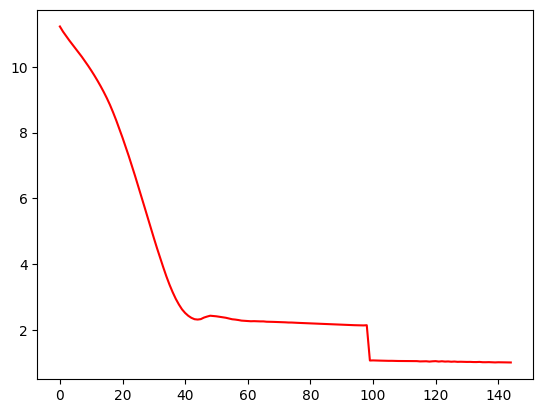

 29%|██▉       | 145/500 [00:16<00:36,  9.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.76258992805755
Dataset Name:  books , AUC Score (contextual):  49.09442409442409
Dataset Name:  books , AUC Score (structural):  42.72149215769394
Dataset Name:  books , AUC Score (joint-type):  44.113756613756614
Dataset Name:  books , AUC Score (structure type):  42.84102702946618
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.113756613756614
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


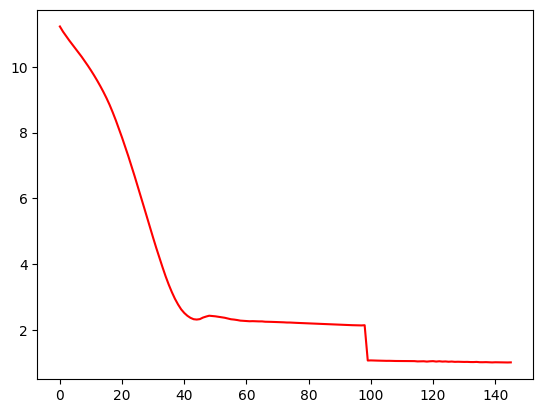

 29%|██▉       | 146/500 [00:16<00:36,  9.57it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.1043165467626
Dataset Name:  books , AUC Score (contextual):  49.40984940984941
Dataset Name:  books , AUC Score (structural):  41.138194150063576
Dataset Name:  books , AUC Score (joint-type):  46.75417175417176
Dataset Name:  books , AUC Score (structure type):  41.94756554307116
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.75417175417176
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


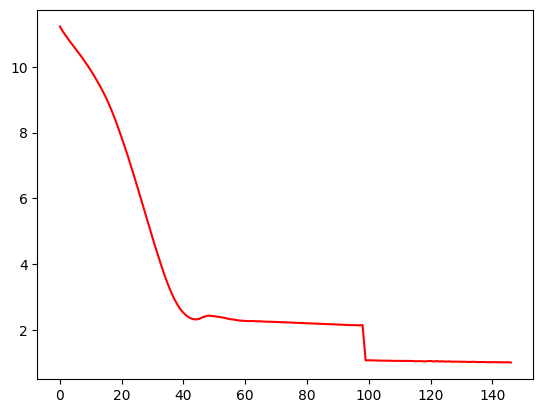

 29%|██▉       | 147/500 [00:16<00:36,  9.57it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.48766700924975
Dataset Name:  books , AUC Score (contextual):  48.35164835164835
Dataset Name:  books , AUC Score (structural):  41.727426875794826
Dataset Name:  books , AUC Score (joint-type):  47.7055352055352
Dataset Name:  books , AUC Score (structure type):  42.60006317404449
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.7055352055352
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


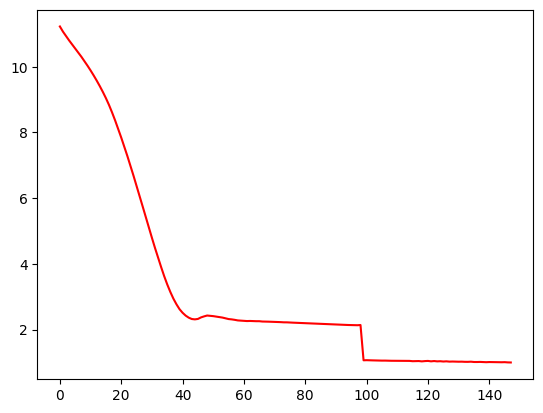

 30%|██▉       | 148/500 [00:16<00:36,  9.58it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.127954779033914
Dataset Name:  books , AUC Score (contextual):  48.468660968660956
Dataset Name:  books , AUC Score (structural):  42.64624841034336
Dataset Name:  books , AUC Score (joint-type):  43.74236874236874
Dataset Name:  books , AUC Score (structure type):  42.6731645683859
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.74236874236874
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


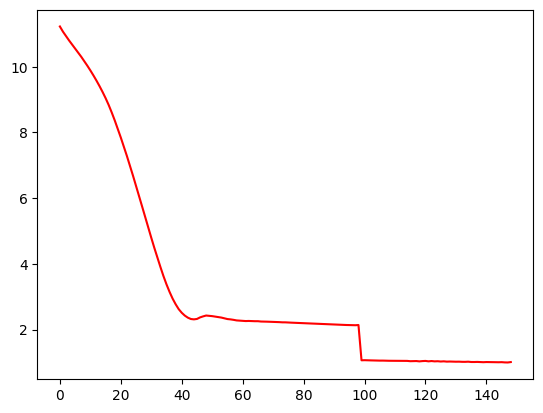

 30%|██▉       | 149/500 [00:16<00:36,  9.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.54676258992805
Dataset Name:  books , AUC Score (contextual):  49.76088726088726
Dataset Name:  books , AUC Score (structural):  40.884908859686306
Dataset Name:  books , AUC Score (joint-type):  47.588522588522586
Dataset Name:  books , AUC Score (structure type):  41.896123821127205
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.588522588522586
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


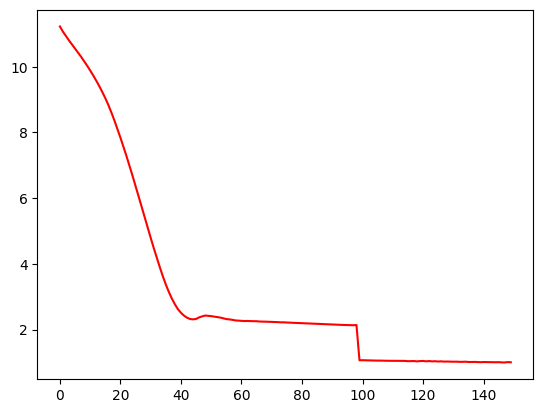

 30%|███       | 150/500 [00:16<00:36,  9.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.70863309352519
Dataset Name:  books , AUC Score (contextual):  48.29568579568579
Dataset Name:  books , AUC Score (structural):  41.7814752013565
Dataset Name:  books , AUC Score (joint-type):  47.29344729344729
Dataset Name:  books , AUC Score (structure type):  42.582915933396514
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.29344729344729
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


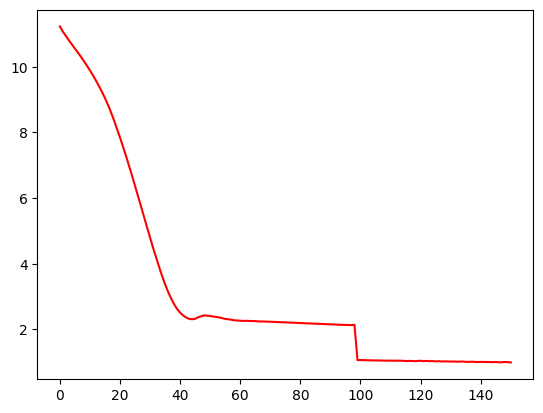

 30%|███       | 151/500 [00:16<00:36,  9.64it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.82168550873587
Dataset Name:  books , AUC Score (contextual):  50.330687830687836
Dataset Name:  books , AUC Score (structural):  42.58266214497669
Dataset Name:  books , AUC Score (joint-type):  45.97069597069597
Dataset Name:  books , AUC Score (structure type):  43.028744190244126
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.97069597069597
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


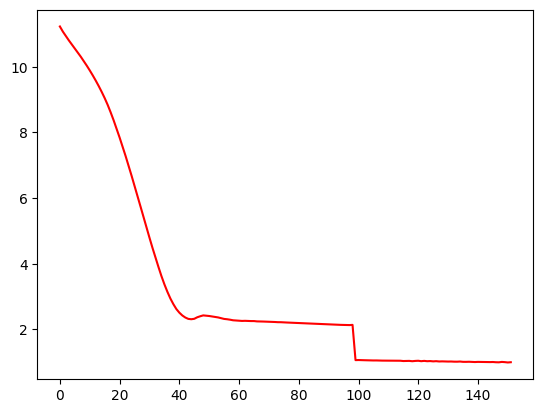

 30%|███       | 152/500 [00:16<00:36,  9.58it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.22764645426516
Dataset Name:  books , AUC Score (contextual):  49.389499389499385
Dataset Name:  books , AUC Score (structural):  41.658541754980924
Dataset Name:  books , AUC Score (joint-type):  46.38278388278388
Dataset Name:  books , AUC Score (structure type):  42.34014710527504
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.38278388278388
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


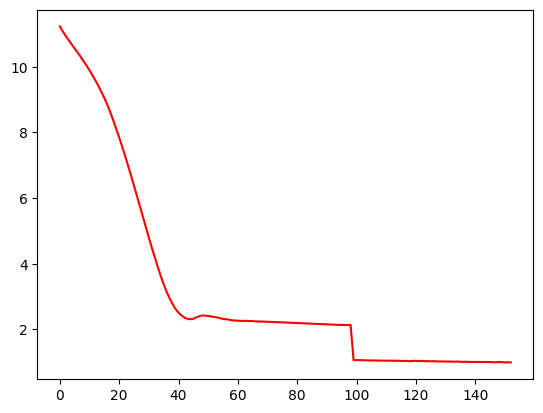

 31%|███       | 153/500 [00:16<00:36,  9.55it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.39773895169579
Dataset Name:  books , AUC Score (contextual):  50.646113146113144
Dataset Name:  books , AUC Score (structural):  41.072488342518014
Dataset Name:  books , AUC Score (joint-type):  46.3013838013838
Dataset Name:  books , AUC Score (structure type):  41.822119940435904
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.3013838013838
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


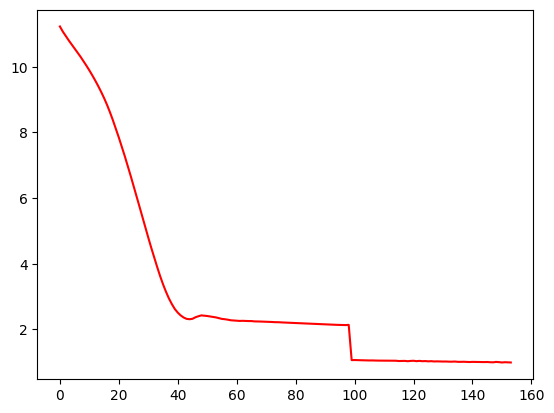

 31%|███       | 154/500 [00:17<00:36,  9.49it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.33350462487154
Dataset Name:  books , AUC Score (contextual):  49.496336996337
Dataset Name:  books , AUC Score (structural):  43.019287833827896
Dataset Name:  books , AUC Score (joint-type):  42.17032967032967
Dataset Name:  books , AUC Score (structure type):  42.73182618112901
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.17032967032967
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


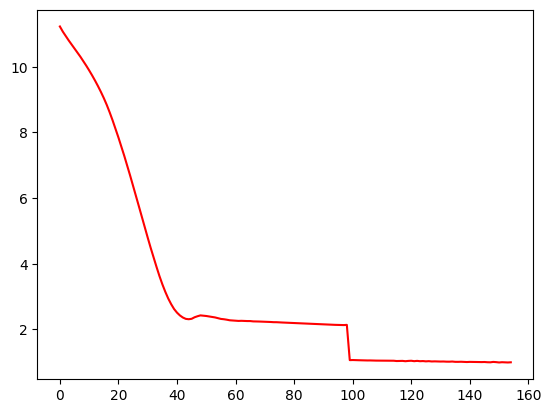

 31%|███       | 155/500 [00:17<00:36,  9.43it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.58273381294964
Dataset Name:  books , AUC Score (contextual):  47.802197802197796
Dataset Name:  books , AUC Score (structural):  42.42157693938109
Dataset Name:  books , AUC Score (joint-type):  47.63939763939764
Dataset Name:  books , AUC Score (structure type):  43.23812102341952
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.63939763939764
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


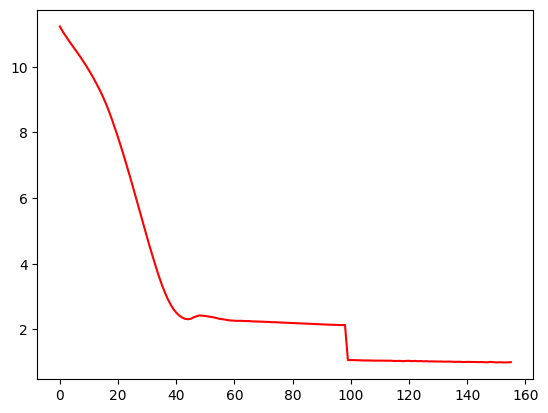

 31%|███       | 156/500 [00:17<01:00,  5.67it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.11973278520041
Dataset Name:  books , AUC Score (contextual):  49.80158730158731
Dataset Name:  books , AUC Score (structural):  41.74438321322595
Dataset Name:  books , AUC Score (joint-type):  45.42633292633293
Dataset Name:  books , AUC Score (structure type):  42.2264338251884
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.42633292633293
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


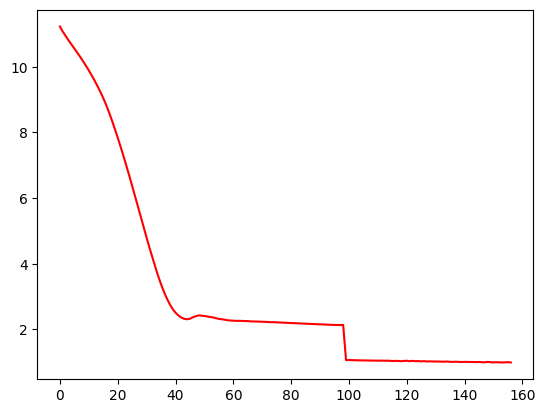

 31%|███▏      | 157/500 [00:17<00:53,  6.39it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.46402877697842
Dataset Name:  books , AUC Score (contextual):  48.81969881969882
Dataset Name:  books , AUC Score (structural):  42.99385332768122
Dataset Name:  books , AUC Score (joint-type):  43.660968660968656
Dataset Name:  books , AUC Score (structure type):  42.97639998195027
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.660968660968656
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


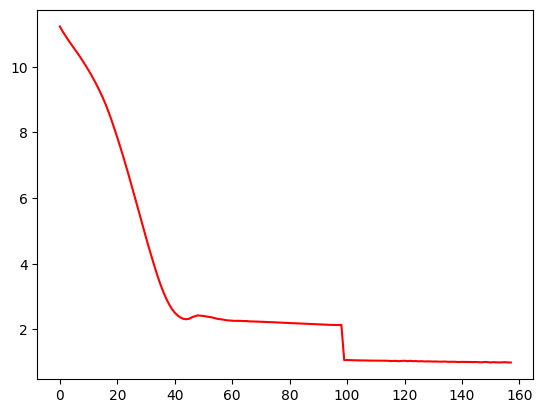

 32%|███▏      | 158/500 [00:17<00:48,  7.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.130010277492296
Dataset Name:  books , AUC Score (contextual):  49.241961741961745
Dataset Name:  books , AUC Score (structural):  41.517592200084785
Dataset Name:  books , AUC Score (joint-type):  45.00915750915752
Dataset Name:  books , AUC Score (structure type):  42.00712964216416
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.00915750915752
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


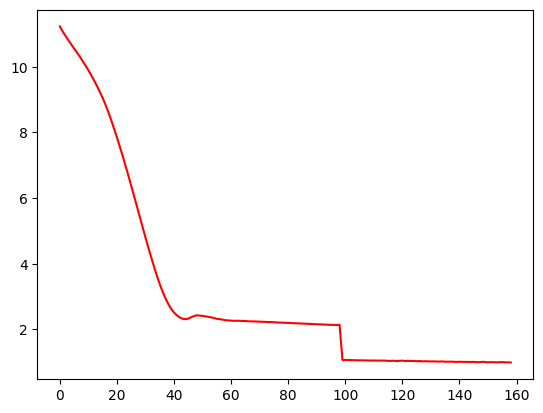

 32%|███▏      | 159/500 [00:17<00:44,  7.67it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.52672147995889
Dataset Name:  books , AUC Score (contextual):  48.16341066341066
Dataset Name:  books , AUC Score (structural):  40.74819838914795
Dataset Name:  books , AUC Score (joint-type):  46.06735856735857
Dataset Name:  books , AUC Score (structure type):  41.51617706782184
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.06735856735857
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


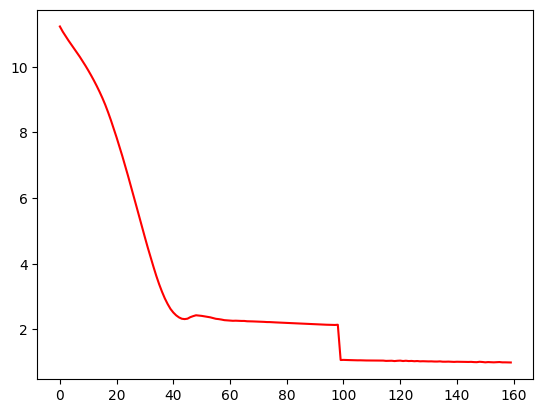

 32%|███▏      | 160/500 [00:17<00:42,  7.96it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.97430626927029
Dataset Name:  books , AUC Score (contextual):  48.73321123321123
Dataset Name:  books , AUC Score (structural):  41.2643069097075
Dataset Name:  books , AUC Score (joint-type):  45.95034595034595
Dataset Name:  books , AUC Score (structure type):  41.91507603447498
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.95034595034595
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


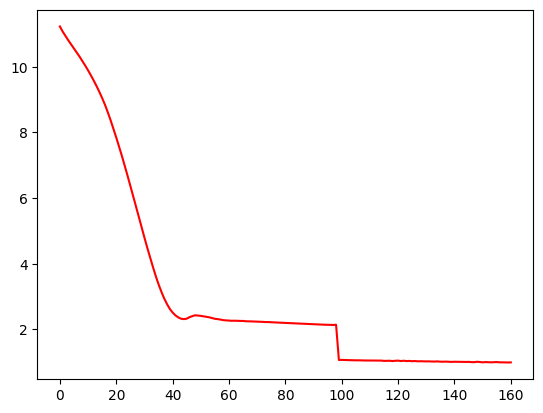

 32%|███▏      | 161/500 [00:18<00:43,  7.87it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.79136690647482
Dataset Name:  books , AUC Score (contextual):  50.34595034595034
Dataset Name:  books , AUC Score (structural):  41.815387876218736
Dataset Name:  books , AUC Score (joint-type):  45.365282865282865
Dataset Name:  books , AUC Score (structure type):  42.33743964622535
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.365282865282865
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


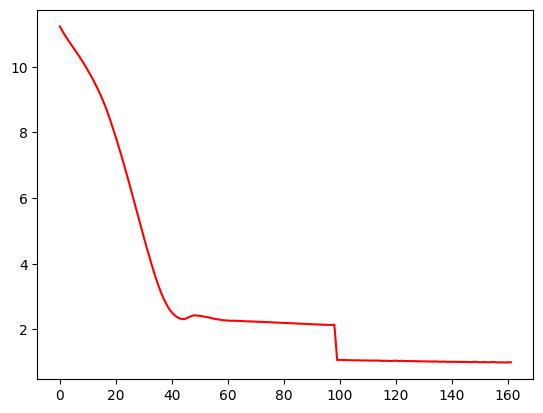

 32%|███▏      | 162/500 [00:18<00:41,  8.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.55447070914698
Dataset Name:  books , AUC Score (contextual):  50.869963369963365
Dataset Name:  books , AUC Score (structural):  42.242475625264944
Dataset Name:  books , AUC Score (joint-type):  44.92775742775743
Dataset Name:  books , AUC Score (structure type):  42.54862145210054
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.92775742775743
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


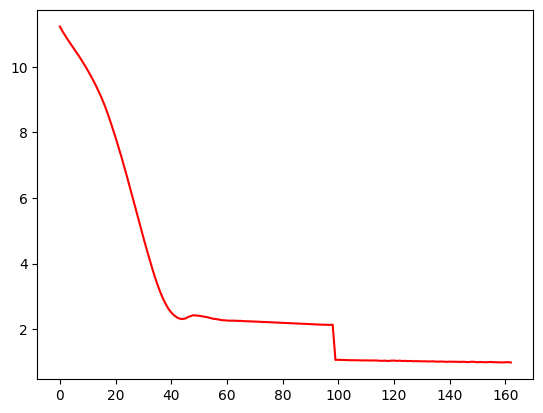

 33%|███▎      | 163/500 [00:18<00:40,  8.30it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.20246659815006
Dataset Name:  books , AUC Score (contextual):  50.427350427350426
Dataset Name:  books , AUC Score (structural):  41.51017380245867
Dataset Name:  books , AUC Score (joint-type):  45.39072039072039
Dataset Name:  books , AUC Score (structure type):  41.97373764721809
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.39072039072039
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


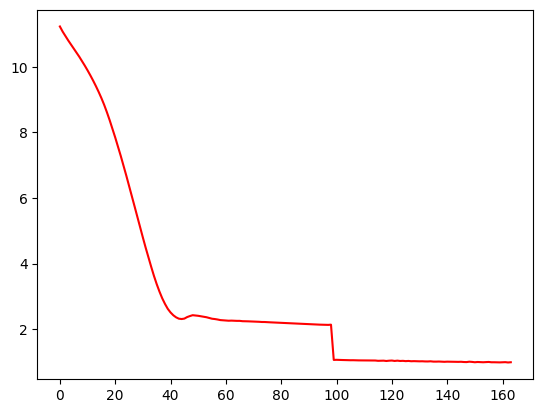

 33%|███▎      | 164/500 [00:18<00:39,  8.47it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.24357656731758
Dataset Name:  books , AUC Score (contextual):  47.975172975172974
Dataset Name:  books , AUC Score (structural):  41.62992793556592
Dataset Name:  books , AUC Score (joint-type):  46.169108669108674
Dataset Name:  books , AUC Score (structure type):  42.26614322458372
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.169108669108674
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


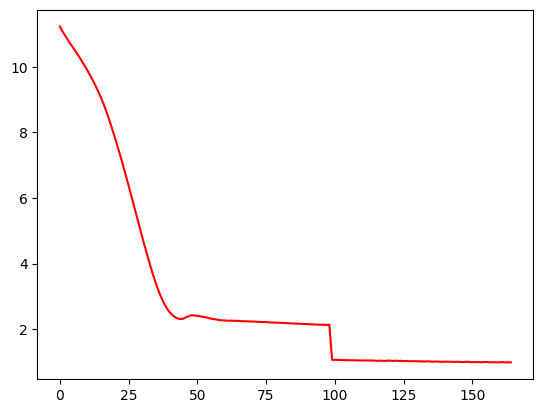

 33%|███▎      | 165/500 [00:18<00:38,  8.71it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.4573484069887
Dataset Name:  books , AUC Score (contextual):  49.69983719983719
Dataset Name:  books , AUC Score (structural):  42.042178889359896
Dataset Name:  books , AUC Score (joint-type):  45.578958078958074
Dataset Name:  books , AUC Score (structure type):  42.51342448445467
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.578958078958074
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


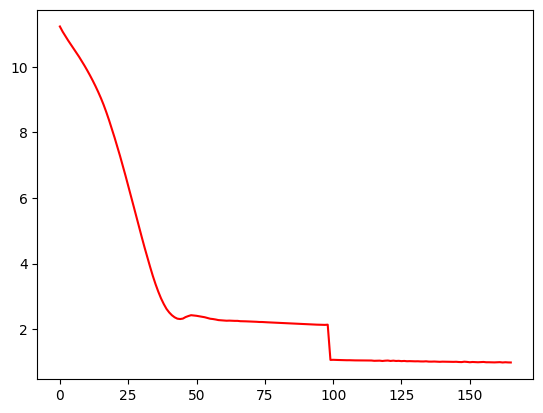

 33%|███▎      | 166/500 [00:18<00:37,  8.88it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.07965056526208
Dataset Name:  books , AUC Score (contextual):  49.25722425722425
Dataset Name:  books , AUC Score (structural):  41.841882153454854
Dataset Name:  books , AUC Score (joint-type):  46.25559625559625
Dataset Name:  books , AUC Score (structure type):  42.4502504399621
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.25559625559625
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


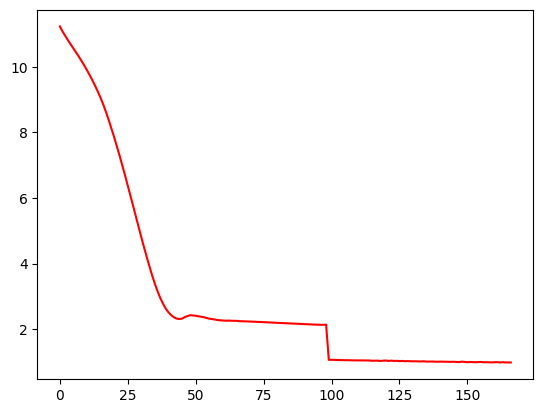

 33%|███▎      | 167/500 [00:18<00:37,  8.93it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.33350462487152
Dataset Name:  books , AUC Score (contextual):  48.48392348392348
Dataset Name:  books , AUC Score (structural):  41.478380669775326
Dataset Name:  books , AUC Score (joint-type):  47.92938542938543
Dataset Name:  books , AUC Score (structure type):  42.451152926311984
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.92938542938543
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


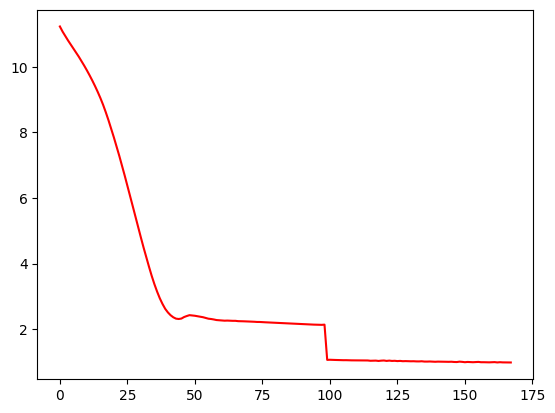

 34%|███▎      | 168/500 [00:18<00:37,  8.94it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.652106885919835
Dataset Name:  books , AUC Score (contextual):  48.438135938135936
Dataset Name:  books , AUC Score (structural):  41.83658329800763
Dataset Name:  books , AUC Score (joint-type):  46.499796499796496
Dataset Name:  books , AUC Score (structure type):  42.490862325707326
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.499796499796496
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


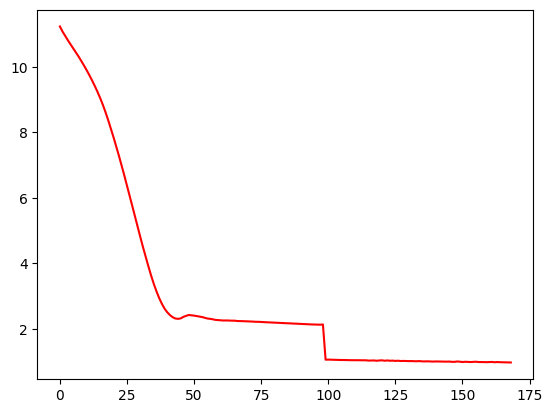

 34%|███▍      | 169/500 [00:18<00:36,  9.00it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.98663926002057
Dataset Name:  books , AUC Score (contextual):  50.63085063085063
Dataset Name:  books , AUC Score (structural):  42.47456549385333
Dataset Name:  books , AUC Score (joint-type):  44.93793243793244
Dataset Name:  books , AUC Score (structure type):  42.74446099002752
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.93793243793244
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


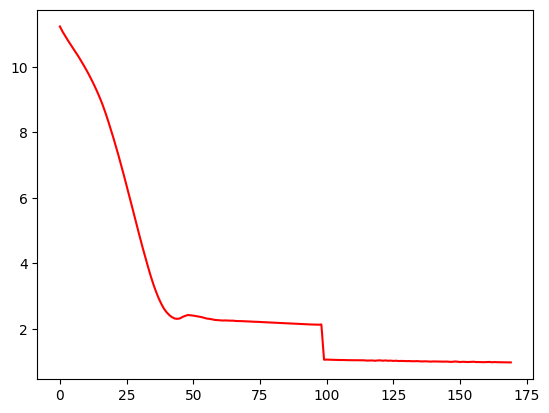

 34%|███▍      | 170/500 [00:19<00:36,  9.00it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.120246659815
Dataset Name:  books , AUC Score (contextual):  49.13512413512414
Dataset Name:  books , AUC Score (structural):  40.98664688427299
Dataset Name:  books , AUC Score (joint-type):  46.881359381359374
Dataset Name:  books , AUC Score (structure type):  41.891611389377736
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.881359381359374
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


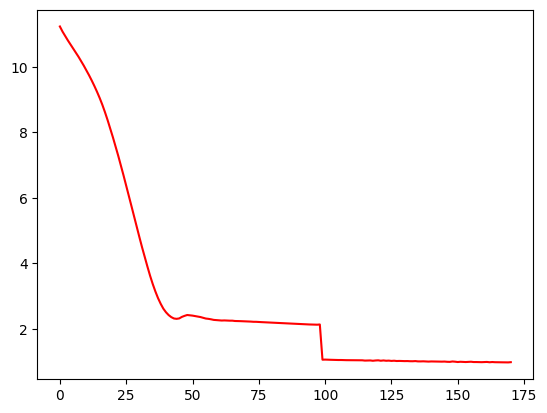

 34%|███▍      | 171/500 [00:19<00:36,  9.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.68345323741007
Dataset Name:  books , AUC Score (contextual):  48.87057387057387
Dataset Name:  books , AUC Score (structural):  41.399957609156424
Dataset Name:  books , AUC Score (joint-type):  44.05270655270655
Dataset Name:  books , AUC Score (structure type):  41.69577185145074
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.05270655270655
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


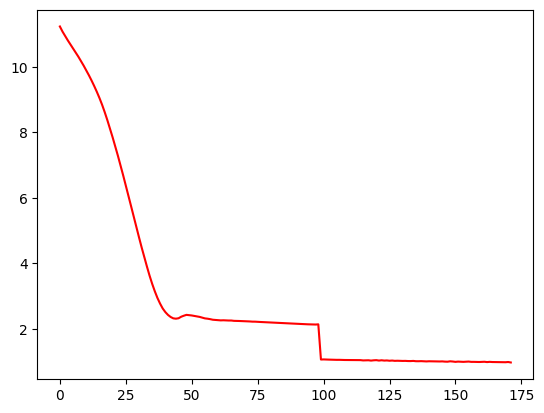

 34%|███▍      | 172/500 [00:19<00:36,  9.07it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.253854059609445
Dataset Name:  books , AUC Score (contextual):  47.33414733414734
Dataset Name:  books , AUC Score (structural):  41.9330224671471
Dataset Name:  books , AUC Score (joint-type):  45.25335775335776
Dataset Name:  books , AUC Score (structure type):  42.33292721447588
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.25335775335776
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


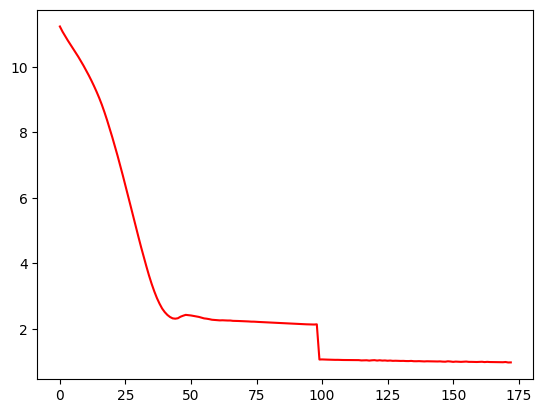

 35%|███▍      | 173/500 [00:19<00:36,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.15827338129497
Dataset Name:  books , AUC Score (contextual):  45.802808302808295
Dataset Name:  books , AUC Score (structural):  41.71682916490038
Dataset Name:  books , AUC Score (joint-type):  46.5964590964591
Dataset Name:  books , AUC Score (structure type):  42.39249131356888
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.5964590964591
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


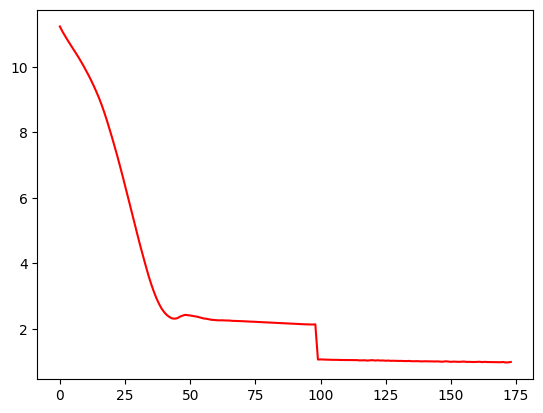

 35%|███▍      | 174/500 [00:19<00:36,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.91726618705036
Dataset Name:  books , AUC Score (contextual):  50.84961334961334
Dataset Name:  books , AUC Score (structural):  42.23081814328105
Dataset Name:  books , AUC Score (joint-type):  45.991045991046
Dataset Name:  books , AUC Score (structure type):  42.728216235729434
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.991045991046
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


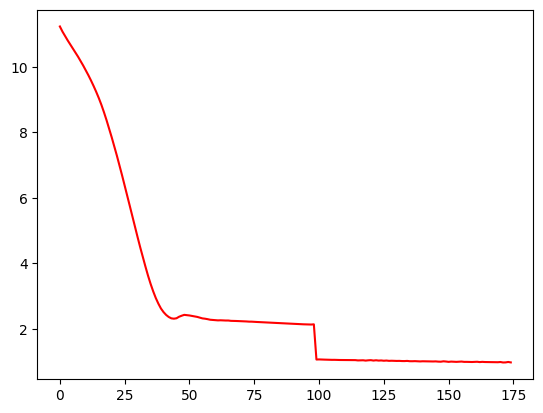

 35%|███▌      | 175/500 [00:19<00:35,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.58838643371017
Dataset Name:  books , AUC Score (contextual):  49.44037444037444
Dataset Name:  books , AUC Score (structural):  42.59008054260279
Dataset Name:  books , AUC Score (joint-type):  45.136345136345135
Dataset Name:  books , AUC Score (structure type):  42.87261405171247
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.136345136345135
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


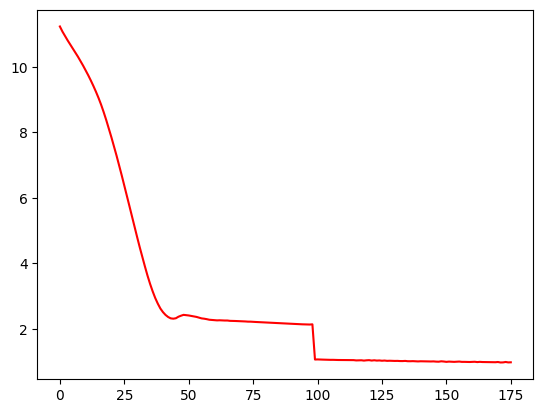

 35%|███▌      | 176/500 [00:19<00:35,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.16906474820144
Dataset Name:  books , AUC Score (contextual):  47.349409849409845
Dataset Name:  books , AUC Score (structural):  41.8429419245443
Dataset Name:  books , AUC Score (joint-type):  47.21204721204721
Dataset Name:  books , AUC Score (structure type):  42.63706511439014
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.21204721204721
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


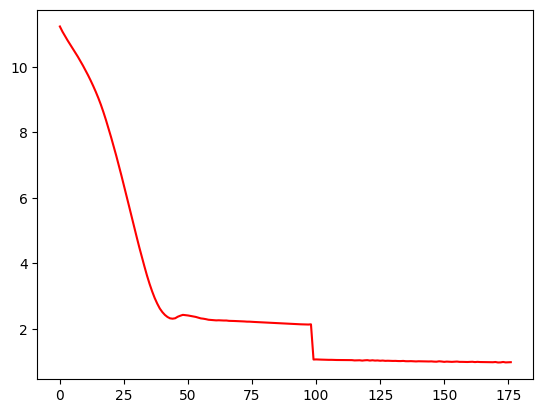

 35%|███▌      | 177/500 [00:19<00:35,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.84018499486126
Dataset Name:  books , AUC Score (contextual):  48.27024827024827
Dataset Name:  books , AUC Score (structural):  40.68885120813904
Dataset Name:  books , AUC Score (joint-type):  45.77228327228327
Dataset Name:  books , AUC Score (structure type):  41.36455936103967
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.77228327228327
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


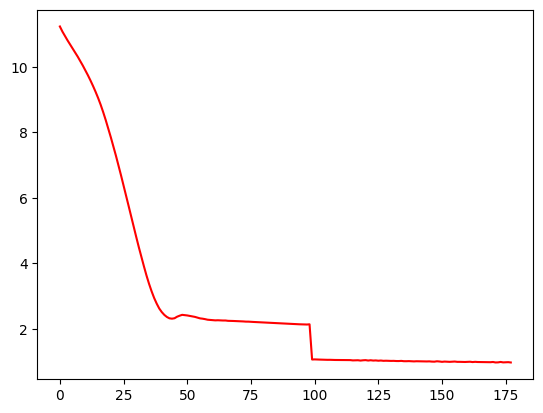

 36%|███▌      | 178/500 [00:19<00:35,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.06423432682425
Dataset Name:  books , AUC Score (contextual):  49.226699226699225
Dataset Name:  books , AUC Score (structural):  41.50699448919033
Dataset Name:  books , AUC Score (joint-type):  45.15160765160765
Dataset Name:  books , AUC Score (structure type):  42.01886196471278
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.15160765160765
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


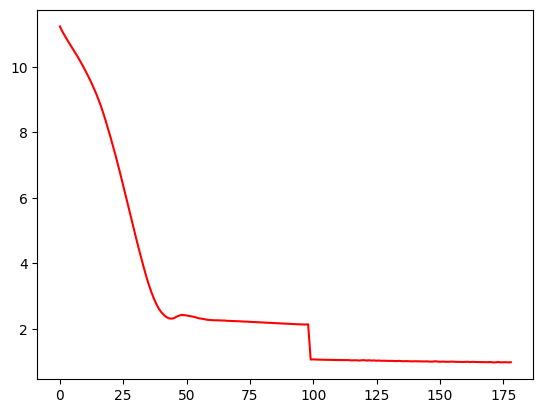

 36%|███▌      | 179/500 [00:20<00:35,  9.12it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.4491264131552
Dataset Name:  books , AUC Score (contextual):  50.641025641025635
Dataset Name:  books , AUC Score (structural):  39.79334463755829
Dataset Name:  books , AUC Score (joint-type):  46.377696377696374
Dataset Name:  books , AUC Score (structure type):  40.777040747258695
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.377696377696374
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


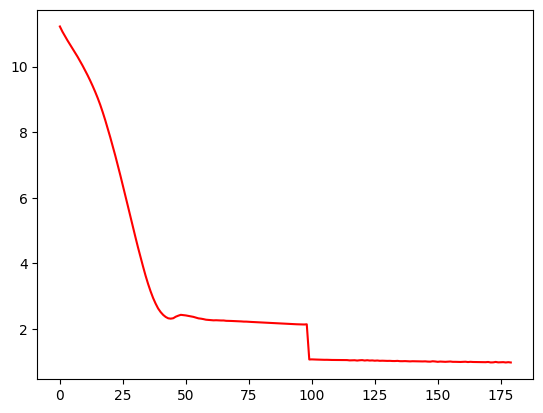

 36%|███▌      | 180/500 [00:20<00:35,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.67009249743063
Dataset Name:  books , AUC Score (contextual):  48.85022385022385
Dataset Name:  books , AUC Score (structural):  41.871555743959306
Dataset Name:  books , AUC Score (joint-type):  46.31664631664632
Dataset Name:  books , AUC Score (structure type):  42.516131943504355
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.31664631664632
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


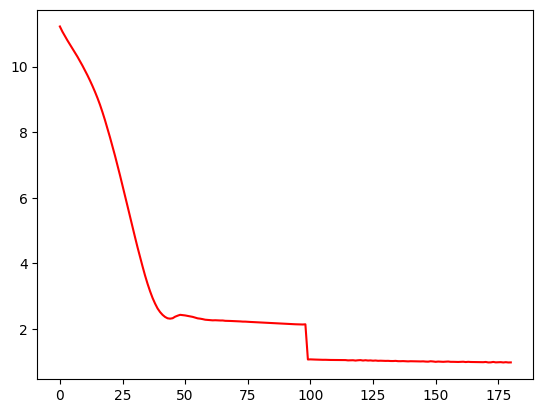

 36%|███▌      | 181/500 [00:20<00:35,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.81963001027751
Dataset Name:  books , AUC Score (contextual):  49.27248677248677
Dataset Name:  books , AUC Score (structural):  41.62568885120814
Dataset Name:  books , AUC Score (joint-type):  45.416157916157914
Dataset Name:  books , AUC Score (structure type):  42.15242994449709
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.416157916157914
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


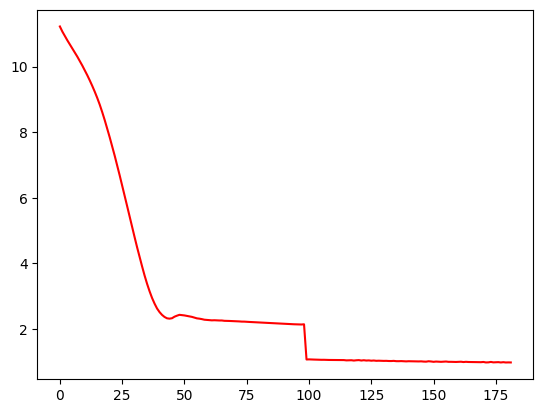

 36%|███▋      | 182/500 [00:20<00:34,  9.18it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.88437821171634
Dataset Name:  books , AUC Score (contextual):  51.14977614977616
Dataset Name:  books , AUC Score (structural):  42.45866892751166
Dataset Name:  books , AUC Score (joint-type):  43.935693935693934
Dataset Name:  books , AUC Score (structure type):  42.62623527819142
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.935693935693934
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


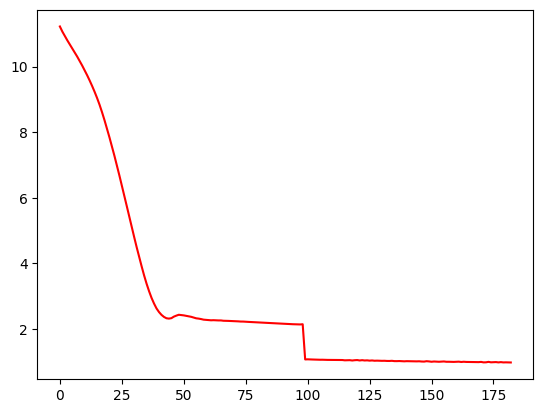

 37%|███▋      | 183/500 [00:20<00:34,  9.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.61664953751284
Dataset Name:  books , AUC Score (contextual):  50.31542531542531
Dataset Name:  books , AUC Score (structural):  39.97774480712166
Dataset Name:  books , AUC Score (joint-type):  45.85877085877086
Dataset Name:  books , AUC Score (structure type):  40.86187446414873
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.85877085877086
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


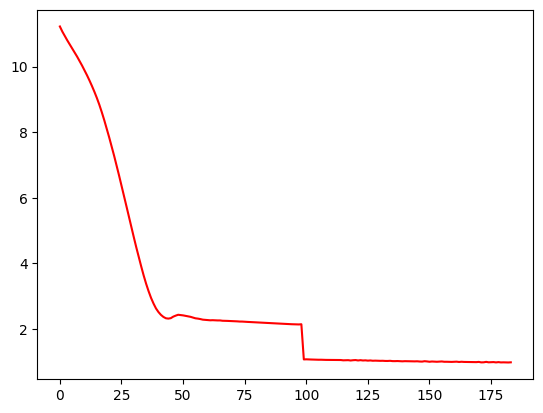

 37%|███▋      | 184/500 [00:20<00:34,  9.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.95837615621789
Dataset Name:  books , AUC Score (contextual):  49.15547415547415
Dataset Name:  books , AUC Score (structural):  41.36074607884698
Dataset Name:  books , AUC Score (joint-type):  42.75030525030525
Dataset Name:  books , AUC Score (structure type):  41.5080546906728
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.75030525030525
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


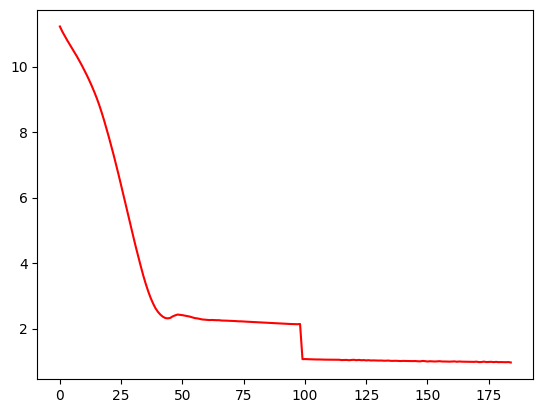

 37%|███▋      | 185/500 [00:20<00:34,  9.13it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.31346351490237
Dataset Name:  books , AUC Score (contextual):  52.7981277981278
Dataset Name:  books , AUC Score (structural):  42.36540907164053
Dataset Name:  books , AUC Score (joint-type):  44.03744403744404
Dataset Name:  books , AUC Score (structure type):  42.510717025404986
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.03744403744404
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


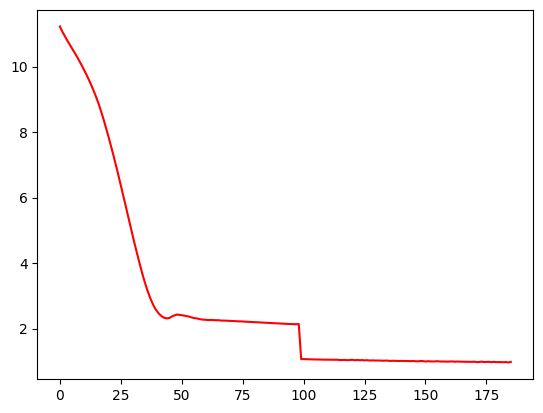

 37%|███▋      | 186/500 [00:20<00:34,  9.13it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.17677286742036
Dataset Name:  books , AUC Score (contextual):  45.935083435083435
Dataset Name:  books , AUC Score (structural):  41.52818991097923
Dataset Name:  books , AUC Score (joint-type):  45.04477004477005
Dataset Name:  books , AUC Score (structure type):  42.127160326700064
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.04477004477005
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


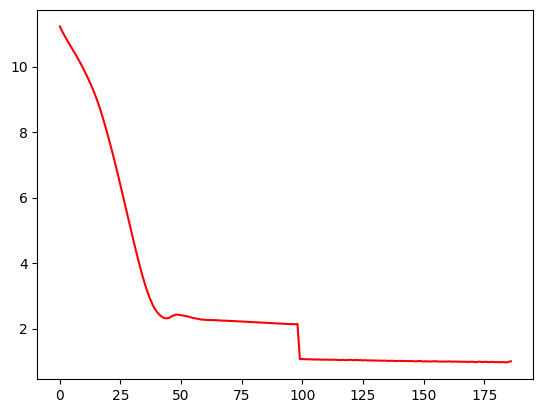

 37%|███▋      | 187/500 [00:20<00:34,  9.09it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.8884892086331
Dataset Name:  books , AUC Score (contextual):  52.40130240130241
Dataset Name:  books , AUC Score (structural):  40.897626112759646
Dataset Name:  books , AUC Score (joint-type):  44.31725681725682
Dataset Name:  books , AUC Score (structure type):  41.40787870583458
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.31725681725682
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


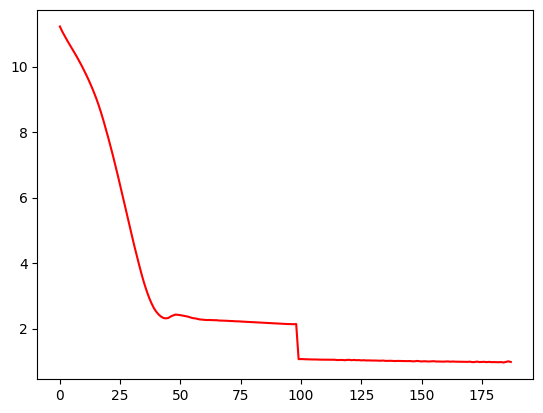

 38%|███▊      | 188/500 [00:20<00:34,  9.10it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.50822199383351
Dataset Name:  books , AUC Score (contextual):  53.428978428978425
Dataset Name:  books , AUC Score (structural):  42.52649427723612
Dataset Name:  books , AUC Score (joint-type):  45.421245421245416
Dataset Name:  books , AUC Score (structure type):  42.89246875141013
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.421245421245416
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


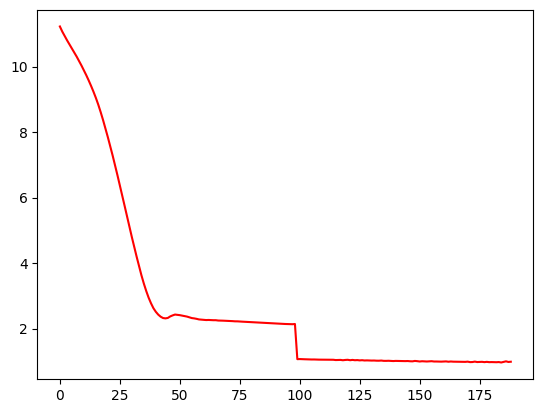

 38%|███▊      | 189/500 [00:21<00:34,  9.12it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.67009249743063
Dataset Name:  books , AUC Score (contextual):  48.51444851444851
Dataset Name:  books , AUC Score (structural):  41.42751165748199
Dataset Name:  books , AUC Score (joint-type):  45.772283272283275
Dataset Name:  books , AUC Score (structure type):  42.103695681602815
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.772283272283275
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


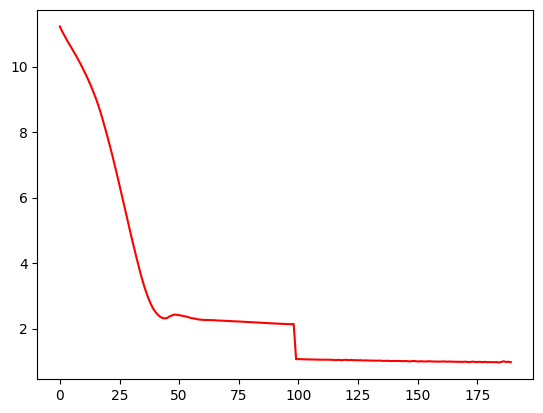

 38%|███▊      | 190/500 [00:21<00:33,  9.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.968653648509765
Dataset Name:  books , AUC Score (contextual):  45.73667073667074
Dataset Name:  books , AUC Score (structural):  41.688215345485375
Dataset Name:  books , AUC Score (joint-type):  46.85592185592185
Dataset Name:  books , AUC Score (structure type):  42.55042642480033
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.85592185592185
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


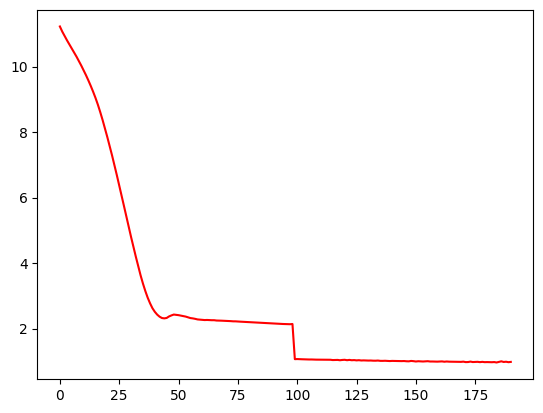

 38%|███▊      | 191/500 [00:21<00:33,  9.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.88900308324769
Dataset Name:  books , AUC Score (contextual):  47.405372405372404
Dataset Name:  books , AUC Score (structural):  39.88766426451886
Dataset Name:  books , AUC Score (joint-type):  45.11090761090762
Dataset Name:  books , AUC Score (structure type):  40.70123189386761
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.11090761090762
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


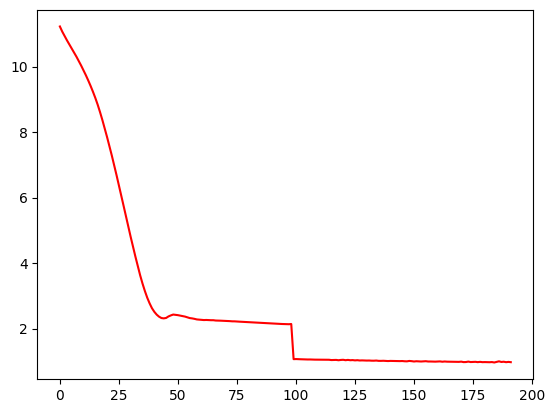

 38%|███▊      | 192/500 [00:21<00:33,  9.12it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.601233299075034
Dataset Name:  books , AUC Score (contextual):  49.02828652828653
Dataset Name:  books , AUC Score (structural):  41.250529885544715
Dataset Name:  books , AUC Score (joint-type):  47.03907203907204
Dataset Name:  books , AUC Score (structure type):  42.09918324985335
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.03907203907204
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


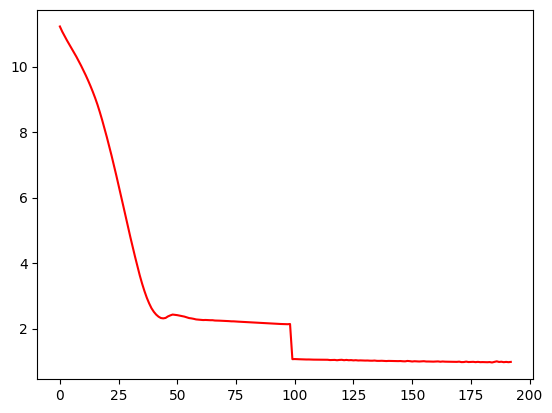

 39%|███▊      | 193/500 [00:21<00:34,  8.87it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.00668036998973
Dataset Name:  books , AUC Score (contextual):  50.24420024420024
Dataset Name:  books , AUC Score (structural):  40.01165748198389
Dataset Name:  books , AUC Score (joint-type):  44.55128205128205
Dataset Name:  books , AUC Score (structure type):  40.62903298587609
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.55128205128205
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


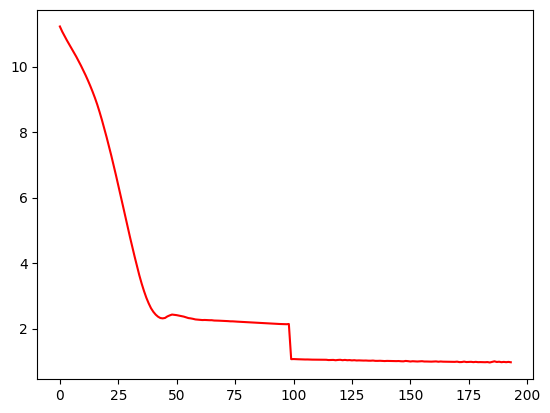

 39%|███▉      | 194/500 [00:21<00:36,  8.44it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.702980472764644
Dataset Name:  books , AUC Score (contextual):  48.35673585673585
Dataset Name:  books , AUC Score (structural):  41.20919881305638
Dataset Name:  books , AUC Score (joint-type):  45.263532763532766
Dataset Name:  books , AUC Score (structure type):  41.7183340101981
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.263532763532766
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


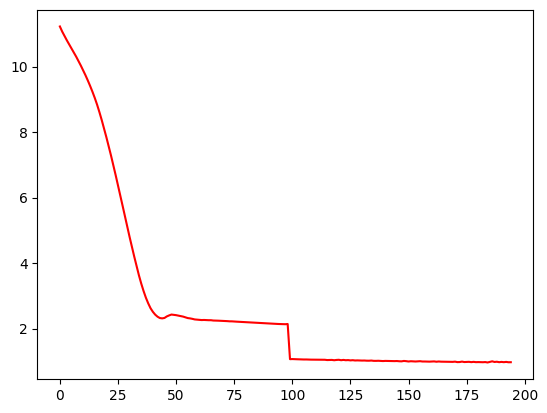

 39%|███▉      | 195/500 [00:21<00:37,  8.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.21531346351491
Dataset Name:  books , AUC Score (contextual):  49.506512006512004
Dataset Name:  books , AUC Score (structural):  41.08202628232303
Dataset Name:  books , AUC Score (joint-type):  45.45177045177044
Dataset Name:  books , AUC Score (structure type):  41.665989801904246
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.45177045177044
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


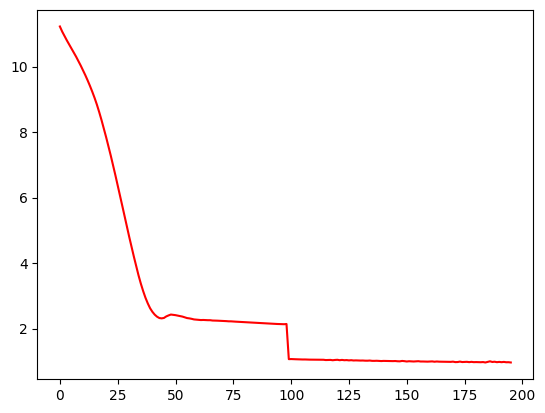

 39%|███▉      | 196/500 [00:21<00:36,  8.36it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.717368961973285
Dataset Name:  books , AUC Score (contextual):  49.83719983719984
Dataset Name:  books , AUC Score (structural):  41.53242899533701
Dataset Name:  books , AUC Score (joint-type):  45.136345136345135
Dataset Name:  books , AUC Score (structure type):  42.00532466946437
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.136345136345135
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


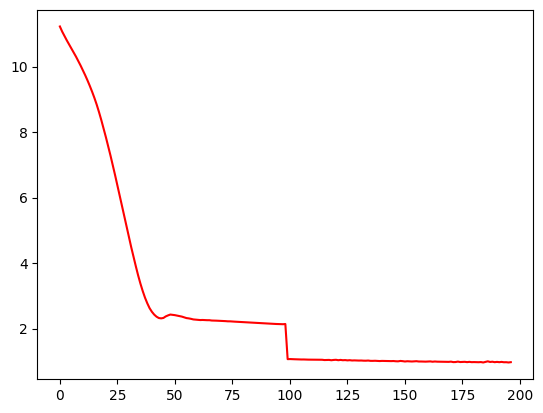

 39%|███▉      | 197/500 [00:22<00:35,  8.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.38283658787256
Dataset Name:  books , AUC Score (contextual):  50.92083842083842
Dataset Name:  books , AUC Score (structural):  39.901441288681646
Dataset Name:  books , AUC Score (joint-type):  45.47212047212047
Dataset Name:  books , AUC Score (structure type):  40.77252831550923
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.47212047212047
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


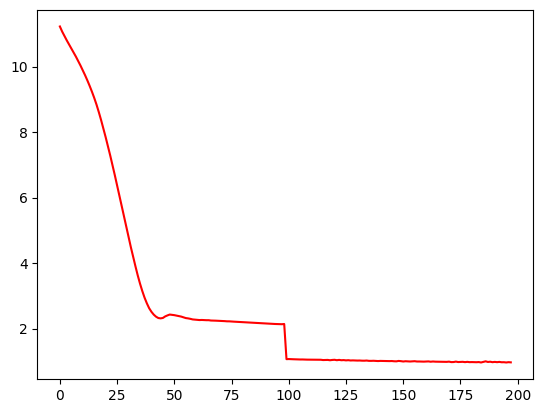

 40%|███▉      | 198/500 [00:22<00:35,  8.48it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.36176772867421
Dataset Name:  books , AUC Score (contextual):  48.300773300773294
Dataset Name:  books , AUC Score (structural):  40.61466723187791
Dataset Name:  books , AUC Score (joint-type):  42.68925518925519
Dataset Name:  books , AUC Score (structure type):  40.89436397274491
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.68925518925519
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


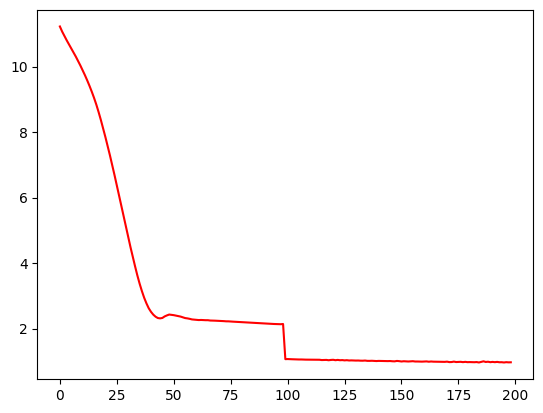

 40%|███▉      | 199/500 [00:22<00:36,  8.22it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.947584789311406
Dataset Name:  books , AUC Score (contextual):  48.61111111111111
Dataset Name:  books , AUC Score (structural):  41.82068673166596
Dataset Name:  books , AUC Score (joint-type):  43.386243386243386
Dataset Name:  books , AUC Score (structure type):  41.97283516086819
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.386243386243386
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


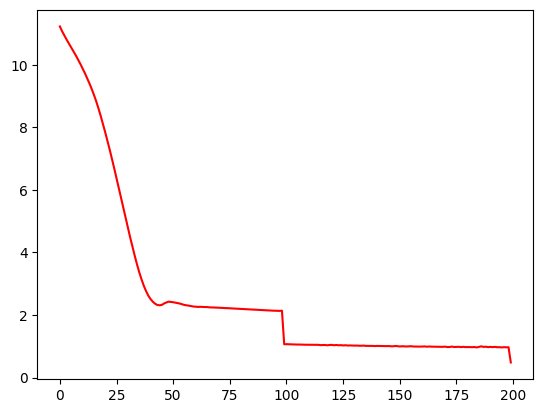

 40%|████      | 200/500 [00:22<00:36,  8.24it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.26618705035971
Dataset Name:  books , AUC Score (contextual):  48.58058608058608
Dataset Name:  books , AUC Score (structural):  43.24713861805849
Dataset Name:  books , AUC Score (joint-type):  44.00691900691901
Dataset Name:  books , AUC Score (structure type):  43.3166373358603
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.00691900691901
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


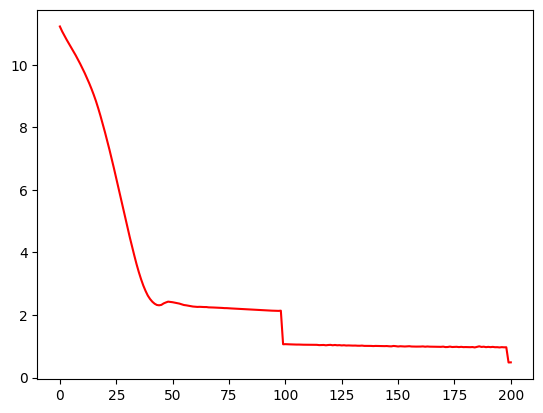

 40%|████      | 201/500 [00:22<00:35,  8.33it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.13514902363823
Dataset Name:  books , AUC Score (contextual):  47.79202279202279
Dataset Name:  books , AUC Score (structural):  42.24671470962272
Dataset Name:  books , AUC Score (joint-type):  43.498168498168496
Dataset Name:  books , AUC Score (structure type):  42.354586886873335
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.498168498168496
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


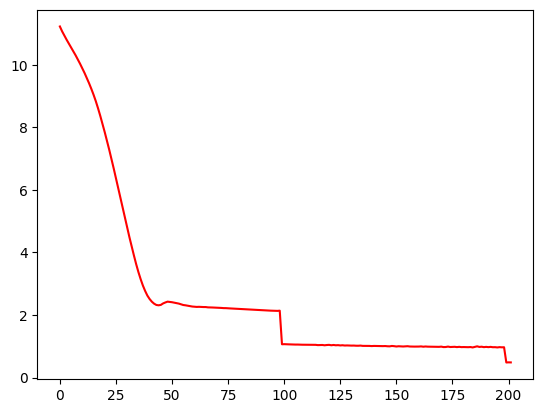

 40%|████      | 202/500 [00:22<00:35,  8.41it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.75231243576567
Dataset Name:  books , AUC Score (contextual):  47.26800976800977
Dataset Name:  books , AUC Score (structural):  41.30987706655362
Dataset Name:  books , AUC Score (joint-type):  45.7977207977208
Dataset Name:  books , AUC Score (structure type):  41.95117548847074
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.7977207977208
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


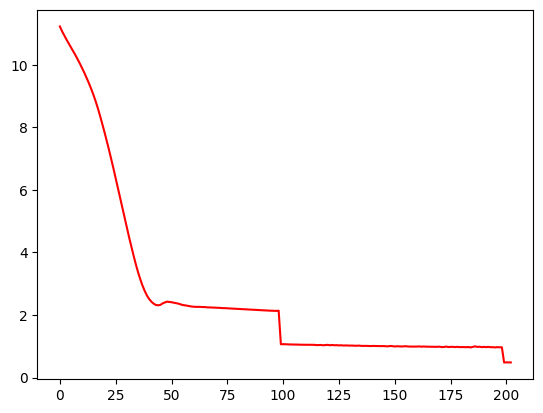

 41%|████      | 203/500 [00:23<01:03,  4.65it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.77286742034943
Dataset Name:  books , AUC Score (contextual):  46.76434676434676
Dataset Name:  books , AUC Score (structural):  40.72064434082239
Dataset Name:  books , AUC Score (joint-type):  45.36019536019536
Dataset Name:  books , AUC Score (structure type):  41.48729750462524
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.36019536019536
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


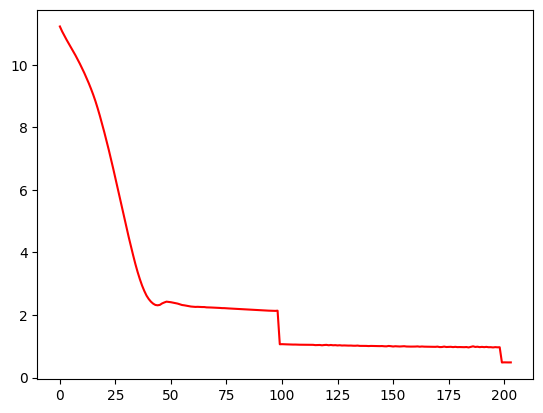

 41%|████      | 204/500 [00:23<00:55,  5.38it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.91212744090443
Dataset Name:  books , AUC Score (contextual):  47.817460317460316
Dataset Name:  books , AUC Score (structural):  40.40589232725731
Dataset Name:  books , AUC Score (joint-type):  44.67338217338217
Dataset Name:  books , AUC Score (structure type):  41.0161996299806
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.67338217338217
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


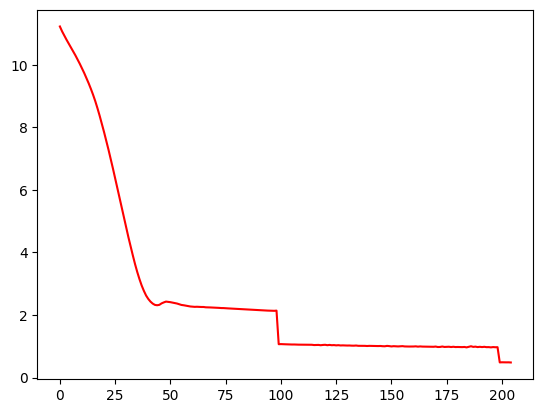

 41%|████      | 205/500 [00:23<00:49,  5.99it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.86587872559096
Dataset Name:  books , AUC Score (contextual):  48.27024827024827
Dataset Name:  books , AUC Score (structural):  41.53348876642645
Dataset Name:  books , AUC Score (joint-type):  41.778591778591775
Dataset Name:  books , AUC Score (structure type):  41.43224583728171
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.778591778591775
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


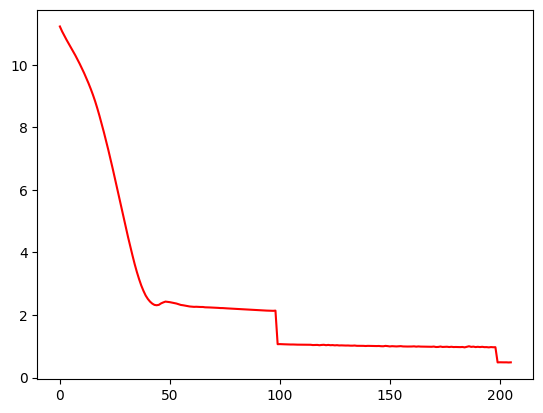

 41%|████      | 206/500 [00:23<00:43,  6.78it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.603802672148
Dataset Name:  books , AUC Score (contextual):  49.628612128612126
Dataset Name:  books , AUC Score (structural):  40.89020771513353
Dataset Name:  books , AUC Score (joint-type):  44.525844525844526
Dataset Name:  books , AUC Score (structure type):  41.374486710888505
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.525844525844526
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


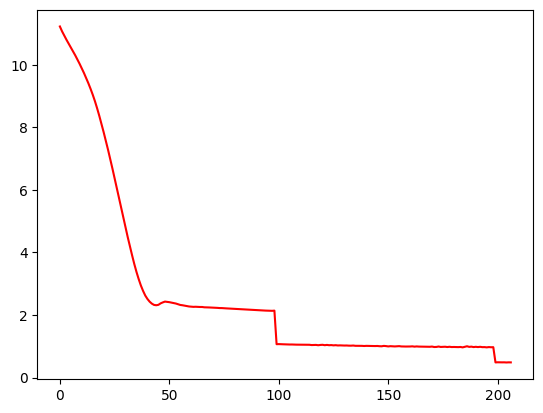

 41%|████▏     | 207/500 [00:23<00:39,  7.44it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.47790339157246
Dataset Name:  books , AUC Score (contextual):  48.667073667073666
Dataset Name:  books , AUC Score (structural):  39.29207291225095
Dataset Name:  books , AUC Score (joint-type):  45.07020757020757
Dataset Name:  books , AUC Score (structure type):  40.183204729028475
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.07020757020757
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


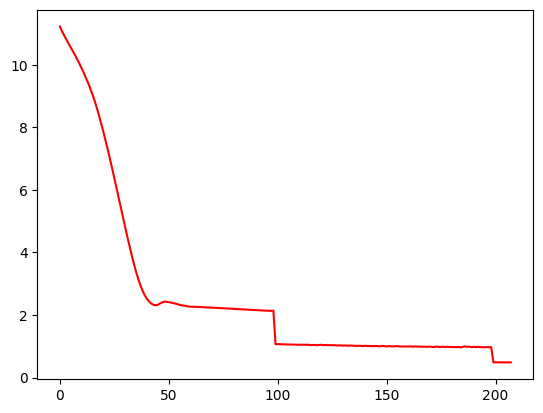

 42%|████▏     | 208/500 [00:23<00:36,  8.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.117677286742044
Dataset Name:  books , AUC Score (contextual):  47.95991045991045
Dataset Name:  books , AUC Score (structural):  40.08266214497669
Dataset Name:  books , AUC Score (joint-type):  45.12617012617012
Dataset Name:  books , AUC Score (structure type):  40.778845719958476
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.12617012617012
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


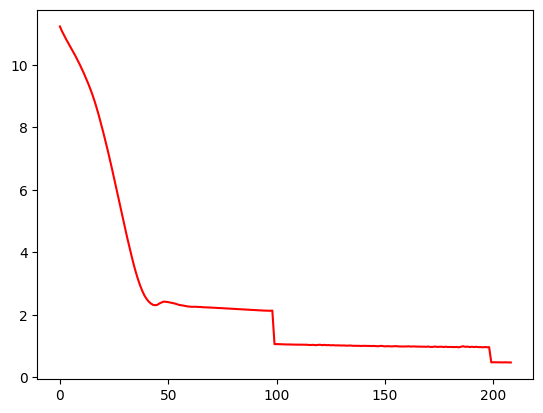

 42%|████▏     | 209/500 [00:23<00:34,  8.49it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.05344295991779
Dataset Name:  books , AUC Score (contextual):  48.92399267399268
Dataset Name:  books , AUC Score (structural):  40.37515896566342
Dataset Name:  books , AUC Score (joint-type):  45.243182743182736
Dataset Name:  books , AUC Score (structure type):  41.04146924777763
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.243182743182736
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


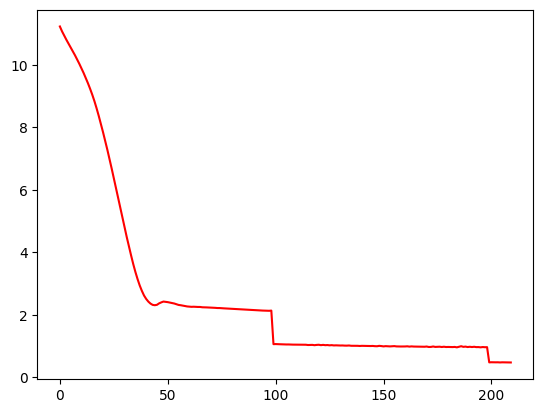

 42%|████▏     | 210/500 [00:23<00:33,  8.65it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.51593011305242
Dataset Name:  books , AUC Score (contextual):  48.05148555148555
Dataset Name:  books , AUC Score (structural):  42.49470114455278
Dataset Name:  books , AUC Score (joint-type):  44.48005698005698
Dataset Name:  books , AUC Score (structure type):  42.73543612652858
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.48005698005698
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


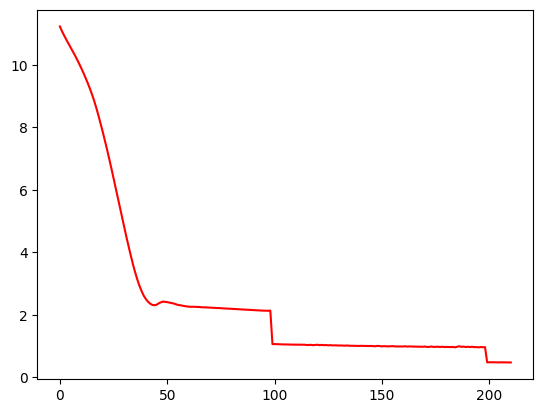

 42%|████▏     | 211/500 [00:23<00:32,  8.91it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.094039054470706
Dataset Name:  books , AUC Score (contextual):  48.046398046398046
Dataset Name:  books , AUC Score (structural):  42.27532852903772
Dataset Name:  books , AUC Score (joint-type):  44.296906796906796
Dataset Name:  books , AUC Score (structure type):  42.51071702540499
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.296906796906796
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


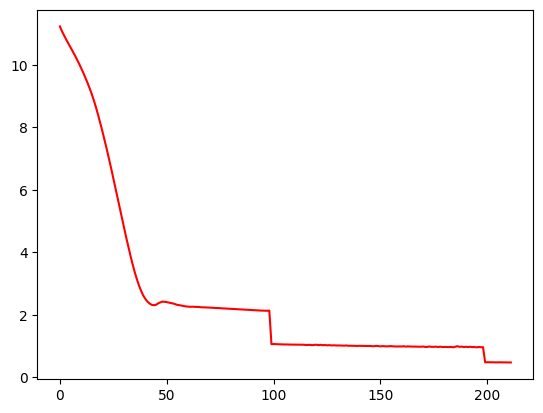

Dataset Name:  books , AUC Score(benchmark/combined):  62.49743062692703
Dataset Name:  books , AUC Score (contextual):  47.39519739519739
Dataset Name:  books , AUC Score (structural):  40.22467147096227
Dataset Name:  books , AUC Score (joint-type):  43.34554334554335
Dataset Name:  books , AUC Score (structure type):  40.595640990930015
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.34554334554335
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


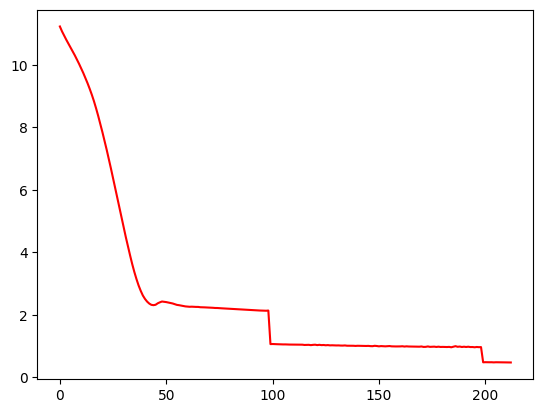

 43%|████▎     | 213/500 [00:24<00:30,  9.34it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.31243576567318
Dataset Name:  books , AUC Score (contextual):  47.44607244607244
Dataset Name:  books , AUC Score (structural):  39.68312844425604
Dataset Name:  books , AUC Score (joint-type):  44.17989417989418
Dataset Name:  books , AUC Score (structure type):  40.261721041469244
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.17989417989418
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


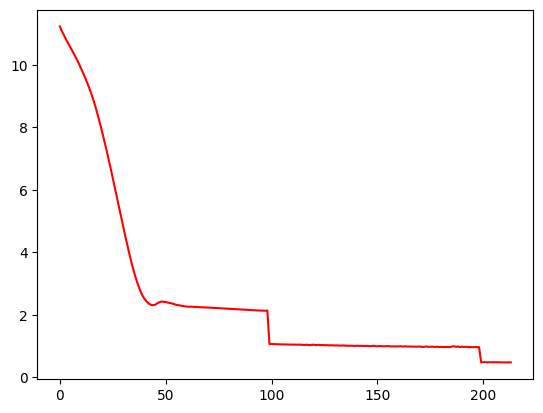

 43%|████▎     | 214/500 [00:24<00:30,  9.49it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.06577595066805
Dataset Name:  books , AUC Score (contextual):  48.6975986975987
Dataset Name:  books , AUC Score (structural):  39.785926239932174
Dataset Name:  books , AUC Score (joint-type):  44.62759462759462
Dataset Name:  books , AUC Score (structure type):  40.41694869365101
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.62759462759462
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


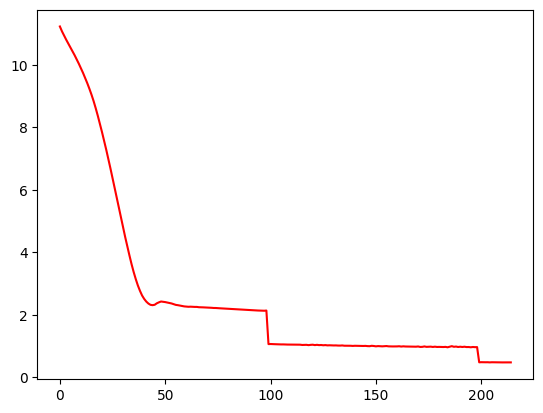

 43%|████▎     | 215/500 [00:24<00:30,  9.24it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.0349434737924
Dataset Name:  books , AUC Score (contextual):  48.62637362637363
Dataset Name:  books , AUC Score (structural):  41.46672318779144
Dataset Name:  books , AUC Score (joint-type):  43.21835571835572
Dataset Name:  books , AUC Score (structure type):  41.59288840756283
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.21835571835572
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


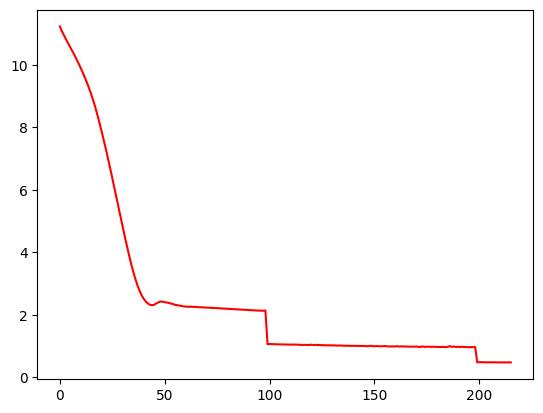

 43%|████▎     | 216/500 [00:24<00:31,  9.13it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.82682425488181
Dataset Name:  books , AUC Score (contextual):  49.81176231176231
Dataset Name:  books , AUC Score (structural):  41.255828740991944
Dataset Name:  books , AUC Score (joint-type):  43.12678062678062
Dataset Name:  books , AUC Score (structure type):  41.344704661342
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.12678062678062
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


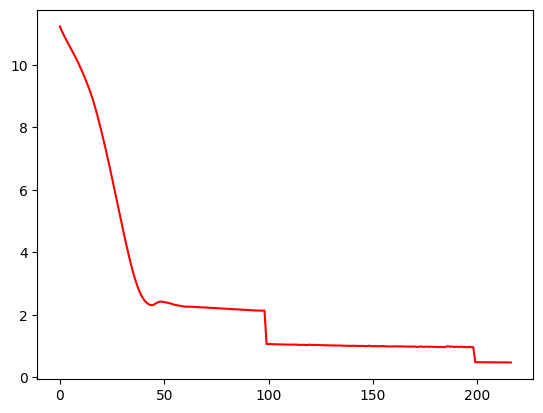

 43%|████▎     | 217/500 [00:24<00:30,  9.18it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.42291880781089
Dataset Name:  books , AUC Score (contextual):  48.85531135531136
Dataset Name:  books , AUC Score (structural):  40.59877066553624
Dataset Name:  books , AUC Score (joint-type):  44.55128205128205
Dataset Name:  books , AUC Score (structure type):  41.064031406524975
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.55128205128205
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


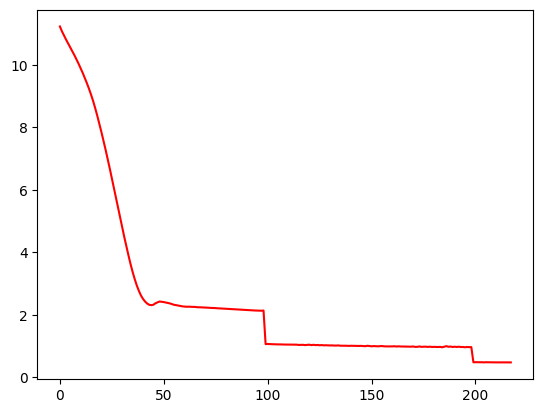

 44%|████▎     | 218/500 [00:24<00:30,  9.13it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.36433710174718
Dataset Name:  books , AUC Score (contextual):  49.54212454212454
Dataset Name:  books , AUC Score (structural):  39.87070792708775
Dataset Name:  books , AUC Score (joint-type):  44.56654456654457
Dataset Name:  books , AUC Score (structure type):  40.39619150760345
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.56654456654457
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


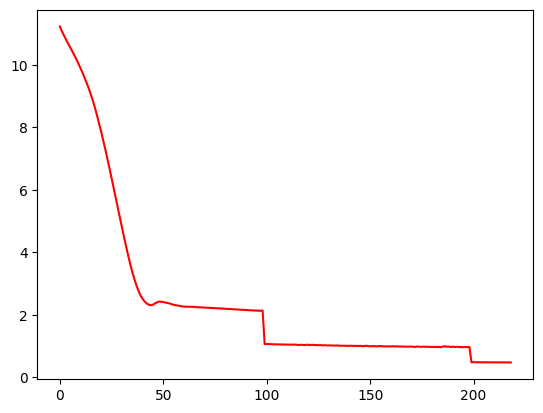

 44%|████▍     | 219/500 [00:24<00:31,  8.85it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.84994861253854
Dataset Name:  books , AUC Score (contextual):  47.84798534798535
Dataset Name:  books , AUC Score (structural):  40.27660025434506
Dataset Name:  books , AUC Score (joint-type):  46.2962962962963
Dataset Name:  books , AUC Score (structure type):  41.08478859257253
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.2962962962963
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


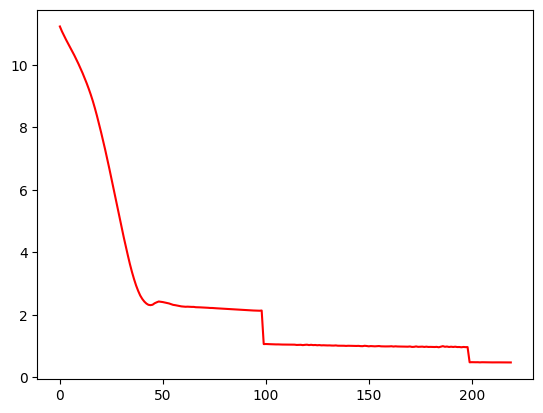

 44%|████▍     | 220/500 [00:24<00:31,  9.03it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.181911613566285
Dataset Name:  books , AUC Score (contextual):  48.555148555148556
Dataset Name:  books , AUC Score (structural):  40.53730394234845
Dataset Name:  books , AUC Score (joint-type):  43.996743996743994
Dataset Name:  books , AUC Score (structure type):  40.87360678669736
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.996743996743994
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


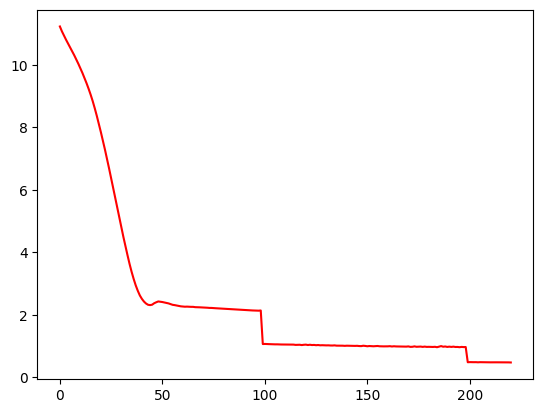

 44%|████▍     | 221/500 [00:25<00:30,  9.27it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.14337101747173
Dataset Name:  books , AUC Score (contextual):  48.097273097273096
Dataset Name:  books , AUC Score (structural):  40.70262823230182
Dataset Name:  books , AUC Score (joint-type):  42.0991045991046
Dataset Name:  books , AUC Score (structure type):  40.75538107486125
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.0991045991046
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


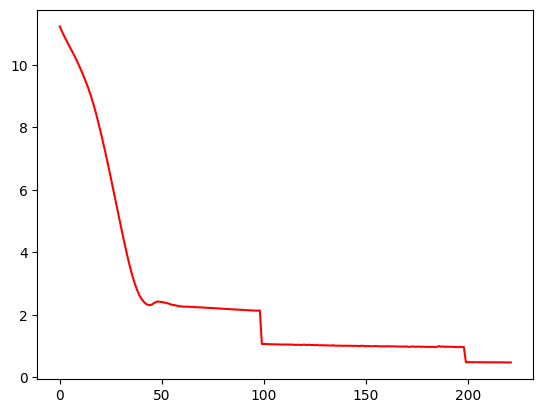

 44%|████▍     | 222/500 [00:25<00:29,  9.44it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.05087358684481
Dataset Name:  books , AUC Score (contextual):  47.45624745624746
Dataset Name:  books , AUC Score (structural):  40.59877066553624
Dataset Name:  books , AUC Score (joint-type):  43.248880748880744
Dataset Name:  books , AUC Score (structure type):  40.89797391814449
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.248880748880744
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


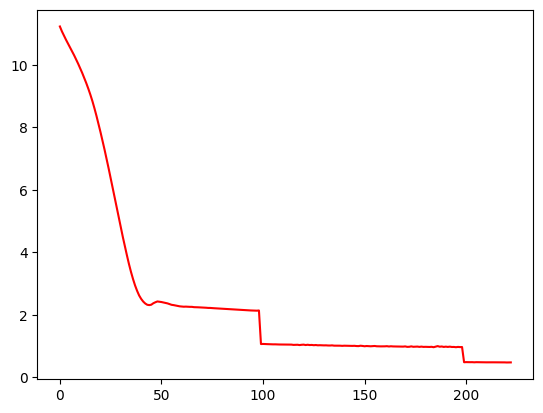

Dataset Name:  books , AUC Score(benchmark/combined):  61.873072970195274
Dataset Name:  books , AUC Score (contextual):  47.634310134310134
Dataset Name:  books , AUC Score (structural):  40.44934294192454
Dataset Name:  books , AUC Score (joint-type):  44.352869352869355
Dataset Name:  books , AUC Score (structure type):  40.90609629529354
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.352869352869355
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


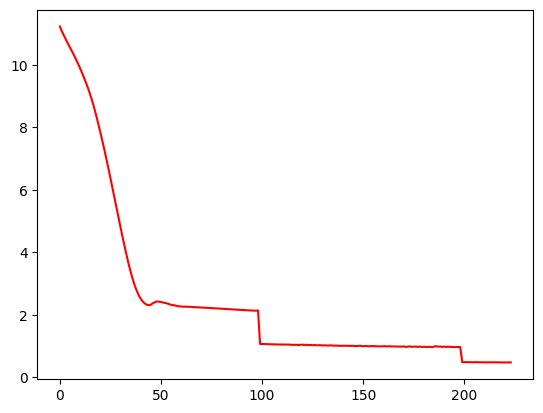

 45%|████▍     | 224/500 [00:25<00:29,  9.46it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.08427543679342
Dataset Name:  books , AUC Score (contextual):  46.92205942205942
Dataset Name:  books , AUC Score (structural):  40.23738872403561
Dataset Name:  books , AUC Score (joint-type):  44.851444851444846
Dataset Name:  books , AUC Score (structure type):  40.89707143179459
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.851444851444846
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


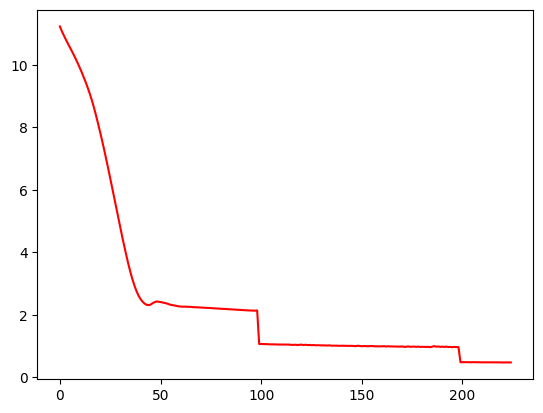

 45%|████▌     | 225/500 [00:25<00:29,  9.43it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.47995889003083
Dataset Name:  books , AUC Score (contextual):  48.143060643060636
Dataset Name:  books , AUC Score (structural):  40.187579482831715
Dataset Name:  books , AUC Score (joint-type):  44.58689458689459
Dataset Name:  books , AUC Score (structure type):  40.75267361581155
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.58689458689459
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


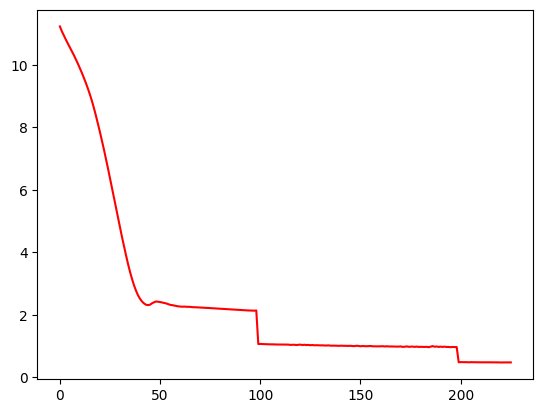

 45%|████▌     | 226/500 [00:25<00:28,  9.54it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.610996916752306
Dataset Name:  books , AUC Score (contextual):  48.27533577533577
Dataset Name:  books , AUC Score (structural):  39.849512505298854
Dataset Name:  books , AUC Score (joint-type):  43.45746845746846
Dataset Name:  books , AUC Score (structure type):  40.229231532873065
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.45746845746846
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


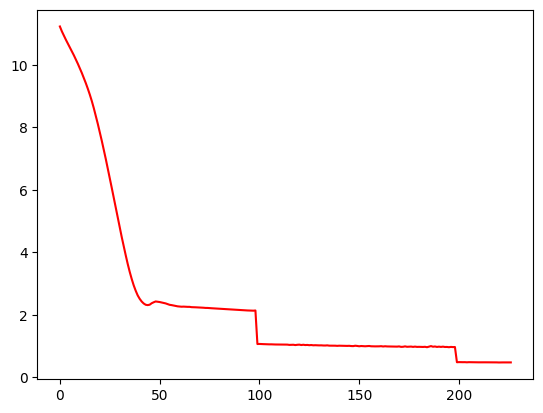

Dataset Name:  books , AUC Score(benchmark/combined):  61.43114080164439
Dataset Name:  books , AUC Score (contextual):  47.873422873422875
Dataset Name:  books , AUC Score (structural):  40.01165748198389
Dataset Name:  books , AUC Score (joint-type):  44.08831908831909
Dataset Name:  books , AUC Score (structure type):  40.518929651189026
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.08831908831909
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


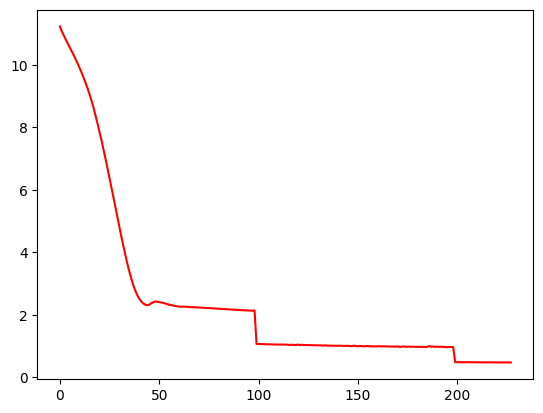

 46%|████▌     | 228/500 [00:25<00:27,  9.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.18705035971224
Dataset Name:  books , AUC Score (contextual):  48.45848595848595
Dataset Name:  books , AUC Score (structural):  40.032852903772785
Dataset Name:  books , AUC Score (joint-type):  44.983719983719986
Dataset Name:  books , AUC Score (structure type):  40.74906367041199
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.983719983719986
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


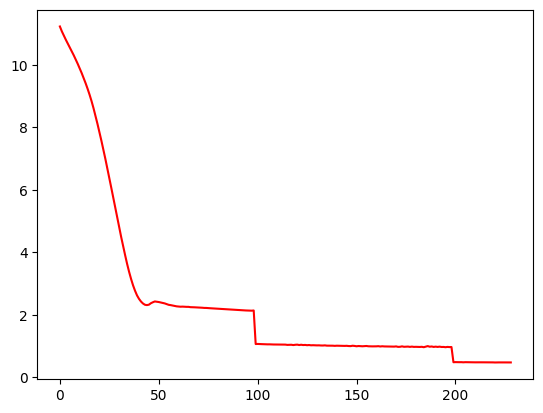

 46%|████▌     | 229/500 [00:25<00:27,  9.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.459403905447076
Dataset Name:  books , AUC Score (contextual):  47.08994708994709
Dataset Name:  books , AUC Score (structural):  39.38745231030097
Dataset Name:  books , AUC Score (joint-type):  47.31888481888481
Dataset Name:  books , AUC Score (structure type):  40.56856640043319
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.31888481888481
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


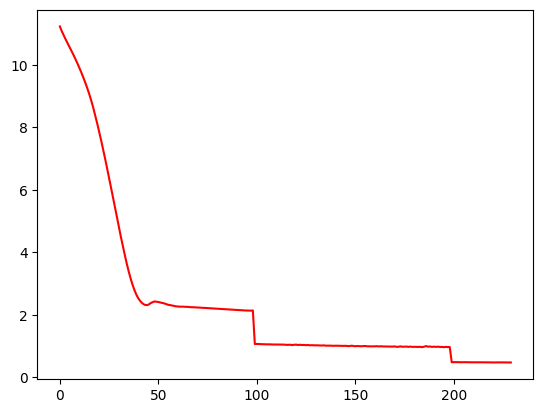

 46%|████▌     | 230/500 [00:25<00:28,  9.53it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.994347379239464
Dataset Name:  books , AUC Score (contextual):  49.04354904354904
Dataset Name:  books , AUC Score (structural):  39.251801610852056
Dataset Name:  books , AUC Score (joint-type):  45.76719576719576
Dataset Name:  books , AUC Score (structure type):  40.17688732457921
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.76719576719576
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


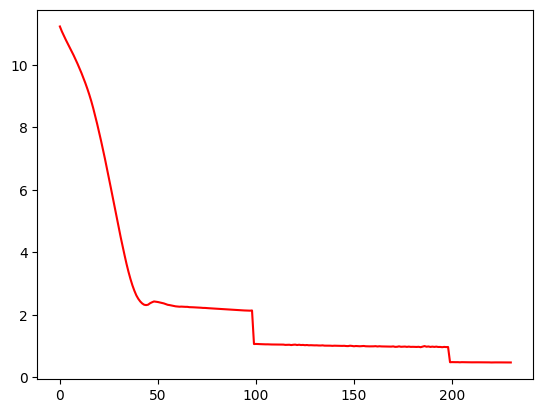

 46%|████▌     | 231/500 [00:26<00:29,  9.19it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.20760534429598
Dataset Name:  books , AUC Score (contextual):  47.074684574684575
Dataset Name:  books , AUC Score (structural):  41.74968206867317
Dataset Name:  books , AUC Score (joint-type):  43.11151811151811
Dataset Name:  books , AUC Score (structure type):  41.8528044763323
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.11151811151811
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


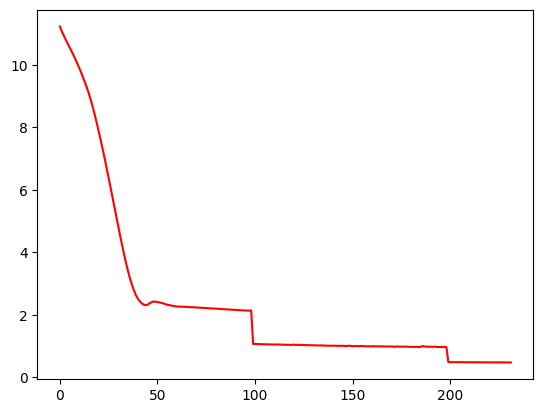

 46%|████▋     | 232/500 [00:26<00:28,  9.25it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.85971223021583
Dataset Name:  books , AUC Score (contextual):  47.593610093610096
Dataset Name:  books , AUC Score (structural):  41.55468418821534
Dataset Name:  books , AUC Score (joint-type):  44.94301994301995
Dataset Name:  books , AUC Score (structure type):  42.02969180091151
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.94301994301995
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


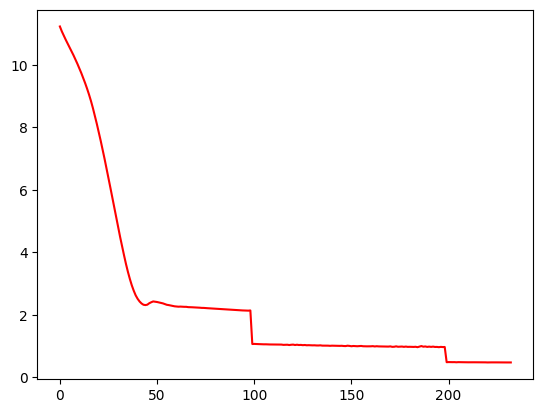

 47%|████▋     | 233/500 [00:26<00:28,  9.34it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.10431654676258
Dataset Name:  books , AUC Score (contextual):  47.12555962555962
Dataset Name:  books , AUC Score (structural):  39.93641373463333
Dataset Name:  books , AUC Score (joint-type):  44.276556776556774
Dataset Name:  books , AUC Score (structure type):  40.5080998149903
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.276556776556774
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


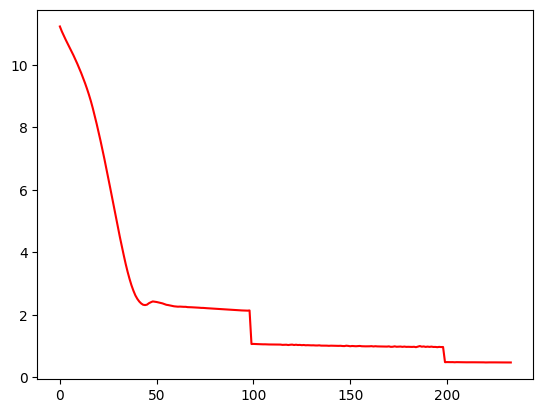

 47%|████▋     | 234/500 [00:26<00:28,  9.32it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.454265159301144
Dataset Name:  books , AUC Score (contextual):  46.77960927960928
Dataset Name:  books , AUC Score (structural):  39.87918609580331
Dataset Name:  books , AUC Score (joint-type):  44.48005698005698
Dataset Name:  books , AUC Score (structure type):  40.546906728035744
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.48005698005698
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


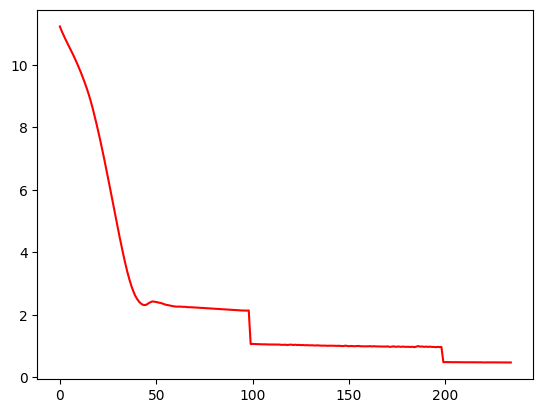

 47%|████▋     | 235/500 [00:26<00:28,  9.46it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.60328879753341
Dataset Name:  books , AUC Score (contextual):  46.15384615384615
Dataset Name:  books , AUC Score (structural):  40.21937261551505
Dataset Name:  books , AUC Score (joint-type):  43.99165649165649
Dataset Name:  books , AUC Score (structure type):  40.731013943414105
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.99165649165649
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


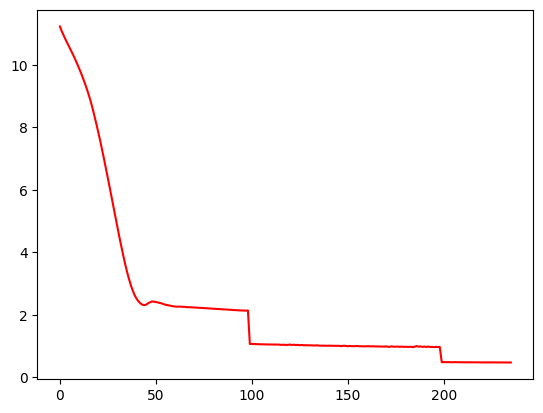

Dataset Name:  books , AUC Score(benchmark/combined):  60.4650565262076
Dataset Name:  books , AUC Score (contextual):  46.29629629629629
Dataset Name:  books , AUC Score (structural):  40.59135226791013
Dataset Name:  books , AUC Score (joint-type):  44.52584452584452
Dataset Name:  books , AUC Score (structure type):  41.05320157032625
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.52584452584452
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


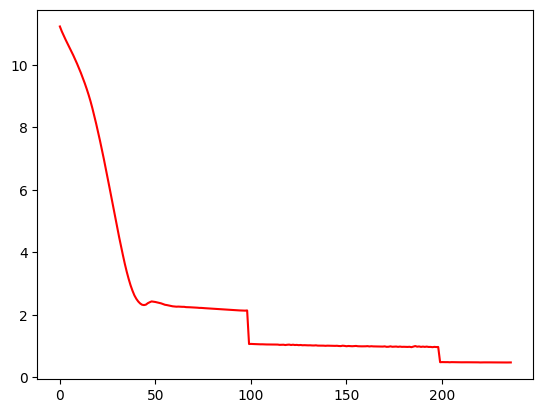

 47%|████▋     | 237/500 [00:26<00:26,  9.74it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.35611510791368
Dataset Name:  books , AUC Score (contextual):  45.33984533984534
Dataset Name:  books , AUC Score (structural):  39.63119966087325
Dataset Name:  books , AUC Score (joint-type):  44.988807488807495
Dataset Name:  books , AUC Score (structure type):  40.411533775551646
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.988807488807495
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


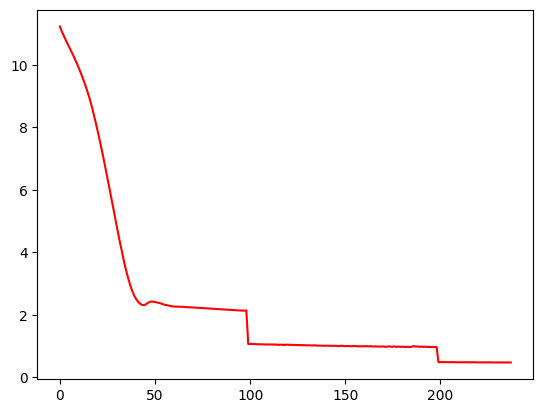

 48%|████▊     | 238/500 [00:26<00:26,  9.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.896711202466605
Dataset Name:  books , AUC Score (contextual):  45.96560846560847
Dataset Name:  books , AUC Score (structural):  40.806485799067396
Dataset Name:  books , AUC Score (joint-type):  45.54843304843305
Dataset Name:  books , AUC Score (structure type):  41.51617706782184
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.54843304843305
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


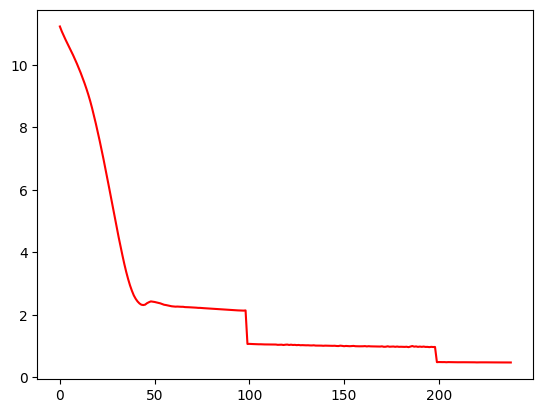

 48%|████▊     | 239/500 [00:26<00:27,  9.64it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.04059609455293
Dataset Name:  books , AUC Score (contextual):  47.21204721204722
Dataset Name:  books , AUC Score (structural):  40.24374735057227
Dataset Name:  books , AUC Score (joint-type):  44.08323158323157
Dataset Name:  books , AUC Score (structure type):  40.797797933306256
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.08323158323157
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


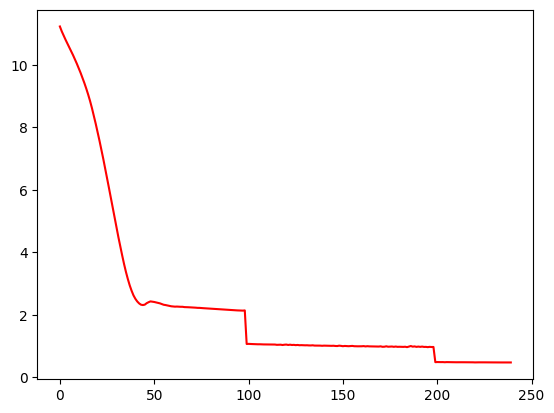

 48%|████▊     | 240/500 [00:27<00:27,  9.58it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.70606372045222
Dataset Name:  books , AUC Score (contextual):  45.87403337403338
Dataset Name:  books , AUC Score (structural):  39.222128020347604
Dataset Name:  books , AUC Score (joint-type):  45.029507529507526
Dataset Name:  books , AUC Score (structure type):  40.09295609403908
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.029507529507526
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


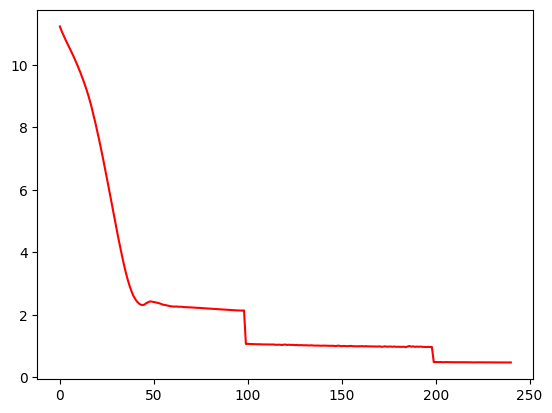

 48%|████▊     | 241/500 [00:27<00:26,  9.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.63412127440905
Dataset Name:  books , AUC Score (contextual):  45.91473341473342
Dataset Name:  books , AUC Score (structural):  40.469478592624
Dataset Name:  books , AUC Score (joint-type):  45.7010582010582
Dataset Name:  books , AUC Score (structure type):  41.253553540002706
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.7010582010582
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


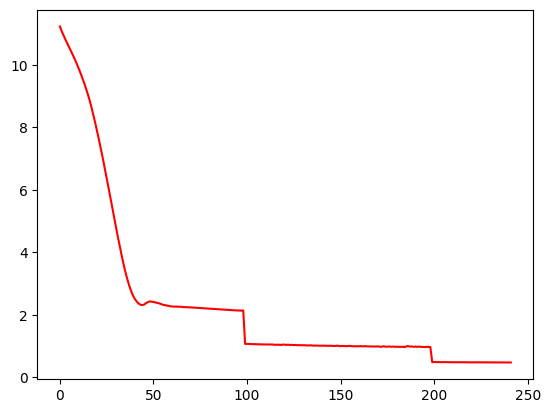

 48%|████▊     | 242/500 [00:27<00:26,  9.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.96300102774922
Dataset Name:  books , AUC Score (contextual):  46.76943426943427
Dataset Name:  books , AUC Score (structural):  41.58965663416702
Dataset Name:  books , AUC Score (joint-type):  45.06512006512006
Dataset Name:  books , AUC Score (structure type):  42.07752357745589
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.06512006512006
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


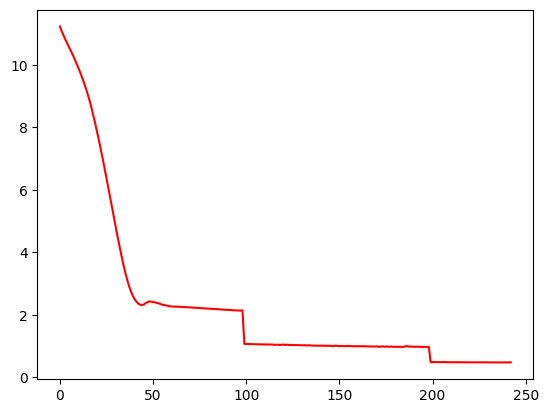

 49%|████▊     | 243/500 [00:27<00:26,  9.66it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.91675231243576
Dataset Name:  books , AUC Score (contextual):  47.5071225071225
Dataset Name:  books , AUC Score (structural):  39.415006358626535
Dataset Name:  books , AUC Score (joint-type):  44.72425722425722
Dataset Name:  books , AUC Score (structure type):  40.24908623257073
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.72425722425722
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


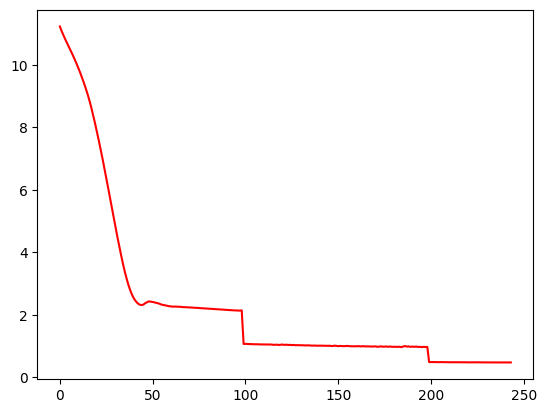

 49%|████▉     | 244/500 [00:27<00:27,  9.40it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.530832476875645
Dataset Name:  books , AUC Score (contextual):  46.76434676434676
Dataset Name:  books , AUC Score (structural):  39.91627808393387
Dataset Name:  books , AUC Score (joint-type):  44.73443223443224
Dataset Name:  books , AUC Score (structure type):  40.53697937818691
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.73443223443224
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


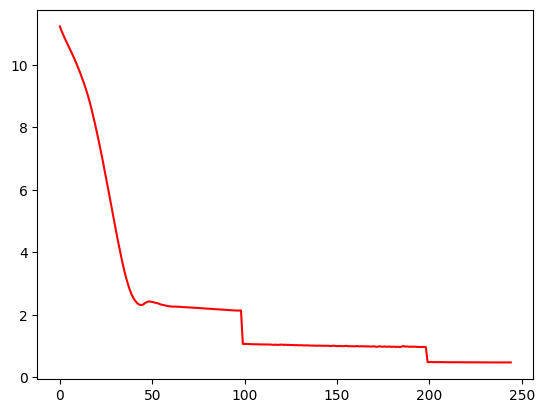

 49%|████▉     | 245/500 [00:27<00:27,  9.19it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.4311408016444
Dataset Name:  books , AUC Score (contextual):  46.62189662189662
Dataset Name:  books , AUC Score (structural):  39.95654938533277
Dataset Name:  books , AUC Score (joint-type):  44.251119251119256
Dataset Name:  books , AUC Score (structure type):  40.533369432787325
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.251119251119256
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


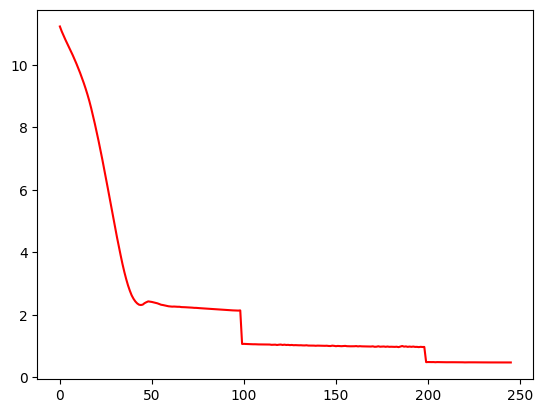

 49%|████▉     | 246/500 [00:27<00:27,  9.17it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.31294964028777
Dataset Name:  books , AUC Score (contextual):  46.64224664224664
Dataset Name:  books , AUC Score (structural):  39.598346757100465
Dataset Name:  books , AUC Score (joint-type):  42.67399267399267
Dataset Name:  books , AUC Score (structure type):  40.00541491809937
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.67399267399267
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


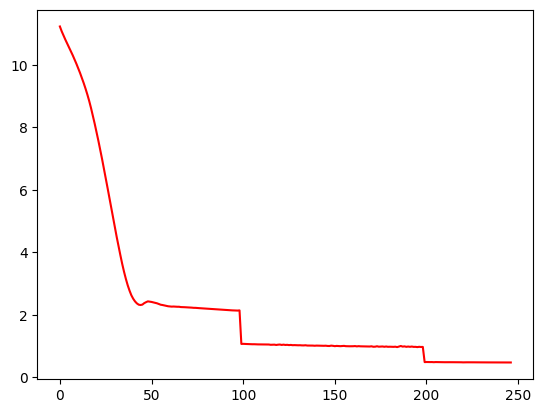

 49%|████▉     | 247/500 [00:27<00:27,  9.12it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.87358684480987
Dataset Name:  books , AUC Score (contextual):  46.46418396418397
Dataset Name:  books , AUC Score (structural):  39.62696057651547
Dataset Name:  books , AUC Score (joint-type):  45.0956450956451
Dataset Name:  books , AUC Score (structure type):  40.40611885745228
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.0956450956451
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


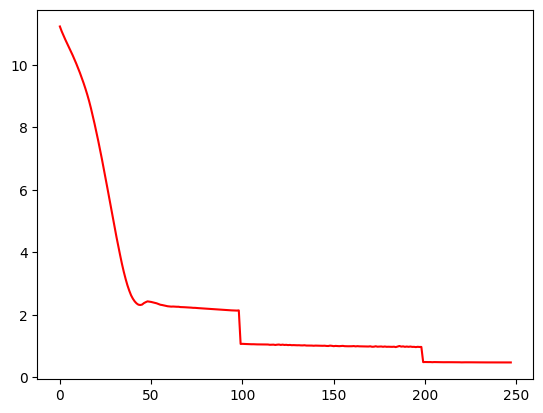

 50%|████▉     | 248/500 [00:27<00:28,  8.80it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.54162384378212
Dataset Name:  books , AUC Score (contextual):  46.291208791208796
Dataset Name:  books , AUC Score (structural):  39.73187791437049
Dataset Name:  books , AUC Score (joint-type):  44.169719169719166
Dataset Name:  books , AUC Score (structure type):  40.27074590496819
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.169719169719166
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


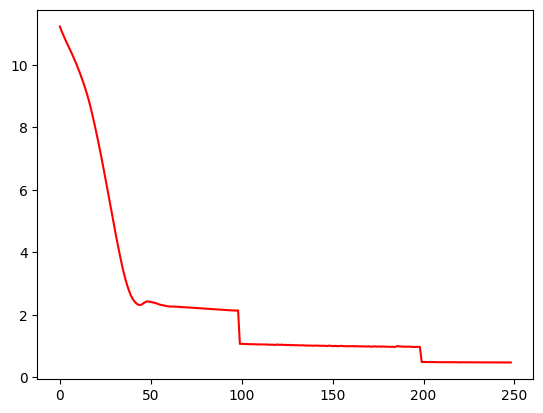

 50%|████▉     | 249/500 [00:28<00:27,  9.01it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.59301130524153
Dataset Name:  books , AUC Score (contextual):  46.7999592999593
Dataset Name:  books , AUC Score (structural):  39.77002967359051
Dataset Name:  books , AUC Score (joint-type):  45.06512006512006
Dataset Name:  books , AUC Score (structure type):  40.45846306574613
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.06512006512006
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


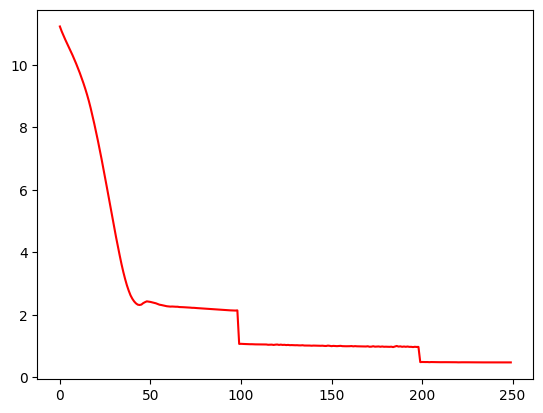

 50%|█████     | 250/500 [00:28<00:27,  9.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.17677286742036
Dataset Name:  books , AUC Score (contextual):  47.405372405372404
Dataset Name:  books , AUC Score (structural):  39.96820686731666
Dataset Name:  books , AUC Score (joint-type):  44.41900691900692
Dataset Name:  books , AUC Score (structure type):  40.576688777582234
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.41900691900692
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


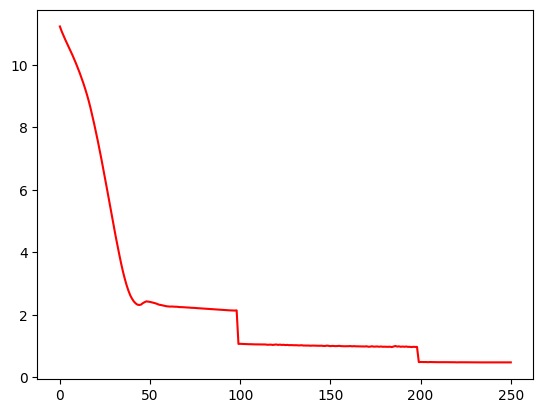

 50%|█████     | 251/500 [00:28<00:26,  9.32it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.21223021582735
Dataset Name:  books , AUC Score (contextual):  46.24033374033374
Dataset Name:  books , AUC Score (structural):  40.10703688003392
Dataset Name:  books , AUC Score (joint-type):  44.403744403744405
Dataset Name:  books , AUC Score (structure type):  40.654302603673116
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.403744403744405
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


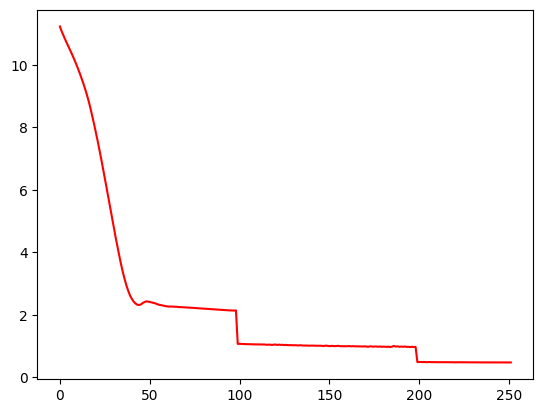

 50%|█████     | 252/500 [00:28<00:26,  9.42it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.36896197327852
Dataset Name:  books , AUC Score (contextual):  46.13858363858364
Dataset Name:  books , AUC Score (structural):  39.72339974565494
Dataset Name:  books , AUC Score (joint-type):  44.73951973951974
Dataset Name:  books , AUC Score (structure type):  40.49366003339199
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.73951973951974
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


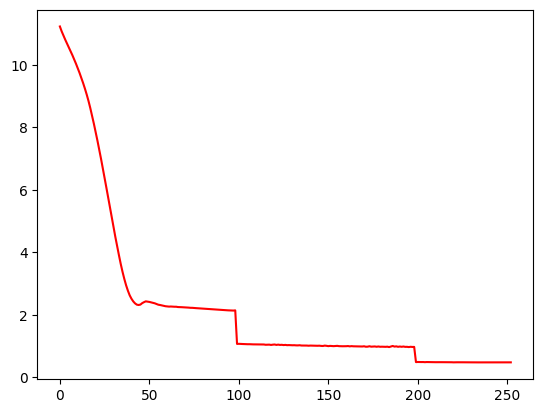

 51%|█████     | 253/500 [00:28<00:27,  9.11it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.968653648509765
Dataset Name:  books , AUC Score (contextual):  44.76495726495726
Dataset Name:  books , AUC Score (structural):  39.358838490885965
Dataset Name:  books , AUC Score (joint-type):  46.03174603174603
Dataset Name:  books , AUC Score (structure type):  40.3140652497631
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.03174603174603
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


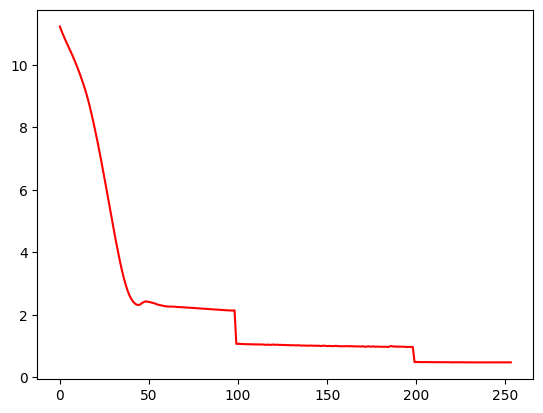

 51%|█████     | 254/500 [00:28<00:27,  8.96it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.027749229188075
Dataset Name:  books , AUC Score (contextual):  46.387871387871385
Dataset Name:  books , AUC Score (structural):  39.6015260703688
Dataset Name:  books , AUC Score (joint-type):  44.1951566951567
Dataset Name:  books , AUC Score (structure type):  40.208474346825504
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.1951566951567
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


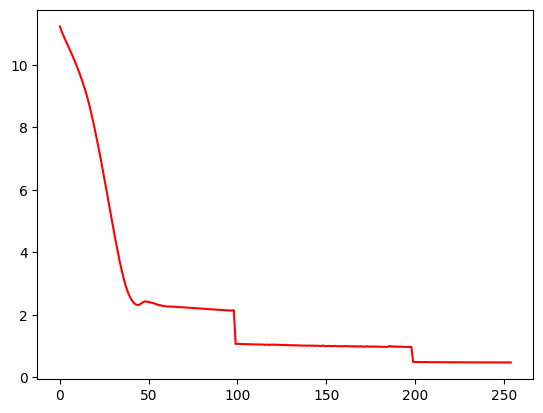

 51%|█████     | 255/500 [00:28<00:46,  5.29it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.90955806783145
Dataset Name:  books , AUC Score (contextual):  45.935083435083435
Dataset Name:  books , AUC Score (structural):  40.648579906740146
Dataset Name:  books , AUC Score (joint-type):  44.64285714285714
Dataset Name:  books , AUC Score (structure type):  41.161499932313525
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.64285714285714
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


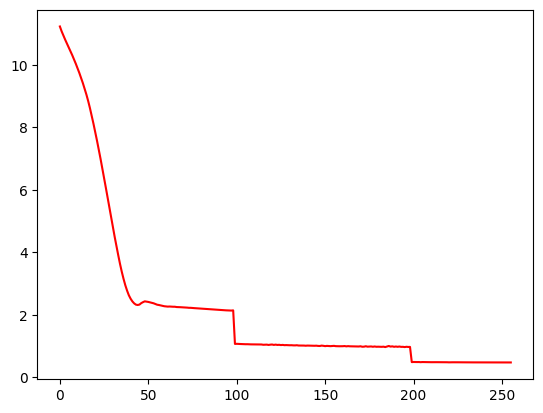

 51%|█████     | 256/500 [00:29<00:40,  6.00it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.6469681397739
Dataset Name:  books , AUC Score (contextual):  46.11823361823361
Dataset Name:  books , AUC Score (structural):  39.17337855023315
Dataset Name:  books , AUC Score (joint-type):  44.58180708180708
Dataset Name:  books , AUC Score (structure type):  39.978340327602545
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.58180708180708
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


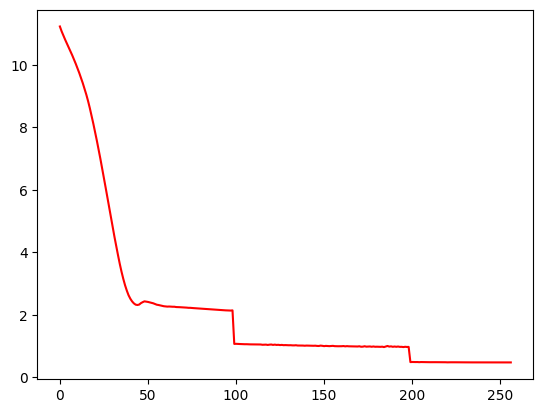

 51%|█████▏    | 257/500 [00:29<00:36,  6.67it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.2667009249743
Dataset Name:  books , AUC Score (contextual):  45.9045584045584
Dataset Name:  books , AUC Score (structural):  39.910979228486646
Dataset Name:  books , AUC Score (joint-type):  43.3964183964184
Dataset Name:  books , AUC Score (structure type):  40.33211497676098
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.3964183964184
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


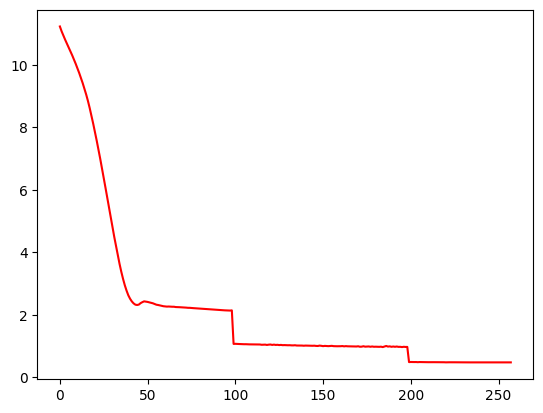

 52%|█████▏    | 258/500 [00:29<00:33,  7.26it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.009249743062696
Dataset Name:  books , AUC Score (contextual):  46.98819698819698
Dataset Name:  books , AUC Score (structural):  40.867952522255194
Dataset Name:  books , AUC Score (joint-type):  42.72995522995523
Dataset Name:  books , AUC Score (structure type):  41.115473128468935
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.72995522995523
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


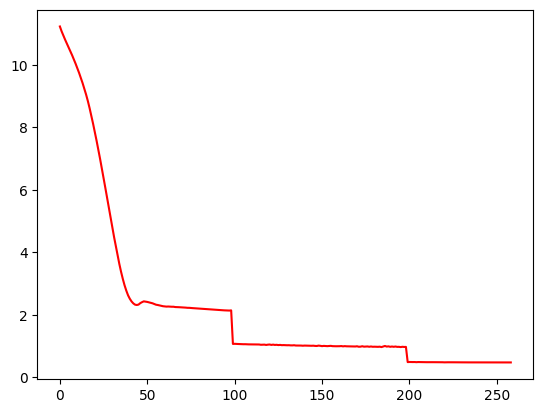

 52%|█████▏    | 259/500 [00:29<00:31,  7.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.44707091469682
Dataset Name:  books , AUC Score (contextual):  45.72649572649573
Dataset Name:  books , AUC Score (structural):  40.35714285714285
Dataset Name:  books , AUC Score (joint-type):  42.5010175010175
Dataset Name:  books , AUC Score (structure type):  40.61910563602726
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.5010175010175
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


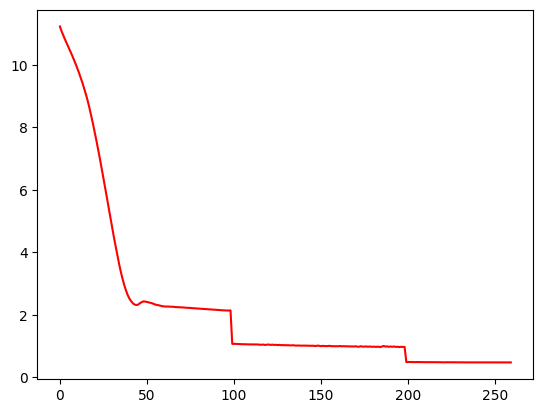

 52%|█████▏    | 260/500 [00:29<00:29,  8.12it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.729701952723524
Dataset Name:  books , AUC Score (contextual):  46.86609686609687
Dataset Name:  books , AUC Score (structural):  39.49766850360322
Dataset Name:  books , AUC Score (joint-type):  44.66320716320716
Dataset Name:  books , AUC Score (structure type):  40.236451423672214
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.66320716320716
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


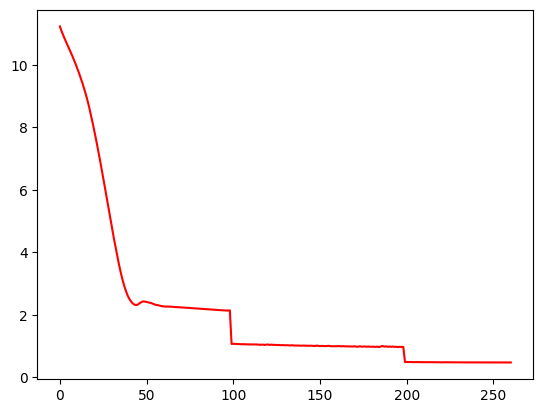

 52%|█████▏    | 261/500 [00:29<00:28,  8.41it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.9655704008222
Dataset Name:  books , AUC Score (contextual):  47.84289784289784
Dataset Name:  books , AUC Score (structural):  40.95167443832133
Dataset Name:  books , AUC Score (joint-type):  46.148758648758644
Dataset Name:  books , AUC Score (structure type):  41.691259419701275
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.148758648758644
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


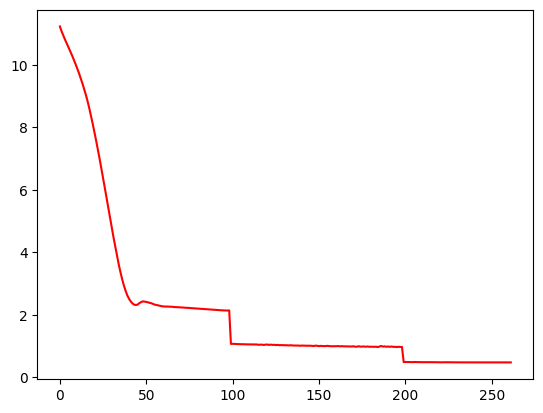

 52%|█████▏    | 262/500 [00:29<00:27,  8.65it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.22764645426515
Dataset Name:  books , AUC Score (contextual):  46.102971102971104
Dataset Name:  books , AUC Score (structural):  39.670411191182694
Dataset Name:  books , AUC Score (joint-type):  43.75763125763126
Dataset Name:  books , AUC Score (structure type):  40.22562158747349
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.75763125763126
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


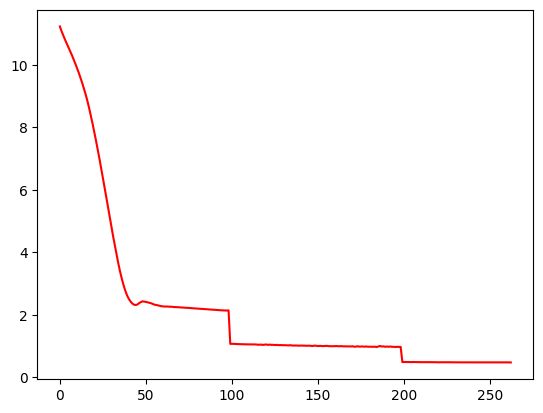

 53%|█████▎    | 263/500 [00:29<00:26,  8.82it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.919835560123325
Dataset Name:  books , AUC Score (contextual):  45.11599511599512
Dataset Name:  books , AUC Score (structural):  40.61784654514625
Dataset Name:  books , AUC Score (joint-type):  46.24542124542125
Dataset Name:  books , AUC Score (structure type):  41.41148865123415
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.24542124542125
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


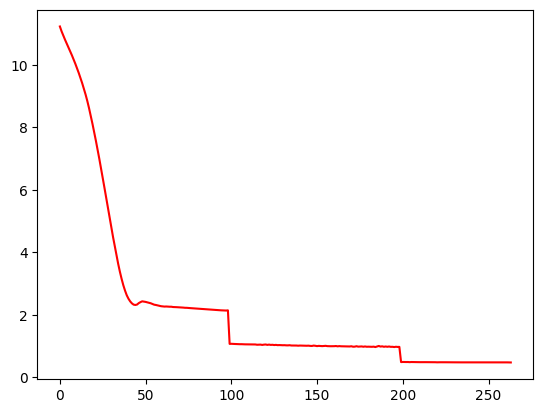

 53%|█████▎    | 264/500 [00:29<00:26,  8.91it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.98663926002057
Dataset Name:  books , AUC Score (contextual):  47.242572242572244
Dataset Name:  books , AUC Score (structural):  41.263247138618055
Dataset Name:  books , AUC Score (joint-type):  41.488603988604
Dataset Name:  books , AUC Score (structure type):  41.191281981860016
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.488603988604
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


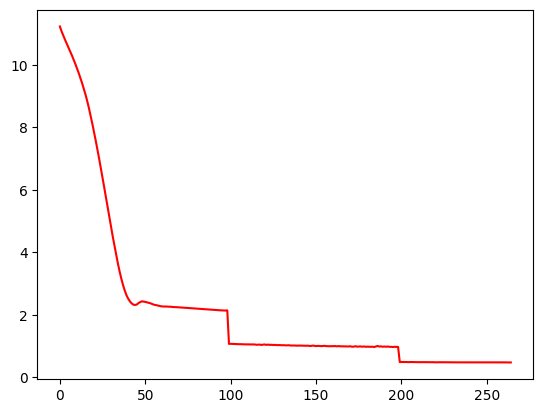

 53%|█████▎    | 265/500 [00:30<00:26,  8.93it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.52158273381295
Dataset Name:  books , AUC Score (contextual):  46.58628408628409
Dataset Name:  books , AUC Score (structural):  41.23251377702416
Dataset Name:  books , AUC Score (joint-type):  44.65303215303215
Dataset Name:  books , AUC Score (structure type):  41.63169532060828
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.65303215303215
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


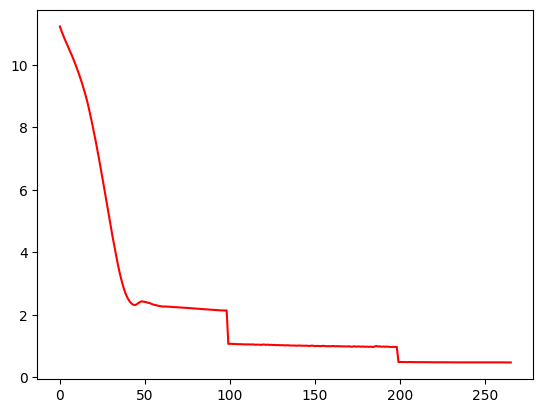

 53%|█████▎    | 266/500 [00:30<00:26,  8.98it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.38437821171634
Dataset Name:  books , AUC Score (contextual):  45.28897028897029
Dataset Name:  books , AUC Score (structural):  38.84590928359474
Dataset Name:  books , AUC Score (joint-type):  44.220594220594215
Dataset Name:  books , AUC Score (structure type):  39.52529217995577
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.220594220594215
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


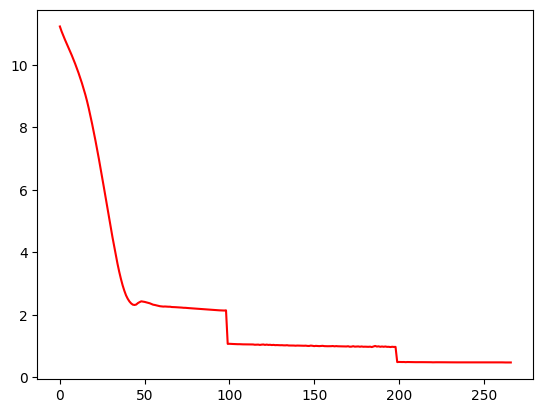

 53%|█████▎    | 267/500 [00:30<00:25,  9.03it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.91932168550874
Dataset Name:  books , AUC Score (contextual):  48.69505494505494
Dataset Name:  books , AUC Score (structural):  41.03433658329801
Dataset Name:  books , AUC Score (joint-type):  45.47720797720798
Dataset Name:  books , AUC Score (structure type):  41.60552321646135
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.47720797720798
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


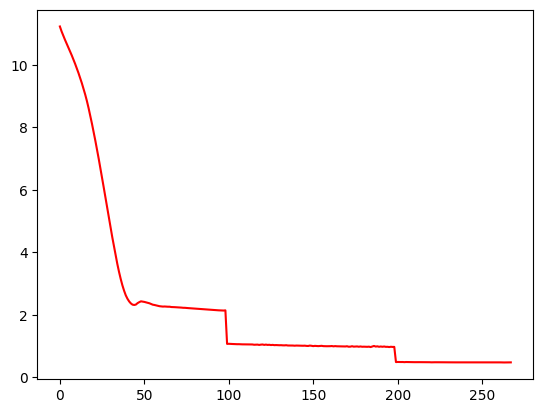

 54%|█████▎    | 268/500 [00:30<00:25,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.963514902363826
Dataset Name:  books , AUC Score (contextual):  47.61396011396011
Dataset Name:  books , AUC Score (structural):  39.058923272573125
Dataset Name:  books , AUC Score (joint-type):  46.057183557183556
Dataset Name:  books , AUC Score (structure type):  39.996390054600425
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.057183557183556
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


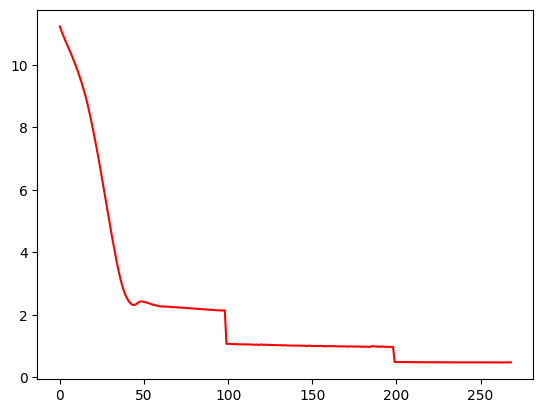

 54%|█████▍    | 269/500 [00:30<00:25,  9.22it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.81397738951697
Dataset Name:  books , AUC Score (contextual):  47.55291005291005
Dataset Name:  books , AUC Score (structural):  41.215557439593056
Dataset Name:  books , AUC Score (joint-type):  45.17704517704518
Dataset Name:  books , AUC Score (structure type):  41.70479671494968
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.17704517704518
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


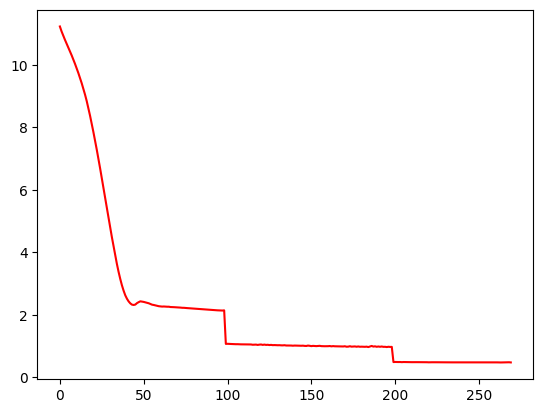

 54%|█████▍    | 270/500 [00:30<00:24,  9.26it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.54984583761562
Dataset Name:  books , AUC Score (contextual):  48.458485958485966
Dataset Name:  books , AUC Score (structural):  41.224035608308604
Dataset Name:  books , AUC Score (joint-type):  44.164631664631656
Dataset Name:  books , AUC Score (structure type):  41.66418482920446
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.164631664631656
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


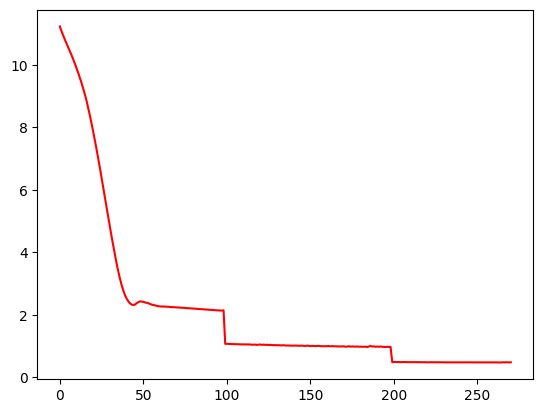

 54%|█████▍    | 271/500 [00:30<00:24,  9.23it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.89157245632067
Dataset Name:  books , AUC Score (contextual):  44.571632071632074
Dataset Name:  books , AUC Score (structural):  40.71534548537517
Dataset Name:  books , AUC Score (joint-type):  45.92490842490842
Dataset Name:  books , AUC Score (structure type):  41.434953296331386
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.92490842490842
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


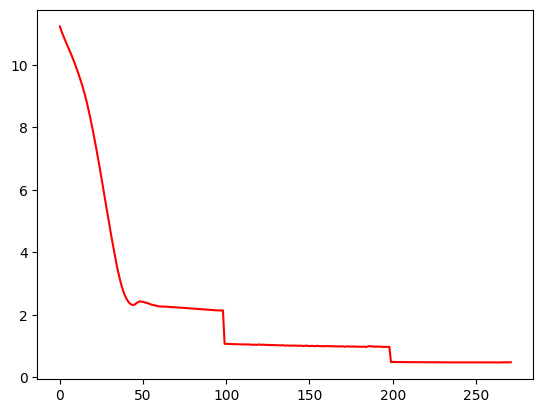

 54%|█████▍    | 272/500 [00:30<00:24,  9.38it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.253854059609445
Dataset Name:  books , AUC Score (contextual):  44.123931623931625
Dataset Name:  books , AUC Score (structural):  39.966087325137764
Dataset Name:  books , AUC Score (joint-type):  45.56369556369557
Dataset Name:  books , AUC Score (structure type):  40.70393935291728
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.56369556369557
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


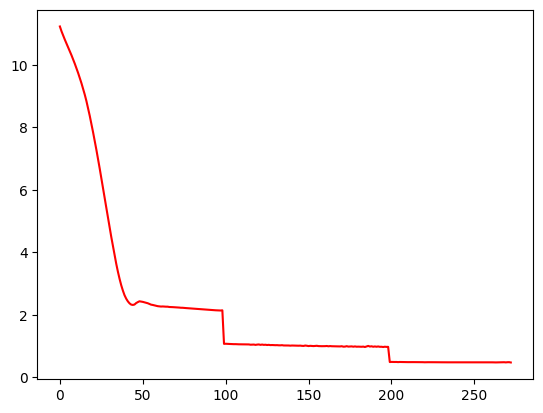

 55%|█████▍    | 273/500 [00:30<00:24,  9.42it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.158787255909566
Dataset Name:  books , AUC Score (contextual):  48.07692307692308
Dataset Name:  books , AUC Score (structural):  42.06231454005935
Dataset Name:  books , AUC Score (joint-type):  43.772893772893774
Dataset Name:  books , AUC Score (structure type):  42.2706556563332
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.772893772893774
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


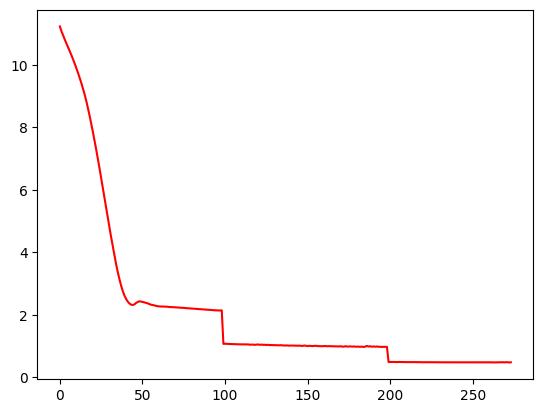

 55%|█████▍    | 274/500 [00:30<00:24,  9.37it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.577595066803696
Dataset Name:  books , AUC Score (contextual):  46.34717134717135
Dataset Name:  books , AUC Score (structural):  39.65557439593048
Dataset Name:  books , AUC Score (joint-type):  44.286731786731785
Dataset Name:  books , AUC Score (structure type):  40.25540363701999
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.286731786731785
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


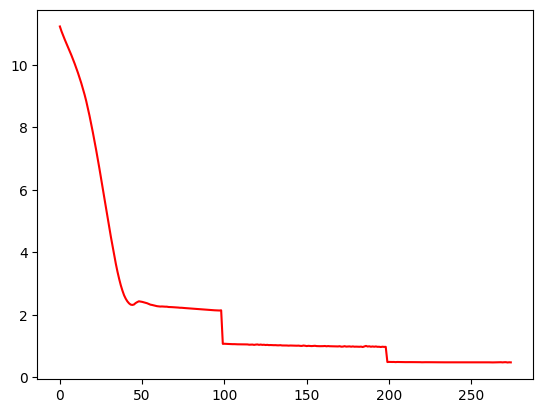

 55%|█████▌    | 275/500 [00:31<00:24,  9.34it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.6978417266187
Dataset Name:  books , AUC Score (contextual):  47.018722018722016
Dataset Name:  books , AUC Score (structural):  39.95548961424332
Dataset Name:  books , AUC Score (joint-type):  43.87973137973138
Dataset Name:  books , AUC Score (structure type):  40.41424123460132
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.87973137973138
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


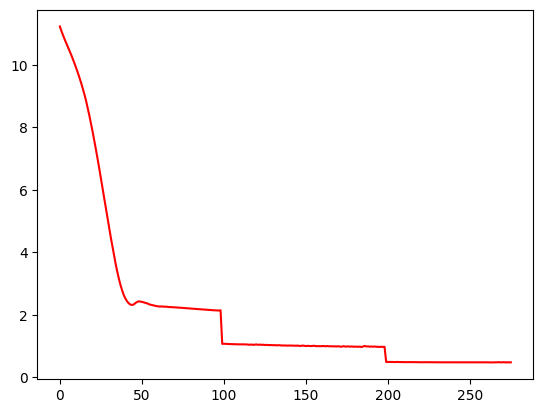

 55%|█████▌    | 276/500 [00:31<00:24,  9.30it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.914182939362796
Dataset Name:  books , AUC Score (contextual):  46.18437118437118
Dataset Name:  books , AUC Score (structural):  41.95739720220433
Dataset Name:  books , AUC Score (joint-type):  44.841269841269835
Dataset Name:  books , AUC Score (structure type):  42.18491945309327
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.841269841269835
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


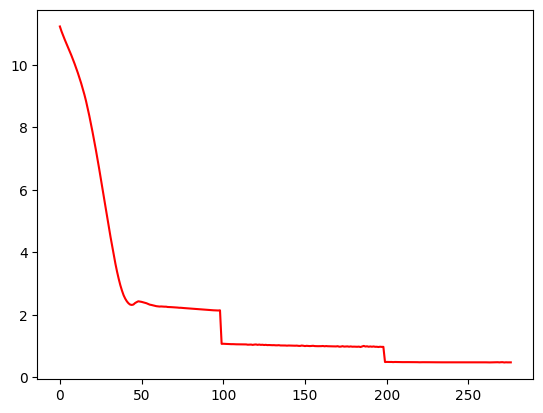

 55%|█████▌    | 277/500 [00:31<00:23,  9.33it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.42600205549845
Dataset Name:  books , AUC Score (contextual):  45.43142043142043
Dataset Name:  books , AUC Score (structural):  40.28613819415006
Dataset Name:  books , AUC Score (joint-type):  42.93854293854294
Dataset Name:  books , AUC Score (structure type):  40.52163711023871
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.93854293854294
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


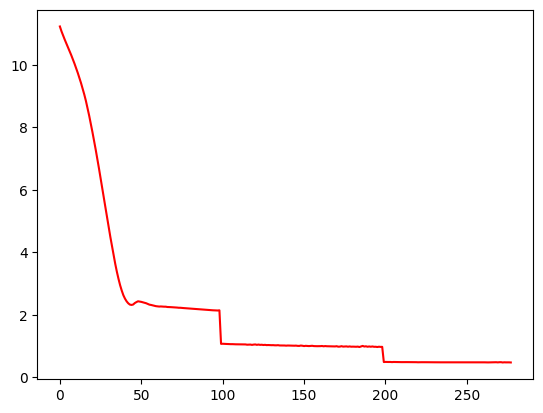

 56%|█████▌    | 278/500 [00:31<00:23,  9.28it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.05087358684481
Dataset Name:  books , AUC Score (contextual):  44.48514448514448
Dataset Name:  books , AUC Score (structural):  41.02161933022468
Dataset Name:  books , AUC Score (joint-type):  45.79263329263329
Dataset Name:  books , AUC Score (structure type):  41.73096881909662
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.79263329263329
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


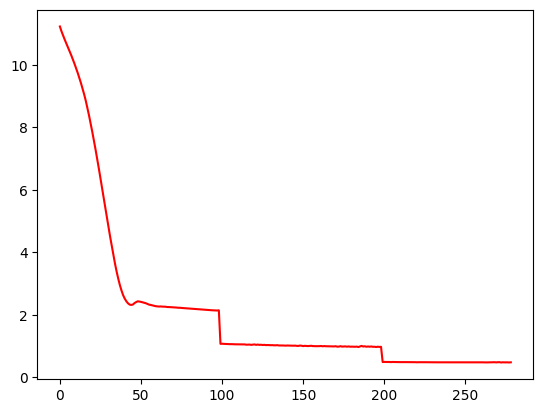

 56%|█████▌    | 279/500 [00:31<00:23,  9.25it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.18756423432682
Dataset Name:  books , AUC Score (contextual):  47.05942205942206
Dataset Name:  books , AUC Score (structural):  39.88766426451886
Dataset Name:  books , AUC Score (joint-type):  45.26353276353276
Dataset Name:  books , AUC Score (structure type):  40.613690717927895
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.26353276353276
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


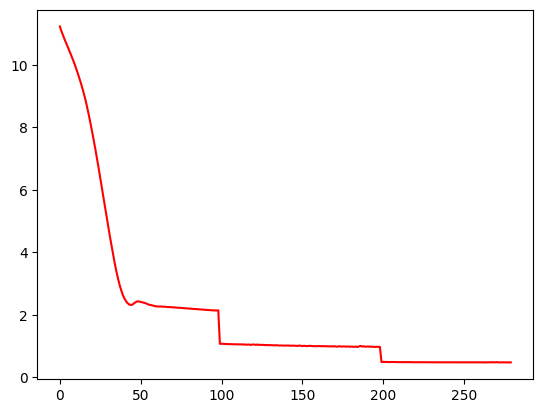

 56%|█████▌    | 280/500 [00:31<00:24,  9.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.15673175745119
Dataset Name:  books , AUC Score (contextual):  47.31379731379731
Dataset Name:  books , AUC Score (structural):  40.24586689275117
Dataset Name:  books , AUC Score (joint-type):  45.54843304843305
Dataset Name:  books , AUC Score (structure type):  41.0143946572808
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.54843304843305
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


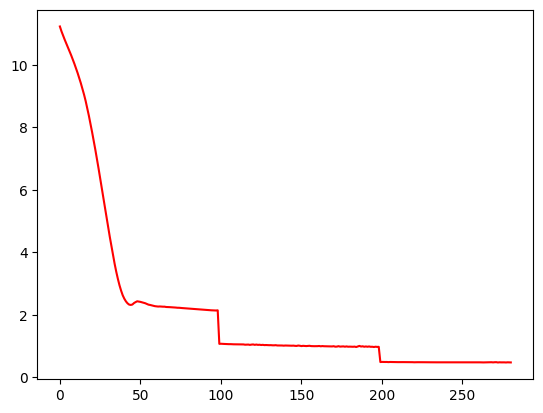

 56%|█████▌    | 281/500 [00:31<00:23,  9.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.346865364850984
Dataset Name:  books , AUC Score (contextual):  48.56023606023606
Dataset Name:  books , AUC Score (structural):  39.14052564646037
Dataset Name:  books , AUC Score (joint-type):  44.46479446479446
Dataset Name:  books , AUC Score (structure type):  39.888091692613145
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.46479446479446
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


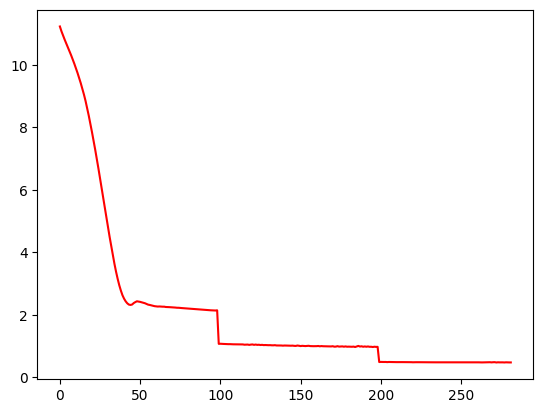

 56%|█████▋    | 282/500 [00:31<00:23,  9.18it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.82476875642343
Dataset Name:  books , AUC Score (contextual):  45.716320716320716
Dataset Name:  books , AUC Score (structural):  40.922000847816875
Dataset Name:  books , AUC Score (joint-type):  41.6971916971917
Dataset Name:  books , AUC Score (structure type):  40.86006949144894
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  41.6971916971917
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


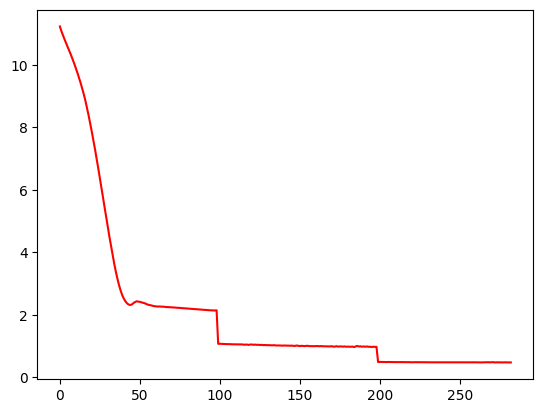

 57%|█████▋    | 283/500 [00:31<00:23,  9.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.26156217882836
Dataset Name:  books , AUC Score (contextual):  45.90964590964591
Dataset Name:  books , AUC Score (structural):  40.58075455701569
Dataset Name:  books , AUC Score (joint-type):  44.58689458689459
Dataset Name:  books , AUC Score (structure type):  41.06583637922476
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.58689458689459
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


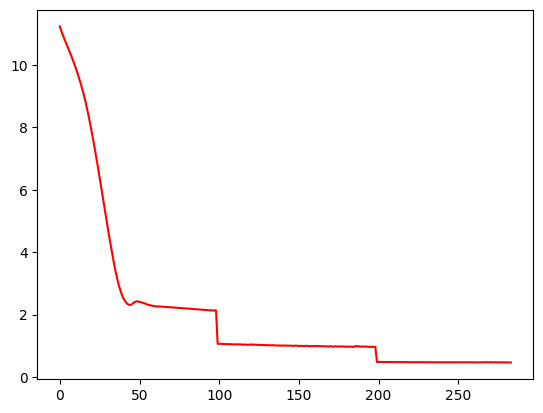

 57%|█████▋    | 284/500 [00:32<00:23,  9.12it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.27389516957862
Dataset Name:  books , AUC Score (contextual):  43.21835571835572
Dataset Name:  books , AUC Score (structural):  40.13141161509114
Dataset Name:  books , AUC Score (joint-type):  45.8994708994709
Dataset Name:  books , AUC Score (structure type):  40.97197779883579
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.8994708994709
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


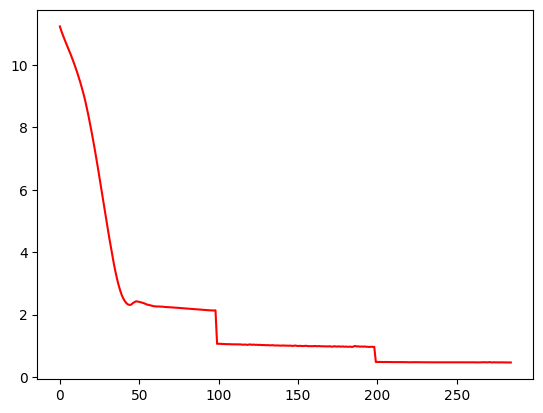

 57%|█████▋    | 285/500 [00:32<00:23,  9.17it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.90904419321686
Dataset Name:  books , AUC Score (contextual):  44.215506715506706
Dataset Name:  books , AUC Score (structural):  41.41055532005087
Dataset Name:  books , AUC Score (joint-type):  44.251119251119256
Dataset Name:  books , AUC Score (structure type):  41.72284644194757
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.251119251119256
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


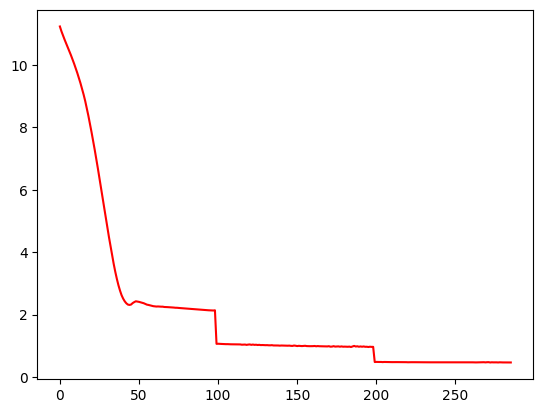

 57%|█████▋    | 286/500 [00:32<00:23,  9.23it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.9064748201439
Dataset Name:  books , AUC Score (contextual):  46.35734635734635
Dataset Name:  books , AUC Score (structural):  41.15091140313693
Dataset Name:  books , AUC Score (joint-type):  42.57224257224257
Dataset Name:  books , AUC Score (structure type):  41.266188348901224
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.57224257224257
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


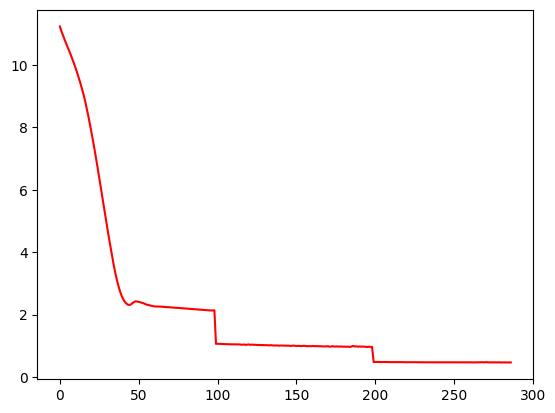

 57%|█████▋    | 287/500 [00:32<00:23,  9.19it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.691161356628974
Dataset Name:  books , AUC Score (contextual):  45.929995929995926
Dataset Name:  books , AUC Score (structural):  40.50233149639678
Dataset Name:  books , AUC Score (joint-type):  44.96336996336997
Dataset Name:  books , AUC Score (structure type):  41.1353278281666
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.96336996336997
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


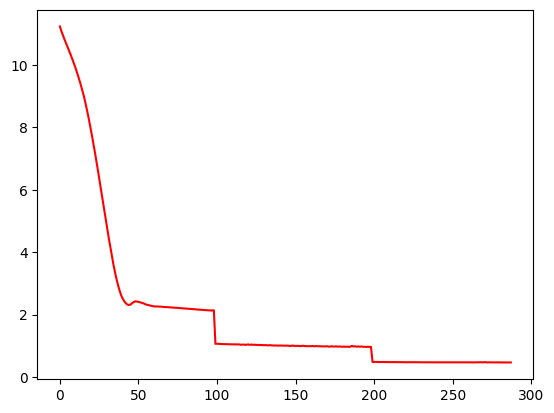

 58%|█████▊    | 288/500 [00:32<00:23,  9.14it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.54933196300103
Dataset Name:  books , AUC Score (contextual):  46.13858363858363
Dataset Name:  books , AUC Score (structural):  40.652818991097924
Dataset Name:  books , AUC Score (joint-type):  43.75254375254375
Dataset Name:  books , AUC Score (structure type):  40.98912503948378
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.75254375254375
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


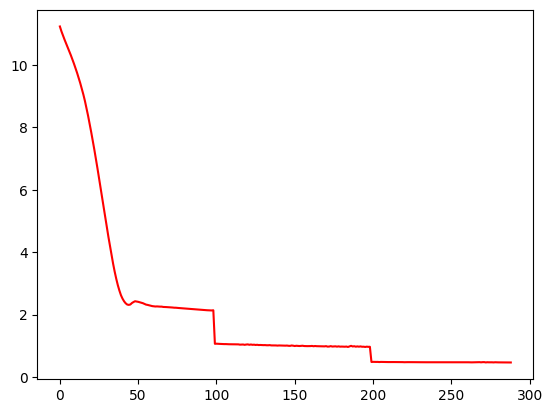

 58%|█████▊    | 289/500 [00:32<00:23,  9.11it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.632065775950664
Dataset Name:  books , AUC Score (contextual):  44.98626373626373
Dataset Name:  books , AUC Score (structural):  38.97520135650699
Dataset Name:  books , AUC Score (joint-type):  44.41391941391941
Dataset Name:  books , AUC Score (structure type):  39.63629800099274
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.41391941391941
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


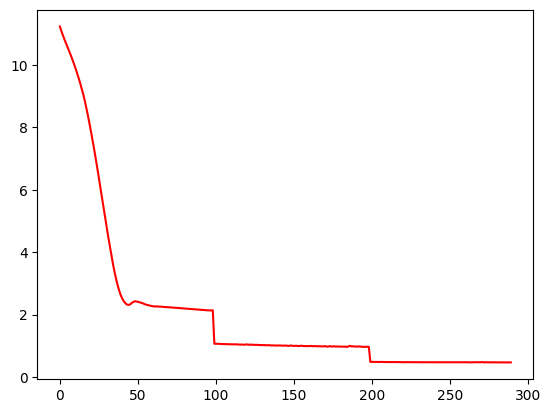

 58%|█████▊    | 290/500 [00:32<00:23,  9.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.606372045220965
Dataset Name:  books , AUC Score (contextual):  44.073056573056576
Dataset Name:  books , AUC Score (structural):  40.488554472234
Dataset Name:  books , AUC Score (joint-type):  46.14367114367114
Dataset Name:  books , AUC Score (structure type):  41.24633364920356
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.14367114367114
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


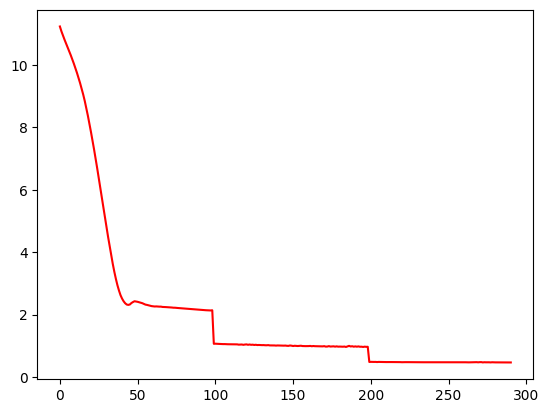

 58%|█████▊    | 291/500 [00:32<00:23,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.22096608427544
Dataset Name:  books , AUC Score (contextual):  43.777981277981276
Dataset Name:  books , AUC Score (structural):  40.30309453158117
Dataset Name:  books , AUC Score (joint-type):  44.06796906796907
Dataset Name:  books , AUC Score (structure type):  40.827579982852754
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.06796906796907
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


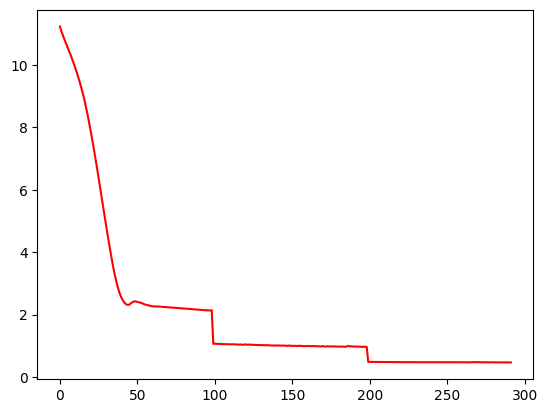

 58%|█████▊    | 292/500 [00:32<00:23,  9.03it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.842754367934226
Dataset Name:  books , AUC Score (contextual):  45.40089540089539
Dataset Name:  books , AUC Score (structural):  40.5574395930479
Dataset Name:  books , AUC Score (joint-type):  44.073056573056576
Dataset Name:  books , AUC Score (structure type):  40.963855421686745
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.073056573056576
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


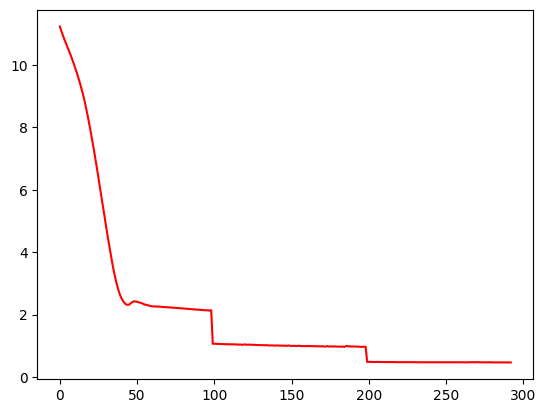

 59%|█████▊    | 293/500 [00:33<00:22,  9.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.229188078108955
Dataset Name:  books , AUC Score (contextual):  46.72873422873423
Dataset Name:  books , AUC Score (structural):  39.54323866044934
Dataset Name:  books , AUC Score (joint-type):  43.79833129833129
Dataset Name:  books , AUC Score (structure type):  40.230134019222966
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.79833129833129
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


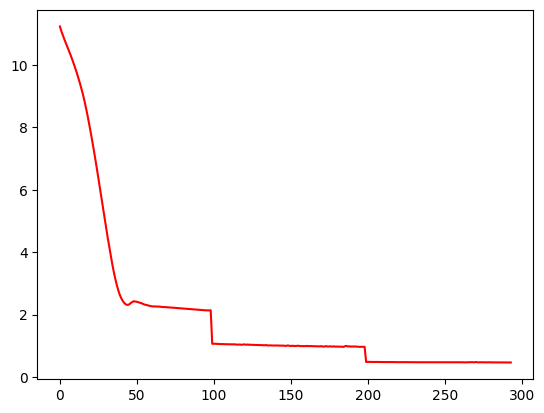

 59%|█████▉    | 294/500 [00:33<00:22,  9.03it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.63155190133608
Dataset Name:  books , AUC Score (contextual):  47.415547415547415
Dataset Name:  books , AUC Score (structural):  41.16574819838914
Dataset Name:  books , AUC Score (joint-type):  42.82153032153032
Dataset Name:  books , AUC Score (structure type):  41.26799332160102
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.82153032153032
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


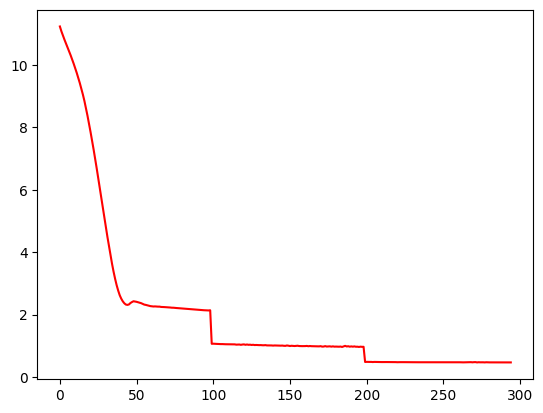

 59%|█████▉    | 295/500 [00:33<00:22,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.094039054470706
Dataset Name:  books , AUC Score (contextual):  45.51790801790801
Dataset Name:  books , AUC Score (structural):  40.045570156846125
Dataset Name:  books , AUC Score (joint-type):  44.693732193732195
Dataset Name:  books , AUC Score (structure type):  40.67325481702089
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.693732193732195
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


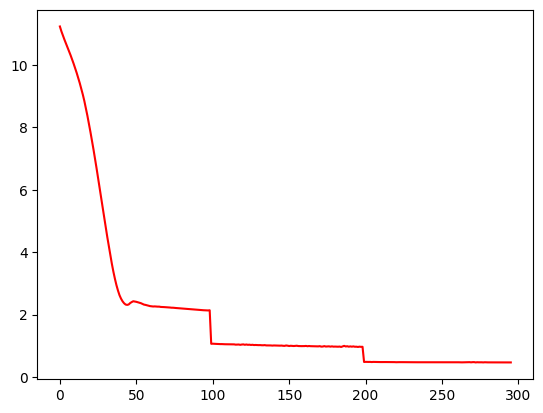

 59%|█████▉    | 296/500 [00:33<00:22,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.15878725590955
Dataset Name:  books , AUC Score (contextual):  46.92714692714692
Dataset Name:  books , AUC Score (structural):  40.899745654938535
Dataset Name:  books , AUC Score (joint-type):  44.683557183557184
Dataset Name:  books , AUC Score (structure type):  41.353729524840944
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.683557183557184
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


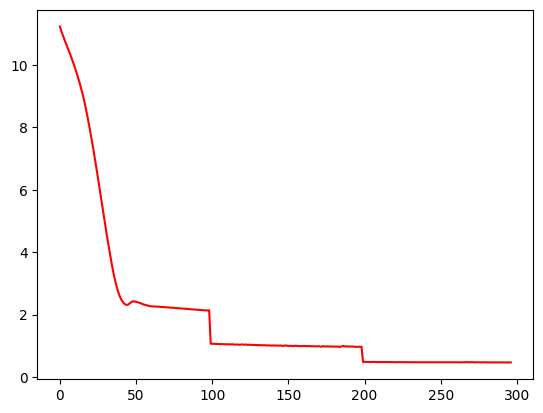

 59%|█████▉    | 297/500 [00:33<00:22,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.85251798561151
Dataset Name:  books , AUC Score (contextual):  45.94525844525844
Dataset Name:  books , AUC Score (structural):  40.86371343789742
Dataset Name:  books , AUC Score (joint-type):  45.84859584859585
Dataset Name:  books , AUC Score (structure type):  41.50263977257344
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.84859584859585
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


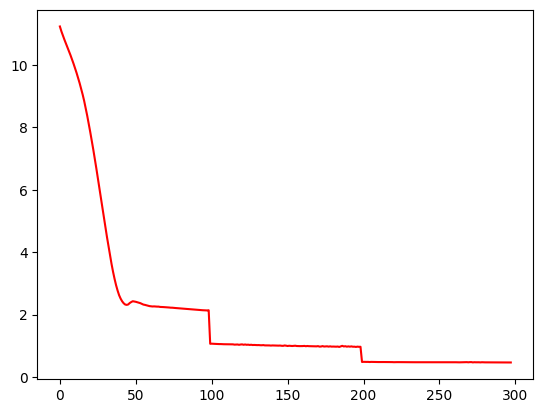

 60%|█████▉    | 298/500 [00:33<00:22,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.51541623843783
Dataset Name:  books , AUC Score (contextual):  43.264143264143264
Dataset Name:  books , AUC Score (structural):  40.606189063162354
Dataset Name:  books , AUC Score (joint-type):  45.604395604395606
Dataset Name:  books , AUC Score (structure type):  41.34560714769189
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.604395604395606
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


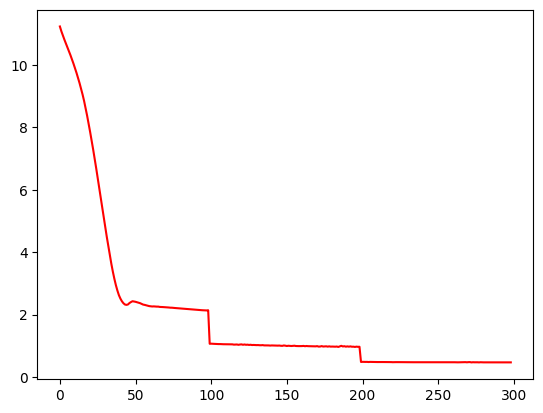

 60%|█████▉    | 299/500 [00:33<00:22,  9.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.72970195272354
Dataset Name:  books , AUC Score (contextual):  45.706145706145705
Dataset Name:  books , AUC Score (structural):  41.52713013988979
Dataset Name:  books , AUC Score (joint-type):  42.94871794871795
Dataset Name:  books , AUC Score (structure type):  41.619962998059655
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.94871794871795
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


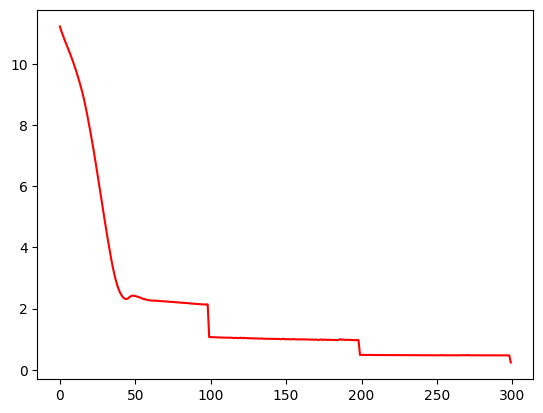

 60%|██████    | 300/500 [00:33<00:22,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.57810894141829
Dataset Name:  books , AUC Score (contextual):  47.83272283272283
Dataset Name:  books , AUC Score (structural):  41.4041966935142
Dataset Name:  books , AUC Score (joint-type):  40.501628001628
Dataset Name:  books , AUC Score (structure type):  41.11727810116872
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  40.501628001628
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


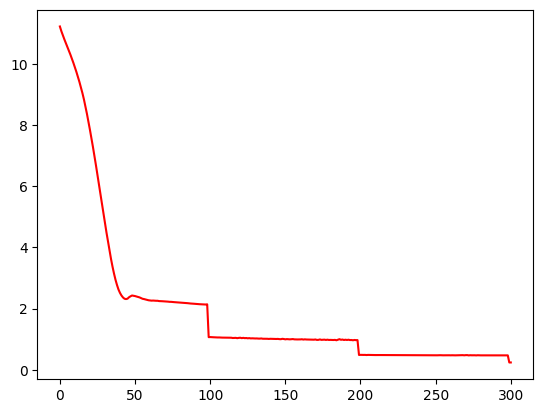

 60%|██████    | 301/500 [00:33<00:22,  8.95it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.29239465570401
Dataset Name:  books , AUC Score (contextual):  45.52299552299552
Dataset Name:  books , AUC Score (structural):  40.29779567613396
Dataset Name:  books , AUC Score (joint-type):  42.98433048433048
Dataset Name:  books , AUC Score (structure type):  40.63715536302514
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.98433048433048
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


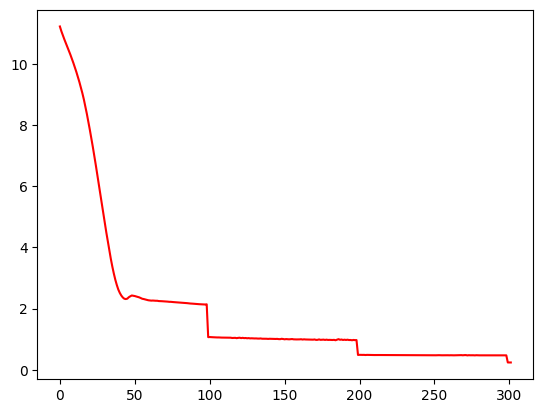

 60%|██████    | 302/500 [00:34<00:22,  8.93it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.39979445015417
Dataset Name:  books , AUC Score (contextual):  45.33984533984534
Dataset Name:  books , AUC Score (structural):  40.03603221704112
Dataset Name:  books , AUC Score (joint-type):  43.87464387464387
Dataset Name:  books , AUC Score (structure type):  40.53517440548712
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.87464387464387
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


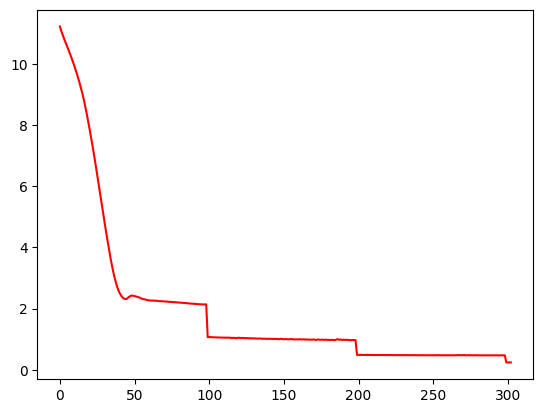

 61%|██████    | 303/500 [00:34<00:21,  8.96it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.13771839671121
Dataset Name:  books , AUC Score (contextual):  47.13064713064713
Dataset Name:  books , AUC Score (structural):  41.00148367952522
Dataset Name:  books , AUC Score (joint-type):  46.489621489621484
Dataset Name:  books , AUC Score (structure type):  41.752628491494065
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.489621489621484
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


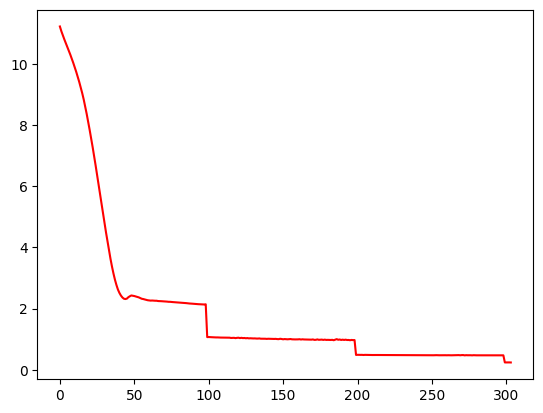

 61%|██████    | 304/500 [00:34<00:21,  8.99it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.67574511819116
Dataset Name:  books , AUC Score (contextual):  46.901709401709404
Dataset Name:  books , AUC Score (structural):  41.841882153454854
Dataset Name:  books , AUC Score (joint-type):  46.82030932030932
Dataset Name:  books , AUC Score (structure type):  42.56396372004873
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.82030932030932
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


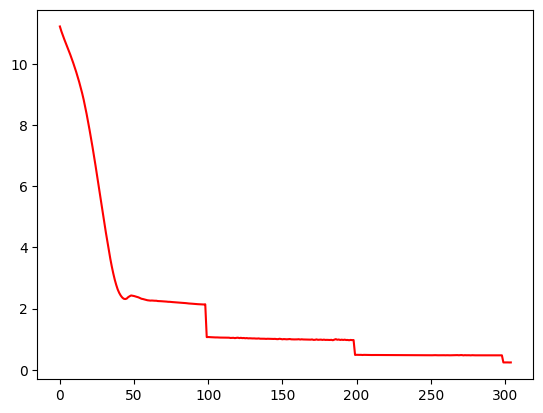

 61%|██████    | 305/500 [00:34<00:35,  5.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.33144912641315
Dataset Name:  books , AUC Score (contextual):  46.91697191697192
Dataset Name:  books , AUC Score (structural):  41.94256040695209
Dataset Name:  books , AUC Score (joint-type):  46.494708994708986
Dataset Name:  books , AUC Score (structure type):  42.52154686160372
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.494708994708986
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


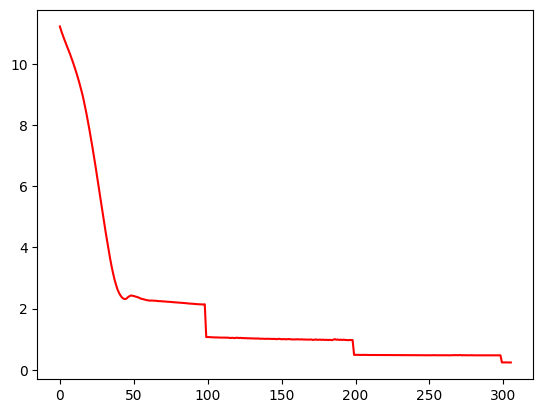

 61%|██████    | 306/500 [00:34<00:31,  6.09it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.955806783144915
Dataset Name:  books , AUC Score (contextual):  43.487993487993485
Dataset Name:  books , AUC Score (structural):  40.37091988130564
Dataset Name:  books , AUC Score (joint-type):  46.97293447293447
Dataset Name:  books , AUC Score (structure type):  41.35372952484094
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.97293447293447
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


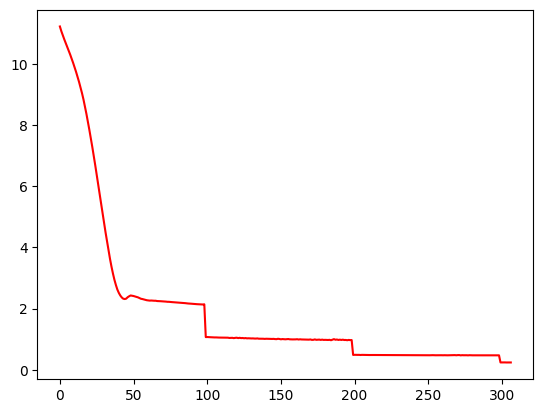

 61%|██████▏   | 307/500 [00:34<00:28,  6.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.40030832476875
Dataset Name:  books , AUC Score (contextual):  43.64570614570614
Dataset Name:  books , AUC Score (structural):  40.86901229334464
Dataset Name:  books , AUC Score (joint-type):  45.62983312983313
Dataset Name:  books , AUC Score (structure type):  41.53603176751951
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.62983312983313
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


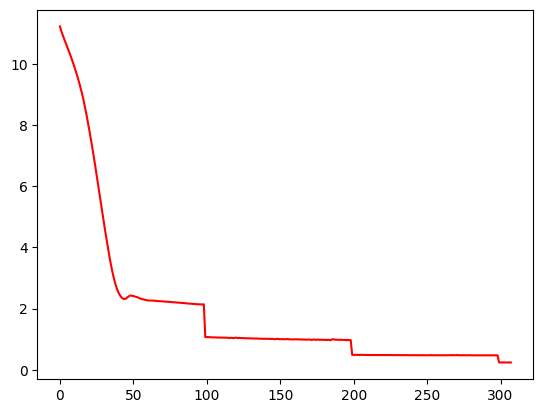

 62%|██████▏   | 308/500 [00:34<00:26,  7.26it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.6551901336074
Dataset Name:  books , AUC Score (contextual):  45.02442002442002
Dataset Name:  books , AUC Score (structural):  40.61360746078847
Dataset Name:  books , AUC Score (joint-type):  45.436507936507944
Dataset Name:  books , AUC Score (structure type):  41.26438337620144
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.436507936507944
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


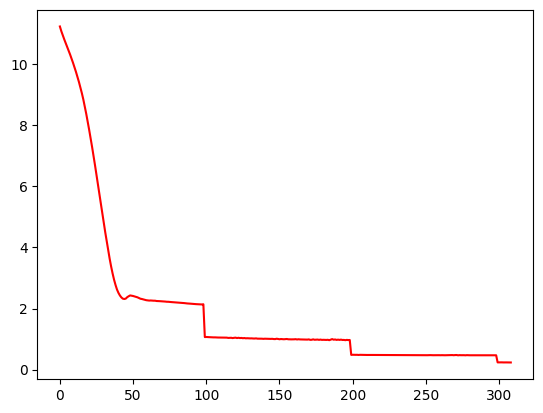

 62%|██████▏   | 309/500 [00:35<00:24,  7.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.614080164439876
Dataset Name:  books , AUC Score (contextual):  44.78530728530728
Dataset Name:  books , AUC Score (structural):  39.8389147944044
Dataset Name:  books , AUC Score (joint-type):  47.45624745624746
Dataset Name:  books , AUC Score (structure type):  41.06312892017508
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.45624745624746
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


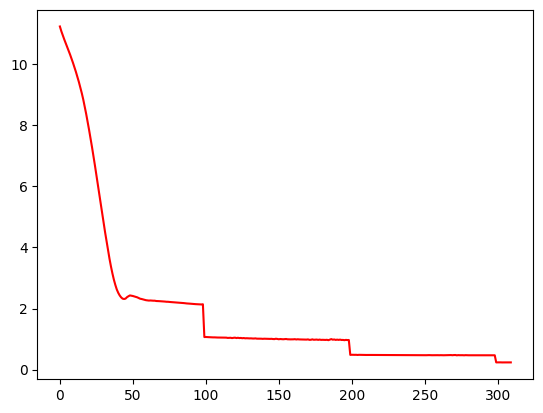

 62%|██████▏   | 310/500 [00:35<00:23,  8.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.935765673175744
Dataset Name:  books , AUC Score (contextual):  46.4997964997965
Dataset Name:  books , AUC Score (structural):  39.85905044510386
Dataset Name:  books , AUC Score (joint-type):  46.52523402523403
Dataset Name:  books , AUC Score (structure type):  40.877216732096926
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.52523402523403
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


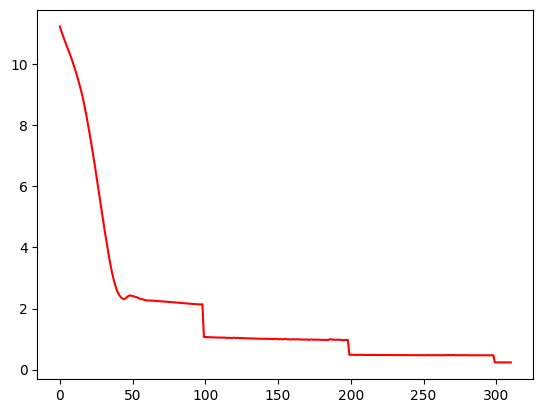

 62%|██████▏   | 311/500 [00:35<00:22,  8.35it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.707091469681394
Dataset Name:  books , AUC Score (contextual):  45.487382987382986
Dataset Name:  books , AUC Score (structural):  39.701144552776604
Dataset Name:  books , AUC Score (joint-type):  45.96560846560847
Dataset Name:  books , AUC Score (structure type):  40.59473850458012
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.96560846560847
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


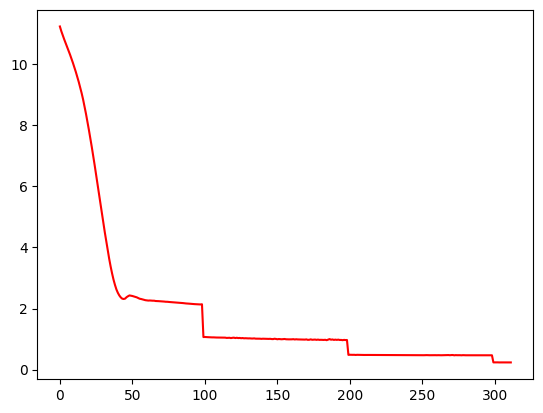

 62%|██████▏   | 312/500 [00:35<00:22,  8.52it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.128468653648504
Dataset Name:  books , AUC Score (contextual):  43.82885632885633
Dataset Name:  books , AUC Score (structural):  39.99894022891055
Dataset Name:  books , AUC Score (joint-type):  43.309930809930805
Dataset Name:  books , AUC Score (structure type):  40.39438653490367
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.309930809930805
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


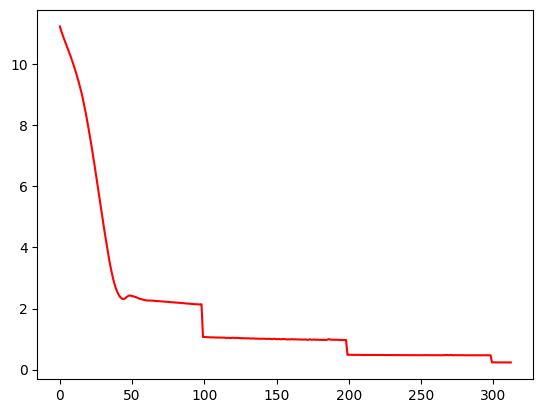

 63%|██████▎   | 313/500 [00:35<00:21,  8.66it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.34172661870504
Dataset Name:  books , AUC Score (contextual):  43.35063085063085
Dataset Name:  books , AUC Score (structural):  41.31199660873252
Dataset Name:  books , AUC Score (joint-type):  42.86223036223036
Dataset Name:  books , AUC Score (structure type):  41.430440864581925
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.86223036223036
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


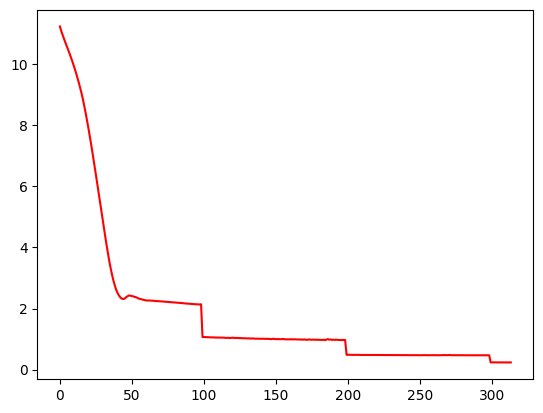

 63%|██████▎   | 314/500 [00:35<00:21,  8.80it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.089414182939365
Dataset Name:  books , AUC Score (contextual):  43.452380952380956
Dataset Name:  books , AUC Score (structural):  40.74925816023739
Dataset Name:  books , AUC Score (joint-type):  44.001831501831504
Dataset Name:  books , AUC Score (structure type):  41.17323225486215
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.001831501831504
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


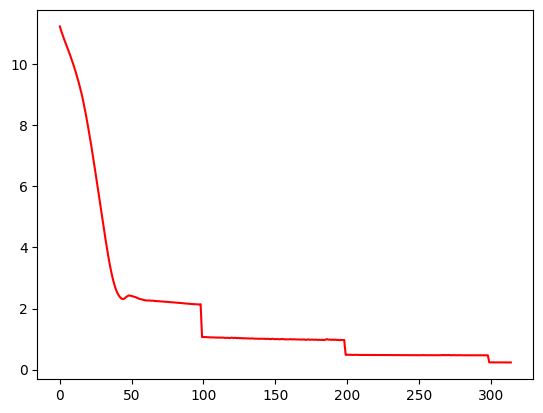

 63%|██████▎   | 315/500 [00:35<00:21,  8.77it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.5082219938335
Dataset Name:  books , AUC Score (contextual):  45.8028083028083
Dataset Name:  books , AUC Score (structural):  40.45464179737177
Dataset Name:  books , AUC Score (joint-type):  44.764957264957275
Dataset Name:  books , AUC Score (structure type):  40.982807635034526
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.764957264957275
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


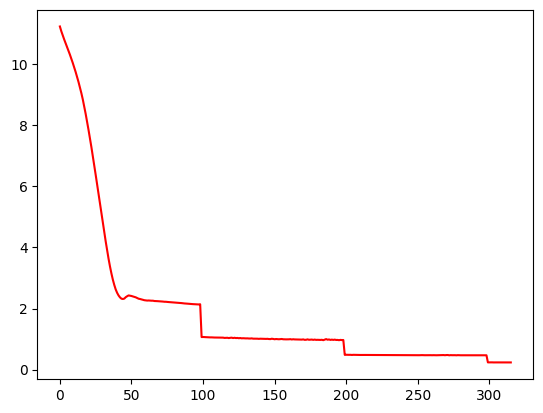

 63%|██████▎   | 316/500 [00:35<00:20,  8.78it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.30267214799589
Dataset Name:  books , AUC Score (contextual):  46.02157102157102
Dataset Name:  books , AUC Score (structural):  39.85587113183552
Dataset Name:  books , AUC Score (joint-type):  43.437118437118436
Dataset Name:  books , AUC Score (structure type):  40.34565227200939
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.437118437118436
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


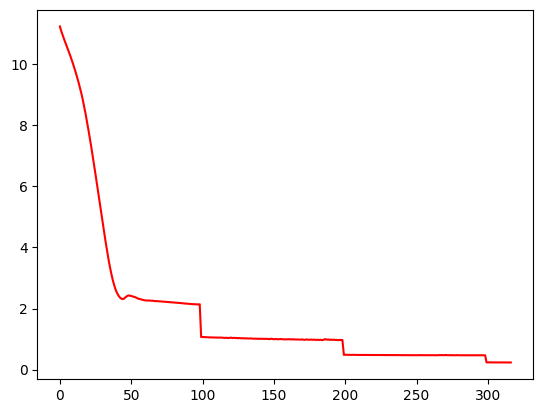

 63%|██████▎   | 317/500 [00:35<00:20,  8.75it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.64439876670094
Dataset Name:  books , AUC Score (contextual):  45.69597069597069
Dataset Name:  books , AUC Score (structural):  40.50339126748622
Dataset Name:  books , AUC Score (joint-type):  45.8994708994709
Dataset Name:  books , AUC Score (structure type):  41.25626099905239
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.8994708994709
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


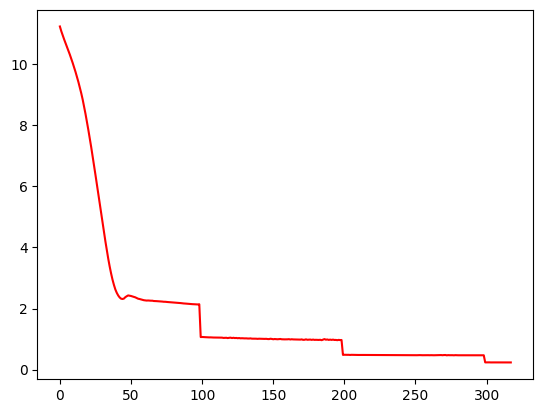

 64%|██████▎   | 318/500 [00:36<00:21,  8.33it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.78571428571429
Dataset Name:  books , AUC Score (contextual):  45.57387057387057
Dataset Name:  books , AUC Score (structural):  40.37197965239508
Dataset Name:  books , AUC Score (joint-type):  43.96621896621897
Dataset Name:  books , AUC Score (structure type):  40.83028744190244
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.96621896621897
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


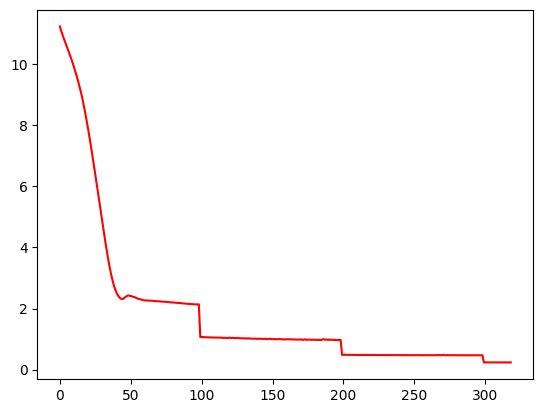

 64%|██████▍   | 319/500 [00:36<00:22,  8.22it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.4229188078109
Dataset Name:  books , AUC Score (contextual):  45.88420838420838
Dataset Name:  books , AUC Score (structural):  40.77469266638406
Dataset Name:  books , AUC Score (joint-type):  45.82824582824583
Dataset Name:  books , AUC Score (structure type):  41.537836740219305
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.82824582824583
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


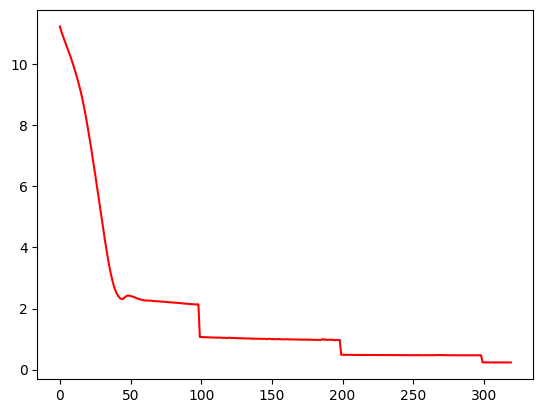

 64%|██████▍   | 320/500 [00:36<00:21,  8.32it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.2764645426516
Dataset Name:  books , AUC Score (contextual):  43.309930809930805
Dataset Name:  books , AUC Score (structural):  41.40843577787198
Dataset Name:  books , AUC Score (joint-type):  45.20757020757021
Dataset Name:  books , AUC Score (structure type):  41.960200351969675
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.20757020757021
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


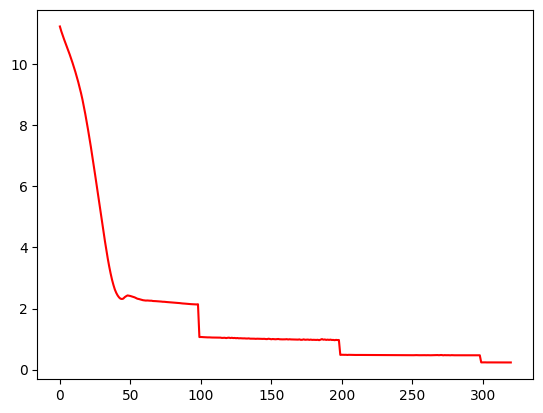

 64%|██████▍   | 321/500 [00:36<00:21,  8.49it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.0765673175745
Dataset Name:  books , AUC Score (contextual):  44.65303215303215
Dataset Name:  books , AUC Score (structural):  40.89020771513353
Dataset Name:  books , AUC Score (joint-type):  43.370980870980866
Dataset Name:  books , AUC Score (structure type):  41.24543116285366
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.370980870980866
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


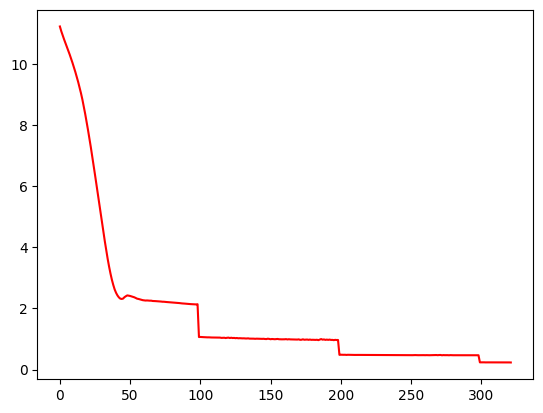

 64%|██████▍   | 322/500 [00:36<00:20,  8.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.61716341212744
Dataset Name:  books , AUC Score (contextual):  42.72486772486772
Dataset Name:  books , AUC Score (structural):  40.559559135226785
Dataset Name:  books , AUC Score (joint-type):  45.1007326007326
Dataset Name:  books , AUC Score (structure type):  41.31943504354497
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.1007326007326
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


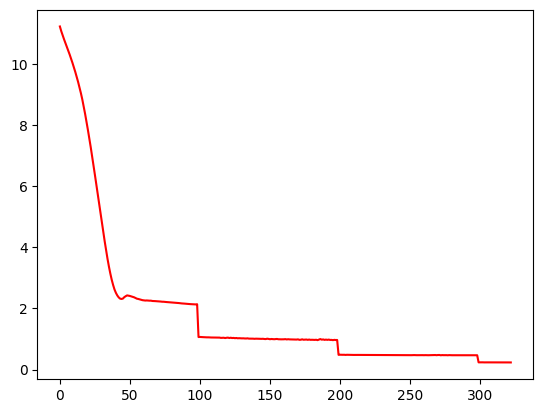

 65%|██████▍   | 323/500 [00:36<00:20,  8.77it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.2672147995889
Dataset Name:  books , AUC Score (contextual):  41.66666666666667
Dataset Name:  books , AUC Score (structural):  40.423908435777875
Dataset Name:  books , AUC Score (joint-type):  44.21041921041921
Dataset Name:  books , AUC Score (structure type):  40.936780831189935
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.21041921041921
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


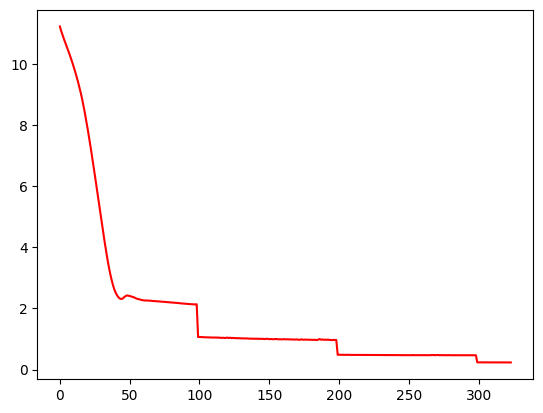

 65%|██████▍   | 324/500 [00:36<00:19,  8.89it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.54984583761562
Dataset Name:  books , AUC Score (contextual):  44.31216931216932
Dataset Name:  books , AUC Score (structural):  39.67782958880882
Dataset Name:  books , AUC Score (joint-type):  43.65079365079365
Dataset Name:  books , AUC Score (structure type):  40.30774784531385
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.65079365079365
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


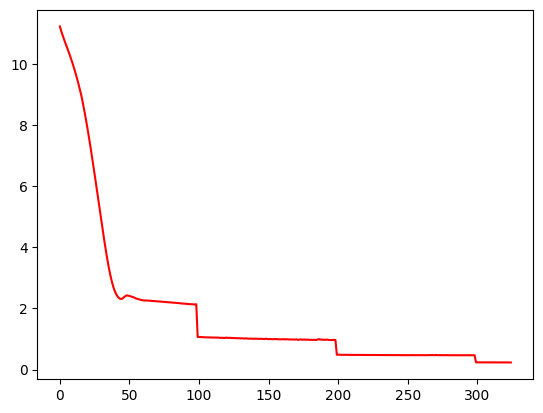

 65%|██████▌   | 325/500 [00:36<00:19,  9.07it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.4727646454265
Dataset Name:  books , AUC Score (contextual):  45.58404558404558
Dataset Name:  books , AUC Score (structural):  40.20983467571004
Dataset Name:  books , AUC Score (joint-type):  43.223443223443226
Dataset Name:  books , AUC Score (structure type):  40.518929651189026
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.223443223443226
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


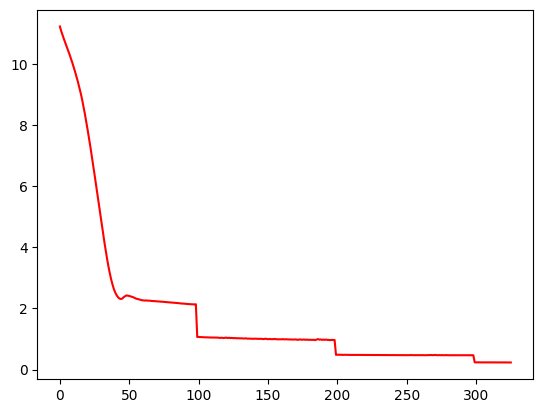

 65%|██████▌   | 326/500 [00:37<00:19,  9.07it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.69835560123329
Dataset Name:  books , AUC Score (contextual):  46.43365893365894
Dataset Name:  books , AUC Score (structural):  40.68673166596016
Dataset Name:  books , AUC Score (joint-type):  44.35795685795686
Dataset Name:  books , AUC Score (structure type):  41.10193583322052
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.35795685795686
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


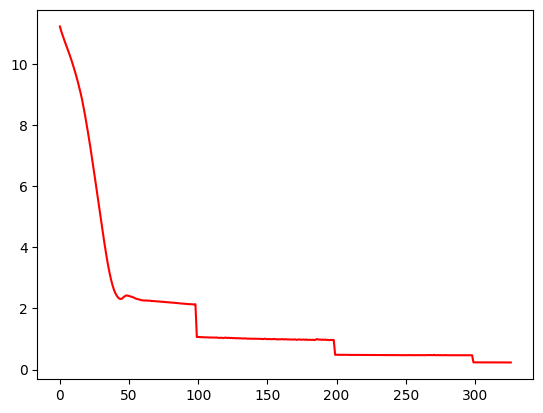

 65%|██████▌   | 327/500 [00:37<00:19,  9.09it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.04059609455293
Dataset Name:  books , AUC Score (contextual):  45.82824582824583
Dataset Name:  books , AUC Score (structural):  41.354387452310306
Dataset Name:  books , AUC Score (joint-type):  43.732193732193736
Dataset Name:  books , AUC Score (structure type):  41.62628040250891
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.732193732193736
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


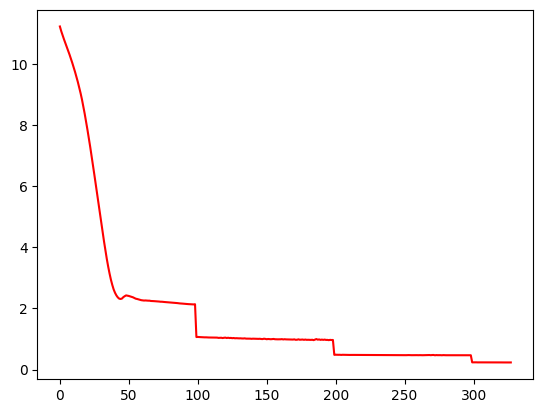

 66%|██████▌   | 328/500 [00:37<00:18,  9.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.79650565262076
Dataset Name:  books , AUC Score (contextual):  46.14112739112739
Dataset Name:  books , AUC Score (structural):  40.08584145824502
Dataset Name:  books , AUC Score (joint-type):  45.90964590964591
Dataset Name:  books , AUC Score (structure type):  40.88624159559587
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.90964590964591
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


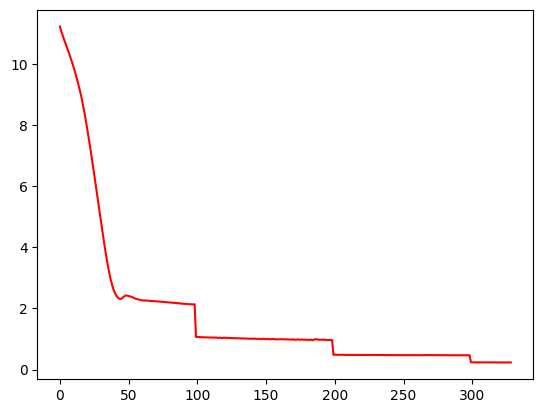

 66%|██████▌   | 329/500 [00:37<00:18,  9.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.00359712230216
Dataset Name:  books , AUC Score (contextual):  43.72201872201872
Dataset Name:  books , AUC Score (structural):  39.57397202204324
Dataset Name:  books , AUC Score (joint-type):  45.8994708994709
Dataset Name:  books , AUC Score (structure type):  40.41333874825143
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.8994708994709
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


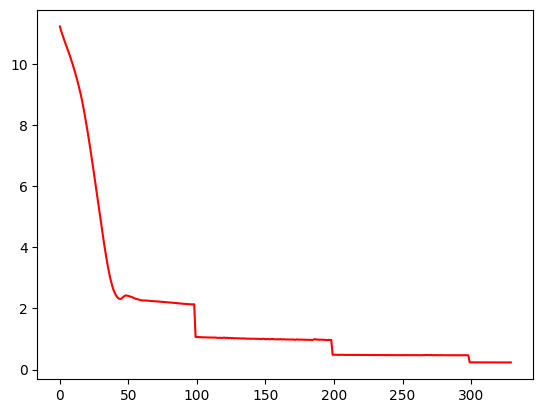

 66%|██████▌   | 330/500 [00:37<00:18,  9.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.69064748201439
Dataset Name:  books , AUC Score (contextual):  43.376068376068375
Dataset Name:  books , AUC Score (structural):  40.695209834675715
Dataset Name:  books , AUC Score (joint-type):  45.31440781440782
Dataset Name:  books , AUC Score (structure type):  41.25626099905239
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.31440781440782
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


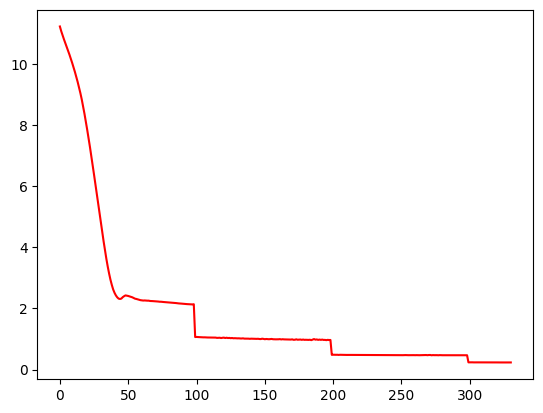

 66%|██████▌   | 331/500 [00:37<00:18,  9.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.27440904419322
Dataset Name:  books , AUC Score (contextual):  43.147130647130645
Dataset Name:  books , AUC Score (structural):  40.60936837643069
Dataset Name:  books , AUC Score (joint-type):  46.331908831908834
Dataset Name:  books , AUC Score (structure type):  41.40878119218446
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.331908831908834
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


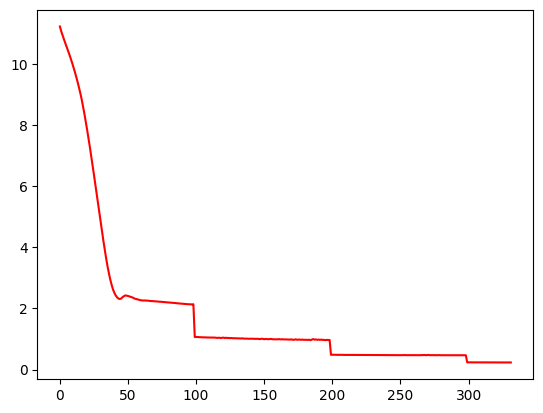

 66%|██████▋   | 332/500 [00:37<00:18,  9.20it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.27183967112024
Dataset Name:  books , AUC Score (contextual):  44.38848188848189
Dataset Name:  books , AUC Score (structural):  39.97456549385333
Dataset Name:  books , AUC Score (joint-type):  44.36813186813187
Dataset Name:  books , AUC Score (structure type):  40.462073011145705
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.36813186813187
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


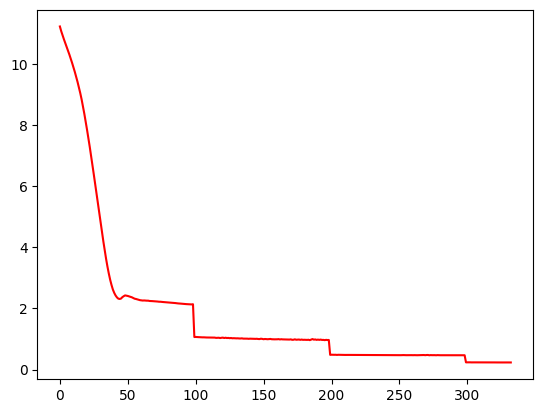

 67%|██████▋   | 333/500 [00:37<00:18,  9.11it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.765673175745114
Dataset Name:  books , AUC Score (contextual):  44.001831501831504
Dataset Name:  books , AUC Score (structural):  40.79376854599406
Dataset Name:  books , AUC Score (joint-type):  45.05494505494506
Dataset Name:  books , AUC Score (structure type):  41.31853255719507
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.05494505494506
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


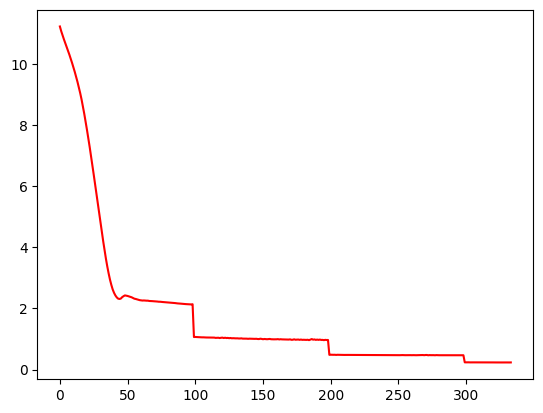

 67%|██████▋   | 334/500 [00:37<00:19,  8.73it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.87615621788284
Dataset Name:  books , AUC Score (contextual):  42.90801790801791
Dataset Name:  books , AUC Score (structural):  40.34760491733785
Dataset Name:  books , AUC Score (joint-type):  43.203093203093204
Dataset Name:  books , AUC Score (structure type):  40.70574432561708
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.203093203093204
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


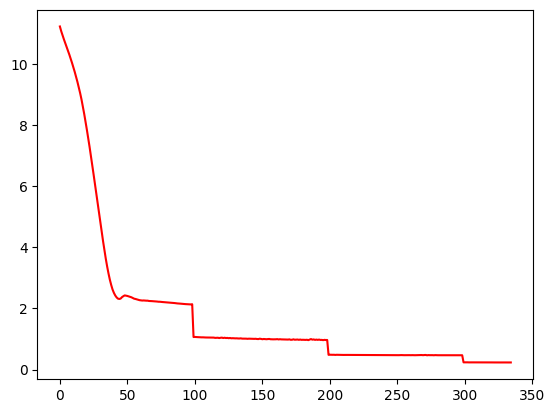

 67%|██████▋   | 335/500 [00:38<00:19,  8.63it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.64182939362796
Dataset Name:  books , AUC Score (contextual):  45.91982091982092
Dataset Name:  books , AUC Score (structural):  40.01271725307334
Dataset Name:  books , AUC Score (joint-type):  45.543345543345545
Dataset Name:  books , AUC Score (structure type):  40.80953025585488
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.543345543345545
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


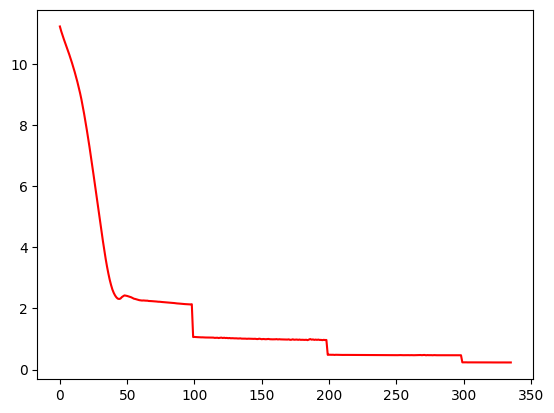

 67%|██████▋   | 336/500 [00:38<00:18,  8.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.9218910585817
Dataset Name:  books , AUC Score (contextual):  43.8949938949939
Dataset Name:  books , AUC Score (structural):  40.99830436625689
Dataset Name:  books , AUC Score (joint-type):  44.20533170533171
Dataset Name:  books , AUC Score (structure type):  41.330264879743694
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.20533170533171
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


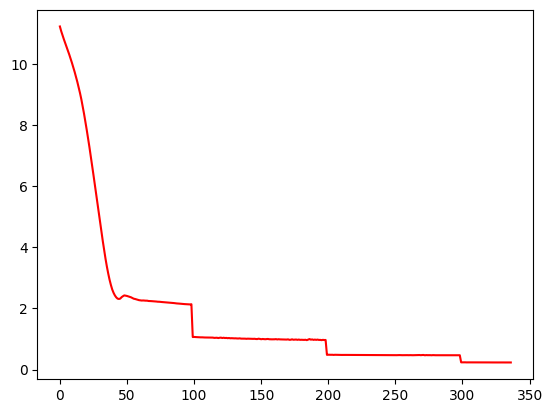

 67%|██████▋   | 337/500 [00:38<00:18,  8.88it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.61921891058583
Dataset Name:  books , AUC Score (contextual):  43.17765567765567
Dataset Name:  books , AUC Score (structural):  40.95909283594744
Dataset Name:  books , AUC Score (joint-type):  43.48290598290599
Dataset Name:  books , AUC Score (structure type):  41.22647894950589
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.48290598290599
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


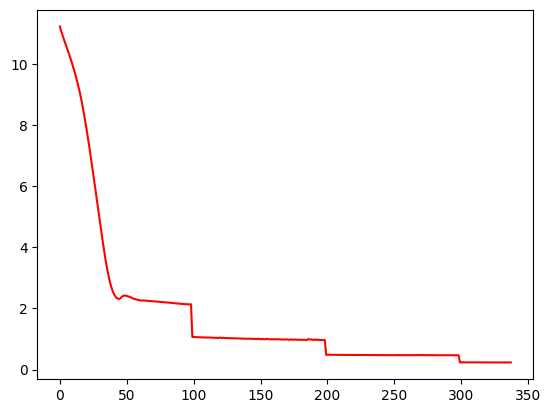

 68%|██████▊   | 338/500 [00:38<00:17,  9.03it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.858170606372056
Dataset Name:  books , AUC Score (contextual):  45.21774521774521
Dataset Name:  books , AUC Score (structural):  41.45930479016532
Dataset Name:  books , AUC Score (joint-type):  45.090557590557594
Dataset Name:  books , AUC Score (structure type):  41.88709895762827
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.090557590557594
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


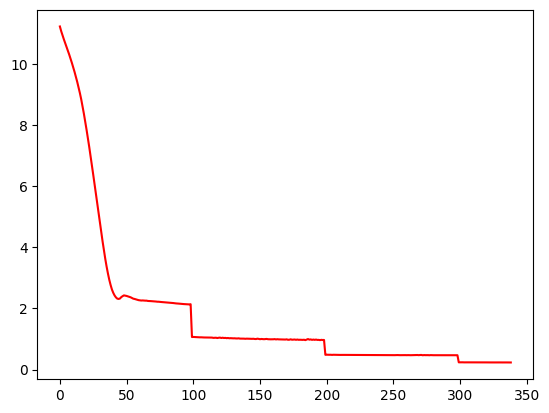

 68%|██████▊   | 339/500 [00:38<00:17,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.57708119218912
Dataset Name:  books , AUC Score (contextual):  41.36650386650387
Dataset Name:  books , AUC Score (structural):  39.39487070792709
Dataset Name:  books , AUC Score (joint-type):  44.71408221408222
Dataset Name:  books , AUC Score (structure type):  40.067686476242045
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.71408221408222
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


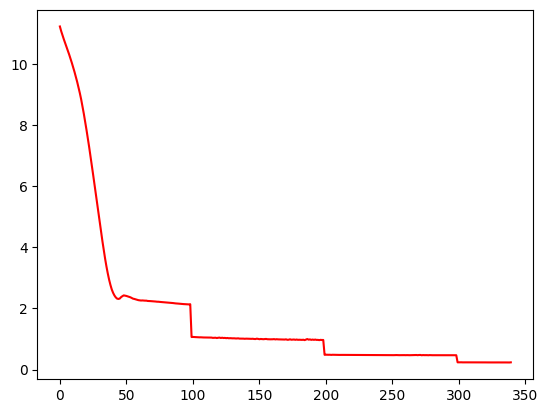

 68%|██████▊   | 340/500 [00:38<00:18,  8.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.97122302158273
Dataset Name:  books , AUC Score (contextual):  44.851444851444846
Dataset Name:  books , AUC Score (structural):  40.14730818143281
Dataset Name:  books , AUC Score (joint-type):  42.704517704517706
Dataset Name:  books , AUC Score (structure type):  40.4927575470421
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.704517704517706
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


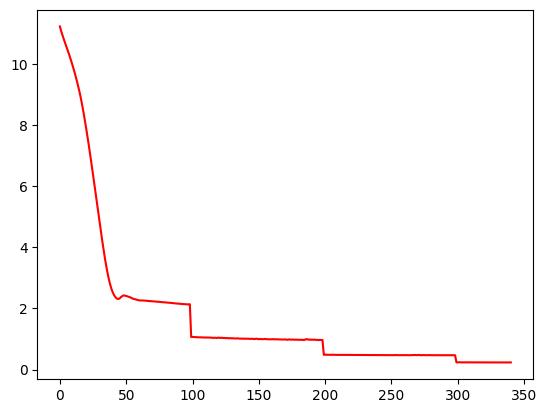

 68%|██████▊   | 341/500 [00:38<00:18,  8.43it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.76824254881809
Dataset Name:  books , AUC Score (contextual):  44.28164428164428
Dataset Name:  books , AUC Score (structural):  40.225731242051715
Dataset Name:  books , AUC Score (joint-type):  43.57956857956858
Dataset Name:  books , AUC Score (structure type):  40.64798519922386
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.57956857956858
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


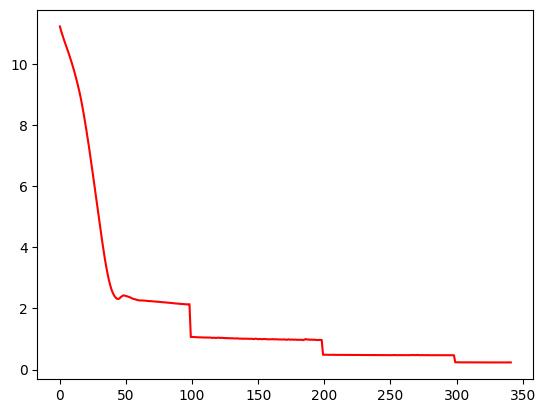

 68%|██████▊   | 342/500 [00:38<00:18,  8.56it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.618705035971225
Dataset Name:  books , AUC Score (contextual):  43.961131461131465
Dataset Name:  books , AUC Score (structural):  39.881305637982194
Dataset Name:  books , AUC Score (joint-type):  47.502035002035
Dataset Name:  books , AUC Score (structure type):  40.97649023058526
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.502035002035
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


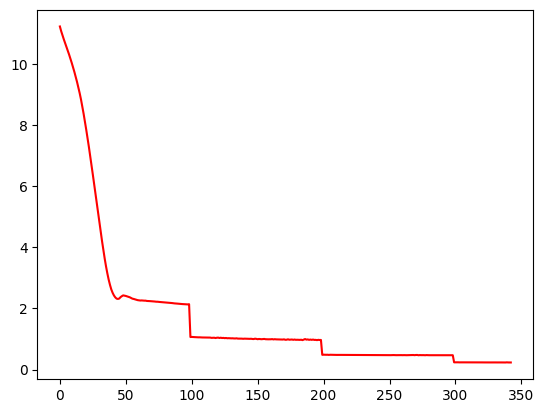

 69%|██████▊   | 343/500 [00:38<00:17,  8.74it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.00924974306269
Dataset Name:  books , AUC Score (contextual):  42.974155474155474
Dataset Name:  books , AUC Score (structural):  40.047689699025014
Dataset Name:  books , AUC Score (joint-type):  47.25783475783476
Dataset Name:  books , AUC Score (structure type):  41.036054329678265
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.25783475783476
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


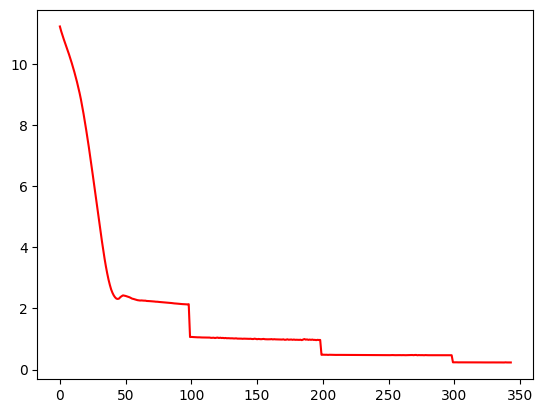

 69%|██████▉   | 344/500 [00:39<00:18,  8.60it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.289311408016445
Dataset Name:  books , AUC Score (contextual):  45.324582824582826
Dataset Name:  books , AUC Score (structural):  40.742899533700715
Dataset Name:  books , AUC Score (joint-type):  45.77737077737078
Dataset Name:  books , AUC Score (structure type):  41.350119579441355
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.77737077737078
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


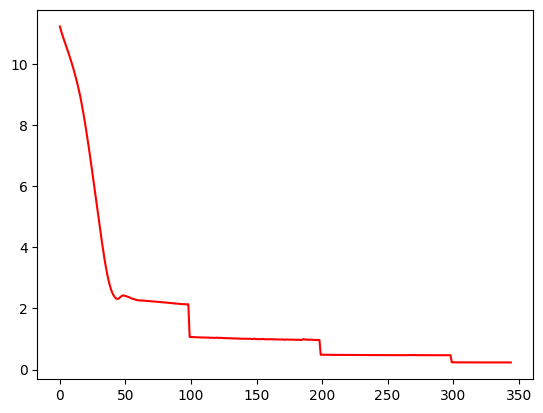

 69%|██████▉   | 345/500 [00:39<00:18,  8.58it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.15056526207605
Dataset Name:  books , AUC Score (contextual):  43.28958078958078
Dataset Name:  books , AUC Score (structural):  40.96015260703688
Dataset Name:  books , AUC Score (joint-type):  43.315018315018314
Dataset Name:  books , AUC Score (structure type):  41.09742340147105
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.315018315018314
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


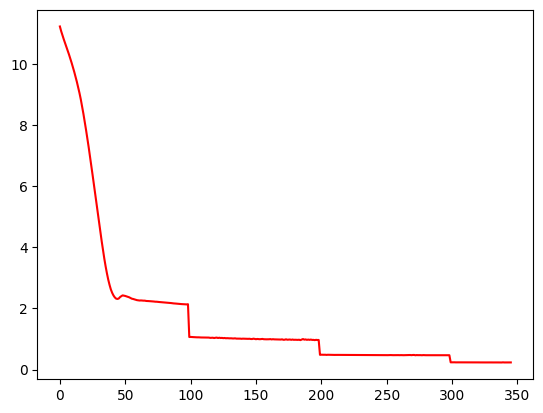

 69%|██████▉   | 346/500 [00:39<00:17,  8.66it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.58787255909558
Dataset Name:  books , AUC Score (contextual):  44.2002442002442
Dataset Name:  books , AUC Score (structural):  40.7662144976685
Dataset Name:  books , AUC Score (joint-type):  44.41391941391941
Dataset Name:  books , AUC Score (structure type):  41.12179053291818
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.41391941391941
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


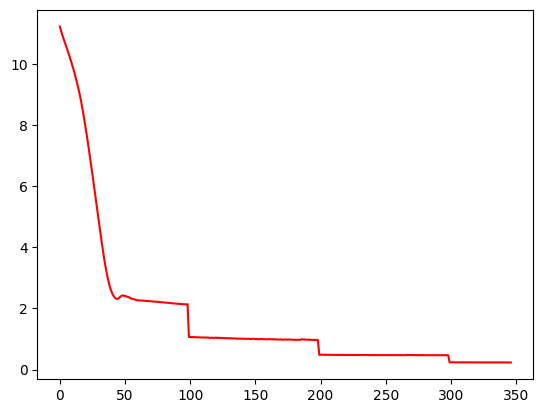

 69%|██████▉   | 347/500 [00:39<00:17,  8.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.076567317574515
Dataset Name:  books , AUC Score (contextual):  43.47273097273097
Dataset Name:  books , AUC Score (structural):  40.25540483255617
Dataset Name:  books , AUC Score (joint-type):  43.40150590150591
Dataset Name:  books , AUC Score (structure type):  40.72469653896484
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.40150590150591
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


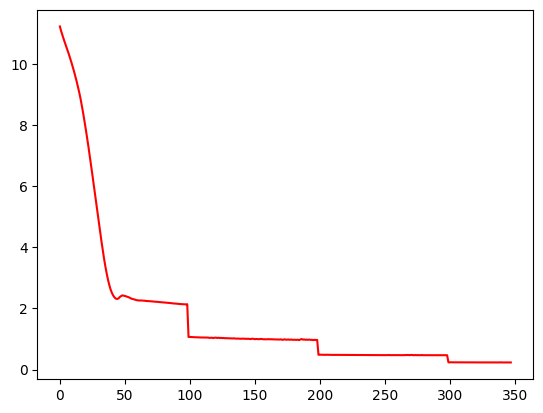

 70%|██████▉   | 348/500 [00:39<00:17,  8.93it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.75231243576567
Dataset Name:  books , AUC Score (contextual):  44.39356939356939
Dataset Name:  books , AUC Score (structural):  40.61996608732514
Dataset Name:  books , AUC Score (joint-type):  46.377696377696374
Dataset Name:  books , AUC Score (structure type):  41.351022065791255
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.377696377696374
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


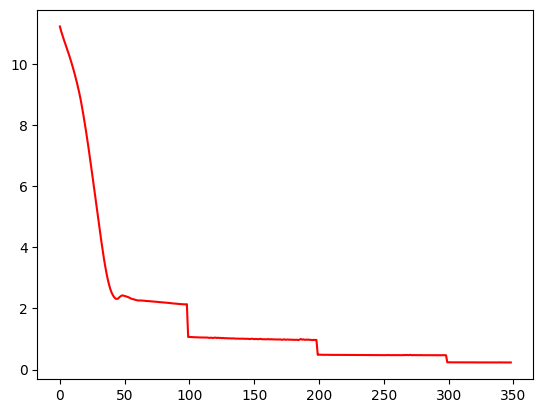

 70%|██████▉   | 349/500 [00:39<00:17,  8.51it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.114594039054474
Dataset Name:  books , AUC Score (contextual):  42.8927553927554
Dataset Name:  books , AUC Score (structural):  40.971810089020764
Dataset Name:  books , AUC Score (joint-type):  46.65750915750916
Dataset Name:  books , AUC Score (structure type):  41.76977573214206
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.65750915750916
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


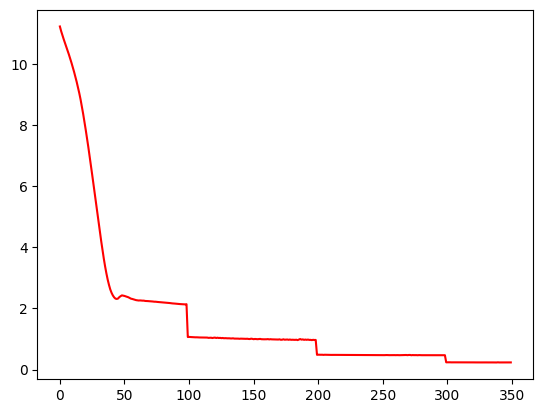

 70%|███████   | 350/500 [00:39<00:17,  8.57it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.51901336073998
Dataset Name:  books , AUC Score (contextual):  44.28164428164428
Dataset Name:  books , AUC Score (structural):  40.2490462060195
Dataset Name:  books , AUC Score (joint-type):  44.61233211233211
Dataset Name:  books , AUC Score (structure type):  40.94580569468887
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.61233211233211
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


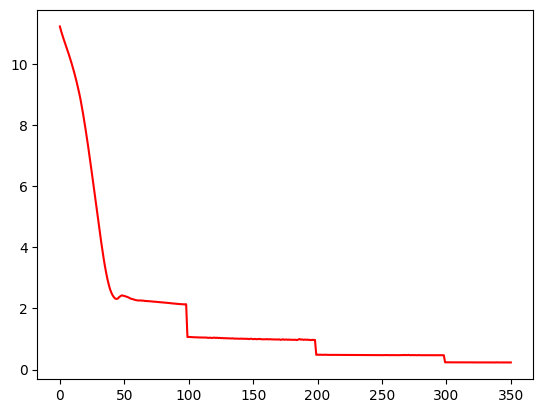

 70%|███████   | 351/500 [00:40<00:28,  5.18it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.197327852004115
Dataset Name:  books , AUC Score (contextual):  43.27940577940577
Dataset Name:  books , AUC Score (structural):  40.20453582026283
Dataset Name:  books , AUC Score (joint-type):  45.05494505494505
Dataset Name:  books , AUC Score (structure type):  40.89346148639501
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.05494505494505
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


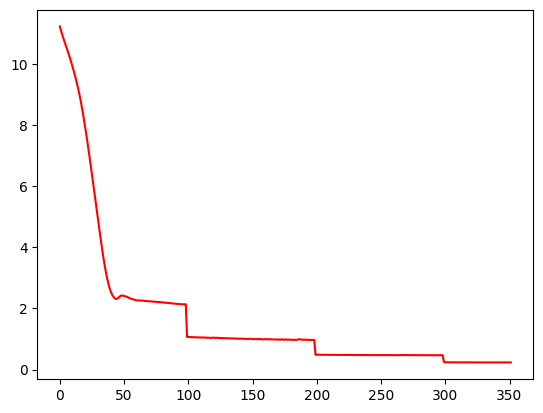

 70%|███████   | 352/500 [00:40<00:25,  5.84it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.585817060637204
Dataset Name:  books , AUC Score (contextual):  43.75763125763125
Dataset Name:  books , AUC Score (structural):  40.92518016108521
Dataset Name:  books , AUC Score (joint-type):  43.35571835571836
Dataset Name:  books , AUC Score (structure type):  41.13713280086639
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.35571835571836
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


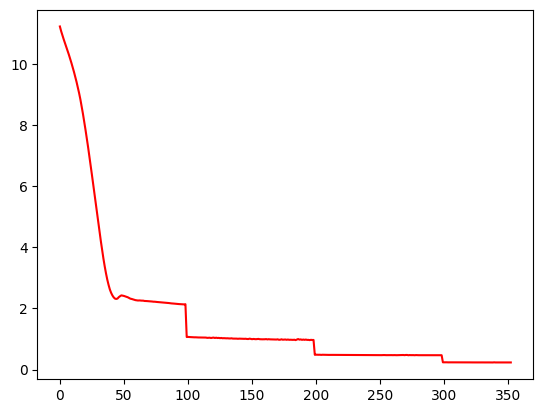

 71%|███████   | 353/500 [00:40<00:22,  6.54it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.51901336073999
Dataset Name:  books , AUC Score (contextual):  44.1035816035816
Dataset Name:  books , AUC Score (structural):  39.61000423908436
Dataset Name:  books , AUC Score (joint-type):  45.655270655270655
Dataset Name:  books , AUC Score (structure type):  40.500879924191146
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.655270655270655
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


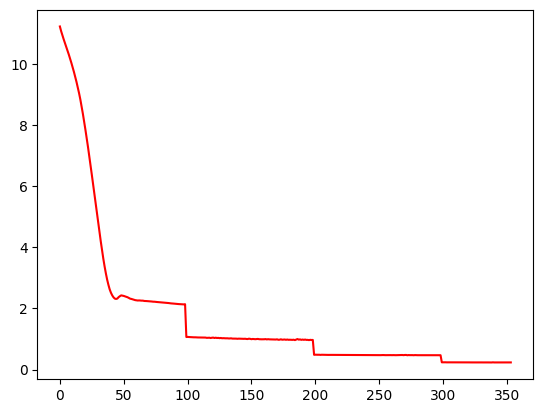

 71%|███████   | 354/500 [00:40<00:20,  7.19it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.251284686536486
Dataset Name:  books , AUC Score (contextual):  45.14652014652014
Dataset Name:  books , AUC Score (structural):  40.21725307333617
Dataset Name:  books , AUC Score (joint-type):  47.425722425722434
Dataset Name:  books , AUC Score (structure type):  41.220161545056634
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.425722425722434
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


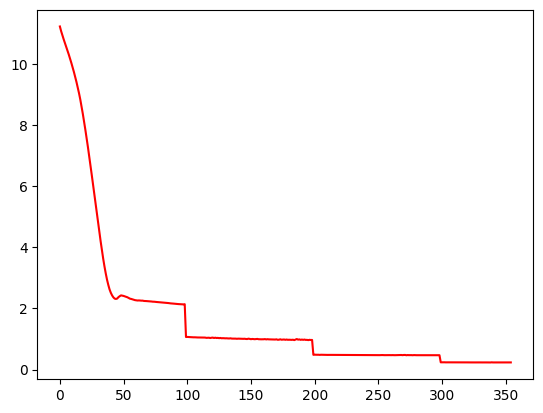

 71%|███████   | 355/500 [00:40<00:18,  7.73it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.567317574511826
Dataset Name:  books , AUC Score (contextual):  44.20533170533171
Dataset Name:  books , AUC Score (structural):  40.58075455701569
Dataset Name:  books , AUC Score (joint-type):  46.41330891330891
Dataset Name:  books , AUC Score (structure type):  41.361851901989986
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.41330891330891
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


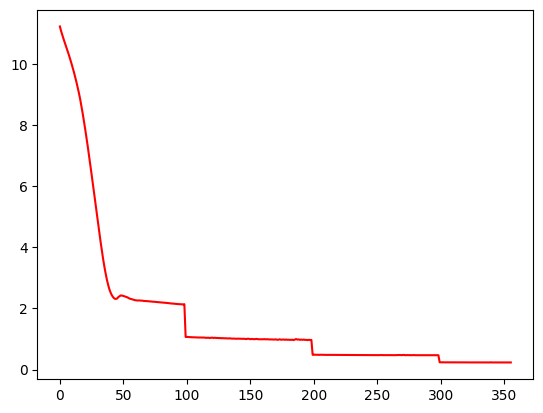

 71%|███████   | 356/500 [00:40<00:17,  8.14it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.536485097636174
Dataset Name:  books , AUC Score (contextual):  42.78083028083029
Dataset Name:  books , AUC Score (structural):  41.48685883849089
Dataset Name:  books , AUC Score (joint-type):  43.14713064713065
Dataset Name:  books , AUC Score (structure type):  41.58025359866432
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.14713064713065
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


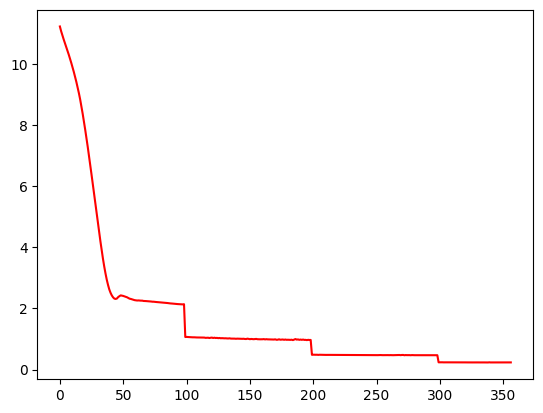

 71%|███████▏  | 357/500 [00:40<00:16,  8.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.11973278520042
Dataset Name:  books , AUC Score (contextual):  45.66544566544567
Dataset Name:  books , AUC Score (structural):  40.34442560406952
Dataset Name:  books , AUC Score (joint-type):  45.95543345543345
Dataset Name:  books , AUC Score (structure type):  41.24904110825324
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.95543345543345
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


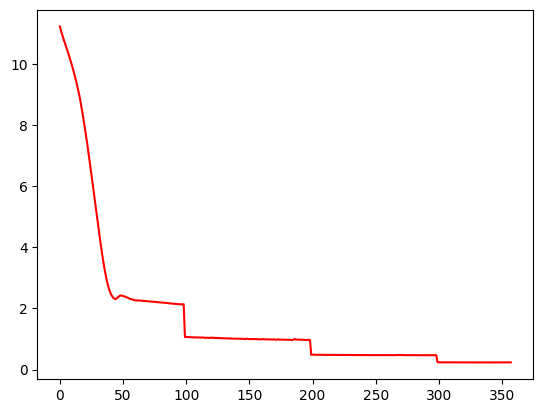

 72%|███████▏  | 358/500 [00:40<00:16,  8.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.00462487153134
Dataset Name:  books , AUC Score (contextual):  45.68579568579568
Dataset Name:  books , AUC Score (structural):  40.59347181008902
Dataset Name:  books , AUC Score (joint-type):  46.047008547008545
Dataset Name:  books , AUC Score (structure type):  41.25084608095303
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.047008547008545
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


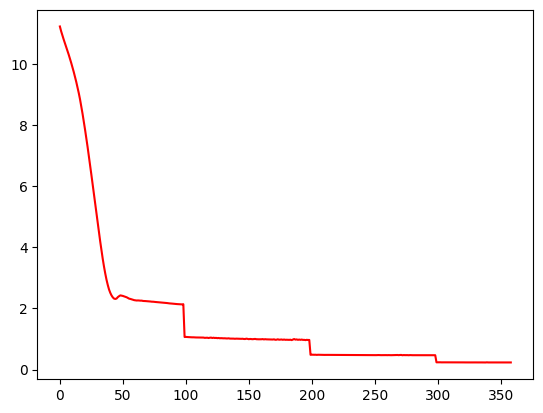

 72%|███████▏  | 359/500 [00:41<00:15,  8.90it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.963514902363826
Dataset Name:  books , AUC Score (contextual):  46.03174603174603
Dataset Name:  books , AUC Score (structural):  41.54090716405256
Dataset Name:  books , AUC Score (joint-type):  45.416157916157914
Dataset Name:  books , AUC Score (structure type):  42.02517936916204
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.416157916157914
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


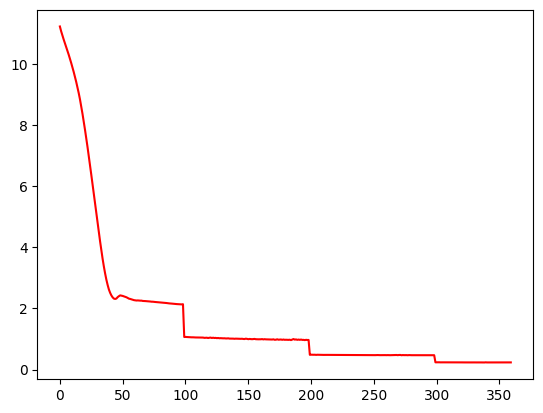

 72%|███████▏  | 360/500 [00:41<00:15,  8.95it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.03288797533401
Dataset Name:  books , AUC Score (contextual):  40.537240537240535
Dataset Name:  books , AUC Score (structural):  39.48283170835099
Dataset Name:  books , AUC Score (joint-type):  45.63492063492063
Dataset Name:  books , AUC Score (structure type):  40.26172104146924
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.63492063492063
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


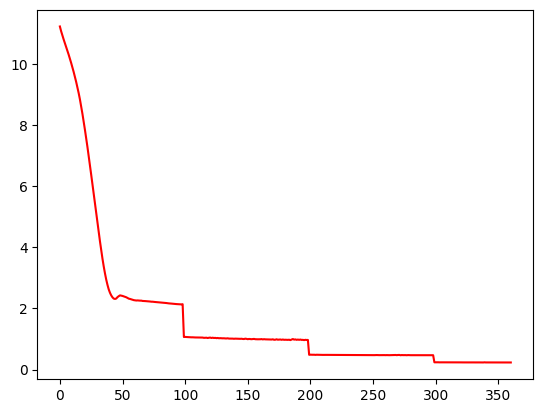

 72%|███████▏  | 361/500 [00:41<00:15,  9.07it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.51387461459403
Dataset Name:  books , AUC Score (contextual):  43.10643060643061
Dataset Name:  books , AUC Score (structural):  39.58033064857991
Dataset Name:  books , AUC Score (joint-type):  45.945258445258446
Dataset Name:  books , AUC Score (structure type):  40.58029872298181
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.945258445258446
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


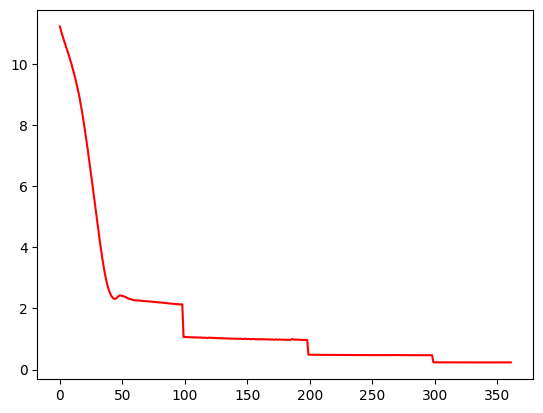

 72%|███████▏  | 362/500 [00:41<00:15,  9.12it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.7502569373073
Dataset Name:  books , AUC Score (contextual):  44.22568172568172
Dataset Name:  books , AUC Score (structural):  40.401653242899535
Dataset Name:  books , AUC Score (joint-type):  47.26292226292227
Dataset Name:  books , AUC Score (structure type):  41.3744867108885
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.26292226292227
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


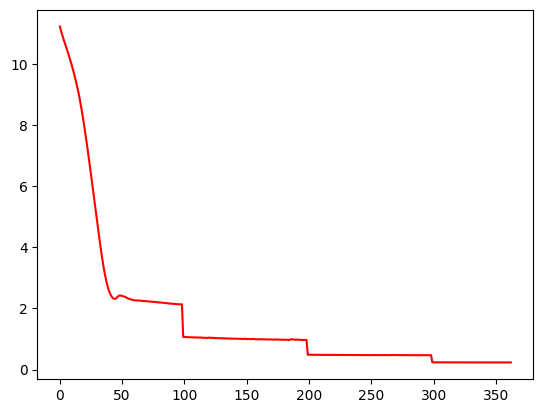

 73%|███████▎  | 363/500 [00:41<00:14,  9.20it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.987153134635165
Dataset Name:  books , AUC Score (contextual):  44.627594627594625
Dataset Name:  books , AUC Score (structural):  40.270241627808396
Dataset Name:  books , AUC Score (joint-type):  42.33312983312983
Dataset Name:  books , AUC Score (structure type):  40.57849375028203
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  42.33312983312983
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


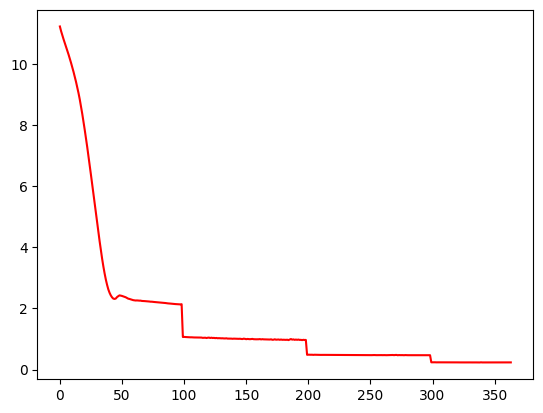

 73%|███████▎  | 364/500 [00:41<00:14,  9.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.57245632065775
Dataset Name:  books , AUC Score (contextual):  46.07753357753357
Dataset Name:  books , AUC Score (structural):  39.90779991521831
Dataset Name:  books , AUC Score (joint-type):  46.02157102157102
Dataset Name:  books , AUC Score (structure type):  40.69671946211814
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.02157102157102
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


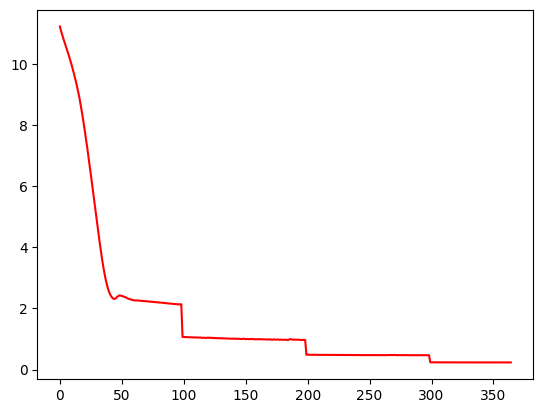

 73%|███████▎  | 365/500 [00:41<00:14,  9.23it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.06320657759507
Dataset Name:  books , AUC Score (contextual):  43.543956043956044
Dataset Name:  books , AUC Score (structural):  39.998940228910556
Dataset Name:  books , AUC Score (joint-type):  47.023809523809526
Dataset Name:  books , AUC Score (structure type):  40.98732006678399
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.023809523809526
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


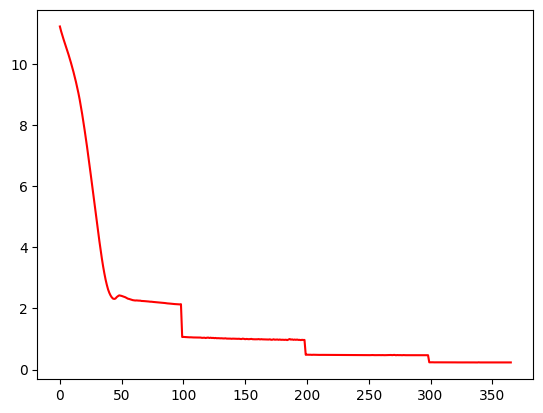

 73%|███████▎  | 366/500 [00:41<00:14,  9.21it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.05601233299075
Dataset Name:  books , AUC Score (contextual):  45.492470492470495
Dataset Name:  books , AUC Score (structural):  40.55214073760068
Dataset Name:  books , AUC Score (joint-type):  47.17134717134717
Dataset Name:  books , AUC Score (structure type):  41.404268760434995
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.17134717134717
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


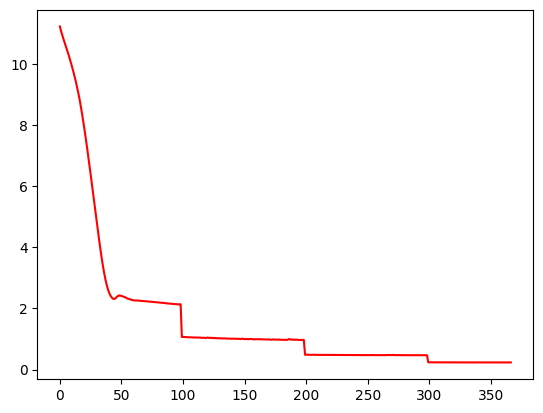

 73%|███████▎  | 367/500 [00:41<00:14,  9.28it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.27183967112024
Dataset Name:  books , AUC Score (contextual):  45.47720797720798
Dataset Name:  books , AUC Score (structural):  40.23632895294616
Dataset Name:  books , AUC Score (joint-type):  45.74684574684575
Dataset Name:  books , AUC Score (structure type):  40.951220612788234
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.74684574684575
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


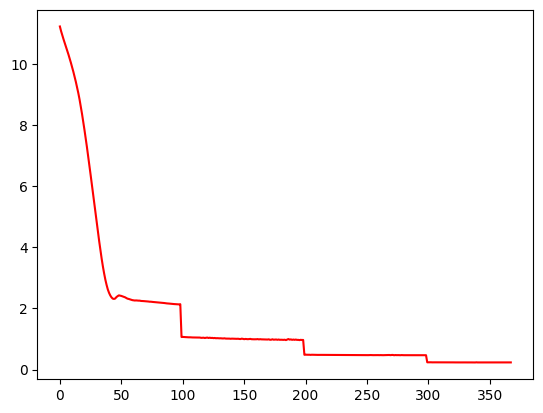

 74%|███████▎  | 368/500 [00:41<00:14,  9.30it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.06372045220966
Dataset Name:  books , AUC Score (contextual):  43.152218152218154
Dataset Name:  books , AUC Score (structural):  40.00529885544722
Dataset Name:  books , AUC Score (joint-type):  46.76434676434677
Dataset Name:  books , AUC Score (structure type):  40.88624159559586
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.76434676434677
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


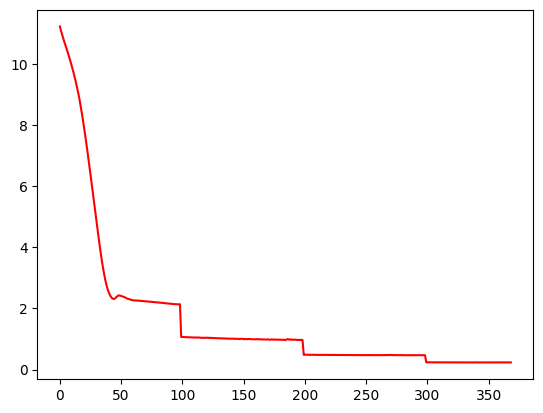

 74%|███████▍  | 369/500 [00:42<00:14,  9.35it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.465056526207604
Dataset Name:  books , AUC Score (contextual):  40.995115995115995
Dataset Name:  books , AUC Score (structural):  39.686307757524375
Dataset Name:  books , AUC Score (joint-type):  45.85368335368335
Dataset Name:  books , AUC Score (structure type):  40.47922025179369
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.85368335368335
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


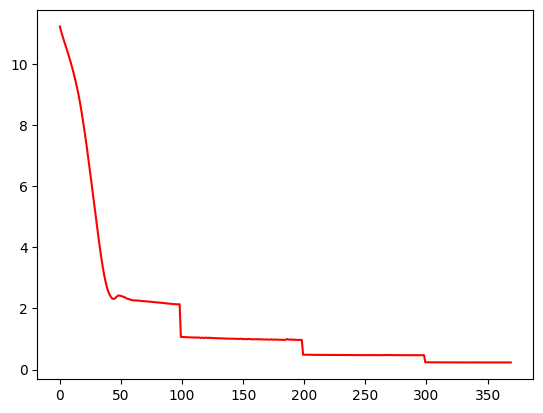

 74%|███████▍  | 370/500 [00:42<00:13,  9.37it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.67574511819117
Dataset Name:  books , AUC Score (contextual):  41.98717948717949
Dataset Name:  books , AUC Score (structural):  40.19075879610005
Dataset Name:  books , AUC Score (joint-type):  47.349409849409845
Dataset Name:  books , AUC Score (structure type):  41.2102341952078
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.349409849409845
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


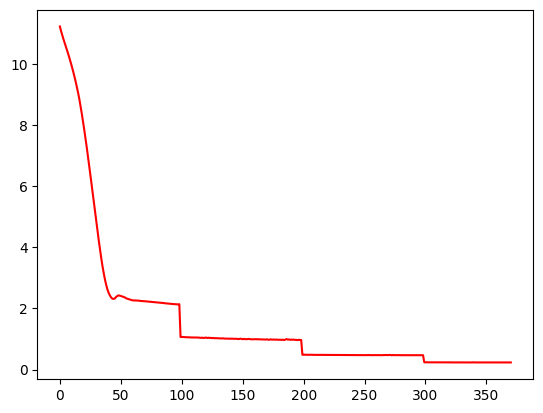

 74%|███████▍  | 371/500 [00:42<00:13,  9.39it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.86022610483042
Dataset Name:  books , AUC Score (contextual):  41.6005291005291
Dataset Name:  books , AUC Score (structural):  40.21937261551505
Dataset Name:  books , AUC Score (joint-type):  46.13858363858364
Dataset Name:  books , AUC Score (structure type):  41.050494111276564
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.13858363858364
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


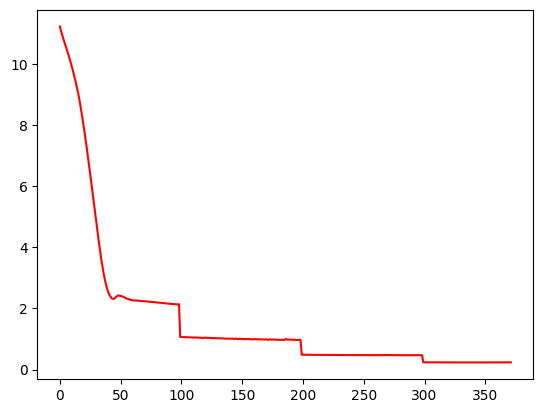

 74%|███████▍  | 372/500 [00:42<00:13,  9.32it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.68036998972251
Dataset Name:  books , AUC Score (contextual):  43.82376882376882
Dataset Name:  books , AUC Score (structural):  39.69478592623993
Dataset Name:  books , AUC Score (joint-type):  45.97069597069597
Dataset Name:  books , AUC Score (structure type):  40.528857001037856
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.97069597069597
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


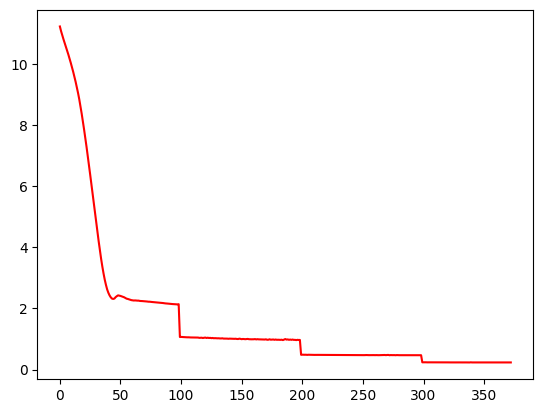

 75%|███████▍  | 373/500 [00:42<00:13,  9.36it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.809352517985616
Dataset Name:  books , AUC Score (contextual):  45.85368335368336
Dataset Name:  books , AUC Score (structural):  40.948495125052986
Dataset Name:  books , AUC Score (joint-type):  49.34371184371184
Dataset Name:  books , AUC Score (structure type):  42.2246288524886
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  49.34371184371184
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


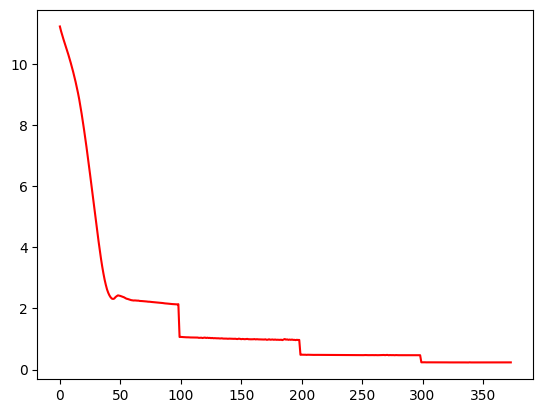

 75%|███████▍  | 374/500 [00:42<00:13,  9.39it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.430626927029806
Dataset Name:  books , AUC Score (contextual):  44.67592592592593
Dataset Name:  books , AUC Score (structural):  40.8467571004663
Dataset Name:  books , AUC Score (joint-type):  45.034595034595036
Dataset Name:  books , AUC Score (structure type):  41.301385316547076
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.034595034595036
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


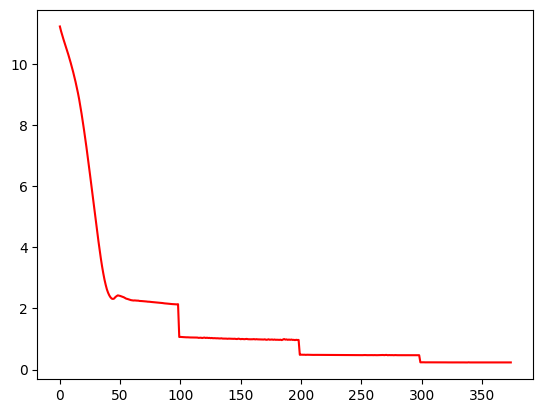

 75%|███████▌  | 375/500 [00:42<00:13,  9.43it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.37718396711204
Dataset Name:  books , AUC Score (contextual):  43.996743996743994
Dataset Name:  books , AUC Score (structural):  40.43238660449342
Dataset Name:  books , AUC Score (joint-type):  44.25620675620675
Dataset Name:  books , AUC Score (structure type):  40.84021479175127
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.25620675620675
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


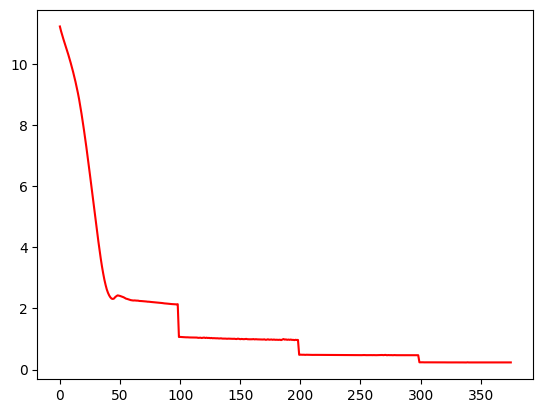

 75%|███████▌  | 376/500 [00:42<00:13,  9.42it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.040596094552924
Dataset Name:  books , AUC Score (contextual):  45.82315832315832
Dataset Name:  books , AUC Score (structural):  40.101738024586695
Dataset Name:  books , AUC Score (joint-type):  45.589133089133085
Dataset Name:  books , AUC Score (structure type):  40.802310365055725
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.589133089133085
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


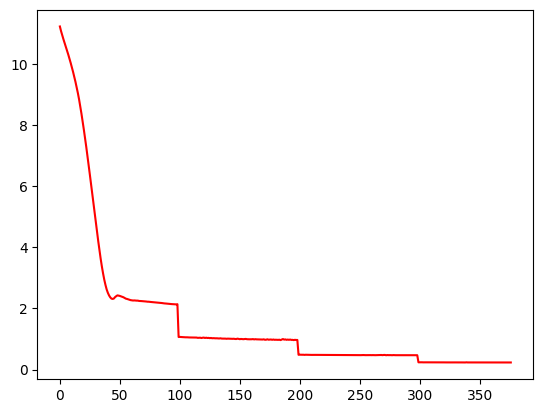

 75%|███████▌  | 377/500 [00:42<00:12,  9.47it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.24357656731758
Dataset Name:  books , AUC Score (contextual):  45.47212047212047
Dataset Name:  books , AUC Score (structural):  41.38830012717253
Dataset Name:  books , AUC Score (joint-type):  46.23015873015873
Dataset Name:  books , AUC Score (structure type):  42.16596723974549
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.23015873015873
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


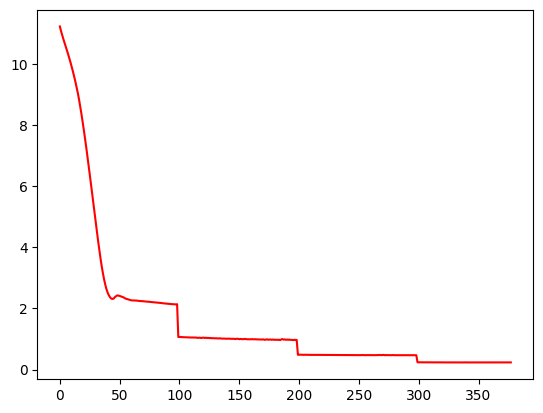

 76%|███████▌  | 378/500 [00:43<00:13,  9.36it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.434480986639265
Dataset Name:  books , AUC Score (contextual):  44.33760683760684
Dataset Name:  books , AUC Score (structural):  39.980924120389986
Dataset Name:  books , AUC Score (joint-type):  47.3036223036223
Dataset Name:  books , AUC Score (structure type):  41.03154189792879
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.3036223036223
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


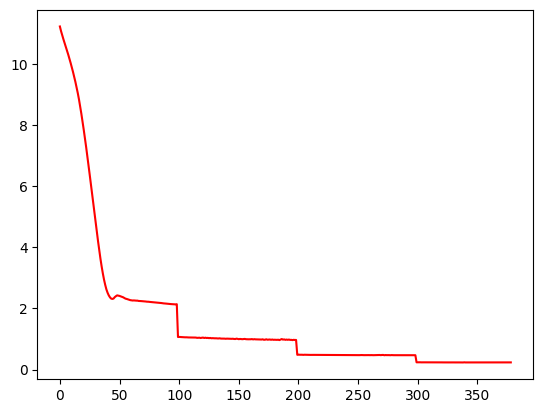

 76%|███████▌  | 379/500 [00:43<00:13,  9.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.597636176772866
Dataset Name:  books , AUC Score (contextual):  43.85938135938135
Dataset Name:  books , AUC Score (structural):  40.17380245866893
Dataset Name:  books , AUC Score (joint-type):  45.26862026862026
Dataset Name:  books , AUC Score (structure type):  40.76079599296061
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.26862026862026
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


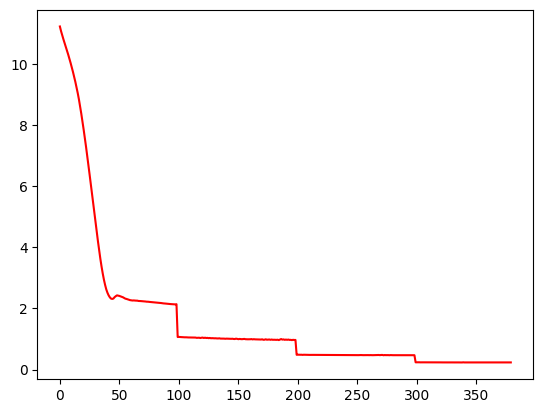

 76%|███████▌  | 380/500 [00:43<00:13,  8.95it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.02980472764645
Dataset Name:  books , AUC Score (contextual):  46.3980463980464
Dataset Name:  books , AUC Score (structural):  42.76282323018228
Dataset Name:  books , AUC Score (joint-type):  45.83842083842084
Dataset Name:  books , AUC Score (structure type):  43.162312170028436
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.83842083842084
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


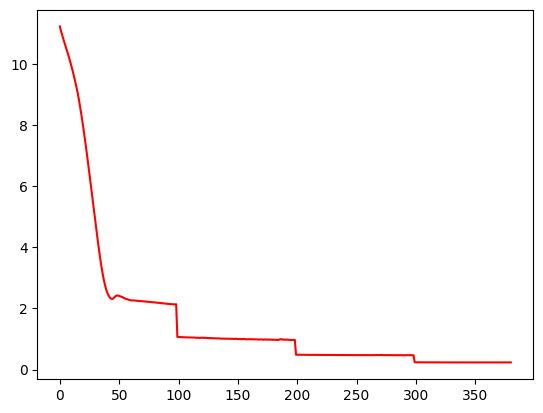

 76%|███████▌  | 381/500 [00:43<00:13,  9.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.79599177800617
Dataset Name:  books , AUC Score (contextual):  45.12108262108262
Dataset Name:  books , AUC Score (structural):  40.662356930902924
Dataset Name:  books , AUC Score (joint-type):  46.59137159137159
Dataset Name:  books , AUC Score (structure type):  41.42953837823203
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.59137159137159
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


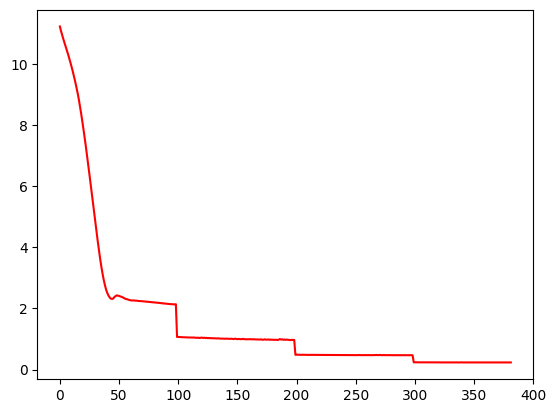

 76%|███████▋  | 382/500 [00:43<00:13,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.79033915724563
Dataset Name:  books , AUC Score (contextual):  44.09340659340659
Dataset Name:  books , AUC Score (structural):  39.69054684188216
Dataset Name:  books , AUC Score (joint-type):  45.63492063492063
Dataset Name:  books , AUC Score (structure type):  40.48824511529263
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.63492063492063
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


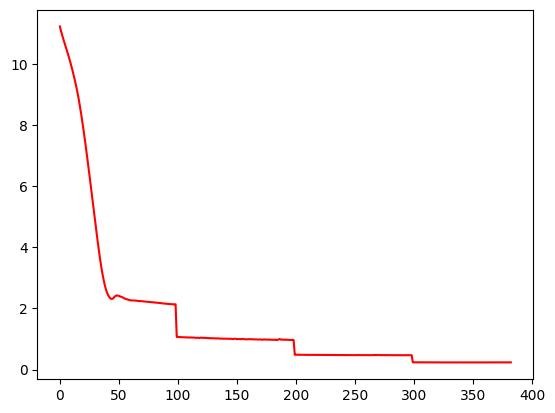

 77%|███████▋  | 383/500 [00:43<00:12,  9.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.46248715313464
Dataset Name:  books , AUC Score (contextual):  44.798026048026045
Dataset Name:  books , AUC Score (structural):  40.435565917761764
Dataset Name:  books , AUC Score (joint-type):  47.822547822547826
Dataset Name:  books , AUC Score (structure type):  41.5387392265692
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.822547822547826
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


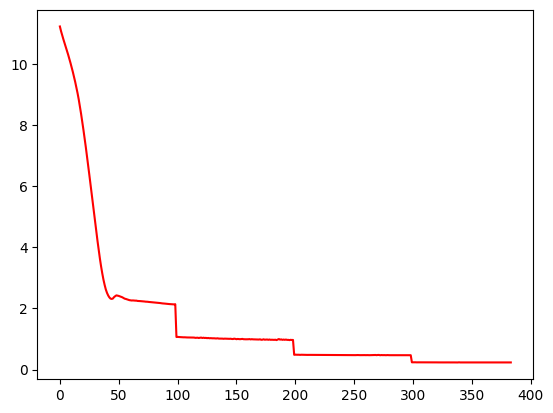

 77%|███████▋  | 384/500 [00:43<00:12,  8.99it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.64234326824256
Dataset Name:  books , AUC Score (contextual):  45.98087098087098
Dataset Name:  books , AUC Score (structural):  40.46417973717677
Dataset Name:  books , AUC Score (joint-type):  50.1933251933252
Dataset Name:  books , AUC Score (structure type):  41.986372456116605
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  50.1933251933252
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


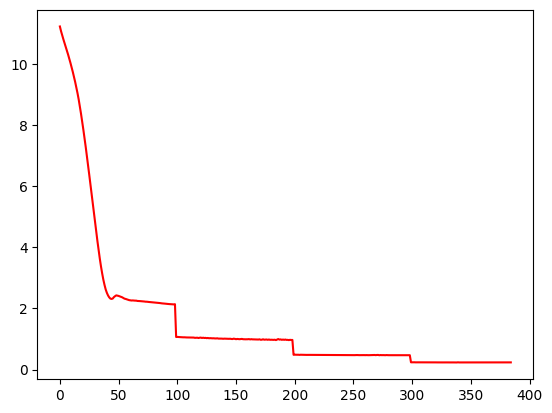

 77%|███████▋  | 385/500 [00:43<00:12,  9.02it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.06166495375128
Dataset Name:  books , AUC Score (contextual):  42.82153032153032
Dataset Name:  books , AUC Score (structural):  40.315811784654514
Dataset Name:  books , AUC Score (joint-type):  48.24989824989825
Dataset Name:  books , AUC Score (structure type):  41.36455936103967
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.24989824989825
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


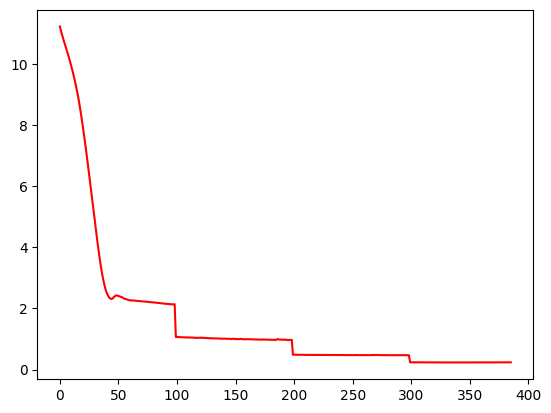

 77%|███████▋  | 386/500 [00:43<00:12,  9.05it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.603802672147985
Dataset Name:  books , AUC Score (contextual):  47.20695970695971
Dataset Name:  books , AUC Score (structural):  40.137770241627805
Dataset Name:  books , AUC Score (joint-type):  45.314407814407815
Dataset Name:  books , AUC Score (structure type):  40.733721402463786
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.314407814407815
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


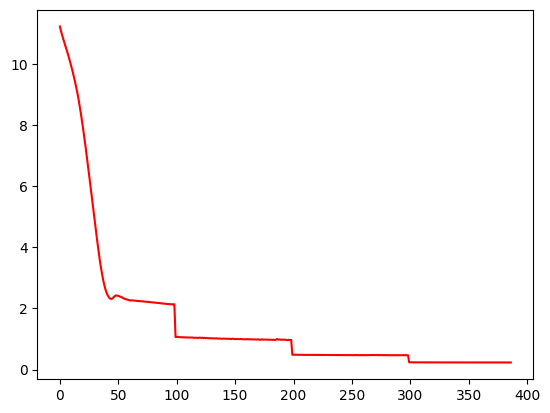

 77%|███████▋  | 387/500 [00:44<00:12,  9.11it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.32836587872559
Dataset Name:  books , AUC Score (contextual):  44.25620675620676
Dataset Name:  books , AUC Score (structural):  41.905468418821535
Dataset Name:  books , AUC Score (joint-type):  47.502035002035
Dataset Name:  books , AUC Score (structure type):  42.61901538739227
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.502035002035
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


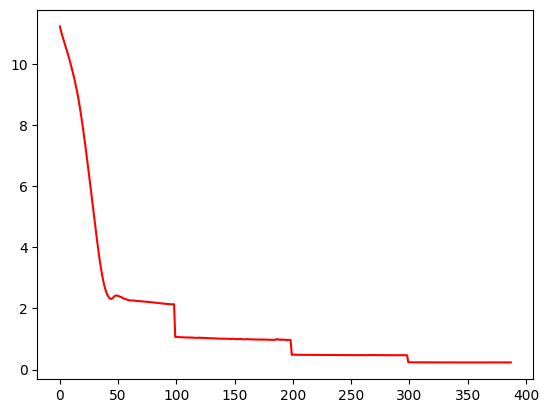

 78%|███████▊  | 388/500 [00:44<00:12,  9.13it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.74922918807812
Dataset Name:  books , AUC Score (contextual):  44.69881969881969
Dataset Name:  books , AUC Score (structural):  40.5574395930479
Dataset Name:  books , AUC Score (joint-type):  45.65527065527066
Dataset Name:  books , AUC Score (structure type):  41.15428004151437
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.65527065527066
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


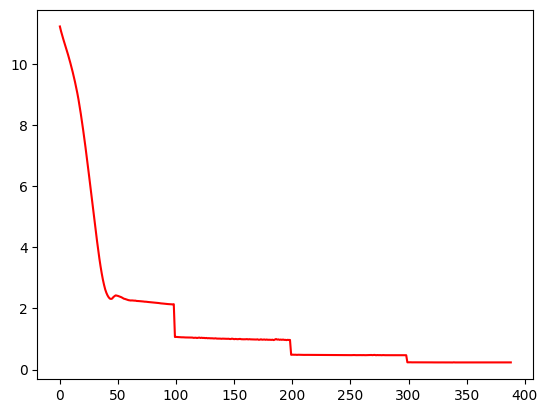

 78%|███████▊  | 389/500 [00:44<00:12,  9.17it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.37667009249742
Dataset Name:  books , AUC Score (contextual):  42.475579975579976
Dataset Name:  books , AUC Score (structural):  39.50614667231878
Dataset Name:  books , AUC Score (joint-type):  45.91982091982092
Dataset Name:  books , AUC Score (structure type):  40.337529894860346
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.91982091982092
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


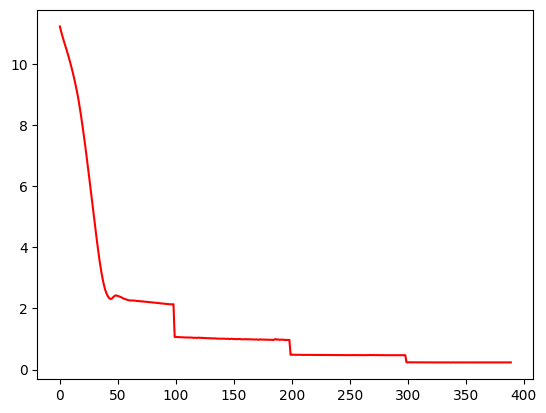

 78%|███████▊  | 390/500 [00:44<00:12,  9.10it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.48561151079137
Dataset Name:  books , AUC Score (contextual):  40.867928367928364
Dataset Name:  books , AUC Score (structural):  39.82195845697329
Dataset Name:  books , AUC Score (joint-type):  48.00569800569801
Dataset Name:  books , AUC Score (structure type):  41.0017598483823
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.00569800569801
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


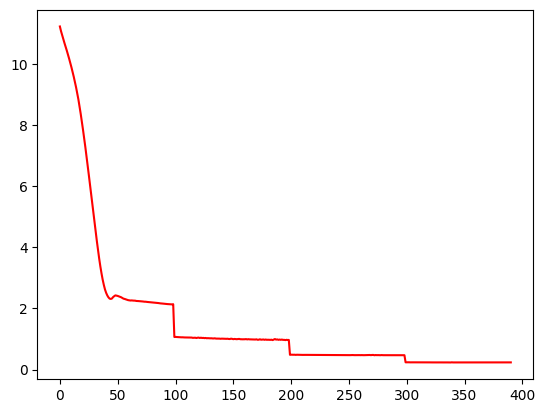

 78%|███████▊  | 391/500 [00:44<00:11,  9.14it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.15005138746146
Dataset Name:  books , AUC Score (contextual):  42.90801790801791
Dataset Name:  books , AUC Score (structural):  41.41267486222976
Dataset Name:  books , AUC Score (joint-type):  44.73951973951974
Dataset Name:  books , AUC Score (structure type):  41.7778981092911
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.73951973951974
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


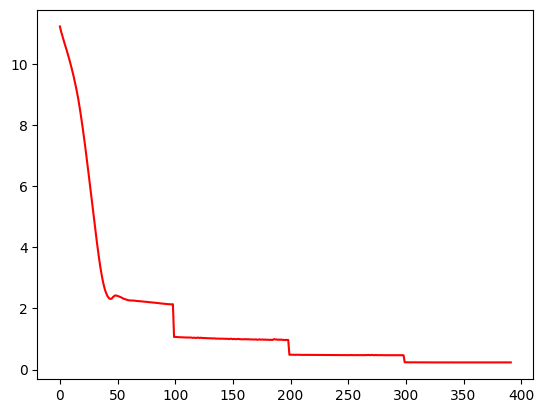

 78%|███████▊  | 392/500 [00:44<00:11,  9.17it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.3535457348407
Dataset Name:  books , AUC Score (contextual):  42.475579975579976
Dataset Name:  books , AUC Score (structural):  40.64963967782958
Dataset Name:  books , AUC Score (joint-type):  46.448921448921446
Dataset Name:  books , AUC Score (structure type):  41.45932042777853
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.448921448921446
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


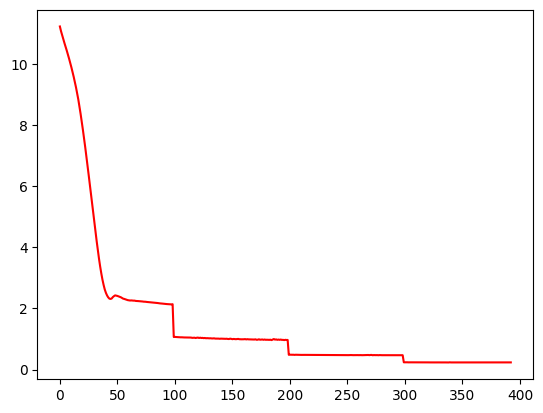

 79%|███████▊  | 393/500 [00:44<00:11,  9.18it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.660328879753344
Dataset Name:  books , AUC Score (contextual):  45.268620268620275
Dataset Name:  books , AUC Score (structural):  39.935353963543875
Dataset Name:  books , AUC Score (joint-type):  45.96052096052096
Dataset Name:  books , AUC Score (structure type):  40.78606561075764
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.96052096052096
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


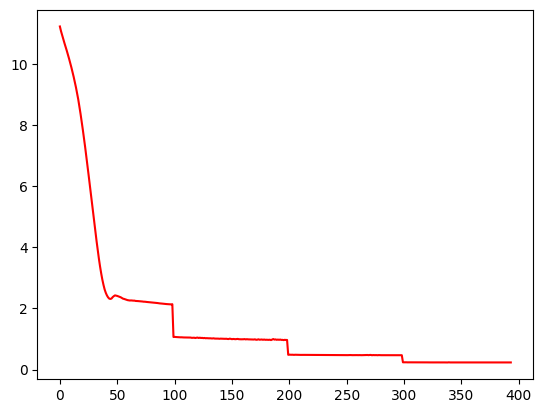

 79%|███████▉  | 394/500 [00:44<00:12,  8.63it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.2929085303186
Dataset Name:  books , AUC Score (contextual):  47.074684574684575
Dataset Name:  books , AUC Score (structural):  41.76769817719372
Dataset Name:  books , AUC Score (joint-type):  46.83048433048433
Dataset Name:  books , AUC Score (structure type):  42.4944722711069
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.83048433048433
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


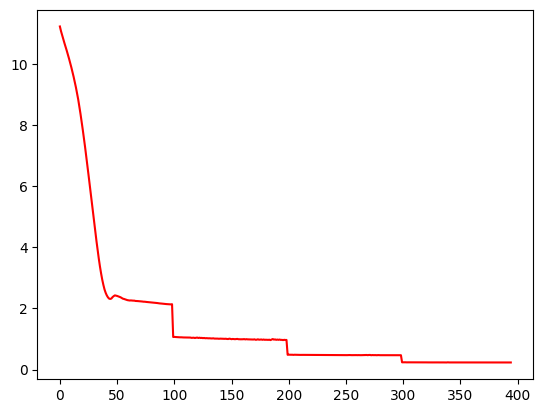

 79%|███████▉  | 395/500 [00:44<00:12,  8.59it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.19475847893114
Dataset Name:  books , AUC Score (contextual):  45.919820919820914
Dataset Name:  books , AUC Score (structural):  41.07990674014413
Dataset Name:  books , AUC Score (joint-type):  46.53540903540904
Dataset Name:  books , AUC Score (structure type):  41.801362754388336
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.53540903540904
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


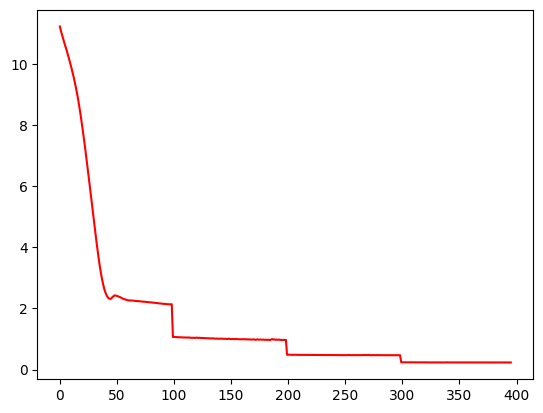

 79%|███████▉  | 396/500 [00:45<00:22,  4.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.8273381294964
Dataset Name:  books , AUC Score (contextual):  43.503256003256006
Dataset Name:  books , AUC Score (structural):  40.115515048749465
Dataset Name:  books , AUC Score (joint-type):  47.32905982905983
Dataset Name:  books , AUC Score (structure type):  41.2093317088579
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.32905982905983
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


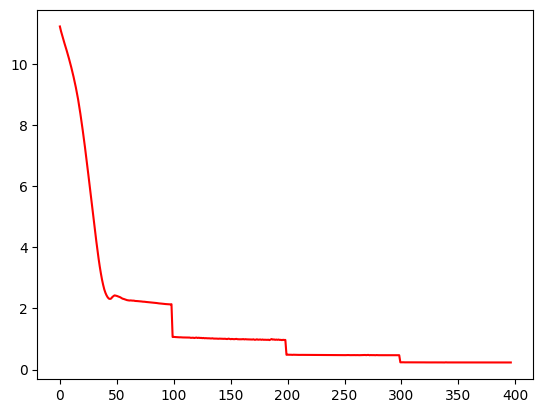

 79%|███████▉  | 397/500 [00:45<00:19,  5.35it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.49743062692704
Dataset Name:  books , AUC Score (contextual):  43.11151811151811
Dataset Name:  books , AUC Score (structural):  41.34696905468419
Dataset Name:  books , AUC Score (joint-type):  48.193935693935686
Dataset Name:  books , AUC Score (structure type):  42.28148549253192
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.193935693935686
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


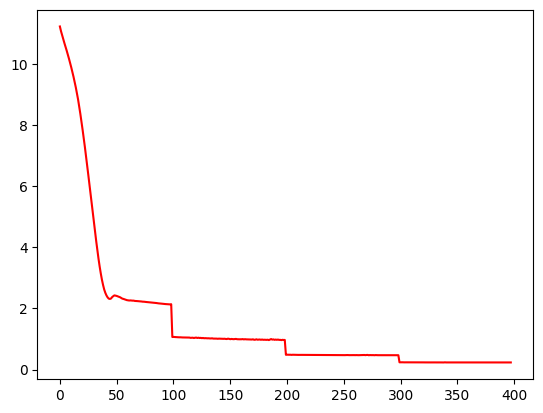

 80%|███████▉  | 398/500 [00:45<00:17,  5.89it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.492805755395686
Dataset Name:  books , AUC Score (contextual):  43.5897435897436
Dataset Name:  books , AUC Score (structural):  40.523526918185674
Dataset Name:  books , AUC Score (joint-type):  46.7032967032967
Dataset Name:  books , AUC Score (structure type):  41.29597039844772
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.7032967032967
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


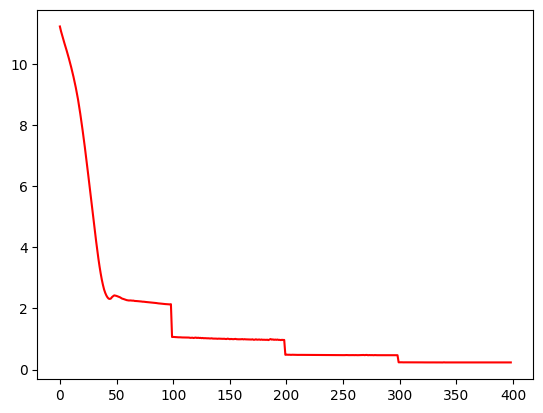

 80%|███████▉  | 399/500 [00:45<00:15,  6.47it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.3535457348407
Dataset Name:  books , AUC Score (contextual):  42.28225478225478
Dataset Name:  books , AUC Score (structural):  41.73802458668928
Dataset Name:  books , AUC Score (joint-type):  46.11823361823362
Dataset Name:  books , AUC Score (structure type):  42.272460629032985
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.11823361823362
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


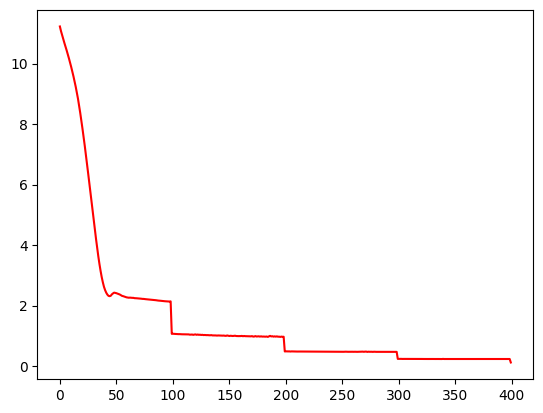

 80%|████████  | 400/500 [00:45<00:14,  7.00it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.10174717368962
Dataset Name:  books , AUC Score (contextual):  44.74460724460724
Dataset Name:  books , AUC Score (structural):  40.05192878338279
Dataset Name:  books , AUC Score (joint-type):  45.97069597069597
Dataset Name:  books , AUC Score (structure type):  40.83118992825233
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.97069597069597
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


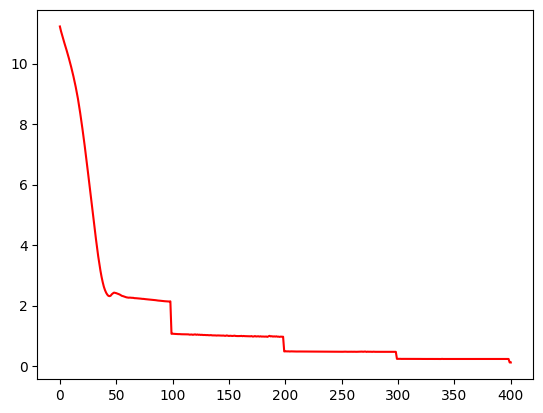

 80%|████████  | 401/500 [00:45<00:13,  7.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.94295991778006
Dataset Name:  books , AUC Score (contextual):  43.930606430606424
Dataset Name:  books , AUC Score (structural):  39.50932598558711
Dataset Name:  books , AUC Score (joint-type):  47.13064713064713
Dataset Name:  books , AUC Score (structure type):  40.60917828617843
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.13064713064713
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


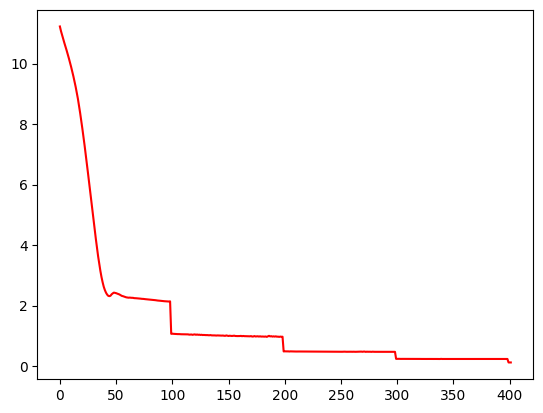

 80%|████████  | 402/500 [00:46<00:12,  7.86it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.894141829393625
Dataset Name:  books , AUC Score (contextual):  44.94810744810744
Dataset Name:  books , AUC Score (structural):  40.03815175922001
Dataset Name:  books , AUC Score (joint-type):  47.929385429385434
Dataset Name:  books , AUC Score (structure type):  41.09652091512116
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.929385429385434
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


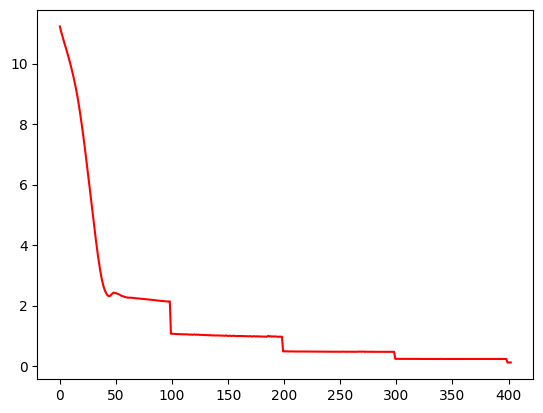

 81%|████████  | 403/500 [00:46<00:11,  8.14it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.64953751284686
Dataset Name:  books , AUC Score (contextual):  44.576719576719576
Dataset Name:  books , AUC Score (structural):  40.28507842306062
Dataset Name:  books , AUC Score (joint-type):  48.036223036223035
Dataset Name:  books , AUC Score (structure type):  41.27792067144984
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.036223036223035
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


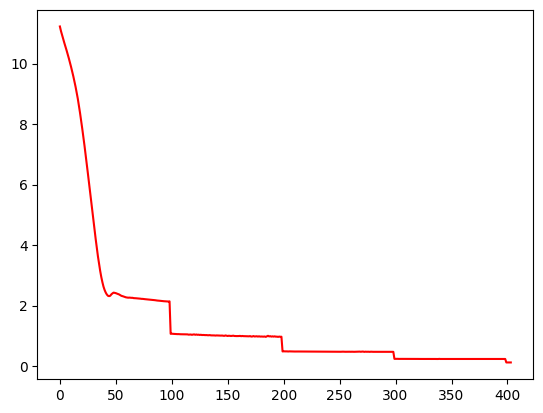

 81%|████████  | 404/500 [00:46<00:11,  8.42it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.465056526207604
Dataset Name:  books , AUC Score (contextual):  46.906796906796906
Dataset Name:  books , AUC Score (structural):  39.92157693938109
Dataset Name:  books , AUC Score (joint-type):  46.86100936100936
Dataset Name:  books , AUC Score (structure type):  40.81584766030414
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.86100936100936
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


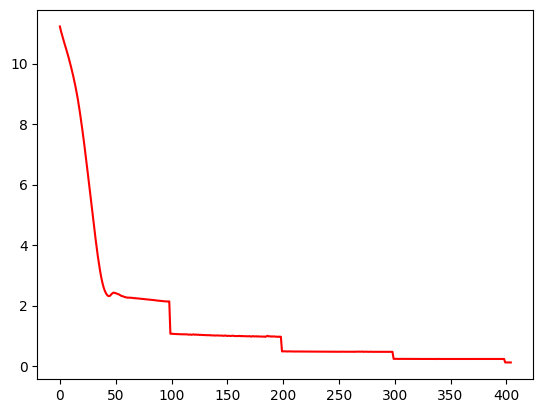

 81%|████████  | 405/500 [00:46<00:11,  8.53it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.05858170606372
Dataset Name:  books , AUC Score (contextual):  42.791005291005284
Dataset Name:  books , AUC Score (structural):  40.467359050445104
Dataset Name:  books , AUC Score (joint-type):  46.565934065934066
Dataset Name:  books , AUC Score (structure type):  41.271603267000586
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.565934065934066
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


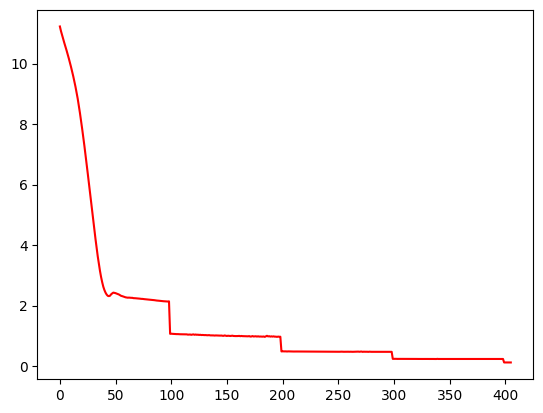

 81%|████████  | 406/500 [00:46<00:10,  8.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.10483042137719
Dataset Name:  books , AUC Score (contextual):  42.06857956857957
Dataset Name:  books , AUC Score (structural):  39.83043662568886
Dataset Name:  books , AUC Score (joint-type):  45.97578347578347
Dataset Name:  books , AUC Score (structure type):  40.60647082712874
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.97578347578347
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


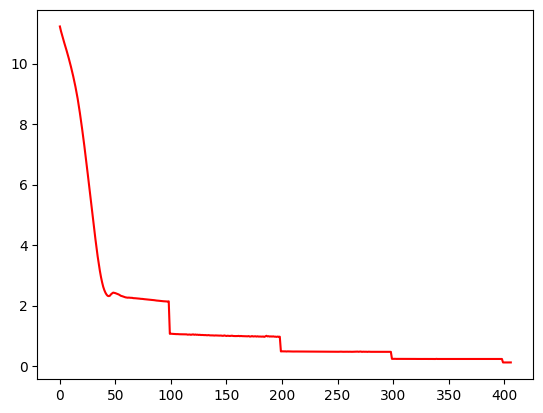

 81%|████████▏ | 407/500 [00:46<00:10,  8.65it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.87872559095581
Dataset Name:  books , AUC Score (contextual):  44.09340659340659
Dataset Name:  books , AUC Score (structural):  40.22573124205172
Dataset Name:  books , AUC Score (joint-type):  44.87688237688238
Dataset Name:  books , AUC Score (structure type):  40.85465457334958
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.87688237688238
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


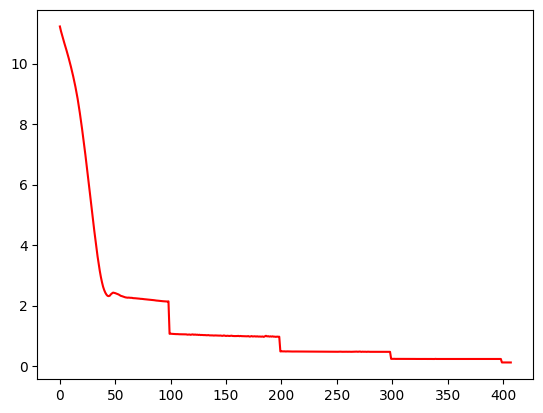

 82%|████████▏ | 408/500 [00:46<00:10,  8.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.13977389516959
Dataset Name:  books , AUC Score (contextual):  40.552503052503056
Dataset Name:  books , AUC Score (structural):  41.10640101738024
Dataset Name:  books , AUC Score (joint-type):  46.31155881155881
Dataset Name:  books , AUC Score (structure type):  41.642525156807
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.31155881155881
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


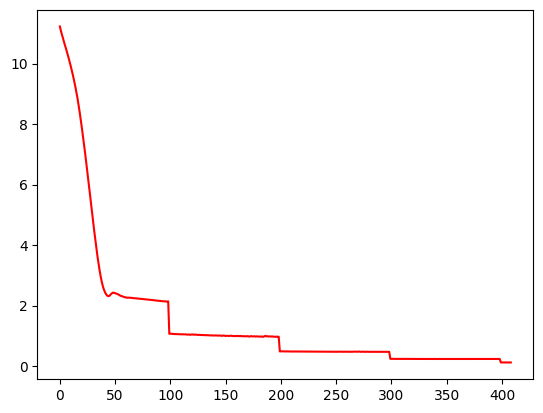

 82%|████████▏ | 409/500 [00:46<00:10,  8.75it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.551387461459406
Dataset Name:  books , AUC Score (contextual):  44.65303215303215
Dataset Name:  books , AUC Score (structural):  40.78423060618906
Dataset Name:  books , AUC Score (joint-type):  46.677859177859176
Dataset Name:  books , AUC Score (structure type):  41.58747348946347
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.677859177859176
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


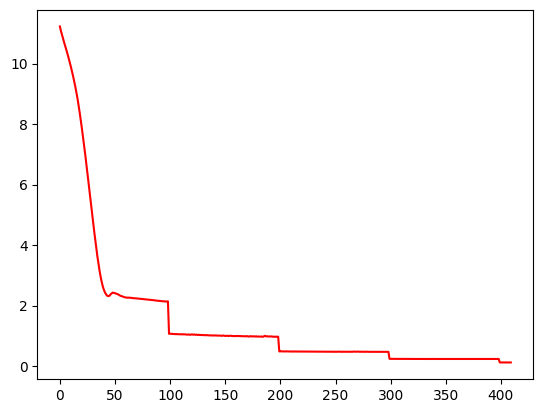

 82%|████████▏ | 410/500 [00:46<00:10,  8.84it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.79290853031859
Dataset Name:  books , AUC Score (contextual):  41.57000407000407
Dataset Name:  books , AUC Score (structural):  40.433446375582875
Dataset Name:  books , AUC Score (joint-type):  45.497557997558
Dataset Name:  books , AUC Score (structure type):  41.00897973918144
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.497557997558
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


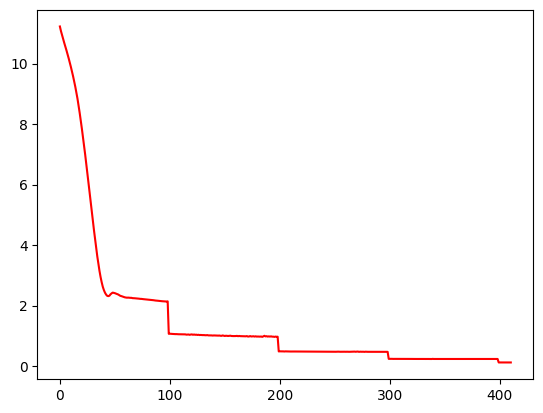

 82%|████████▏ | 411/500 [00:47<00:09,  9.15it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.716341212744084
Dataset Name:  books , AUC Score (contextual):  44.296906796906796
Dataset Name:  books , AUC Score (structural):  39.64603645612548
Dataset Name:  books , AUC Score (joint-type):  46.41330891330892
Dataset Name:  books , AUC Score (structure type):  40.53427191913722
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.41330891330892
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


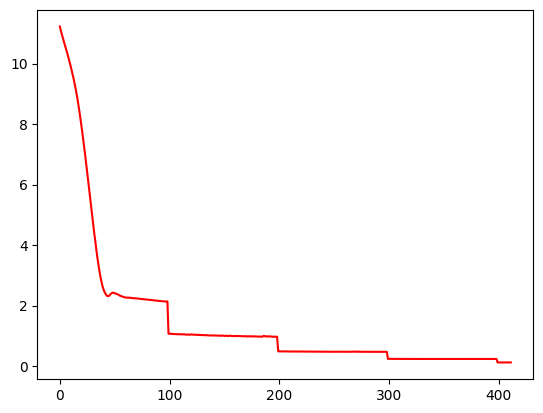

Dataset Name:  books , AUC Score(benchmark/combined):  61.09712230215827
Dataset Name:  books , AUC Score (contextual):  45.324582824582826
Dataset Name:  books , AUC Score (structural):  40.20453582026282
Dataset Name:  books , AUC Score (joint-type):  46.70838420838421
Dataset Name:  books , AUC Score (structure type):  41.030639411578896
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.70838420838421
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


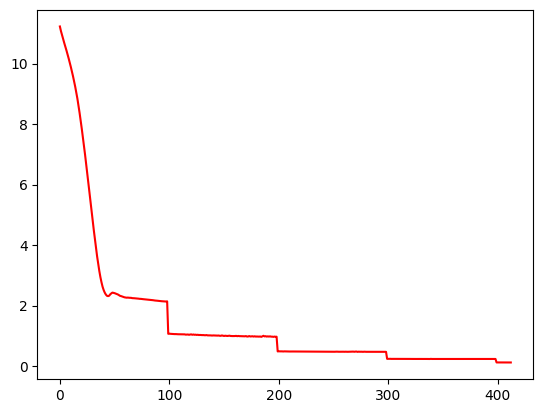

 83%|████████▎ | 413/500 [00:47<00:09,  9.51it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.98715313463514
Dataset Name:  books , AUC Score (contextual):  44.70390720390721
Dataset Name:  books , AUC Score (structural):  40.67507418397626
Dataset Name:  books , AUC Score (joint-type):  47.85816035816036
Dataset Name:  books , AUC Score (structure type):  41.696674337800644
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.85816035816036
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


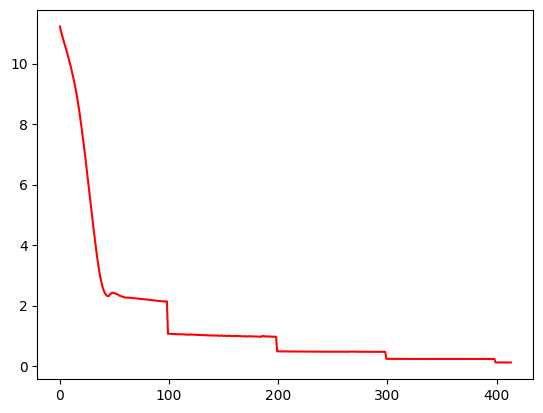

Dataset Name:  books , AUC Score(benchmark/combined):  61.70092497430626
Dataset Name:  books , AUC Score (contextual):  45.71123321123321
Dataset Name:  books , AUC Score (structural):  40.9463755828741
Dataset Name:  books , AUC Score (joint-type):  49.4047619047619
Dataset Name:  books , AUC Score (structure type):  42.11813546320112
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  49.4047619047619
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


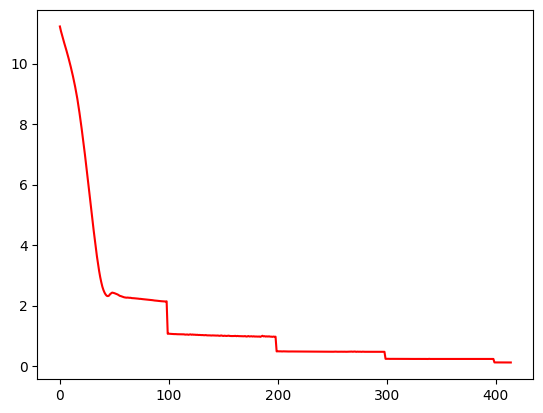

 83%|████████▎ | 415/500 [00:47<00:08,  9.64it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.20452209660843
Dataset Name:  books , AUC Score (contextual):  44.90231990231991
Dataset Name:  books , AUC Score (structural):  40.60194997880458
Dataset Name:  books , AUC Score (joint-type):  46.677859177859176
Dataset Name:  books , AUC Score (structure type):  41.58476603041379
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.677859177859176
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


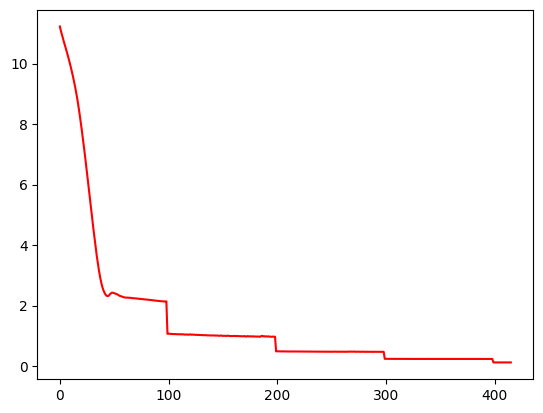

 83%|████████▎ | 416/500 [00:47<00:08,  9.70it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.767728674203504
Dataset Name:  books , AUC Score (contextual):  45.68579568579569
Dataset Name:  books , AUC Score (structural):  39.09919457397202
Dataset Name:  books , AUC Score (joint-type):  48.11253561253561
Dataset Name:  books , AUC Score (structure type):  40.41514372095122
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.11253561253561
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


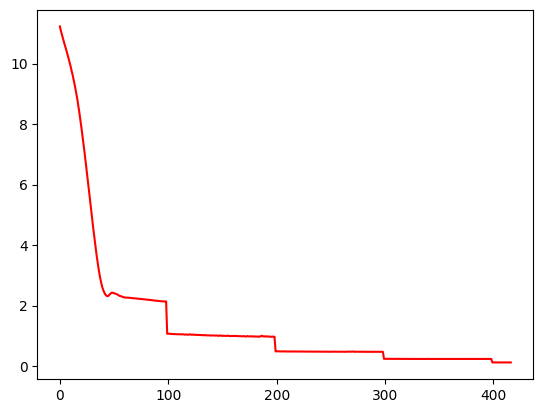

Dataset Name:  books , AUC Score(benchmark/combined):  61.369475847893106
Dataset Name:  books , AUC Score (contextual):  43.101343101343105
Dataset Name:  books , AUC Score (structural):  39.85587113183552
Dataset Name:  books , AUC Score (joint-type):  44.83618233618234
Dataset Name:  books , AUC Score (structure type):  40.54329678263617
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.83618233618234
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


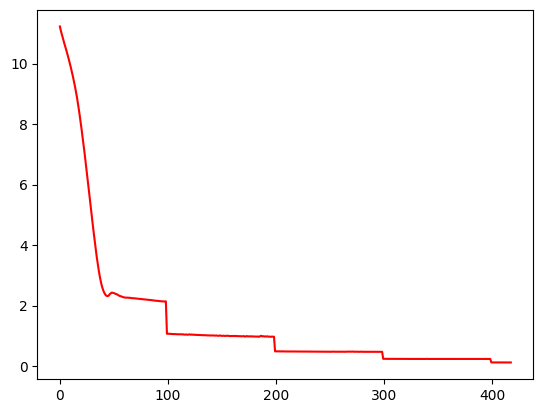

 84%|████████▎ | 418/500 [00:47<00:08,  9.85it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.551387461459406
Dataset Name:  books , AUC Score (contextual):  43.63044363044363
Dataset Name:  books , AUC Score (structural):  40.75455701568461
Dataset Name:  books , AUC Score (joint-type):  45.04477004477005
Dataset Name:  books , AUC Score (structure type):  41.34199720229231
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.04477004477005
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


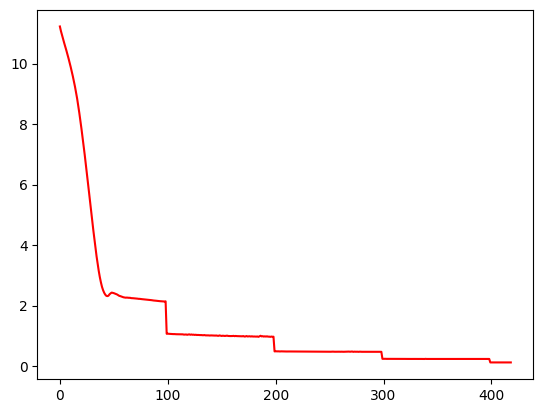

 84%|████████▍ | 419/500 [00:47<00:08,  9.86it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.21017471736897
Dataset Name:  books , AUC Score (contextual):  44.805657305657306
Dataset Name:  books , AUC Score (structural):  40.813904196693514
Dataset Name:  books , AUC Score (joint-type):  47.588522588522586
Dataset Name:  books , AUC Score (structure type):  41.78060556834078
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.588522588522586
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


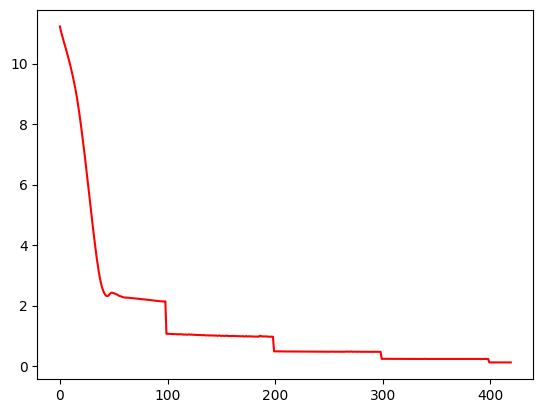

 84%|████████▍ | 420/500 [00:48<00:08,  9.87it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.78314491264132
Dataset Name:  books , AUC Score (contextual):  42.48066748066748
Dataset Name:  books , AUC Score (structural):  40.877490462060194
Dataset Name:  books , AUC Score (joint-type):  46.52523402523403
Dataset Name:  books , AUC Score (structure type):  41.54325165831867
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.52523402523403
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


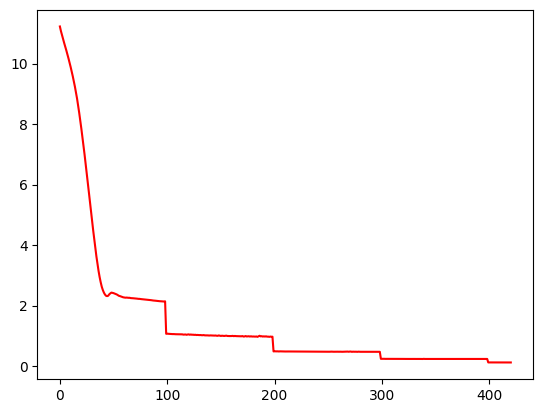

 84%|████████▍ | 421/500 [00:48<00:07,  9.88it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.86279547790339
Dataset Name:  books , AUC Score (contextual):  42.95889295889296
Dataset Name:  books , AUC Score (structural):  39.666172106824924
Dataset Name:  books , AUC Score (joint-type):  48.11762311762312
Dataset Name:  books , AUC Score (structure type):  40.805017824105406
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.11762311762312
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


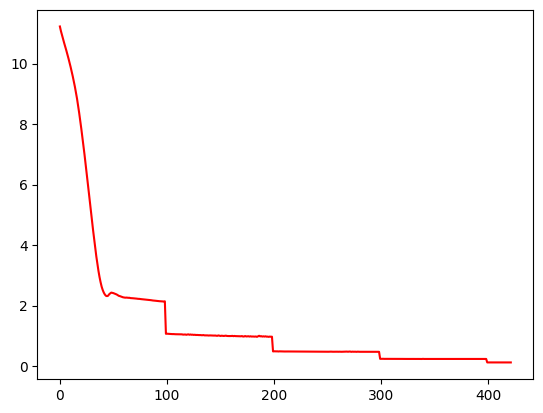

 84%|████████▍ | 422/500 [00:48<00:08,  9.66it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.42343268242549
Dataset Name:  books , AUC Score (contextual):  43.930606430606424
Dataset Name:  books , AUC Score (structural):  39.83043662568885
Dataset Name:  books , AUC Score (joint-type):  46.91188441188441
Dataset Name:  books , AUC Score (structure type):  40.7472586977122
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.91188441188441
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


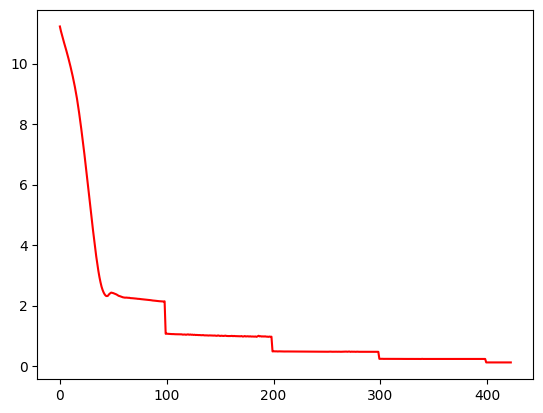

 85%|████████▍ | 423/500 [00:48<00:08,  9.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.976875642343266
Dataset Name:  books , AUC Score (contextual):  43.69658119658119
Dataset Name:  books , AUC Score (structural):  39.95866892751165
Dataset Name:  books , AUC Score (joint-type):  51.75518925518925
Dataset Name:  books , AUC Score (structure type):  41.724651414647354
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  51.75518925518925
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


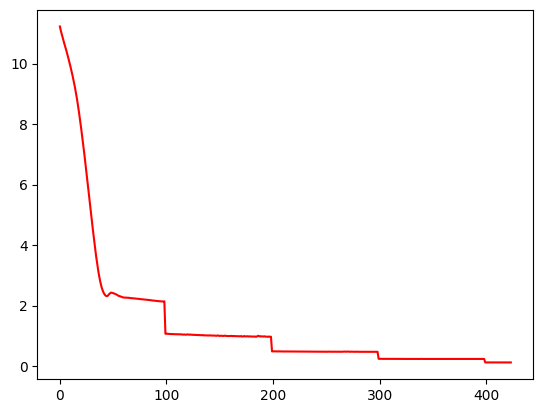

 85%|████████▍ | 424/500 [00:48<00:07,  9.61it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.127954779033914
Dataset Name:  books , AUC Score (contextual):  43.01485551485551
Dataset Name:  books , AUC Score (structural):  39.310089020771514
Dataset Name:  books , AUC Score (joint-type):  46.82030932030932
Dataset Name:  books , AUC Score (structure type):  40.30233292721447
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.82030932030932
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


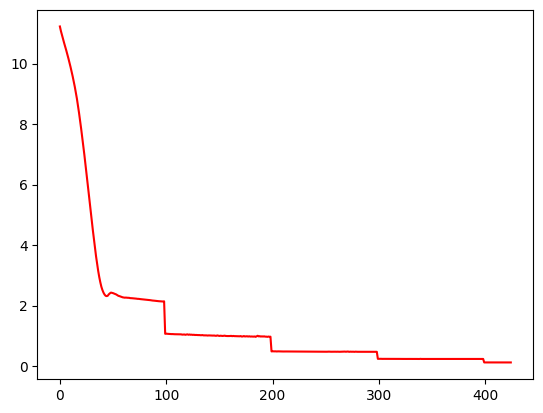

Dataset Name:  books , AUC Score(benchmark/combined):  60.4573484069887
Dataset Name:  books , AUC Score (contextual):  43.00468050468051
Dataset Name:  books , AUC Score (structural):  40.78423060618906
Dataset Name:  books , AUC Score (joint-type):  44.61233211233211
Dataset Name:  books , AUC Score (structure type):  41.1795496593114
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.61233211233211
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


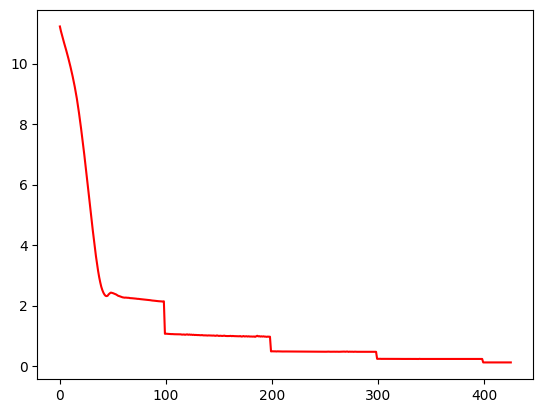

 85%|████████▌ | 426/500 [00:48<00:07,  9.81it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.05395683453237
Dataset Name:  books , AUC Score (contextual):  42.745217745217744
Dataset Name:  books , AUC Score (structural):  39.81348028825773
Dataset Name:  books , AUC Score (joint-type):  44.01709401709402
Dataset Name:  books , AUC Score (structure type):  40.198546996976674
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.01709401709402
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


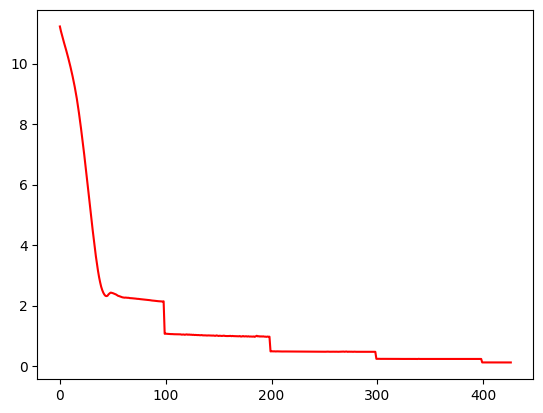

 85%|████████▌ | 427/500 [00:48<00:07,  9.60it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.78622816032887
Dataset Name:  books , AUC Score (contextual):  44.846357346357344
Dataset Name:  books , AUC Score (structural):  40.57121661721068
Dataset Name:  books , AUC Score (joint-type):  47.746235246235244
Dataset Name:  books , AUC Score (structure type):  41.58747348946347
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.746235246235244
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


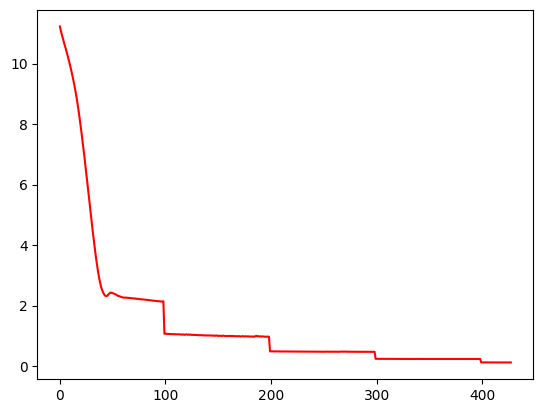

 86%|████████▌ | 428/500 [00:48<00:07,  9.51it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.881294964028775
Dataset Name:  books , AUC Score (contextual):  44.48005698005698
Dataset Name:  books , AUC Score (structural):  40.99406528189912
Dataset Name:  books , AUC Score (joint-type):  47.16117216117216
Dataset Name:  books , AUC Score (structure type):  41.69035693335138
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.16117216117216
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


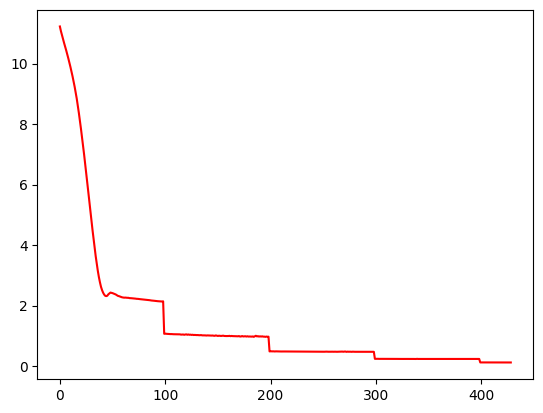

 86%|████████▌ | 429/500 [00:48<00:07,  9.55it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.183967112024675
Dataset Name:  books , AUC Score (contextual):  42.78083028083029
Dataset Name:  books , AUC Score (structural):  40.51398897838067
Dataset Name:  books , AUC Score (joint-type):  46.560846560846564
Dataset Name:  books , AUC Score (structure type):  41.285140562249
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.560846560846564
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


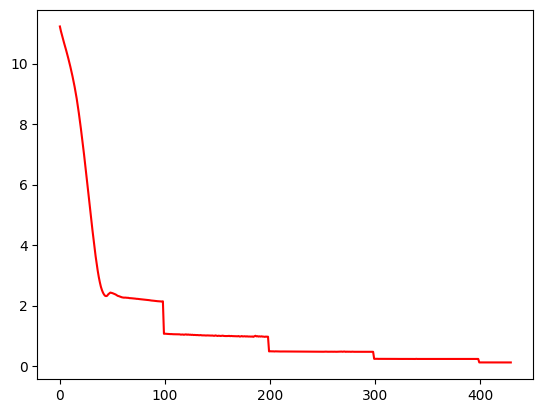

 86%|████████▌ | 430/500 [00:49<00:07,  9.53it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.07348406988695
Dataset Name:  books , AUC Score (contextual):  42.8545991045991
Dataset Name:  books , AUC Score (structural):  40.96651123357354
Dataset Name:  books , AUC Score (joint-type):  47.110297110297104
Dataset Name:  books , AUC Score (structure type):  41.73999368259555
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.110297110297104
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


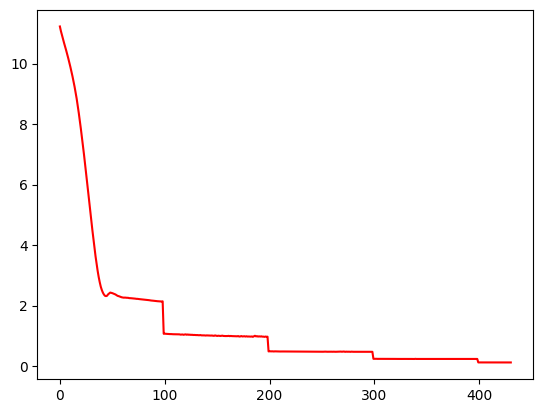

 86%|████████▌ | 431/500 [00:49<00:07,  9.55it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.484583761562185
Dataset Name:  books , AUC Score (contextual):  39.565527065527064
Dataset Name:  books , AUC Score (structural):  40.952734209410764
Dataset Name:  books , AUC Score (joint-type):  47.3951973951974
Dataset Name:  books , AUC Score (structure type):  41.76616578674247
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.3951973951974
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


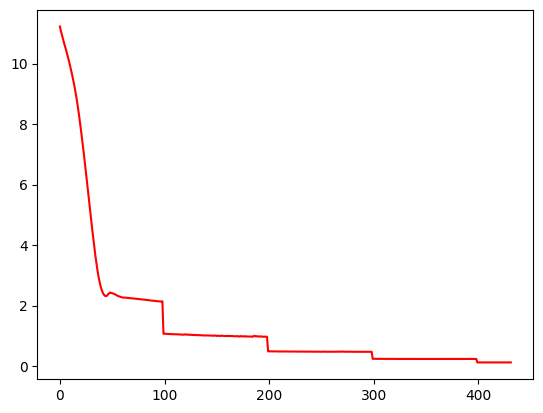

 86%|████████▋ | 432/500 [00:49<00:07,  9.42it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.073484069886945
Dataset Name:  books , AUC Score (contextual):  40.883190883190885
Dataset Name:  books , AUC Score (structural):  41.167867740568035
Dataset Name:  books , AUC Score (joint-type):  47.43080993080993
Dataset Name:  books , AUC Score (structure type):  41.93583322052253
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.43080993080993
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


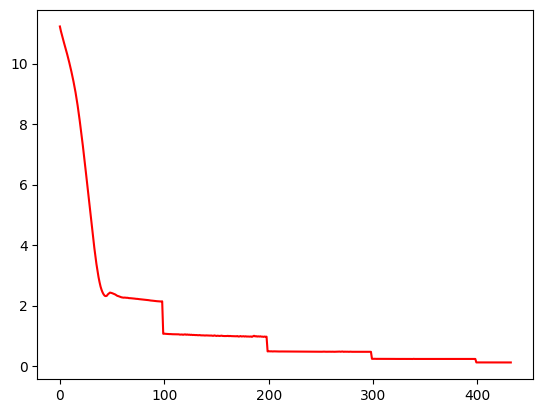

 87%|████████▋ | 433/500 [00:49<00:07,  9.16it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.64131551901336
Dataset Name:  books , AUC Score (contextual):  41.330891330891326
Dataset Name:  books , AUC Score (structural):  40.996184824078
Dataset Name:  books , AUC Score (joint-type):  50.137362637362635
Dataset Name:  books , AUC Score (structure type):  42.285997924281396
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  50.137362637362635
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


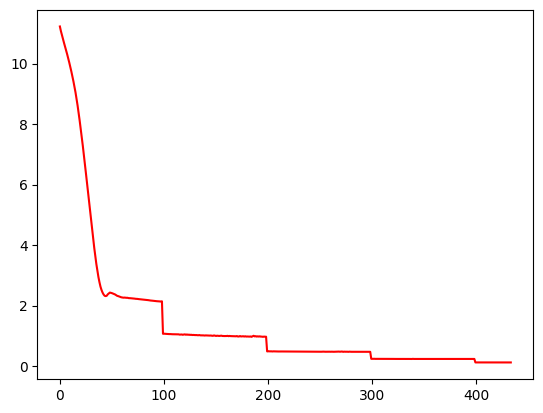

 87%|████████▋ | 434/500 [00:49<00:07,  9.27it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.5
Dataset Name:  books , AUC Score (contextual):  42.083842083842086
Dataset Name:  books , AUC Score (structural):  38.6646884272997
Dataset Name:  books , AUC Score (joint-type):  46.88644688644688
Dataset Name:  books , AUC Score (structure type):  39.7608411172781
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.88644688644688
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


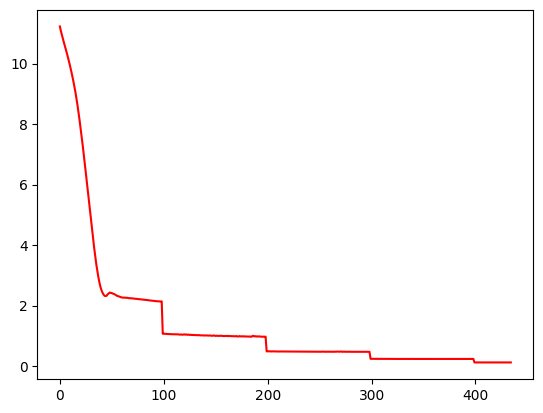

 87%|████████▋ | 435/500 [00:49<00:06,  9.42it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.201952723535456
Dataset Name:  books , AUC Score (contextual):  42.46540496540497
Dataset Name:  books , AUC Score (structural):  41.01102161933022
Dataset Name:  books , AUC Score (joint-type):  47.746235246235244
Dataset Name:  books , AUC Score (structure type):  41.89070890302784
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.746235246235244
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


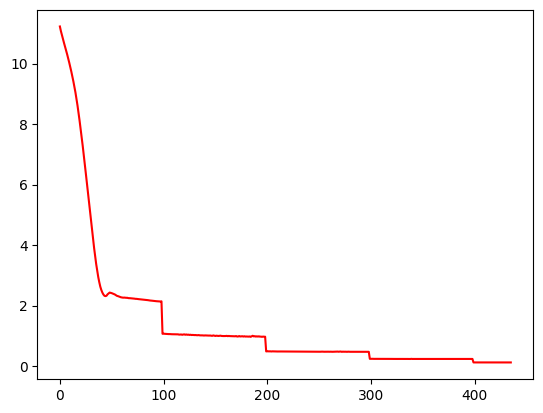

 87%|████████▋ | 436/500 [00:49<00:06,  9.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.52055498458377
Dataset Name:  books , AUC Score (contextual):  45.09564509564509
Dataset Name:  books , AUC Score (structural):  40.897626112759646
Dataset Name:  books , AUC Score (joint-type):  47.11538461538462
Dataset Name:  books , AUC Score (structure type):  41.712016605748836
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.11538461538462
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


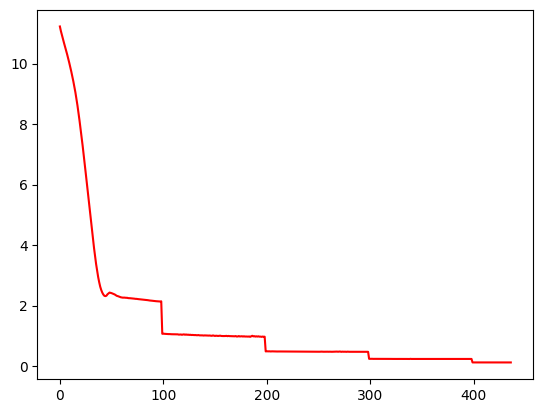

 87%|████████▋ | 437/500 [00:49<00:06,  9.47it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.55498458376156
Dataset Name:  books , AUC Score (contextual):  42.33821733821734
Dataset Name:  books , AUC Score (structural):  40.51080966511233
Dataset Name:  books , AUC Score (joint-type):  43.19291819291819
Dataset Name:  books , AUC Score (structure type):  40.59473850458012
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.19291819291819
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


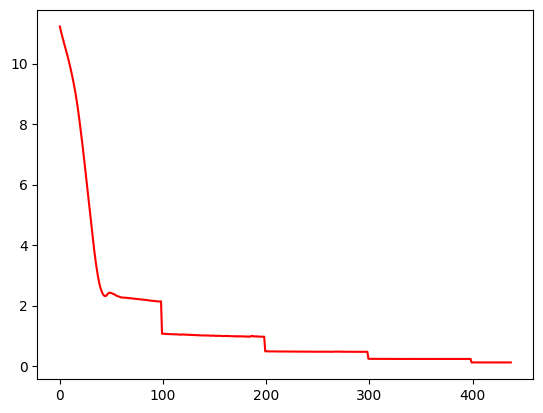

 88%|████████▊ | 438/500 [00:49<00:06,  9.59it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.13771839671121
Dataset Name:  books , AUC Score (contextual):  43.81868131868132
Dataset Name:  books , AUC Score (structural):  40.01907587961001
Dataset Name:  books , AUC Score (joint-type):  48.29059829059829
Dataset Name:  books , AUC Score (structure type):  41.09742340147105
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.29059829059829
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


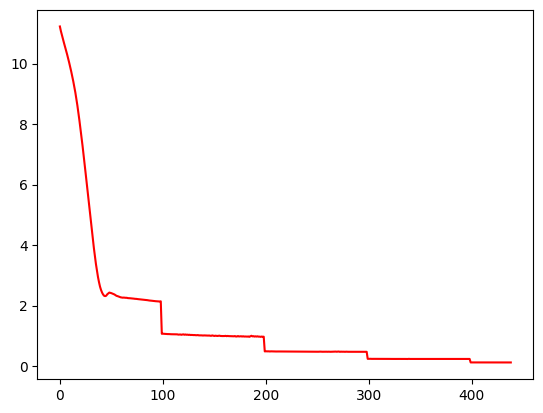

 88%|████████▊ | 439/500 [00:50<00:06,  9.65it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.343268242548824
Dataset Name:  books , AUC Score (contextual):  42.679080179080174
Dataset Name:  books , AUC Score (structural):  39.390631623569305
Dataset Name:  books , AUC Score (joint-type):  45.61457061457062
Dataset Name:  books , AUC Score (structure type):  40.21208429222508
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.61457061457062
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


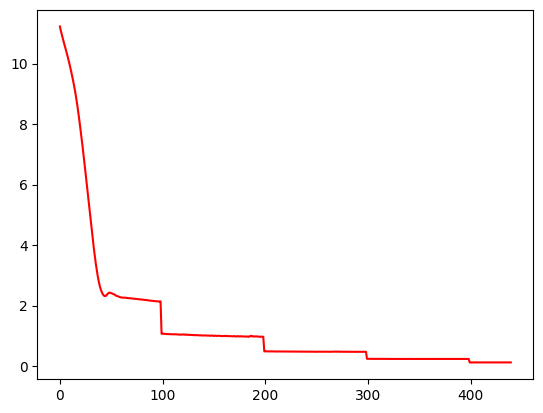

Dataset Name:  books , AUC Score(benchmark/combined):  62.02980472764645
Dataset Name:  books , AUC Score (contextual):  43.08099308099308
Dataset Name:  books , AUC Score (structural):  39.83573548113607
Dataset Name:  books , AUC Score (joint-type):  46.6931216931217
Dataset Name:  books , AUC Score (structure type):  40.76530842471008
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.6931216931217
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


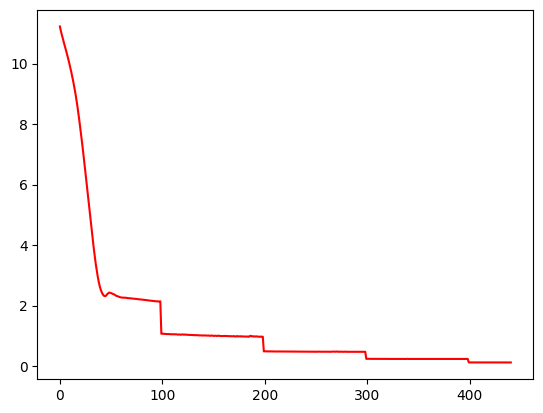

 88%|████████▊ | 441/500 [00:50<00:06,  9.83it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.677800616649535
Dataset Name:  books , AUC Score (contextual):  42.699430199430196
Dataset Name:  books , AUC Score (structural):  39.444679949130986
Dataset Name:  books , AUC Score (joint-type):  48.728123728123734
Dataset Name:  books , AUC Score (structure type):  40.67686476242047
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.728123728123734
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


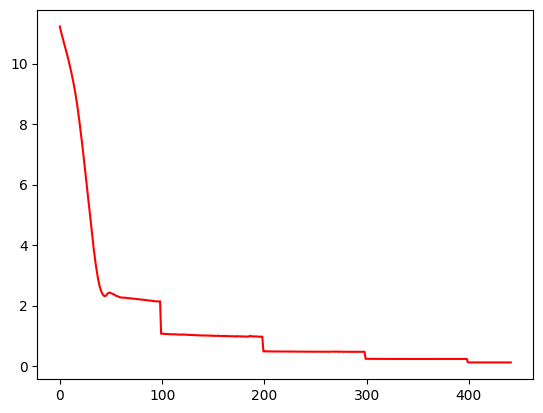

 88%|████████▊ | 442/500 [00:50<00:05,  9.83it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.729701952723545
Dataset Name:  books , AUC Score (contextual):  41.21896621896622
Dataset Name:  books , AUC Score (structural):  40.388935989826194
Dataset Name:  books , AUC Score (joint-type):  47.04924704924705
Dataset Name:  books , AUC Score (structure type):  41.32665493434412
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.04924704924705
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


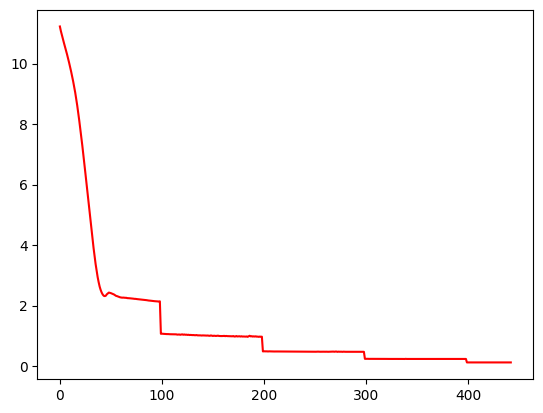

Dataset Name:  books , AUC Score(benchmark/combined):  61.98098663926002
Dataset Name:  books , AUC Score (contextual):  43.381155881155884
Dataset Name:  books , AUC Score (structural):  40.14624841034337
Dataset Name:  books , AUC Score (joint-type):  45.73158323158323
Dataset Name:  books , AUC Score (structure type):  40.831189928252336
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.73158323158323
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


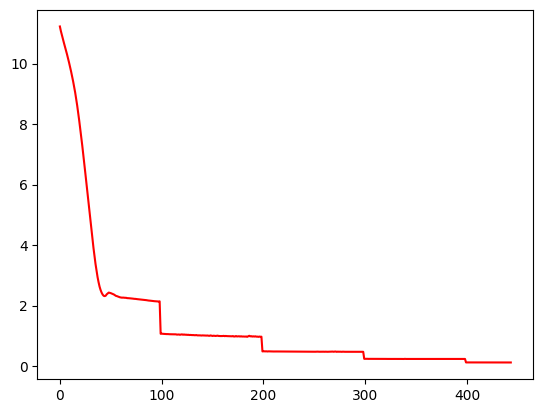

 89%|████████▉ | 444/500 [00:50<00:05,  9.93it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.21993833504625
Dataset Name:  books , AUC Score (contextual):  42.23137973137974
Dataset Name:  books , AUC Score (structural):  39.76579058923273
Dataset Name:  books , AUC Score (joint-type):  47.3951973951974
Dataset Name:  books , AUC Score (structure type):  40.76621091105997
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.3951973951974
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


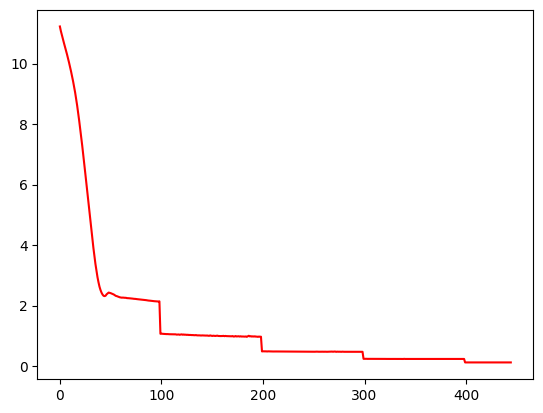

Dataset Name:  books , AUC Score(benchmark/combined):  61.33350462487152
Dataset Name:  books , AUC Score (contextual):  42.75030525030525
Dataset Name:  books , AUC Score (structural):  40.804366256888514
Dataset Name:  books , AUC Score (joint-type):  46.54049654049654
Dataset Name:  books , AUC Score (structure type):  41.54866657641803
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.54049654049654
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


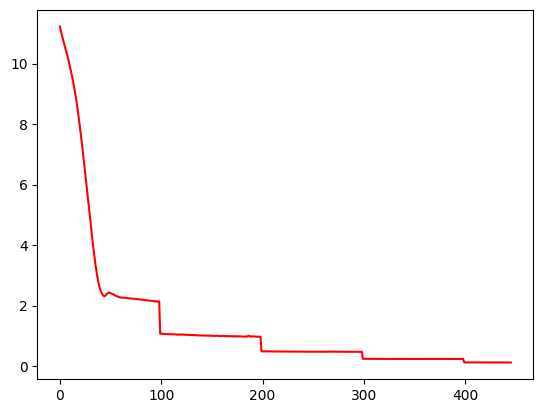

 89%|████████▉ | 446/500 [00:50<00:07,  7.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.63874614594038
Dataset Name:  books , AUC Score (contextual):  41.10704110704111
Dataset Name:  books , AUC Score (structural):  40.604069520983465
Dataset Name:  books , AUC Score (joint-type):  44.99898249898249
Dataset Name:  books , AUC Score (structure type):  41.15157258246469
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.99898249898249
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


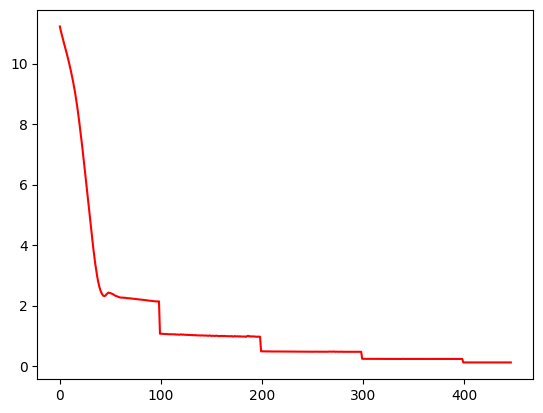

 89%|████████▉ | 447/500 [00:51<00:07,  7.45it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.83967112024666
Dataset Name:  books , AUC Score (contextual):  41.83455433455433
Dataset Name:  books , AUC Score (structural):  41.029037727850785
Dataset Name:  books , AUC Score (joint-type):  46.04192104192104
Dataset Name:  books , AUC Score (structure type):  41.607328189161144
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.04192104192104
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


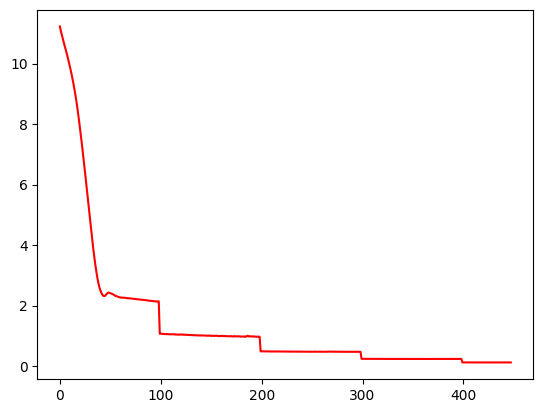

 90%|████████▉ | 448/500 [00:51<00:06,  7.90it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.84686536485098
Dataset Name:  books , AUC Score (contextual):  42.541717541717546
Dataset Name:  books , AUC Score (structural):  40.23208986858838
Dataset Name:  books , AUC Score (joint-type):  46.677859177859176
Dataset Name:  books , AUC Score (structure type):  41.14886512341501
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.677859177859176
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


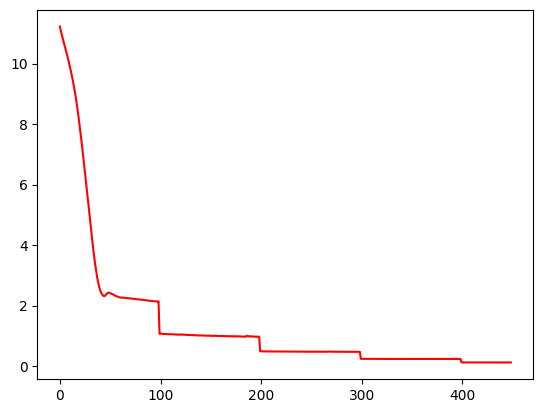

 90%|████████▉ | 449/500 [00:51<00:06,  8.32it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.515416238437815
Dataset Name:  books , AUC Score (contextual):  42.49084249084248
Dataset Name:  books , AUC Score (structural):  40.25222551928783
Dataset Name:  books , AUC Score (joint-type):  46.93223443223443
Dataset Name:  books , AUC Score (structure type):  41.10103334687063
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.93223443223443
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


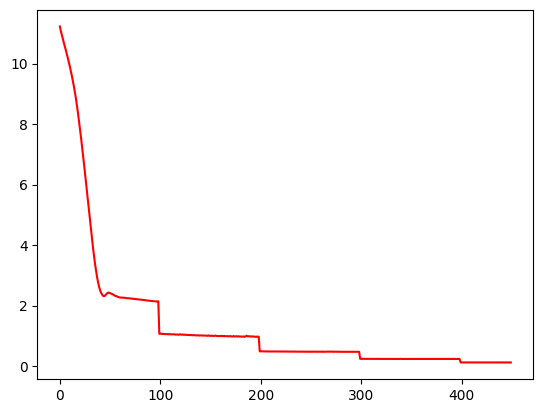

 90%|█████████ | 450/500 [00:51<00:05,  8.62it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.6289825282631
Dataset Name:  books , AUC Score (contextual):  40.23199023199023
Dataset Name:  books , AUC Score (structural):  40.16532428995337
Dataset Name:  books , AUC Score (joint-type):  46.88644688644689
Dataset Name:  books , AUC Score (structure type):  41.053201570326245
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.88644688644689
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


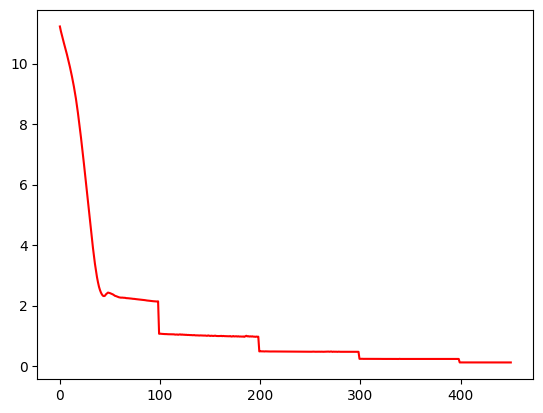

Dataset Name:  books , AUC Score(benchmark/combined):  63.008735868448106
Dataset Name:  books , AUC Score (contextual):  38.55820105820106
Dataset Name:  books , AUC Score (structural):  40.284018651971174
Dataset Name:  books , AUC Score (joint-type):  47.14082214082214
Dataset Name:  books , AUC Score (structure type):  41.18135463201118
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.14082214082214
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


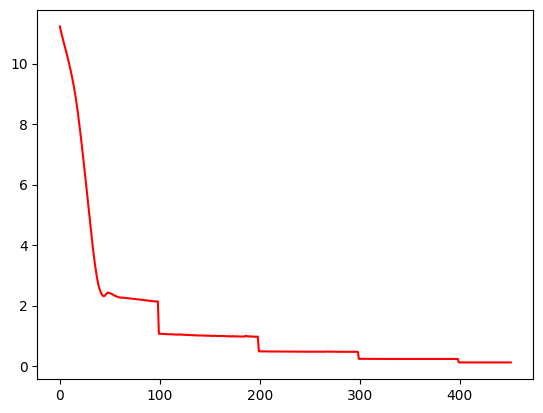

 90%|█████████ | 452/500 [00:51<00:05,  9.18it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.42034943473793
Dataset Name:  books , AUC Score (contextual):  40.96967846967846
Dataset Name:  books , AUC Score (structural):  40.21301398897838
Dataset Name:  books , AUC Score (joint-type):  46.02665852665852
Dataset Name:  books , AUC Score (structure type):  41.012589684581016
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.02665852665852
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


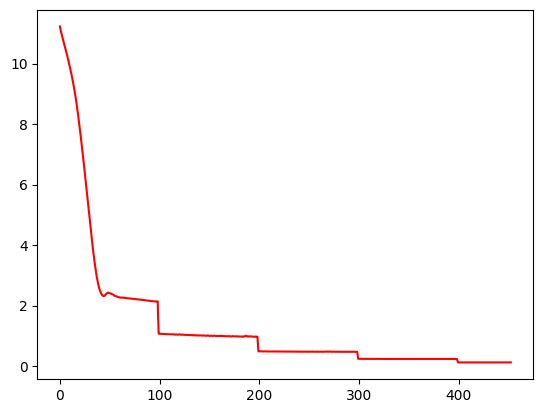

Dataset Name:  books , AUC Score(benchmark/combined):  61.19989722507708
Dataset Name:  books , AUC Score (contextual):  41.64631664631664
Dataset Name:  books , AUC Score (structural):  40.46629927935566
Dataset Name:  books , AUC Score (joint-type):  47.11029711029711
Dataset Name:  books , AUC Score (structure type):  41.419611028383194
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.11029711029711
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


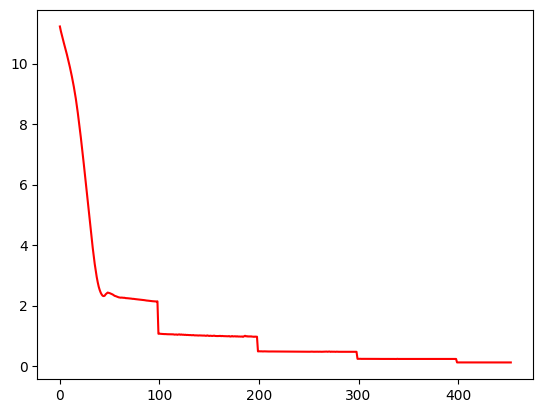

 91%|█████████ | 454/500 [00:51<00:04,  9.53it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.214799588900306
Dataset Name:  books , AUC Score (contextual):  42.73504273504273
Dataset Name:  books , AUC Score (structural):  40.95379398050021
Dataset Name:  books , AUC Score (joint-type):  47.313797313797316
Dataset Name:  books , AUC Score (structure type):  41.791435404539506
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.313797313797316
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


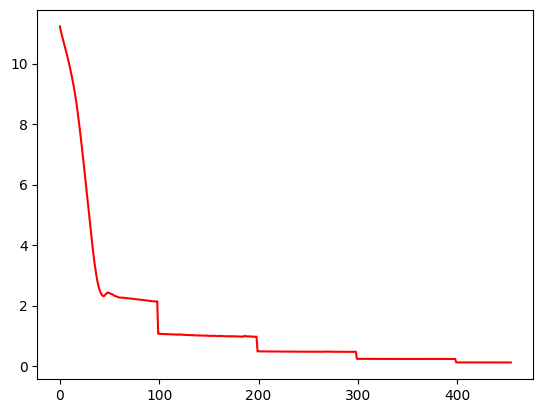

Dataset Name:  books , AUC Score(benchmark/combined):  62.2764645426516
Dataset Name:  books , AUC Score (contextual):  43.27431827431827
Dataset Name:  books , AUC Score (structural):  39.92687579482832
Dataset Name:  books , AUC Score (joint-type):  48.05148555148555
Dataset Name:  books , AUC Score (structure type):  41.17232976851225
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.05148555148555
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


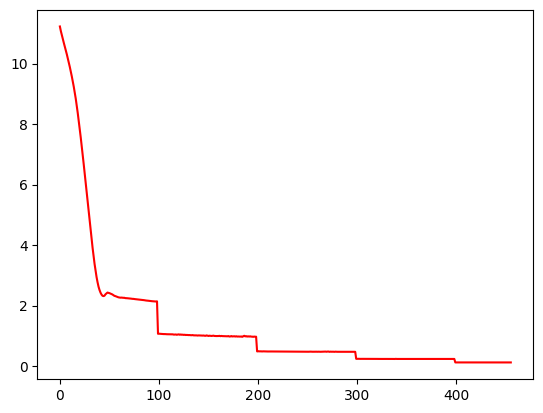

 91%|█████████ | 456/500 [00:51<00:04,  9.75it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.29239465570401
Dataset Name:  books , AUC Score (contextual):  41.5954415954416
Dataset Name:  books , AUC Score (structural):  41.06295040271301
Dataset Name:  books , AUC Score (joint-type):  44.698819698819705
Dataset Name:  books , AUC Score (structure type):  41.70389422859979
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.698819698819705
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


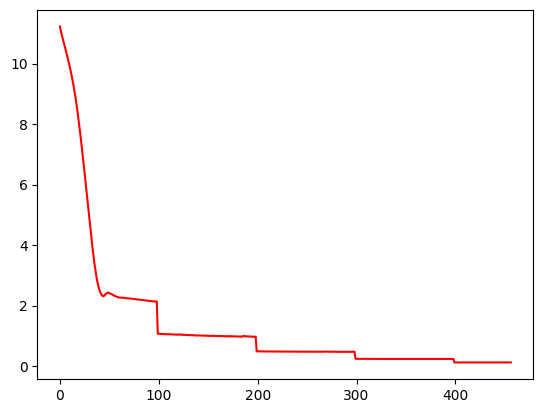

 91%|█████████▏| 457/500 [00:52<00:04,  9.74it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.436793422404946
Dataset Name:  books , AUC Score (contextual):  38.883801383801384
Dataset Name:  books , AUC Score (structural):  41.340610428147514
Dataset Name:  books , AUC Score (joint-type):  47.486772486772495
Dataset Name:  books , AUC Score (structure type):  42.0901583863544
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.486772486772495
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


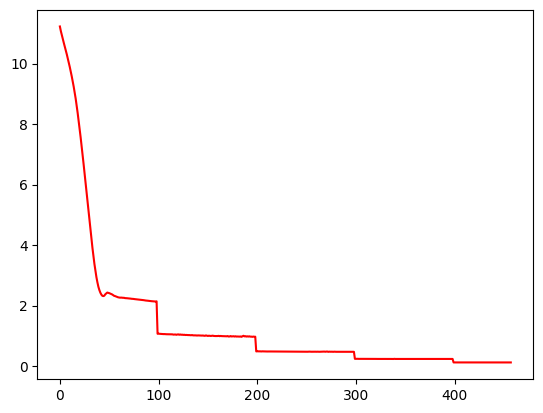

 92%|█████████▏| 458/500 [00:52<00:04,  9.79it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.45066803699897
Dataset Name:  books , AUC Score (contextual):  40.944240944240946
Dataset Name:  books , AUC Score (structural):  40.736540907164056
Dataset Name:  books , AUC Score (joint-type):  48.13288563288564
Dataset Name:  books , AUC Score (structure type):  41.64162267045711
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.13288563288564
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


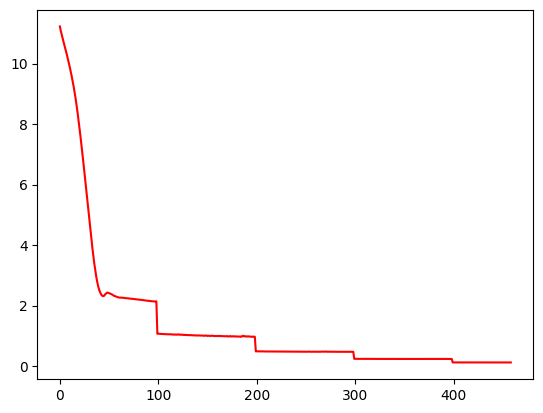

Dataset Name:  books , AUC Score(benchmark/combined):  62.623329907502566
Dataset Name:  books , AUC Score (contextual):  42.77574277574278
Dataset Name:  books , AUC Score (structural):  40.55320050869013
Dataset Name:  books , AUC Score (joint-type):  46.6982091982092
Dataset Name:  books , AUC Score (structure type):  41.39885384233564
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.6982091982092
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


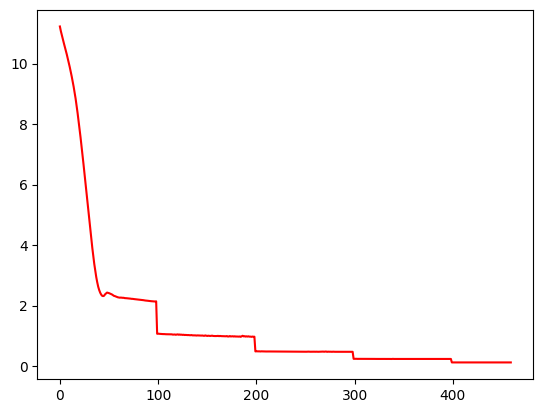

 92%|█████████▏| 460/500 [00:52<00:04,  9.92it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.8879753340185
Dataset Name:  books , AUC Score (contextual):  42.22120472120472
Dataset Name:  books , AUC Score (structural):  39.33870284018652
Dataset Name:  books , AUC Score (joint-type):  48.53479853479854
Dataset Name:  books , AUC Score (structure type):  40.54058932358649
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.53479853479854
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


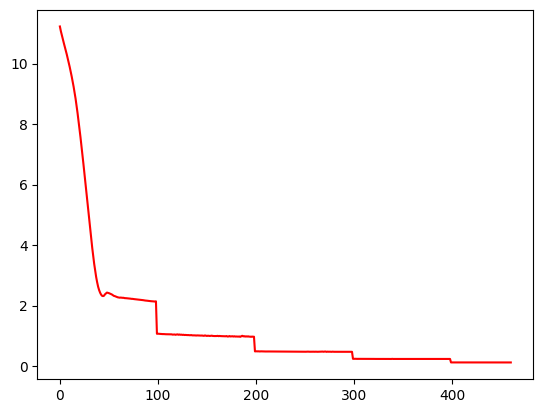

Dataset Name:  books , AUC Score(benchmark/combined):  61.87821171634121
Dataset Name:  books , AUC Score (contextual):  41.844729344729345
Dataset Name:  books , AUC Score (structural):  40.18016108520559
Dataset Name:  books , AUC Score (joint-type):  47.65466015466016
Dataset Name:  books , AUC Score (structure type):  41.32124001624475
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.65466015466016
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


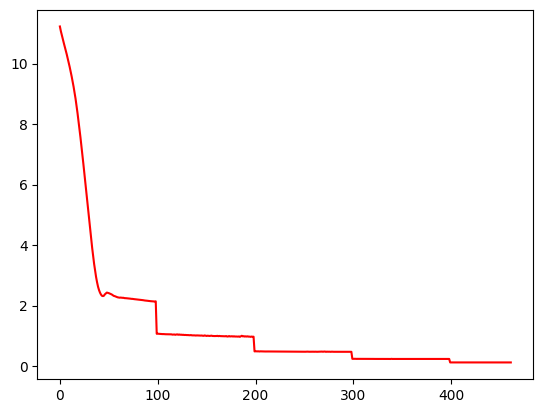

 92%|█████████▏| 462/500 [00:52<00:03,  9.68it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.49486125385406
Dataset Name:  books , AUC Score (contextual):  42.50610500610501
Dataset Name:  books , AUC Score (structural):  40.484315387876215
Dataset Name:  books , AUC Score (joint-type):  47.064509564509564
Dataset Name:  books , AUC Score (structure type):  41.594693380262626
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.064509564509564
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


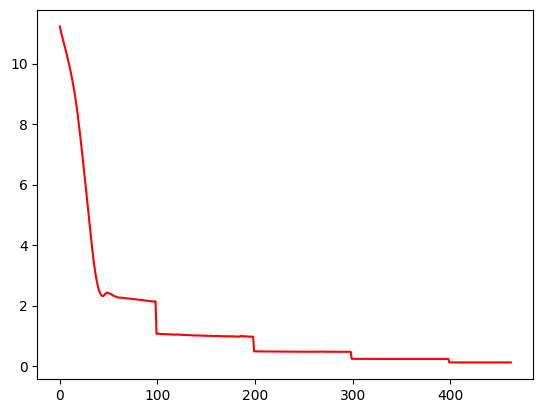

 93%|█████████▎| 463/500 [00:52<00:03,  9.48it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.189619732785204
Dataset Name:  books , AUC Score (contextual):  41.213878713878714
Dataset Name:  books , AUC Score (structural):  40.14200932598559
Dataset Name:  books , AUC Score (joint-type):  48.52462352462353
Dataset Name:  books , AUC Score (structure type):  41.348314606741575
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.52462352462353
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


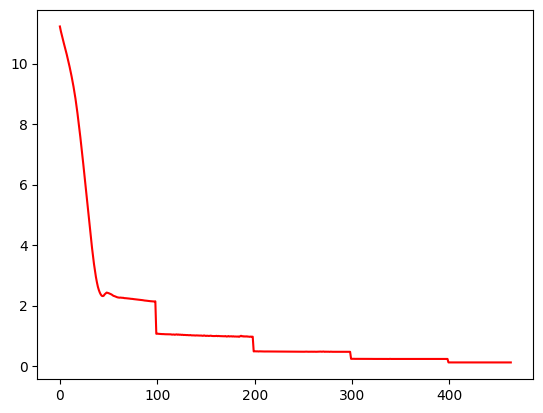

 93%|█████████▎| 464/500 [00:52<00:03,  9.40it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.53597122302158
Dataset Name:  books , AUC Score (contextual):  43.381155881155884
Dataset Name:  books , AUC Score (structural):  40.32111064010174
Dataset Name:  books , AUC Score (joint-type):  49.32336182336182
Dataset Name:  books , AUC Score (structure type):  41.66147737015478
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  49.32336182336182
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


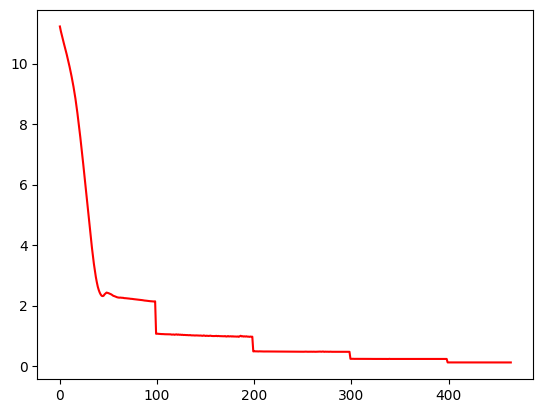

 93%|█████████▎| 465/500 [00:52<00:03,  9.26it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.455292908530325
Dataset Name:  books , AUC Score (contextual):  41.625966625966626
Dataset Name:  books , AUC Score (structural):  42.65684612123781
Dataset Name:  books , AUC Score (joint-type):  52.38095238095237
Dataset Name:  books , AUC Score (structure type):  44.06118857452281
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  52.38095238095237
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


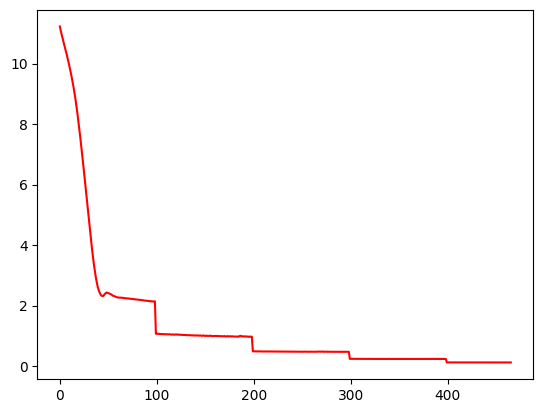

 93%|█████████▎| 466/500 [00:52<00:03,  9.14it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.49897225077082
Dataset Name:  books , AUC Score (contextual):  40.50671550671551
Dataset Name:  books , AUC Score (structural):  41.372403560830854
Dataset Name:  books , AUC Score (joint-type):  47.868335368335366
Dataset Name:  books , AUC Score (structure type):  42.35097694147375
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.868335368335366
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


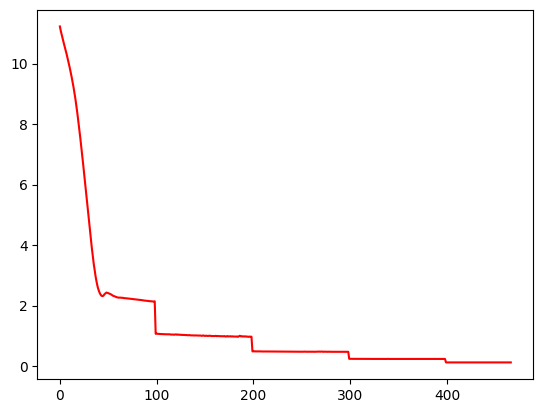

 93%|█████████▎| 467/500 [00:53<00:03,  9.00it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.52158273381295
Dataset Name:  books , AUC Score (contextual):  47.87851037851038
Dataset Name:  books , AUC Score (structural):  41.77299703264095
Dataset Name:  books , AUC Score (joint-type):  45.7977207977208
Dataset Name:  books , AUC Score (structure type):  42.43671314471369
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.7977207977208
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


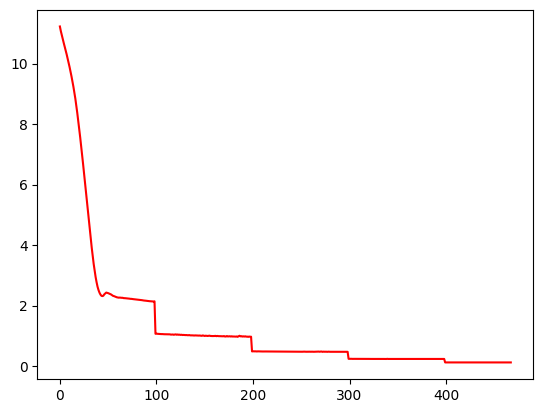

 94%|█████████▎| 468/500 [00:53<00:03,  9.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  59.95118191161356
Dataset Name:  books , AUC Score (contextual):  44.18752543752543
Dataset Name:  books , AUC Score (structural):  40.08902077151335
Dataset Name:  books , AUC Score (joint-type):  49.2979242979243
Dataset Name:  books , AUC Score (structure type):  41.38170660168765
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  49.2979242979243
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


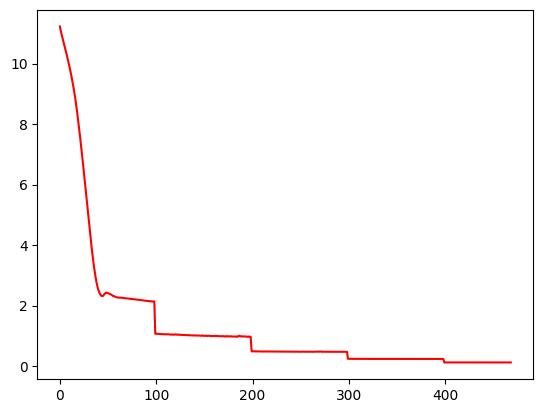

 94%|█████████▍| 469/500 [00:53<00:03,  9.07it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.35405960945529
Dataset Name:  books , AUC Score (contextual):  43.543956043956044
Dataset Name:  books , AUC Score (structural):  41.341670199236965
Dataset Name:  books , AUC Score (joint-type):  47.44607244607244
Dataset Name:  books , AUC Score (structure type):  42.154234917196874
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.44607244607244
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


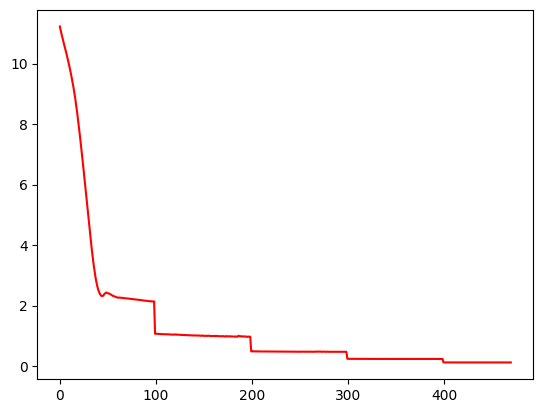

 94%|█████████▍| 470/500 [00:53<00:03,  9.32it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.523124357656734
Dataset Name:  books , AUC Score (contextual):  42.531542531542534
Dataset Name:  books , AUC Score (structural):  40.86901229334464
Dataset Name:  books , AUC Score (joint-type):  48.71794871794872
Dataset Name:  books , AUC Score (structure type):  41.93854067957222
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.71794871794872
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


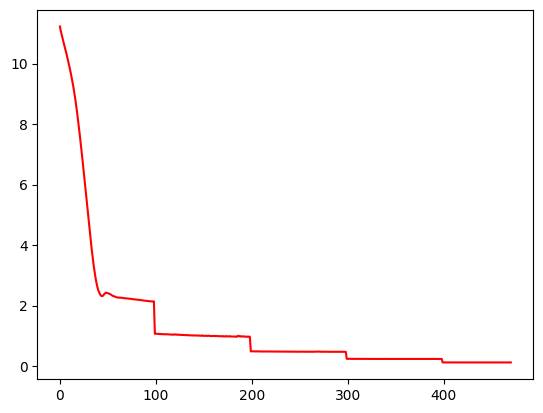

Dataset Name:  books , AUC Score(benchmark/combined):  64.79188078108942
Dataset Name:  books , AUC Score (contextual):  41.397028897028896
Dataset Name:  books , AUC Score (structural):  40.02755404832556
Dataset Name:  books , AUC Score (joint-type):  47.23239723239724
Dataset Name:  books , AUC Score (structure type):  41.03515184332837
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.23239723239724
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


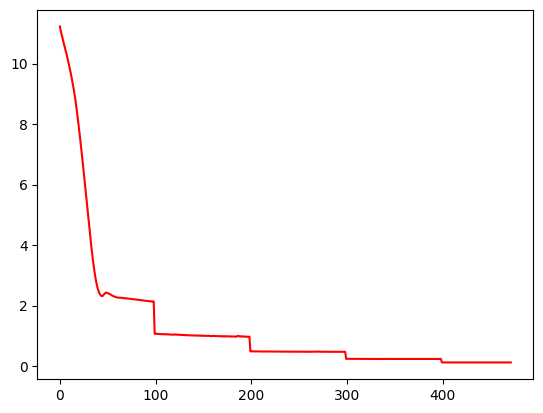

 94%|█████████▍| 472/500 [00:53<00:02,  9.67it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.84686536485098
Dataset Name:  books , AUC Score (contextual):  41.168091168091166
Dataset Name:  books , AUC Score (structural):  41.11805849936413
Dataset Name:  books , AUC Score (joint-type):  47.02889702889703
Dataset Name:  books , AUC Score (structure type):  42.01795947836289
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.02889702889703
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


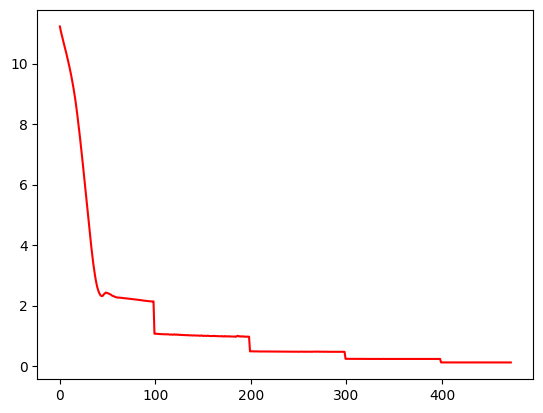

 95%|█████████▍| 473/500 [00:53<00:02,  9.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.42959917780061
Dataset Name:  books , AUC Score (contextual):  42.61294261294262
Dataset Name:  books , AUC Score (structural):  40.79058923272573
Dataset Name:  books , AUC Score (joint-type):  48.02604802604803
Dataset Name:  books , AUC Score (structure type):  41.71833401019809
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.02604802604803
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


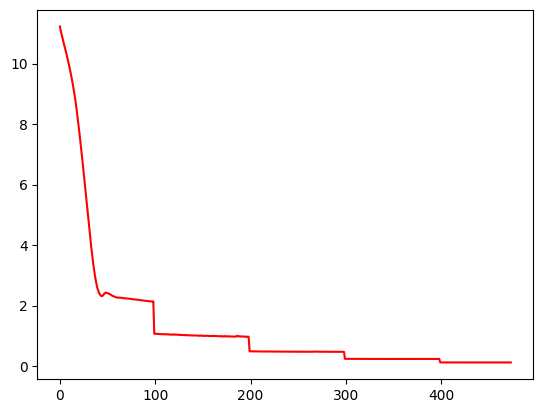

 95%|█████████▍| 474/500 [00:53<00:02,  9.52it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.91572456320658
Dataset Name:  books , AUC Score (contextual):  42.82661782661782
Dataset Name:  books , AUC Score (structural):  41.35968630775752
Dataset Name:  books , AUC Score (joint-type):  43.94078144078144
Dataset Name:  books , AUC Score (structure type):  41.69306439240107
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.94078144078144
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


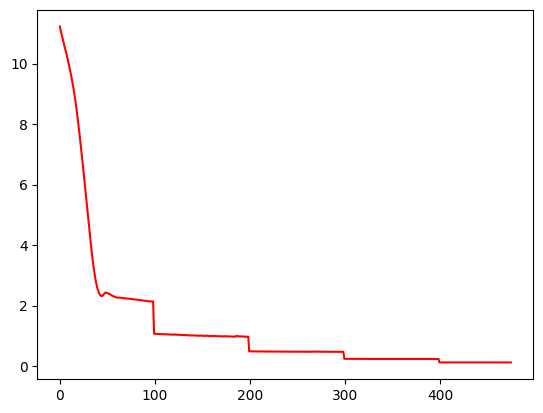

 95%|█████████▌| 475/500 [00:53<00:02,  9.37it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.302672147995885
Dataset Name:  books , AUC Score (contextual):  41.67175417175418
Dataset Name:  books , AUC Score (structural):  40.21195421788894
Dataset Name:  books , AUC Score (joint-type):  48.13288563288564
Dataset Name:  books , AUC Score (structure type):  41.43856324173097
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.13288563288564
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


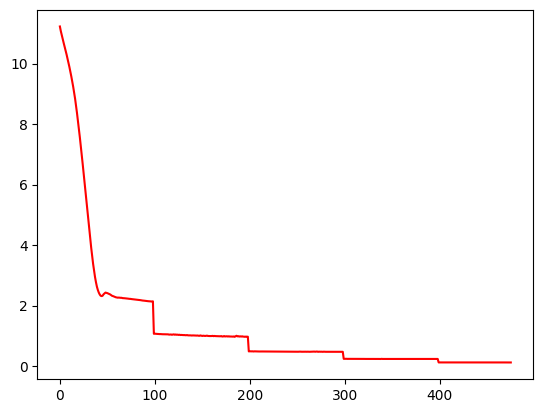

 95%|█████████▌| 476/500 [00:54<00:02,  9.32it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.44090441932168
Dataset Name:  books , AUC Score (contextual):  40.71021571021571
Dataset Name:  books , AUC Score (structural):  40.72912250953794
Dataset Name:  books , AUC Score (joint-type):  46.52014652014651
Dataset Name:  books , AUC Score (structure type):  41.581156085014214
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.52014652014651
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


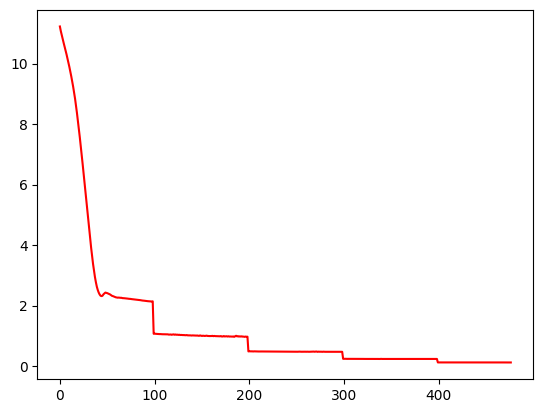

 95%|█████████▌| 477/500 [00:54<00:02,  9.46it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.103802672148
Dataset Name:  books , AUC Score (contextual):  42.67399267399267
Dataset Name:  books , AUC Score (structural):  40.0805426027978
Dataset Name:  books , AUC Score (joint-type):  47.65466015466016
Dataset Name:  books , AUC Score (structure type):  41.072153783674025
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.65466015466016
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


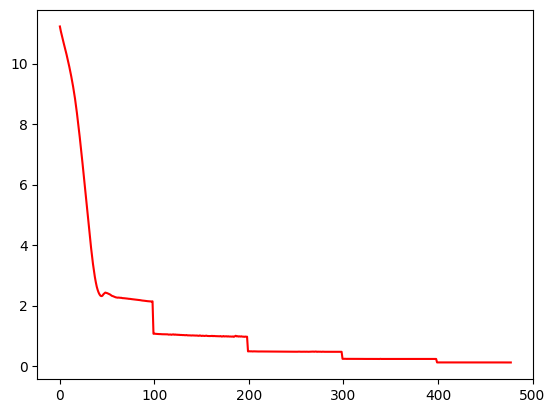

 96%|█████████▌| 478/500 [00:54<00:02,  9.08it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.168550873586845
Dataset Name:  books , AUC Score (contextual):  38.2020757020757
Dataset Name:  books , AUC Score (structural):  39.11191182704536
Dataset Name:  books , AUC Score (joint-type):  48.37199837199837
Dataset Name:  books , AUC Score (structure type):  40.446730743197506
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.37199837199837
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


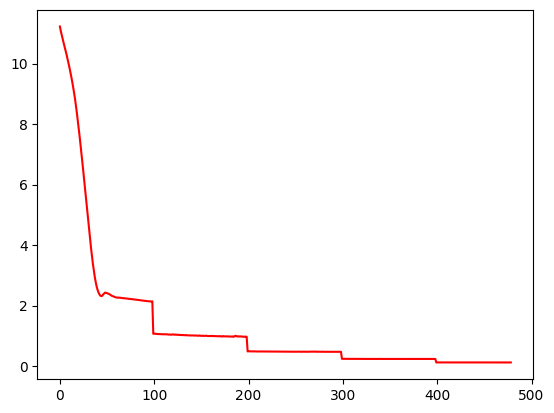

 96%|█████████▌| 479/500 [00:54<00:02,  8.59it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  60.61921891058583
Dataset Name:  books , AUC Score (contextual):  41.41737891737891
Dataset Name:  books , AUC Score (structural):  40.26812208562951
Dataset Name:  books , AUC Score (joint-type):  52.197802197802204
Dataset Name:  books , AUC Score (structure type):  42.234556202337444
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  52.197802197802204
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


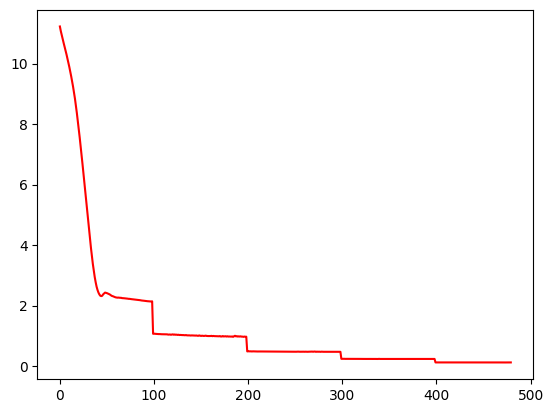

 96%|█████████▌| 480/500 [00:54<00:02,  8.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.054984583761566
Dataset Name:  books , AUC Score (contextual):  41.844729344729345
Dataset Name:  books , AUC Score (structural):  40.48113607460788
Dataset Name:  books , AUC Score (joint-type):  46.58628408628409
Dataset Name:  books , AUC Score (structure type):  41.23550381300483
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.58628408628409
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


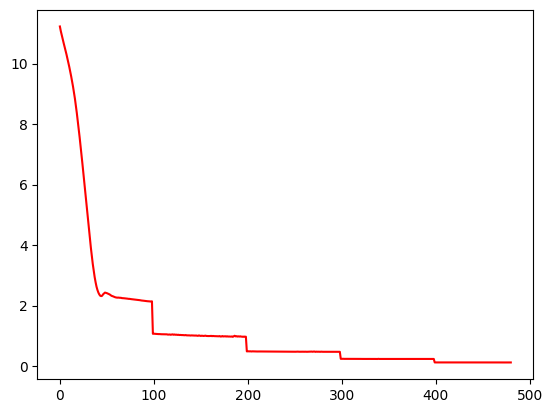

 96%|█████████▌| 481/500 [00:54<00:02,  8.82it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.06988694758479
Dataset Name:  books , AUC Score (contextual):  42.44505494505494
Dataset Name:  books , AUC Score (structural):  41.3353115727003
Dataset Name:  books , AUC Score (joint-type):  47.461334961334956
Dataset Name:  books , AUC Score (structure type):  42.17138215784486
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.461334961334956
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


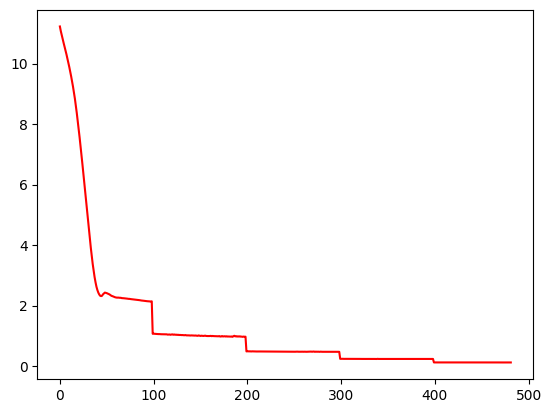

 96%|█████████▋| 482/500 [00:54<00:02,  8.73it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.13720452209661
Dataset Name:  books , AUC Score (contextual):  44.02218152218152
Dataset Name:  books , AUC Score (structural):  41.74756252649428
Dataset Name:  books , AUC Score (joint-type):  44.5970695970696
Dataset Name:  books , AUC Score (structure type):  42.22643382518839
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.5970695970696
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


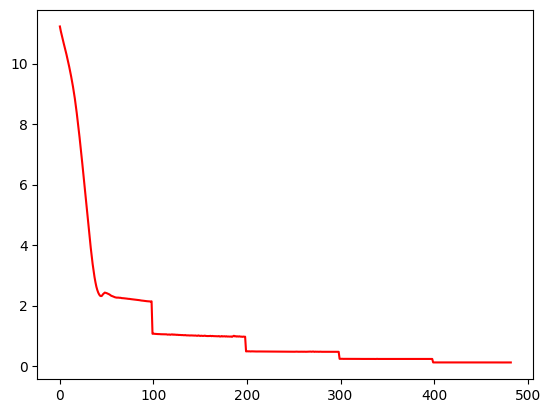

 97%|█████████▋| 483/500 [00:54<00:01,  8.76it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.07142857142856
Dataset Name:  books , AUC Score (contextual):  43.437118437118436
Dataset Name:  books , AUC Score (structural):  41.22827469266638
Dataset Name:  books , AUC Score (joint-type):  48.936711436711434
Dataset Name:  books , AUC Score (structure type):  42.36361175037228
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.936711436711434
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


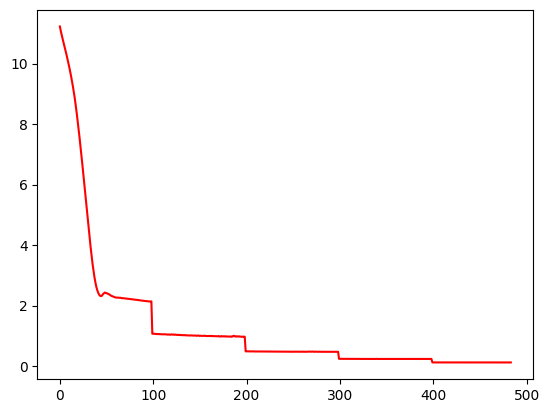

 97%|█████████▋| 484/500 [00:54<00:01,  8.72it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.32990750256937
Dataset Name:  books , AUC Score (contextual):  44.123931623931625
Dataset Name:  books , AUC Score (structural):  40.70792708774905
Dataset Name:  books , AUC Score (joint-type):  46.17419617419618
Dataset Name:  books , AUC Score (structure type):  41.665989801904246
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.17419617419618
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


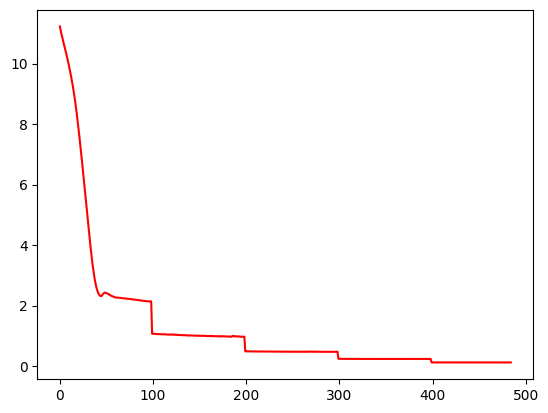

 97%|█████████▋| 485/500 [00:55<00:01,  8.84it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.75693730729701
Dataset Name:  books , AUC Score (contextual):  41.274928774928775
Dataset Name:  books , AUC Score (structural):  41.03221704111912
Dataset Name:  books , AUC Score (joint-type):  45.38563288563289
Dataset Name:  books , AUC Score (structure type):  41.5676187897658
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.38563288563289
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


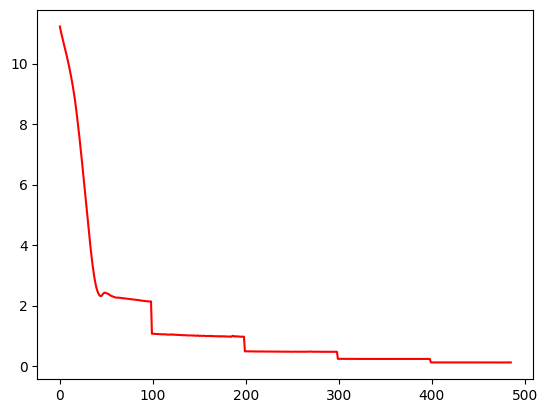

 97%|█████████▋| 486/500 [00:55<00:01,  8.93it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.33761562178828
Dataset Name:  books , AUC Score (contextual):  40.37444037444038
Dataset Name:  books , AUC Score (structural):  39.87706655362442
Dataset Name:  books , AUC Score (joint-type):  48.717948717948715
Dataset Name:  books , AUC Score (structure type):  41.06583637922476
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.717948717948715
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


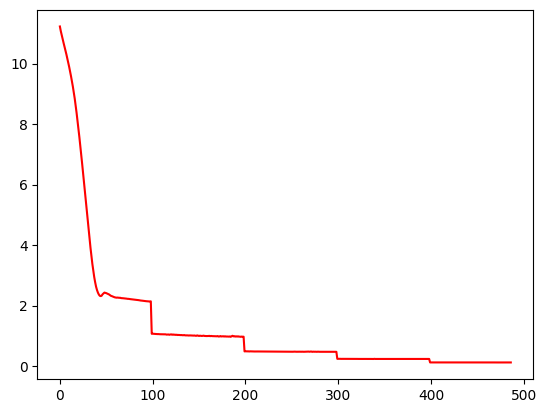

 97%|█████████▋| 487/500 [00:55<00:01,  9.06it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  65.10791366906476
Dataset Name:  books , AUC Score (contextual):  41.82946682946683
Dataset Name:  books , AUC Score (structural):  40.20983467571004
Dataset Name:  books , AUC Score (joint-type):  44.61233211233211
Dataset Name:  books , AUC Score (structure type):  40.77974820630838
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  44.61233211233211
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


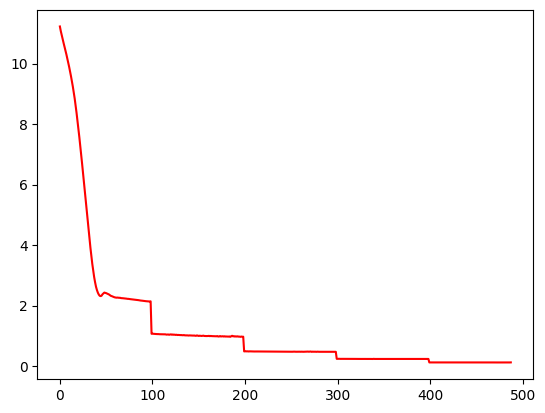

 98%|█████████▊| 488/500 [00:55<00:01,  9.17it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.77800616649538
Dataset Name:  books , AUC Score (contextual):  41.80911680911681
Dataset Name:  books , AUC Score (structural):  39.791225095379396
Dataset Name:  books , AUC Score (joint-type):  48.15323565323565
Dataset Name:  books , AUC Score (structure type):  40.966562880736426
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  48.15323565323565
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


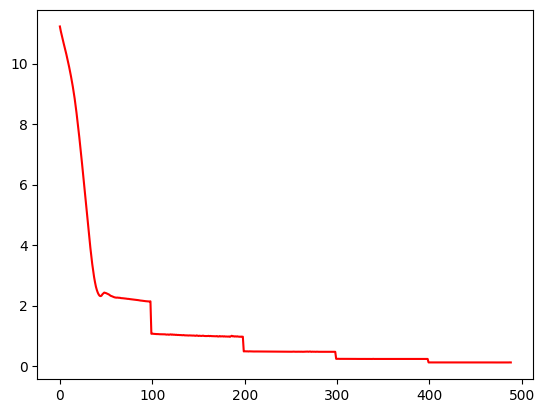

 98%|█████████▊| 489/500 [00:55<00:01,  9.27it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  63.3453237410072
Dataset Name:  books , AUC Score (contextual):  43.03011803011803
Dataset Name:  books , AUC Score (structural):  41.29186095803307
Dataset Name:  books , AUC Score (joint-type):  47.55799755799755
Dataset Name:  books , AUC Score (structure type):  42.08023103650557
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.55799755799755
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


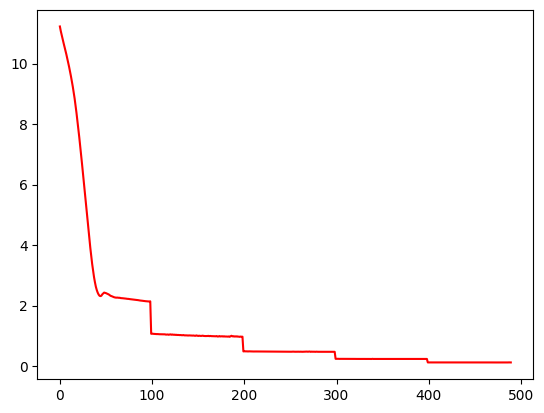

 98%|█████████▊| 490/500 [00:55<00:01,  8.91it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.6469681397739
Dataset Name:  books , AUC Score (contextual):  42.16524216524217
Dataset Name:  books , AUC Score (structural):  40.61042814752014
Dataset Name:  books , AUC Score (joint-type):  43.86955636955637
Dataset Name:  books , AUC Score (structure type):  41.12720545101756
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  43.86955636955637
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


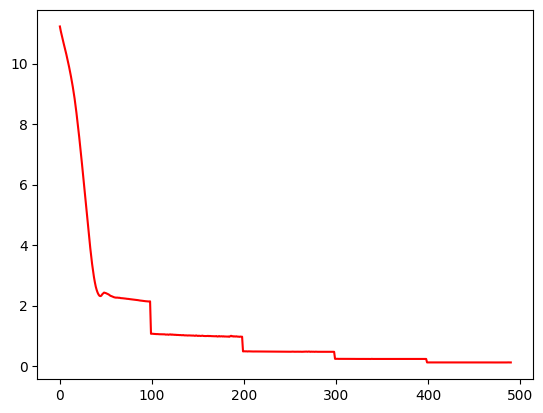

 98%|█████████▊| 491/500 [00:55<00:00,  9.04it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.94501541623845
Dataset Name:  books , AUC Score (contextual):  45.16687016687017
Dataset Name:  books , AUC Score (structural):  41.09898261975412
Dataset Name:  books , AUC Score (joint-type):  45.75193325193325
Dataset Name:  books , AUC Score (structure type):  41.599205812012094
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  45.75193325193325
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


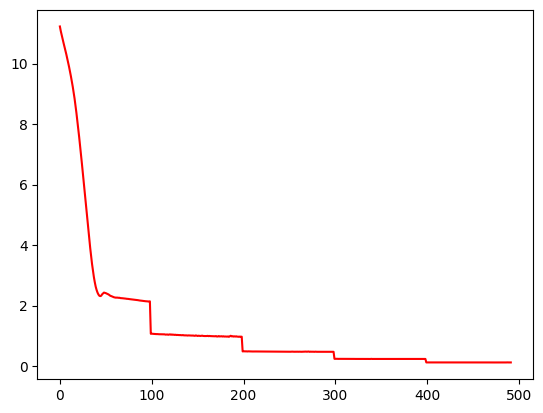

 98%|█████████▊| 492/500 [00:55<00:00,  9.24it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.548818088386426
Dataset Name:  books , AUC Score (contextual):  43.41676841676841
Dataset Name:  books , AUC Score (structural):  41.85194997880458
Dataset Name:  books , AUC Score (joint-type):  49.82193732193732
Dataset Name:  books , AUC Score (structure type):  42.89201750823518
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  49.82193732193732
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


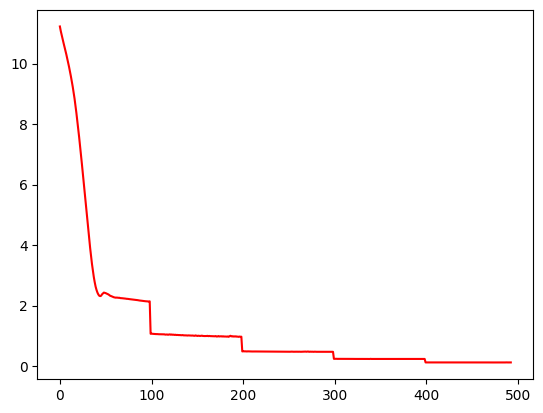

 99%|█████████▊| 493/500 [00:55<00:00,  9.36it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  64.04162384378212
Dataset Name:  books , AUC Score (contextual):  40.9035409035409
Dataset Name:  books , AUC Score (structural):  41.10640101738024
Dataset Name:  books , AUC Score (joint-type):  47.19169719169719
Dataset Name:  books , AUC Score (structure type):  41.86995171698028
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.19169719169719
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


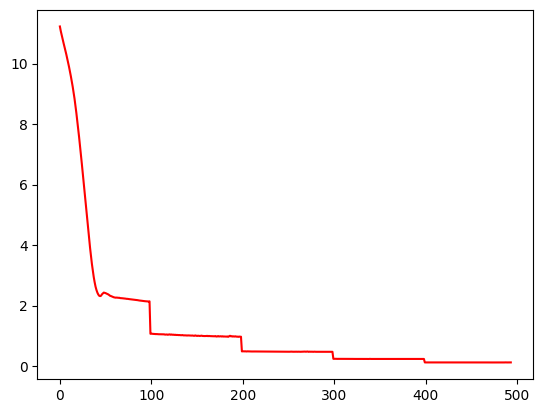

 99%|█████████▉| 494/500 [00:56<00:00,  9.43it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.75488180883866
Dataset Name:  books , AUC Score (contextual):  40.31847781847782
Dataset Name:  books , AUC Score (structural):  40.057227638830014
Dataset Name:  books , AUC Score (joint-type):  49.007936507936506
Dataset Name:  books , AUC Score (structure type):  41.23369884030503
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  49.007936507936506
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


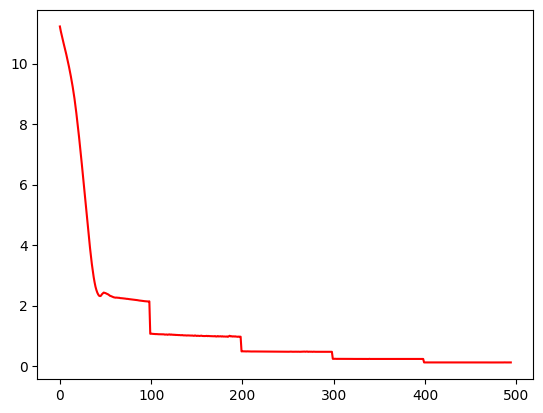

 99%|█████████▉| 495/500 [00:56<00:00,  9.49it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.525693730729714
Dataset Name:  books , AUC Score (contextual):  44.805657305657306
Dataset Name:  books , AUC Score (structural):  39.63649851632047
Dataset Name:  books , AUC Score (joint-type):  49.053724053724046
Dataset Name:  books , AUC Score (structure type):  40.884436622896075
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  49.053724053724046
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


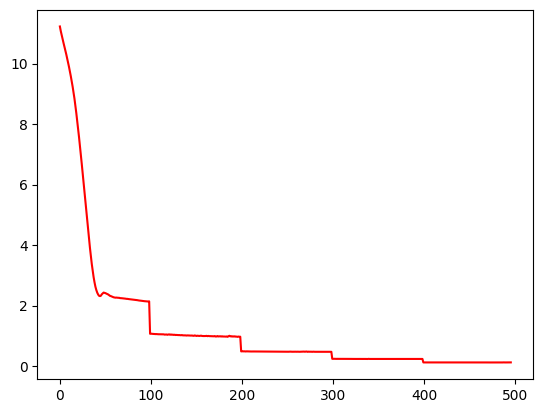

 99%|█████████▉| 496/500 [00:56<00:00,  6.20it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.433196300102786
Dataset Name:  books , AUC Score (contextual):  41.269841269841265
Dataset Name:  books , AUC Score (structural):  41.21661721068249
Dataset Name:  books , AUC Score (joint-type):  51.53642653642654
Dataset Name:  books , AUC Score (structure type):  42.66143224583728
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  51.53642653642654
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


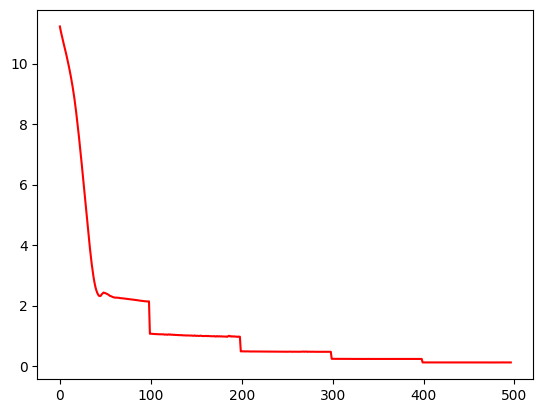

 99%|█████████▉| 497/500 [00:56<00:00,  6.89it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.67009249743063
Dataset Name:  books , AUC Score (contextual):  41.98209198209198
Dataset Name:  books , AUC Score (structural):  39.918397626112764
Dataset Name:  books , AUC Score (joint-type):  47.201872201872206
Dataset Name:  books , AUC Score (structure type):  41.055909029375925
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.201872201872206
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


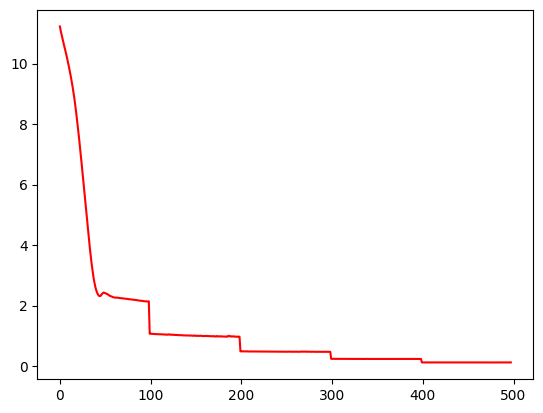

100%|█████████▉| 498/500 [00:56<00:00,  7.56it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  62.29958890030832
Dataset Name:  books , AUC Score (contextual):  41.01546601546602
Dataset Name:  books , AUC Score (structural):  40.76091564222127
Dataset Name:  books , AUC Score (joint-type):  46.571021571021575
Dataset Name:  books , AUC Score (structure type):  41.36816930643924
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  46.571021571021575
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


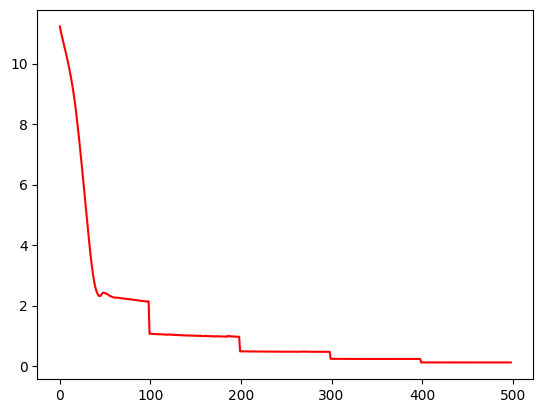

100%|█████████▉| 499/500 [00:56<00:00,  8.09it/s]

Dataset Name:  books , AUC Score(benchmark/combined):  61.726618705035975
Dataset Name:  books , AUC Score (contextual):  39.967439967439965
Dataset Name:  books , AUC Score (structural):  40.74501907587961
Dataset Name:  books , AUC Score (joint-type):  47.537647537647544
Dataset Name:  books , AUC Score (structure type):  41.57574116691485
Dataset Name:  books  Best AUC Score(benchmark/combined):  65.70914696813978
Dataset Name:  books  Best AUC Score (contextual):  58.64367114367115
Dataset Name:  books  Best AUC Score (structural):  46.54408647732089
Dataset Name:  books  Best AUC Score (joint-type):  47.537647537647544
Dataset Name:  books  Best AUC Score (structure type):  47.18875502008032


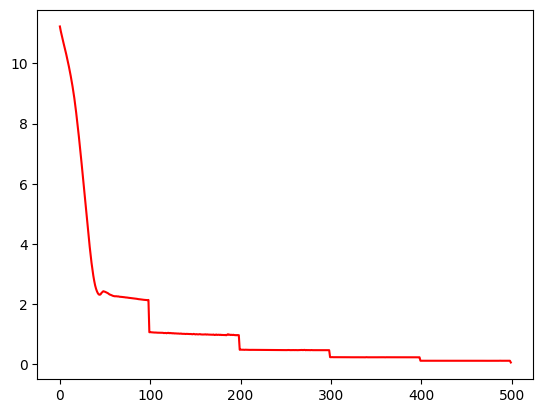

100%|██████████| 500/500 [00:56<00:00,  8.79it/s]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser(description='parameters')
parser.add_argument('-f')
parser.add_argument('--dataset', type=str, default="books")
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--epoch_num', type=int, default=500)
parser.add_argument('--lambda_loss1', type=float, default=1e-2) #neighbor reconstruction loss weight
parser.add_argument('--lambda_loss2', type=float, default=0.5) #feature loss weight
parser.add_argument('--lambda_loss3', type=float, default=0.8) #degree loss weight
parser.add_argument('--sample_size', type=int, default=10)
parser.add_argument('--dimension', type=int, default=16)
parser.add_argument('--encoder', type=str, default="SAGE")
parser.add_argument('--loss_step', type=int, default=100)
parser.add_argument('--real_loss', type=bool, default=True) #use real loss or adaptive loss
parser.add_argument('--neigh_loss', type=str, default="KL")
parser.add_argument('--h_loss_weight', type=float, default=1.0)#adaptive loss weight for h_loss
parser.add_argument('--feature_loss_weight', type=float, default=2.0) #adaptive loss weight for feature loss
parser.add_argument('--degree_loss_weight', type=float, default=1.0)#adaptive loss weight for degree loss
parser.add_argument('--calculate_contextual', type=bool, default=True)
parser.add_argument('--contextual_n', type=int, default=14)
parser.add_argument('--contextual_k', type=int, default=5)
parser.add_argument('--calculate_structural', type=bool, default=True)
parser.add_argument('--structural_n', type=int, default=14)
parser.add_argument('--structural_m', type=int, default=5)
parser.add_argument('--use_combine_outlier', type=bool, default=False)
parser.add_argument('--plot_loss', type=bool, default=True)
parser.add_argument('--normalize_feat', type=bool, default=True)
parser.add_argument('--aggregator', type=str, default="mean")



args = parser.parse_args()

print("GAD-NR: Graph Anomaly Detection via Neighborhood Reconstruction")
print("Dataset: ", args.dataset, "lr:", args.lr, "lambda_loss1 (neighbor):",args.lambda_loss1, "lambda_loss2 (feature):", args.lambda_loss2, "lambda_loss3 (degree):", args.lambda_loss3, "sample_size:", args.sample_size, "dimension:",args.dimension, "encoder:", args.encoder, "loss_step:", args.loss_step,"real_loss:", args.real_loss, "h_loss_weight:",args.h_loss_weight,"feature_loss_weight",args.feature_loss_weight,"degree_loss_weight:",args.degree_loss_weight,
"calculate_contextual",args.calculate_contextual,"calculate_structural",args.calculate_structural)


dataset_str = args.dataset
train_real_datasets(dataset_str=dataset_str, lr=args.lr, epoch_num=args.epoch_num, lambda_loss1=args.lambda_loss1, 
lambda_loss2=args.lambda_loss2, lambda_loss3=args.lambda_loss3, encoder=args.encoder, sample_size=args.sample_size, loss_step=args.loss_step, 
hidden_dim=args.dimension,real_loss=args.real_loss,calculate_contextual=args.calculate_contextual,calculate_structural=args.calculate_structural)